# Raman model in Pytorch 
This notebook as the purpose to transpose the CNN model created by Dario Bertazioli in the Pytorch librairie.

## Librairies
Here, we will find the librairies needed for this work. 

In [1]:
# --- Utils librairies ---
#Generics librairies
import os
import os.path
from os import path
import numpy as np
import copy
import pickle
from statistics import mean
import matplotlib.pyplot as plt

#Measure librairies
import time

#Dataset librairies
import pandas as pd

# --- DL librairies ---
#Pytorch librairies
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader

#Sklearn librairies
from sklearn.model_selection import LeaveOneGroupOut, train_test_split
from sklearn.metrics import accuracy_score

## Set up the GPU environment

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="1,2,3,4";
gpus_list = [0, 1, 2, 3]

print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
4


## Data
In this part, we will find all the methods regarding the data (loading, data augmentation...). 

### Load data

In [3]:
df, labels, names = pd.read_pickle("../data/dataset_COVID_RAW.pkl")
df = pd.DataFrame(df)
labels = pd.Series(labels, name = 'label')
names = pd.Series(names, name = 'names')
df = pd.concat((df, labels, names), axis = 1)

In [4]:
X_set = df.drop(columns = ['label', "names"]).values
Y_set = df.label.values
groups = df.names.values

In [5]:
folds = list(LeaveOneGroupOut().split(X_set, Y_set, groups = groups))

### Data augmentation

In [6]:
def dataAugment(signal, betashift = 0.24039033704204857, slopeshift = 0.5640435054299953, multishift = 0.0013960388613510225):
    #baseline shift
    beta = np.random.random(size=(signal.shape[0],1))*2*betashift-betashift
    slope = np.random.random(size=(signal.shape[0],1))*2*slopeshift-slopeshift + 1
    #relative positions
    axis = np.array(range(signal.shape[1]))/float(signal.shape[1])
    #offset
    offset = slope*(axis) + beta - axis - slope/2. + 0.5

    #multiplicative coefficient
    multi = np.random.random(size=(signal.shape[0],1))*2*multishift-multishift + 1
    augmented_signal = multi*signal + offset

    return augmented_signal

### Creation of train, test and validation sets

In [7]:
class RamanDataset(Dataset):
    def __init__(self, X, Y):
        super(RamanDataset).__init__()
        x = torch.from_numpy(X)
        self.raman_spectra = x
        y = torch.from_numpy(Y)
        self.labels = y
        
    def __len__(self):
        return len(self.raman_spectra)
    
    def __getitem__(self, idx):
        spectrum = self.raman_spectra[idx]
        label = self.labels[idx]
        
        return spectrum, label

In [8]:
class Datasets(Dataset):
    def __init__(self, ramanDatasets):
        super(Datasets).__init__()
        self.datasets = ramanDatasets
        
    def __len__(self):
        return len(self.datasets)
    
    def __getitem__(self, idx):
        return self.datasets[idx]

In [9]:
def setsCreation(pathToFile, X_set, Y_set, folds):
    if not path.exists(pathToFile):
        train_set = []
        validation_set = []
        test_set = []
        X_train = []
        X_val = []
        X_test = []
        Y_train = []
        Y_val = []
        Y_test = []
        
        for i, (train_idx, test_idx) in enumerate(folds):
            X_train_tmp = X_set[train_idx]
            Y_train_tmp = Y_set[train_idx]
            
            X_test_tmp = X_set[test_idx]
            Y_test_tmp = Y_set[test_idx]
            
            X_train_tmp, X_val_tmp, Y_train_tmp, Y_val_tmp = train_test_split(X_train_tmp, Y_train_tmp, test_size = .1,
                                                                              stratify = Y_train_tmp)
            augment = 30
            augmented_data = []
            Y_list = copy.copy(Y_train_tmp)
            for i in range(augment):
                augmented_data.append(dataAugment(X_train_tmp))
            for i in range(augment-1):
                Y_list = np.concatenate((Y_list, Y_train_tmp), axis=0)
                
            X_train_tmp = np.vstack(augmented_data)
            Y_train_tmp = copy.copy(Y_list)
            train_set_tmp = RamanDataset(X_train_tmp, Y_train_tmp)
            train_set.append(train_set_tmp)
            val_set_tmp = RamanDataset(X_val_tmp, Y_val_tmp)
            validation_set.append(val_set_tmp)
            test_set_tmp = RamanDataset(X_test_tmp, Y_test_tmp)
            test_set.append(test_set_tmp)
        
        train_dataset = Datasets(train_set)
        validation_dataset = Datasets(validation_set)
        test_dataset = Datasets(test_set)
        training_settings = (train_dataset, validation_dataset, test_dataset)
        
        with open(pathToFile, "wb") as outf:
            pickle.dump(training_settings, outf)
        
    else:
        with open(pathToFile, "rb") as inf:
            train_dataset, validation_dataset, test_dataset = pickle.load(inf)
            
    return train_dataset, validation_dataset, test_dataset

In [10]:
train_dataset, validation_dataset, test_dataset = setsCreation("../train_settings/training_settings_cov_raw.pckl", X_set, Y_set, folds)

## Model

### Utility class and functions

In [11]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.cnn_layers = nn.Sequential(
            nn.Conv1d(1, 100, kernel_size=100,
                     stride=1, padding_mode='replicate'),
            nn.ReLU(),
            nn.BatchNorm1d(100, eps=0.001, momentum=0.99),
            nn.Conv1d(100, 102, kernel_size=5,
                     stride=2, padding_mode='replicate'),
            nn.ReLU(),
            nn.MaxPool1d(6, stride=3),
            nn.BatchNorm1d(102, eps=0.001, momentum=0.99),
            nn.Conv1d(102, 25, kernel_size=9,
                     stride=5, padding_mode='replicate'),
            nn.ReLU(),
            nn.MaxPool1d(3, stride=2)
        )
        
        self.dense_layers = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(325, 732),
            nn.LeakyReLU(),
            nn.Dropout(p=0.7000000000000001),
            nn.Linear(732, 152),
            nn.LeakyReLU(),
            nn.Dropout(p=0.25),
            nn.Linear(152,189),
            nn.LeakyReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(189, 3),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        x = x.resize_(x.shape[0],  1, x.shape[1])
        x = self.cnn_layers(x)
        x = torch.flatten(x, 1)
        x = self.dense_layers(x)
        return x        

In [12]:
def createCNN(gpu_ids):
    model = ConvNet()
    model = model.double()
    optimizer = Adam(model.parameters(), lr=0.00020441990333108206)
    loss = nn.CrossEntropyLoss()
    
    if torch.cuda.is_available():
        cuda='cuda:'+str(gpu_ids[0])
        model = nn.DataParallel(model, device_ids=gpu_ids)
        loss.cuda()
    device = torch.device(cuda if torch.cuda.is_available() else 'cpu')
    model.to(device)
    return model, loss, optimizer, device

In [13]:
def train(device, model, loss, optimizer, train_dataset, validation_dataset, epochs, patience, path, verbose=0, batch_size=338):
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    min_val_loss = np.Inf
    max_val_acc = np.NINF
    epochs_no_improve_loss = 0
    epochs_no_improve_acc = 0
    if verbose == 1:
        verbScheduler = True
    else:
        verbScheduler = False
    scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=80, cooldown=10, verbose=verbScheduler)
    training_generator = DataLoader(train_dataset, batch_size=batch_size)
    validation_generator = DataLoader(validation_dataset, batch_size=batch_size)
    model.train()
    for epoch in range(epochs):
        loss_train_epoch = []
        acc_train_epoch = []
        for i, (ramanSpectraTrain, labelTrain) in enumerate(training_generator):
            ramanSpectraTrain = ramanSpectraTrain.to(device)
            labelTrain = labelTrain.to(device)
        
            optimizer.zero_grad()
        
            output_train = model(ramanSpectraTrain)
            
            loss_train = loss(output_train, labelTrain)
            loss_train_epoch.append(loss_train.cpu().item())
            
            loss_train.backward()
            optimizer.step()
            
            output_label = torch.argmax(output_train, dim=1)
            acc_train = accuracy_score(labelTrain.cpu().detach().numpy(), output_label.cpu().detach().numpy())
            acc_train_epoch.append(acc_train)
        
        loss_train = mean(loss_train_epoch)
        acc_train = mean(acc_train_epoch)
        train_losses.append(loss_train)
        train_acc.append(acc_train)
        
        with torch.no_grad():
            loss_val_epoch = []
            acc_val_epoch = []
            for j, (ramanSpectraVal, labelVal) in enumerate(validation_generator):
                ramanSpectraVal = ramanSpectraVal.to(device)
                labelVal = labelVal.to(device)
                    
                output_val = model(ramanSpectraVal)
                    
                loss_val = loss(output_val, labelVal)
                loss_val_epoch.append(loss_val.cpu().item())
                
                val_label = torch.argmax(output_val, dim=1)
                acc_val = accuracy_score(labelVal.cpu().detach().numpy(), val_label.cpu().detach().numpy())
                acc_val_epoch.append(acc_val)
            
            loss_val = mean(loss_val_epoch)
            acc_val = mean(acc_val_epoch)
        val_losses.append(loss_val)
        val_acc.append(acc_val)
        scheduler.step(loss_val)
        if acc_val > max_val_acc:
            epochs_no_improve_acc = 0
            max_val_acc = acc_val
            torch.save({'model_state_dict' : model.state_dict(),
                       'optimizer_state_dict' : optimizer.state_dict(),
                       'train_loss' : train_losses,
                       'train_acc' : train_acc,
                       'val_loss' : val_losses,
                       'val_acc' : val_acc}, path)
        else:
            epochs_no_improve_acc += 1
        
        if loss_val < min_val_loss:
            epochs_no_improve_loss = 0
            min_val_loss = loss_val
            torch.save({'model_state_dict' : model.state_dict(),
                       'optimizer_state_dict' : optimizer.state_dict(),
                       'train_loss' : train_losses,
                       'train_acc' : train_acc,
                       'val_loss' : val_losses,
                       'val_acc' : val_acc}, path)
        else:
            epochs_no_improve_loss += 1
            
        if verbose == 1:
            print("Epoch {}:\t train loss : {}; train accuracy : {}; \n validation loss : {}; validation accuracy : {}".format(epoch+1, loss_train, acc_train, loss_val, acc_val))
            
        if epochs_no_improve_loss >= patience and epochs_no_improve_acc >= patience:
            print("Early stopping at epoch {}".format(epoch+1))
            break
    
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    train_losses = checkpoint['train_loss']
    train_acc = checkpoint['train_acc']
    val_losses = checkpoint['val_loss']
    val_acc = checkpoint['val_acc']
    
    if verbose == 1:
        print("----- Final result of the model ! -----")
        print("Train loss : {}; Train accuracy : {}; \n Validation loss : {}; Validation accuracy : {}".format(train_losses[-1], train_acc[-1], val_losses[-1], val_acc[-1]))
        
    return train_losses, val_losses, train_acc, val_acc

In [14]:
def visualizeTrain(modelName, train_loss, val_loss, train_acc, val_acc):
    plt.plot(train_acc, 'c-')
    plt.plot(train_loss, 'c--')
    plt.plot(val_acc, 'r-')
    plt.plot(val_loss, 'r--')
    plt.title(modelName)
    plt.ylabel('value')
    plt.xlabel('epoch')
    plt.legend(['trainning accuracy', 'training loss', 'validation accuracy', 'validation loss'], loc='upper left')
    plt.savefig('../train_results/'+modelName)

## Train!

--- Let's train model 1 ! ---
Epoch 1:	 train loss : 1.0944084590913514; train accuracy : 0.42841712621932404; 
 validation loss : 1.085633460586675; validation accuracy : 0.4875
Epoch 2:	 train loss : 1.0849616291534963; train accuracy : 0.4539642286895034; 
 validation loss : 1.0689653652448299; validation accuracy : 0.5291666666666667
Epoch 3:	 train loss : 1.071723140802362; train accuracy : 0.4469937876531283; 
 validation loss : 1.0463159806057858; validation accuracy : 0.5208333333333334
Epoch 4:	 train loss : 1.0578946589199005; train accuracy : 0.4681667538810396; 
 validation loss : 1.0288956925548325; validation accuracy : 0.5708333333333333
Epoch 5:	 train loss : 1.0433132482511456; train accuracy : 0.4854955789021723; 
 validation loss : 1.0082700636318183; validation accuracy : 0.5625
Epoch 6:	 train loss : 1.0299281296188094; train accuracy : 0.500865434931369; 
 validation loss : 0.9910132026680719; validation accuracy : 0.575
Epoch 7:	 train loss : 1.0209255313429508; 

Epoch 53:	 train loss : 0.7359787391520877; train accuracy : 0.8076654725006374; 
 validation loss : 0.7617664789624459; validation accuracy : 0.7791666666666667
Epoch 54:	 train loss : 0.7399848866442593; train accuracy : 0.8061291577775094; 
 validation loss : 0.7283037273238487; validation accuracy : 0.825
Epoch 55:	 train loss : 0.7289171452200784; train accuracy : 0.8205195293107381; 
 validation loss : 0.7459565799262022; validation accuracy : 0.8041666666666667
Epoch 56:	 train loss : 0.7345472867322731; train accuracy : 0.811066833044855; 
 validation loss : 0.7481250711089767; validation accuracy : 0.8
Epoch 57:	 train loss : 0.7281616094995099; train accuracy : 0.8244777200821156; 
 validation loss : 0.753373612378928; validation accuracy : 0.8041666666666667
Epoch 58:	 train loss : 0.7359699489868888; train accuracy : 0.8085309074320063; 
 validation loss : 0.7300052148463213; validation accuracy : 0.8333333333333334
Epoch 59:	 train loss : 0.7423726993078434; train accuracy

Epoch 106:	 train loss : 0.6630368918111981; train accuracy : 0.8859571441989025; 
 validation loss : 0.6819240400202721; validation accuracy : 0.8708333333333333
Epoch 107:	 train loss : 0.6647462274849081; train accuracy : 0.8836895705027573; 
 validation loss : 0.7073897874715112; validation accuracy : 0.8375
Epoch 108:	 train loss : 0.657995310060951; train accuracy : 0.8910088690308471; 
 validation loss : 0.6577180373252761; validation accuracy : 0.8958333333333334
Epoch 109:	 train loss : 0.6584995941972271; train accuracy : 0.8908746930724952; 
 validation loss : 0.7045286127599117; validation accuracy : 0.8416666666666667
Epoch 110:	 train loss : 0.6579577185123366; train accuracy : 0.8925653101477278; 
 validation loss : 0.7057475602515175; validation accuracy : 0.8541666666666666
Epoch 111:	 train loss : 0.6693275786484478; train accuracy : 0.878174938614499; 
 validation loss : 0.7081739088669529; validation accuracy : 0.8375
Epoch 112:	 train loss : 0.6666992174935615; tra

Epoch 158:	 train loss : 0.6325530894624165; train accuracy : 0.9195011337868481; 
 validation loss : 0.641545654732662; validation accuracy : 0.9041666666666667
Epoch 159:	 train loss : 0.633697759054404; train accuracy : 0.9142951066027989; 
 validation loss : 0.6702123553400813; validation accuracy : 0.875
Epoch 160:	 train loss : 0.6298819802459222; train accuracy : 0.9205007446765688; 
 validation loss : 0.652744954041991; validation accuracy : 0.9041666666666667
Epoch 161:	 train loss : 0.6308195621638161; train accuracy : 0.9229024943310657; 
 validation loss : 0.6507833415094126; validation accuracy : 0.9083333333333333
Epoch 162:	 train loss : 0.6173381383060963; train accuracy : 0.9353137704786056; 
 validation loss : 0.6299520264582348; validation accuracy : 0.9166666666666666
Epoch 163:	 train loss : 0.619034708385174; train accuracy : 0.9326235425136524; 
 validation loss : 0.6504627997574792; validation accuracy : 0.8958333333333334
Epoch 164:	 train loss : 0.626604538794

Epoch 210:	 train loss : 0.6058421167018029; train accuracy : 0.945725824846704; 
 validation loss : 0.626611637852407; validation accuracy : 0.9208333333333333
Epoch 211:	 train loss : 0.6080128820299637; train accuracy : 0.9426531954004481; 
 validation loss : 0.6119165717653877; validation accuracy : 0.9416666666666667
Epoch 212:	 train loss : 0.6133476758764657; train accuracy : 0.9390975325041259; 
 validation loss : 0.6448901128782775; validation accuracy : 0.9
Epoch 213:	 train loss : 0.6130539131597235; train accuracy : 0.9377155201331026; 
 validation loss : 0.6788744068815885; validation accuracy : 0.8666666666666667
Epoch 214:	 train loss : 0.6304165289219131; train accuracy : 0.9210374485099759; 
 validation loss : 0.6375336861358256; validation accuracy : 0.9041666666666667
Epoch 215:	 train loss : 0.6258556293049637; train accuracy : 0.9230366702894175; 
 validation loss : 0.6423926536950996; validation accuracy : 0.9083333333333333
Epoch 216:	 train loss : 0.614469551152

--- Let's train model 2 ! ---
Epoch 1:	 train loss : 1.0950353839953506; train accuracy : 0.3222861055028887; 
 validation loss : 1.0868830238100886; validation accuracy : 0.3305439330543933
Epoch 2:	 train loss : 1.0820915991998667; train accuracy : 0.33512641204948895; 
 validation loss : 1.0776771906084897; validation accuracy : 0.33472803347280333
Epoch 3:	 train loss : 1.0698419602066274; train accuracy : 0.3856563017402178; 
 validation loss : 1.0699199259383319; validation accuracy : 0.4225941422594142
Epoch 4:	 train loss : 1.0579926697403637; train accuracy : 0.44708787715780723; 
 validation loss : 1.0637675763305683; validation accuracy : 0.4560669456066946
Epoch 5:	 train loss : 1.042732408203896; train accuracy : 0.48401947702647; 
 validation loss : 1.0558125914893801; validation accuracy : 0.4769874476987448
Epoch 6:	 train loss : 1.0371825309289946; train accuracy : 0.4884940234590584; 
 validation loss : 1.0429129818229699; validation accuracy : 0.49372384937238495
Epo

Epoch 52:	 train loss : 0.7291745036433365; train accuracy : 0.8226284205305184; 
 validation loss : 0.753537649381789; validation accuracy : 0.7866108786610879
Epoch 53:	 train loss : 0.7240925250633574; train accuracy : 0.8248290171367094; 
 validation loss : 0.7596494093309736; validation accuracy : 0.7866108786610879
Epoch 54:	 train loss : 0.7208241549241123; train accuracy : 0.828720230818133; 
 validation loss : 0.7557764865677448; validation accuracy : 0.7949790794979079
Epoch 55:	 train loss : 0.7236625126731697; train accuracy : 0.8202811174839146; 
 validation loss : 0.8069213006114481; validation accuracy : 0.7196652719665272
Epoch 56:	 train loss : 0.7428635303262396; train accuracy : 0.8057222497781938; 
 validation loss : 0.7628384603584812; validation accuracy : 0.7866108786610879
Epoch 57:	 train loss : 0.7445088914025783; train accuracy : 0.80454161223392; 
 validation loss : 0.8070260761962138; validation accuracy : 0.7447698744769874
Epoch 58:	 train loss : 0.736250

Epoch 103:	 train loss : 0.683470438189847; train accuracy : 0.8654771801624949; 
 validation loss : 0.7340641103252428; validation accuracy : 0.8117154811715481
Epoch 104:	 train loss : 0.6883408505287317; train accuracy : 0.8610759869501128; 
 validation loss : 0.7298222294939826; validation accuracy : 0.8117154811715481
Epoch 105:	 train loss : 0.682228214188477; train accuracy : 0.8693544218019742; 
 validation loss : 0.7279593533693963; validation accuracy : 0.8158995815899581
Epoch 106:	 train loss : 0.6845806606561315; train accuracy : 0.8670804719755768; 
 validation loss : 0.7118363706949383; validation accuracy : 0.8410041841004184
Epoch 107:	 train loss : 0.6830261397932871; train accuracy : 0.8685964385265085; 
 validation loss : 0.7226719391506686; validation accuracy : 0.8326359832635983
Epoch 108:	 train loss : 0.6861037716399332; train accuracy : 0.859720698881538; 
 validation loss : 0.7306043799151807; validation accuracy : 0.8117154811715481
Epoch 109:	 train loss : 

Epoch 154:	 train loss : 0.663781439310902; train accuracy : 0.8849053044857241; 
 validation loss : 0.6941607028079224; validation accuracy : 0.8535564853556485
Epoch 155:	 train loss : 0.6621900309734641; train accuracy : 0.8892191724359557; 
 validation loss : 0.7005605246828874; validation accuracy : 0.8493723849372385
Epoch 156:	 train loss : 0.6657575265320359; train accuracy : 0.8833020126726421; 
 validation loss : 0.6927151171489879; validation accuracy : 0.8535564853556485
Epoch 157:	 train loss : 0.6685137372664121; train accuracy : 0.8768015201581635; 
 validation loss : 0.6972083260458571; validation accuracy : 0.8493723849372385
Epoch 158:	 train loss : 0.6626108896130667; train accuracy : 0.8879512096295313; 
 validation loss : 0.727371826725516; validation accuracy : 0.8284518828451883
Epoch 159:	 train loss : 0.6675941108335223; train accuracy : 0.8803434327909853; 
 validation loss : 0.7127792919266704; validation accuracy : 0.8368200836820083
Epoch 160:	 train loss :

Epoch 1:	 train loss : 1.0940291717926067; train accuracy : 0.31741335587489433; 
 validation loss : 1.0866003972052778; validation accuracy : 0.3263598326359833
Epoch 2:	 train loss : 1.0848722918053093; train accuracy : 0.3242227857612473; 
 validation loss : 1.0857819741016639; validation accuracy : 0.3389121338912134
Epoch 3:	 train loss : 1.0761365516000168; train accuracy : 0.35695501080116465; 
 validation loss : 1.087593017822639; validation accuracy : 0.37656903765690375
Epoch 4:	 train loss : 1.0684271986736957; train accuracy : 0.4255189255189255; 
 validation loss : 1.0764984769976966; validation accuracy : 0.40585774058577406
Epoch 5:	 train loss : 1.054159923490634; train accuracy : 0.49553864938480324; 
 validation loss : 1.0637233769420849; validation accuracy : 0.4225941422594142
Epoch 6:	 train loss : 1.0422898744519686; train accuracy : 0.49802761341222884; 
 validation loss : 1.0586296587553436; validation accuracy : 0.4435146443514644
Epoch 7:	 train loss : 1.02878

Epoch 52:	 train loss : 0.744973249123176; train accuracy : 0.8033718418333803; 
 validation loss : 0.7580682849335336; validation accuracy : 0.7740585774058577
Epoch 53:	 train loss : 0.7462912376359123; train accuracy : 0.8036536113459191; 
 validation loss : 0.7541441562250327; validation accuracy : 0.7907949790794979
Epoch 54:	 train loss : 0.7398100659318705; train accuracy : 0.8124823894054664; 
 validation loss : 0.7322976124071102; validation accuracy : 0.8117154811715481
Epoch 55:	 train loss : 0.7434081930396172; train accuracy : 0.8016342631727247; 
 validation loss : 0.7407784360661263; validation accuracy : 0.8075313807531381
Epoch 56:	 train loss : 0.7409658335681791; train accuracy : 0.8105100028176951; 
 validation loss : 0.7265977795748858; validation accuracy : 0.8200836820083682
Epoch 57:	 train loss : 0.7322158040153859; train accuracy : 0.815769700385085; 
 validation loss : 0.7529242558574316; validation accuracy : 0.799163179916318
Epoch 58:	 train loss : 0.74002

Epoch 103:	 train loss : 0.6983899755211634; train accuracy : 0.8482671174978867; 
 validation loss : 0.6989131983946447; validation accuracy : 0.8493723849372385
Epoch 104:	 train loss : 0.6884917821096787; train accuracy : 0.8602892833662065; 
 validation loss : 0.6912327214016246; validation accuracy : 0.8577405857740585
Epoch 105:	 train loss : 0.6818871453564388; train accuracy : 0.8663473278857894; 
 validation loss : 0.7162048484447009; validation accuracy : 0.8368200836820083
Epoch 106:	 train loss : 0.6886378117325102; train accuracy : 0.8603832065370527; 
 validation loss : 0.7475074794856611; validation accuracy : 0.799163179916318
Epoch 107:	 train loss : 0.697784007646126; train accuracy : 0.854419085188316; 
 validation loss : 0.6699832510425664; validation accuracy : 0.8828451882845189
Epoch 108:	 train loss : 0.681103190435836; train accuracy : 0.8712782943552174; 
 validation loss : 0.6861116927657991; validation accuracy : 0.8828451882845189
Epoch 109:	 train loss : 0

Epoch 154:	 train loss : 0.6527824866914264; train accuracy : 0.8971541279233587; 
 validation loss : 0.6719244420656705; validation accuracy : 0.8786610878661087
Epoch 155:	 train loss : 0.6445777900710159; train accuracy : 0.9085188315957546; 
 validation loss : 0.6931507448483973; validation accuracy : 0.8535564853556485
Epoch 156:	 train loss : 0.6448695601644295; train accuracy : 0.9069221376913684; 
 validation loss : 0.6702946457881579; validation accuracy : 0.8661087866108786
Epoch 157:	 train loss : 0.6488790930422985; train accuracy : 0.9026955950032873; 
 validation loss : 0.6863992085974447; validation accuracy : 0.8619246861924686
Epoch 158:	 train loss : 0.6564255513413139; train accuracy : 0.8909551986475064; 
 validation loss : 0.6976809881822341; validation accuracy : 0.8535564853556485
Epoch 159:	 train loss : 0.6544929533798612; train accuracy : 0.8958861651169343; 
 validation loss : 0.6632322789485681; validation accuracy : 0.8870292887029289
Epoch 160:	 train loss

Epoch 205:	 train loss : 0.6325712437601945; train accuracy : 0.9184277261200338; 
 validation loss : 0.6589029899603633; validation accuracy : 0.8828451882845189
Epoch 206:	 train loss : 0.6292998573206597; train accuracy : 0.9197896120973044; 
 validation loss : 0.6459968301041474; validation accuracy : 0.9079497907949791
Epoch 207:	 train loss : 0.6287475588558475; train accuracy : 0.9231708462477693; 
 validation loss : 0.6512057847732229; validation accuracy : 0.895397489539749
Epoch 208:	 train loss : 0.6261087010999671; train accuracy : 0.9274913121066967; 
 validation loss : 0.6372259268363363; validation accuracy : 0.9205020920502092
Epoch 209:	 train loss : 0.6234926759249882; train accuracy : 0.9284305438151592; 
 validation loss : 0.6519726447730284; validation accuracy : 0.899581589958159
Epoch 210:	 train loss : 0.6231809580230934; train accuracy : 0.9296045834507373; 
 validation loss : 0.6440752063049181; validation accuracy : 0.9079497907949791
Epoch 211:	 train loss :

Epoch 35:	 train loss : 0.7579079199414306; train accuracy : 0.7882645385904838; 
 validation loss : 0.7622027994589349; validation accuracy : 0.7740585774058577
Epoch 36:	 train loss : 0.7633212995066386; train accuracy : 0.784131123114174; 
 validation loss : 0.7761361582237678; validation accuracy : 0.7698744769874477
Epoch 37:	 train loss : 0.7590742124369981; train accuracy : 0.7890883562330759; 
 validation loss : 0.7786843871404358; validation accuracy : 0.7824267782426778
Epoch 38:	 train loss : 0.746185080346077; train accuracy : 0.803730819376191; 
 validation loss : 0.7544693144417944; validation accuracy : 0.799163179916318
Epoch 39:	 train loss : 0.7440633403922479; train accuracy : 0.805707981718412; 
 validation loss : 0.7661863609542648; validation accuracy : 0.7698744769874477
Epoch 40:	 train loss : 0.7515363848552623; train accuracy : 0.7982721320400591; 
 validation loss : 0.7563494268665909; validation accuracy : 0.7907949790794979
Epoch 41:	 train loss : 0.7416860

Epoch 86:	 train loss : 0.7015914365848784; train accuracy : 0.8491267532988523; 
 validation loss : 0.7157793251998852; validation accuracy : 0.8326359832635983
Epoch 87:	 train loss : 0.6861336407884062; train accuracy : 0.8630170351161225; 
 validation loss : 0.7229279189827703; validation accuracy : 0.8326359832635983
Epoch 88:	 train loss : 0.6860277840247497; train accuracy : 0.8645357250311618; 
 validation loss : 0.7257971464792208; validation accuracy : 0.8242677824267782
Epoch 89:	 train loss : 0.6819867536571877; train accuracy : 0.8702809576342823; 
 validation loss : 0.7130784950140682; validation accuracy : 0.8368200836820083
Epoch 90:	 train loss : 0.6836258342456983; train accuracy : 0.8670716506440105; 
 validation loss : 0.7076090396686134; validation accuracy : 0.8451882845188284
Epoch 91:	 train loss : 0.6839930135871432; train accuracy : 0.8685903405590498; 
 validation loss : 0.6989718154395936; validation accuracy : 0.8451882845188284
Epoch 92:	 train loss : 0.68

Epoch 137:	 train loss : 0.6515991171741857; train accuracy : 0.9022307549035059; 
 validation loss : 0.7001861720560948; validation accuracy : 0.8493723849372385
Epoch 138:	 train loss : 0.6608257750000948; train accuracy : 0.8903176354284568; 
 validation loss : 0.6653022029190546; validation accuracy : 0.891213389121339
Epoch 139:	 train loss : 0.6526966482546471; train accuracy : 0.8961774861383727; 
 validation loss : 0.666093486245391; validation accuracy : 0.8870292887029289
Epoch 140:	 train loss : 0.6508695633474962; train accuracy : 0.8989068298064387; 
 validation loss : 0.675497430270611; validation accuracy : 0.8786610878661087
Epoch 141:	 train loss : 0.6573062768892296; train accuracy : 0.8909910168058799; 
 validation loss : 0.6817902681499077; validation accuracy : 0.8702928870292888
Epoch 142:	 train loss : 0.6600331133418614; train accuracy : 0.8905683625370718; 
 validation loss : 0.6870744814282099; validation accuracy : 0.8661087866108786
Epoch 143:	 train loss : 

Epoch 188:	 train loss : 0.6310445501986313; train accuracy : 0.9217301603220769; 
 validation loss : 0.6491260491299178; validation accuracy : 0.895397489539749
Epoch 189:	 train loss : 0.6313018362874734; train accuracy : 0.9187142713870223; 
 validation loss : 0.669163101913152; validation accuracy : 0.8828451882845189
Epoch 190:	 train loss : 0.6258634898090385; train accuracy : 0.9278980471940055; 
 validation loss : 0.6614651460205571; validation accuracy : 0.8828451882845189
Epoch 191:	 train loss : 0.6333371481400077; train accuracy : 0.9167156181497772; 
 validation loss : 0.6653015389487028; validation accuracy : 0.8870292887029289
Epoch 192:	 train loss : 0.6440675456287254; train accuracy : 0.9060919523761766; 
 validation loss : 0.681689414205584; validation accuracy : 0.8661087866108786
Epoch 193:	 train loss : 0.6322910600304303; train accuracy : 0.9186569623336246; 
 validation loss : 0.6665803150615138; validation accuracy : 0.8786610878661087
Epoch 194:	 train loss : 

Epoch 239:	 train loss : 0.616574750718738; train accuracy : 0.9350831697637434; 
 validation loss : 0.6384155978677193; validation accuracy : 0.9121338912133892
Epoch 240:	 train loss : 0.6128754066786352; train accuracy : 0.9397896757740304; 
 validation loss : 0.6245777296952763; validation accuracy : 0.9205020920502092
Epoch 241:	 train loss : 0.6114429654781707; train accuracy : 0.9405203662048512; 
 validation loss : 0.6628985382047184; validation accuracy : 0.8870292887029289
Epoch 242:	 train loss : 0.6244986710672618; train accuracy : 0.9224608507528977; 
 validation loss : 0.6471563989214768; validation accuracy : 0.899581589958159
Epoch 243:	 train loss : 0.6108116260494842; train accuracy : 0.9384070948608106; 
 validation loss : 0.6632031445165444; validation accuracy : 0.8870292887029289
Epoch 244:	 train loss : 0.616324568554717; train accuracy : 0.9351977878705389; 
 validation loss : 0.6550084965643651; validation accuracy : 0.891213389121339
Epoch 245:	 train loss : 0

Epoch 16:	 train loss : 0.9721665024360776; train accuracy : 0.544331736639429; 
 validation loss : 0.9555168416997256; validation accuracy : 0.5732217573221757
Epoch 17:	 train loss : 0.963692250632588; train accuracy : 0.5676716445947215; 
 validation loss : 0.9506663026836872; validation accuracy : 0.5941422594142259
Epoch 18:	 train loss : 0.9557490385502093; train accuracy : 0.5827932751009675; 
 validation loss : 0.9419090694288765; validation accuracy : 0.606694560669456
Epoch 19:	 train loss : 0.9515995959585026; train accuracy : 0.5776275007044238; 
 validation loss : 0.9280313952016024; validation accuracy : 0.6234309623430963
Epoch 20:	 train loss : 0.94913677548482; train accuracy : 0.5814313891236969; 
 validation loss : 0.9517561741878958; validation accuracy : 0.5523012552301255
Epoch 21:	 train loss : 0.946843377414825; train accuracy : 0.5890391659622429; 
 validation loss : 0.9409873368700687; validation accuracy : 0.5815899581589958
Epoch 22:	 train loss : 0.93557160

Epoch 67:	 train loss : 0.7201292123187732; train accuracy : 0.827885789424251; 
 validation loss : 0.7430587271951876; validation accuracy : 0.799163179916318
Epoch 68:	 train loss : 0.718816252287479; train accuracy : 0.8304686766225228; 
 validation loss : 0.7301055557698043; validation accuracy : 0.8242677824267782
Epoch 69:	 train loss : 0.7591367285509075; train accuracy : 0.7879684418145957; 
 validation loss : 0.708565284262065; validation accuracy : 0.8451882845188284
Epoch 70:	 train loss : 0.7281912051932863; train accuracy : 0.8225321686860149; 
 validation loss : 0.7376828300506004; validation accuracy : 0.8075313807531381
Epoch 71:	 train loss : 0.713862897182743; train accuracy : 0.8384051845590307; 
 validation loss : 0.7114099955414482; validation accuracy : 0.8368200836820083
Epoch 72:	 train loss : 0.7104636444789654; train accuracy : 0.8439466516389593; 
 validation loss : 0.7169205897841704; validation accuracy : 0.8410041841004184
Epoch 73:	 train loss : 0.7169394

Epoch 118:	 train loss : 0.6649861599745311; train accuracy : 0.885507654738424; 
 validation loss : 0.6859026913016519; validation accuracy : 0.8535564853556485
Epoch 119:	 train loss : 0.6718616066614674; train accuracy : 0.8771954541185311; 
 validation loss : 0.681902224980391; validation accuracy : 0.8702928870292888
Epoch 120:	 train loss : 0.691328428914948; train accuracy : 0.8556400864093171; 
 validation loss : 0.6650921595729274; validation accuracy : 0.891213389121339
Epoch 121:	 train loss : 0.6945685819574862; train accuracy : 0.8518361979900442; 
 validation loss : 0.6837666242350762; validation accuracy : 0.8702928870292888
Epoch 122:	 train loss : 0.6745461371012126; train accuracy : 0.8746125669202592; 
 validation loss : 0.6809339230193465; validation accuracy : 0.8702928870292888
Epoch 123:	 train loss : 0.6703215559864756; train accuracy : 0.8817976894899971; 
 validation loss : 0.6673109335003039; validation accuracy : 0.8786610878661087
Epoch 124:	 train loss : 0

Epoch 169:	 train loss : 0.6683416497816379; train accuracy : 0.8800131492439185; 
 validation loss : 0.6907048919901579; validation accuracy : 0.8535564853556485
Epoch 170:	 train loss : 0.6675503826292103; train accuracy : 0.8808114961961115; 
 validation loss : 0.6782854330995443; validation accuracy : 0.8744769874476988
Epoch 171:	 train loss : 0.6592753309014744; train accuracy : 0.8921761998685076; 
 validation loss : 0.7231651425251913; validation accuracy : 0.8117154811715481
Epoch 172:	 train loss : 0.6639489133857532; train accuracy : 0.8854606931530008; 
 validation loss : 0.7149816819736746; validation accuracy : 0.8368200836820083
Epoch 173:	 train loss : 0.6559505942773838; train accuracy : 0.8938198553583169; 
 validation loss : 0.6886378929258794; validation accuracy : 0.8661087866108786
Epoch 174:	 train loss : 0.6464224900227944; train accuracy : 0.9044331736639428; 
 validation loss : 0.6841566337125906; validation accuracy : 0.8661087866108786
Epoch 175:	 train loss

Epoch 220:	 train loss : 0.6278014769462411; train accuracy : 0.9240631163708087; 
 validation loss : 0.6562335899344512; validation accuracy : 0.8828451882845189
Epoch 221:	 train loss : 0.61122560733142; train accuracy : 0.9435521743214051; 
 validation loss : 0.6905482357688568; validation accuracy : 0.8577405857740585
Epoch 222:	 train loss : 0.6175355508092002; train accuracy : 0.9325162017469709; 
 validation loss : 0.6432604386937292; validation accuracy : 0.9037656903765691
Epoch 223:	 train loss : 0.6169528107997873; train accuracy : 0.9363670517516671; 
 validation loss : 0.653590127152262; validation accuracy : 0.891213389121339
Epoch 224:	 train loss : 0.6141389913768084; train accuracy : 0.9342068188222035; 
 validation loss : 0.6577114233799509; validation accuracy : 0.8828451882845189
Epoch 225:	 train loss : 0.6116151132063649; train accuracy : 0.9392317084624777; 
 validation loss : 0.6533289204364263; validation accuracy : 0.895397489539749
Epoch 226:	 train loss : 0.

Epoch 271:	 train loss : 0.6088289700310663; train accuracy : 0.9414389029773645; 
 validation loss : 0.6641098028972618; validation accuracy : 0.8870292887029289
Epoch 272:	 train loss : 0.6069997340386419; train accuracy : 0.944303559688175; 
 validation loss : 0.6413555217598651; validation accuracy : 0.9037656903765691
Epoch 273:	 train loss : 0.6028839274641762; train accuracy : 0.9506903353057199; 
 validation loss : 0.6620857122082607; validation accuracy : 0.8828451882845189
----- Final result of the model ! -----
Train loss : 0.6074610201352517; Train accuracy : 0.9424250962712502; 
 Validation loss : 0.6218945253406769; Validation accuracy : 0.9330543933054394
--- Let's train model 6 ! ---
Epoch 1:	 train loss : 1.0955664956222189; train accuracy : 0.35608447496559387; 
 validation loss : 1.0884687935785937; validation accuracy : 0.4225941422594142
Epoch 2:	 train loss : 1.082965010819858; train accuracy : 0.3749292665376582; 
 validation loss : 1.0713662367579813; validation

Epoch 48:	 train loss : 0.7642418919199339; train accuracy : 0.7834962240556647; 
 validation loss : 0.8641708392433205; validation accuracy : 0.6778242677824268
Epoch 49:	 train loss : 0.7809219233040625; train accuracy : 0.7599288823065047; 
 validation loss : 0.7997575127341683; validation accuracy : 0.7447698744769874
Epoch 50:	 train loss : 0.7762438911678893; train accuracy : 0.7707292707292708; 
 validation loss : 0.7956574600118582; validation accuracy : 0.7573221757322176
Epoch 51:	 train loss : 0.7740159204485886; train accuracy : 0.7747078096728447; 
 validation loss : 0.7937618112219244; validation accuracy : 0.7573221757322176
Epoch 52:	 train loss : 0.7582479300107131; train accuracy : 0.7895880343432791; 
 validation loss : 0.7774912561621169; validation accuracy : 0.7489539748953975
Epoch 53:	 train loss : 0.762845478427257; train accuracy : 0.7850995158687466; 
 validation loss : 0.8059029909969684; validation accuracy : 0.7573221757322176
Epoch 54:	 train loss : 0.758

Epoch 99:	 train loss : 0.6797880327040068; train accuracy : 0.8710450388772067; 
 validation loss : 0.7006964246247146; validation accuracy : 0.8577405857740585
Epoch 100:	 train loss : 0.7009478876373724; train accuracy : 0.8452631284799117; 
 validation loss : 0.7086190082108733; validation accuracy : 0.8451882845188284
Epoch 101:	 train loss : 0.6915853255368452; train accuracy : 0.8560914609865659; 
 validation loss : 0.7012019798411547; validation accuracy : 0.8451882845188284
Epoch 102:	 train loss : 0.6925948913048995; train accuracy : 0.8592840725707859; 
 validation loss : 0.6760133543561803; validation accuracy : 0.8744769874476988
Epoch 103:	 train loss : 0.6741537495105204; train accuracy : 0.8792361484669177; 
 validation loss : 0.6965611770361756; validation accuracy : 0.8535564853556485
Epoch 104:	 train loss : 0.6776123170620014; train accuracy : 0.8724876522079319; 
 validation loss : 0.679991396431072; validation accuracy : 0.8702928870292888
Epoch 105:	 train loss :

Epoch 150:	 train loss : 0.6651553071389766; train accuracy : 0.8840599959481078; 
 validation loss : 0.7097690018610483; validation accuracy : 0.8451882845188284
Epoch 151:	 train loss : 0.6616285760546053; train accuracy : 0.8894671761804629; 
 validation loss : 0.6865132195237611; validation accuracy : 0.8619246861924686
Epoch 152:	 train loss : 0.6586227423192851; train accuracy : 0.8928484103309278; 
 validation loss : 0.6733829770638997; validation accuracy : 0.8744769874476988
Epoch 153:	 train loss : 0.652015368266836; train accuracy : 0.8973229567635163; 
 validation loss : 0.6764812450458254; validation accuracy : 0.8702928870292888
Epoch 154:	 train loss : 0.6565300307101011; train accuracy : 0.8965649734880504; 
 validation loss : 0.652240629592843; validation accuracy : 0.899581589958159
Epoch 155:	 train loss : 0.6506341618316606; train accuracy : 0.9025554864715704; 
 validation loss : 0.678961859273968; validation accuracy : 0.8535564853556485
Epoch 156:	 train loss : 0

Epoch 7:	 train loss : 1.0215618249667389; train accuracy : 0.5054429622909923; 
 validation loss : 1.0573292068328601; validation accuracy : 0.4476987447698745
Epoch 8:	 train loss : 1.0155295182112138; train accuracy : 0.5082950195520552; 
 validation loss : 1.0556569420648116; validation accuracy : 0.4602510460251046
Epoch 9:	 train loss : 1.0104788219326737; train accuracy : 0.5152705330941729; 
 validation loss : 1.0304250538085273; validation accuracy : 0.48535564853556484
Epoch 10:	 train loss : 0.9964313501830034; train accuracy : 0.5347091932457786; 
 validation loss : 1.0156279159132156; validation accuracy : 0.49372384937238495
Epoch 11:	 train loss : 0.9909291754705876; train accuracy : 0.5384065590444578; 
 validation loss : 1.021806108621681; validation accuracy : 0.49372384937238495
Epoch 12:	 train loss : 0.9794695200773174; train accuracy : 0.5537320715557114; 
 validation loss : 1.000788992675965; validation accuracy : 0.497907949790795
Epoch 13:	 train loss : 0.96354

Epoch 58:	 train loss : 0.732816847077233; train accuracy : 0.8171144052945178; 
 validation loss : 0.7211459510224189; validation accuracy : 0.8284518828451883
Epoch 59:	 train loss : 0.7351750443496411; train accuracy : 0.8151076565710712; 
 validation loss : 0.7574436612942298; validation accuracy : 0.803347280334728
Epoch 60:	 train loss : 0.7371776457907446; train accuracy : 0.814155825412861; 
 validation loss : 0.7298281984438013; validation accuracy : 0.8117154811715481
Epoch 61:	 train loss : 0.7325285109289691; train accuracy : 0.8172209279151118; 
 validation loss : 0.7393892204443425; validation accuracy : 0.803347280334728
Epoch 62:	 train loss : 0.7379184813148678; train accuracy : 0.8119394676617941; 
 validation loss : 0.7356049378717644; validation accuracy : 0.8075313807531381
Epoch 63:	 train loss : 0.7229702291433476; train accuracy : 0.8280003298765025; 
 validation loss : 0.7451863652525725; validation accuracy : 0.803347280334728
Epoch 64:	 train loss : 0.7260663

Epoch 109:	 train loss : 0.670727725932913; train accuracy : 0.8824058992914527; 
 validation loss : 0.6851522581575361; validation accuracy : 0.8702928870292888
Epoch 110:	 train loss : 0.6705171653846353; train accuracy : 0.8829316399672872; 
 validation loss : 0.708415276057642; validation accuracy : 0.8410041841004184
Epoch 111:	 train loss : 0.6791834361007313; train accuracy : 0.871203843061254; 
 validation loss : 0.6907806048574148; validation accuracy : 0.8619246861924686
Epoch 112:	 train loss : 0.6801208421021842; train accuracy : 0.87279137372946; 
 validation loss : 0.6734797675559602; validation accuracy : 0.8786610878661087
Epoch 113:	 train loss : 0.6759863454444592; train accuracy : 0.873320550618862; 
 validation loss : 0.674958173113607; validation accuracy : 0.8744769874476988
Epoch 114:	 train loss : 0.6694122377780031; train accuracy : 0.8769148300105148; 
 validation loss : 0.6790323150928257; validation accuracy : 0.8744769874476988
Epoch 115:	 train loss : 0.67

Epoch 160:	 train loss : 0.6460372488878431; train accuracy : 0.9058580568899518; 
 validation loss : 0.6701881829090623; validation accuracy : 0.8744769874476988
Epoch 161:	 train loss : 0.6458193194247437; train accuracy : 0.90723254231697; 
 validation loss : 0.6684570249262688; validation accuracy : 0.8828451882845189
Epoch 162:	 train loss : 0.6443067509178138; train accuracy : 0.9085005051233944; 
 validation loss : 0.6785959982445016; validation accuracy : 0.8619246861924686
Epoch 163:	 train loss : 0.6454471067902385; train accuracy : 0.9056484478623316; 
 validation loss : 0.6519408962765115; validation accuracy : 0.9079497907949791
Epoch 164:	 train loss : 0.6479737232975624; train accuracy : 0.8974084077273571; 
 validation loss : 0.6812068385620975; validation accuracy : 0.8702928870292888
Epoch 165:	 train loss : 0.6428871431050941; train accuracy : 0.9059645795105458; 
 validation loss : 0.6658534300054227; validation accuracy : 0.891213389121339
Epoch 166:	 train loss : 

Epoch 211:	 train loss : 0.6291459742497436; train accuracy : 0.919492952325973; 
 validation loss : 0.6430723519920524; validation accuracy : 0.9121338912133892
Epoch 212:	 train loss : 0.6298714358829094; train accuracy : 0.9216062236700135; 
 validation loss : 0.6505902393259931; validation accuracy : 0.895397489539749
Epoch 213:	 train loss : 0.6293088074235512; train accuracy : 0.9212866558082318; 
 validation loss : 0.6624553596555748; validation accuracy : 0.8828451882845189
Epoch 214:	 train loss : 0.6376486795986606; train accuracy : 0.9124143523768289; 
 validation loss : 0.6590201898784387; validation accuracy : 0.8870292887029289
Epoch 215:	 train loss : 0.6304972602655936; train accuracy : 0.9172731583613385; 
 validation loss : 0.6959003824020409; validation accuracy : 0.8493723849372385
Epoch 216:	 train loss : 0.6276136527499604; train accuracy : 0.922025441725254; 
 validation loss : 0.6567794074003135; validation accuracy : 0.891213389121339
Epoch 217:	 train loss : 0

Epoch 262:	 train loss : 0.614185234652927; train accuracy : 0.9375571270505605; 
 validation loss : 0.6580538345186442; validation accuracy : 0.891213389121339
Epoch 263:	 train loss : 0.6229005764428762; train accuracy : 0.9278360788679738; 
 validation loss : 0.6606776907650597; validation accuracy : 0.891213389121339
Epoch 264:	 train loss : 0.6306114472678132; train accuracy : 0.9176958126301467; 
 validation loss : 0.650309332344349; validation accuracy : 0.899581589958159
Epoch 265:	 train loss : 0.6233913875962388; train accuracy : 0.9264615934409556; 
 validation loss : 0.6600508150657848; validation accuracy : 0.8870292887029289
Epoch 266:	 train loss : 0.6199924523978773; train accuracy : 0.9304785271014164; 
 validation loss : 0.635535603485101; validation accuracy : 0.9205020920502092
Epoch 267:	 train loss : 0.6123131072951578; train accuracy : 0.9392477441257929; 
 validation loss : 0.6410665508825476; validation accuracy : 0.9121338912133892
Epoch 268:	 train loss : 0.6

Epoch 39:	 train loss : 0.7366261146570741; train accuracy : 0.8153699447405741; 
 validation loss : 0.742981241466174; validation accuracy : 0.8075313807531381
Epoch 40:	 train loss : 0.7426690822560368; train accuracy : 0.8074268388953704; 
 validation loss : 0.7618516929186847; validation accuracy : 0.7949790794979079
Epoch 41:	 train loss : 0.7332926161209063; train accuracy : 0.8178918983114787; 
 validation loss : 0.7326032714508018; validation accuracy : 0.8117154811715481
Epoch 42:	 train loss : 0.731278763293548; train accuracy : 0.8212731324619437; 
 validation loss : 0.7391819671563246; validation accuracy : 0.8242677824267782
Epoch 43:	 train loss : 0.7342209346645192; train accuracy : 0.8136653556233976; 
 validation loss : 0.7079653137929258; validation accuracy : 0.8451882845188284
Epoch 44:	 train loss : 0.7292703679633654; train accuracy : 0.8193345116422039; 
 validation loss : 0.7318961864345602; validation accuracy : 0.8158995815899581
Epoch 45:	 train loss : 0.7183

Epoch 90:	 train loss : 0.6671962253459092; train accuracy : 0.8853419307964763; 
 validation loss : 0.6769730204805422; validation accuracy : 0.8786610878661087
Epoch 91:	 train loss : 0.6658885190597527; train accuracy : 0.8821213751283682; 
 validation loss : 0.6789364054795426; validation accuracy : 0.8661087866108786
Epoch 92:	 train loss : 0.6602351467055073; train accuracy : 0.8955589864680774; 
 validation loss : 0.6602993406710722; validation accuracy : 0.8870292887029289
Epoch 93:	 train loss : 0.6533839771272738; train accuracy : 0.8947870311506675; 
 validation loss : 0.6790937688276413; validation accuracy : 0.8619246861924686
Epoch 94:	 train loss : 0.6570989129790207; train accuracy : 0.8926004065864206; 
 validation loss : 0.6517700433273187; validation accuracy : 0.891213389121339
Epoch 95:	 train loss : 0.6655996359597871; train accuracy : 0.8847446260033672; 
 validation loss : 0.6655062737592201; validation accuracy : 0.8786610878661087
Epoch 96:	 train loss : 0.652

Epoch 141:	 train loss : 0.6414944982179877; train accuracy : 0.9088219472834858; 
 validation loss : 0.6614579926051352; validation accuracy : 0.8870292887029289
Epoch 142:	 train loss : 0.633797713743032; train accuracy : 0.9192870066995941; 
 validation loss : 0.7073696918289272; validation accuracy : 0.8410041841004184
Epoch 143:	 train loss : 0.6428710329708519; train accuracy : 0.9095799305589516; 
 validation loss : 0.7068457734512141; validation accuracy : 0.8368200836820083
Epoch 144:	 train loss : 0.6639271418168798; train accuracy : 0.8832426314943798; 
 validation loss : 0.6615622018413496; validation accuracy : 0.891213389121339
Epoch 145:	 train loss : 0.6571418099555019; train accuracy : 0.8929217635511342; 
 validation loss : 0.6846869906080065; validation accuracy : 0.8661087866108786
Epoch 146:	 train loss : 0.6417743015394299; train accuracy : 0.9110085718477327; 
 validation loss : 0.6580737330909301; validation accuracy : 0.8744769874476988
Epoch 147:	 train loss :

Epoch 192:	 train loss : 0.6060113525350209; train accuracy : 0.9453169208413964; 
 validation loss : 0.6490209428420982; validation accuracy : 0.899581589958159
Epoch 193:	 train loss : 0.6111306166856011; train accuracy : 0.9399097406090413; 
 validation loss : 0.636777605501418; validation accuracy : 0.9121338912133892
Epoch 194:	 train loss : 0.6092236705458524; train accuracy : 0.9407550491466575; 
 validation loss : 0.6229280456437334; validation accuracy : 0.9246861924686193
Epoch 195:	 train loss : 0.6063223726846808; train accuracy : 0.9465848836478207; 
 validation loss : 0.6623560486191781; validation accuracy : 0.8828451882845189
Epoch 196:	 train loss : 0.6083597065894862; train accuracy : 0.9448069413104379; 
 validation loss : 0.6234796425836829; validation accuracy : 0.9288702928870293
Epoch 197:	 train loss : 0.6010455449713785; train accuracy : 0.9521667144044766; 
 validation loss : 0.6593595699743113; validation accuracy : 0.8870292887029289
Epoch 198:	 train loss :

Epoch 243:	 train loss : 0.6308310057494937; train accuracy : 0.9170864100934031; 
 validation loss : 0.6190966297002589; validation accuracy : 0.9330543933054394
Epoch 244:	 train loss : 0.621219833677999; train accuracy : 0.9302760176886051; 
 validation loss : 0.6472095180491673; validation accuracy : 0.899581589958159
Epoch 245:	 train loss : 0.6183059687608552; train accuracy : 0.9344152351145358; 
 validation loss : 0.6557938450202221; validation accuracy : 0.891213389121339
Epoch 246:	 train loss : 0.6111645386854768; train accuracy : 0.9399097406090413; 
 validation loss : 0.6576705537715084; validation accuracy : 0.891213389121339
Epoch 247:	 train loss : 0.6031612788983156; train accuracy : 0.9494561382673271; 
 validation loss : 0.6465021951527427; validation accuracy : 0.899581589958159
Epoch 248:	 train loss : 0.6054798169372072; train accuracy : 0.9456522498480541; 
 validation loss : 0.6514721838843017; validation accuracy : 0.891213389121339
Early stopping at epoch 248


Epoch 45:	 train loss : 0.7401473241931161; train accuracy : 0.8098872685168742; 
 validation loss : 0.7794114868899342; validation accuracy : 0.7615062761506276
Epoch 46:	 train loss : 0.7509109856647536; train accuracy : 0.7971401578382833; 
 validation loss : 0.7708777584679569; validation accuracy : 0.7866108786610879
Epoch 47:	 train loss : 0.7328181410320693; train accuracy : 0.818407836507384; 
 validation loss : 0.745274323668151; validation accuracy : 0.799163179916318
Epoch 48:	 train loss : 0.7226862852118999; train accuracy : 0.825323028619732; 
 validation loss : 0.7730490553044269; validation accuracy : 0.7740585774058577
Epoch 49:	 train loss : 0.7377898735947913; train accuracy : 0.8099547511312217; 
 validation loss : 0.7705252680818412; validation accuracy : 0.7740585774058577
Epoch 50:	 train loss : 0.7397882850673393; train accuracy : 0.8144015002450684; 
 validation loss : 0.7825292441736992; validation accuracy : 0.7698744769874477
Epoch 51:	 train loss : 0.728647

Epoch 96:	 train loss : 0.6823167749872021; train accuracy : 0.866050562236729; 
 validation loss : 0.6848244790472445; validation accuracy : 0.8661087866108786
Epoch 97:	 train loss : 0.6917149161962847; train accuracy : 0.8554842055165262; 
 validation loss : 0.7119970030419784; validation accuracy : 0.8368200836820083
Epoch 98:	 train loss : 0.6763843799638319; train accuracy : 0.875146508307465; 
 validation loss : 0.6948324689383022; validation accuracy : 0.8619246861924686
Epoch 99:	 train loss : 0.6675962487969661; train accuracy : 0.8807759790306655; 
 validation loss : 0.7076352376862056; validation accuracy : 0.8242677824267782
Epoch 100:	 train loss : 0.6674205228151405; train accuracy : 0.8840222479524354; 
 validation loss : 0.6872085669812229; validation accuracy : 0.8619246861924686
Epoch 101:	 train loss : 0.6670831344032138; train accuracy : 0.8876059299459429; 
 validation loss : 0.6971591236868258; validation accuracy : 0.8451882845188284
Epoch 102:	 train loss : 0.6

Epoch 147:	 train loss : 0.6574741056781266; train accuracy : 0.8921201616741371; 
 validation loss : 0.651642490969023; validation accuracy : 0.891213389121339
Epoch 148:	 train loss : 0.648635342016028; train accuracy : 0.9026190357799925; 
 validation loss : 0.682921302142614; validation accuracy : 0.8577405857740585
Epoch 149:	 train loss : 0.6472383745597559; train accuracy : 0.9033968617032612; 
 validation loss : 0.6924031946499991; validation accuracy : 0.8535564853556485
Epoch 150:	 train loss : 0.6477297965009882; train accuracy : 0.9028392422057581; 
 validation loss : 0.663519017489278; validation accuracy : 0.891213389121339
Epoch 151:	 train loss : 0.6443427190339844; train accuracy : 0.904597341895338; 
 validation loss : 0.6877448130868091; validation accuracy : 0.8577405857740585
Epoch 152:	 train loss : 0.6411048917005204; train accuracy : 0.9070657848938392; 
 validation loss : 0.6843194693519759; validation accuracy : 0.8619246861924686
Epoch 153:	 train loss : 0.63

Epoch 198:	 train loss : 0.6216708263312297; train accuracy : 0.9275733962223943; 
 validation loss : 0.6439625551313597; validation accuracy : 0.9079497907949791
Epoch 199:	 train loss : 0.6104247050899702; train accuracy : 0.9404554721296803; 
 validation loss : 0.660584349129311; validation accuracy : 0.891213389121339
Epoch 200:	 train loss : 0.6198157774485478; train accuracy : 0.9294664611406692; 
 validation loss : 0.6628529844778474; validation accuracy : 0.891213389121339
Epoch 201:	 train loss : 0.6276537012688007; train accuracy : 0.9219936495308182; 
 validation loss : 0.6763554949412705; validation accuracy : 0.8828451882845189
Epoch 202:	 train loss : 0.6179194897499128; train accuracy : 0.9351811730609404; 
 validation loss : 0.6645843276464066; validation accuracy : 0.8828451882845189
Epoch 203:	 train loss : 0.6253802525733975; train accuracy : 0.9258827791471619; 
 validation loss : 0.656416424319874; validation accuracy : 0.891213389121339
Epoch 204:	 train loss : 0.

Epoch 249:	 train loss : 0.600563401619233; train accuracy : 0.9511070700469537; 
 validation loss : 0.6428648328688615; validation accuracy : 0.9037656903765691
Epoch 250:	 train loss : 0.6000748354372641; train accuracy : 0.9527976871221862; 
 validation loss : 0.6620006323042796; validation accuracy : 0.8828451882845189
Epoch 251:	 train loss : 0.5996743908084843; train accuracy : 0.9528651697365337; 
 validation loss : 0.6333562290934337; validation accuracy : 0.9121338912133892
Epoch 252:	 train loss : 0.595236863364006; train accuracy : 0.9569567471959197; 
 validation loss : 0.6349221073455955; validation accuracy : 0.9121338912133892
Epoch 253:	 train loss : 0.5979357873512495; train accuracy : 0.9540656499286104; 
 validation loss : 0.6529519614727117; validation accuracy : 0.891213389121339
Epoch 254:	 train loss : 0.603847890114364; train accuracy : 0.9467278035474544; 
 validation loss : 0.6375619075704467; validation accuracy : 0.9205020920502092
Epoch 255:	 train loss : 0

Epoch 26:	 train loss : 0.8503074244437365; train accuracy : 0.6892470924301163; 
 validation loss : 0.882052609175384; validation accuracy : 0.6569037656903766
Epoch 27:	 train loss : 0.8302874489732954; train accuracy : 0.7149561314017547; 
 validation loss : 0.8377198519643594; validation accuracy : 0.7280334728033473
Epoch 28:	 train loss : 0.8169298424888456; train accuracy : 0.7364021919724838; 
 validation loss : 0.8417590792246648; validation accuracy : 0.694560669456067
Epoch 29:	 train loss : 0.8114526292499846; train accuracy : 0.7389381175853325; 
 validation loss : 0.8585962153368096; validation accuracy : 0.6736401673640168
Epoch 30:	 train loss : 0.807151429497167; train accuracy : 0.7356297548605241; 
 validation loss : 0.8495226726106369; validation accuracy : 0.6820083682008368
Epoch 31:	 train loss : 0.7988998042083948; train accuracy : 0.751617745649576; 
 validation loss : 0.8087310604500485; validation accuracy : 0.7447698744769874
Epoch 32:	 train loss : 0.796222

Epoch 77:	 train loss : 0.7181316498429626; train accuracy : 0.8302533010755823; 
 validation loss : 0.7492501581685284; validation accuracy : 0.7907949790794979
Epoch 78:	 train loss : 0.7012802720544101; train accuracy : 0.8504678345527151; 
 validation loss : 0.7226100271618048; validation accuracy : 0.8326359832635983
Epoch 79:	 train loss : 0.7104394351607185; train accuracy : 0.8368846008103302; 
 validation loss : 0.738169819599176; validation accuracy : 0.8117154811715481
Epoch 80:	 train loss : 0.7003385792866156; train accuracy : 0.8520855802022911; 
 validation loss : 0.7558238779565252; validation accuracy : 0.7824267782426778
Epoch 81:	 train loss : 0.7064931119097791; train accuracy : 0.8400107849709971; 
 validation loss : 0.7539096198136457; validation accuracy : 0.7907949790794979
Epoch 82:	 train loss : 0.7119230577812908; train accuracy : 0.8346255866149765; 
 validation loss : 0.6776339653734953; validation accuracy : 0.8744769874476988
Epoch 83:	 train loss : 0.720

Epoch 128:	 train loss : 0.6884673770432669; train accuracy : 0.8613839741160696; 
 validation loss : 0.6928919763965005; validation accuracy : 0.8535564853556485
Epoch 129:	 train loss : 0.671565961792466; train accuracy : 0.878676363424374; 
 validation loss : 0.6974244572513772; validation accuracy : 0.8451882845188284
Epoch 130:	 train loss : 0.6828436998468761; train accuracy : 0.8628705511994637; 
 validation loss : 0.6887109314991225; validation accuracy : 0.8577405857740585
Epoch 131:	 train loss : 0.680876431238299; train accuracy : 0.8715276765674643; 
 validation loss : 0.7032411002460104; validation accuracy : 0.8410041841004184
Epoch 132:	 train loss : 0.6825367106284115; train accuracy : 0.8643789897105547; 
 validation loss : 0.7114514358654976; validation accuracy : 0.8410041841004184
Early stopping at epoch 132
----- Final result of the model ! -----
Train loss : 0.7119230577812908; Train accuracy : 0.8346255866149765; 
 Validation loss : 0.6776339653734953; Validation

Epoch 46:	 train loss : 0.7467095916446339; train accuracy : 0.8015096791320567; 
 validation loss : 0.7777205605488849; validation accuracy : 0.7656903765690377
Epoch 47:	 train loss : 0.7467214869720026; train accuracy : 0.8019323334008649; 
 validation loss : 0.7426120424117352; validation accuracy : 0.7949790794979079
Epoch 48:	 train loss : 0.7428647772934763; train accuracy : 0.8040456047449055; 
 validation loss : 0.7529378850642591; validation accuracy : 0.799163179916318
Epoch 49:	 train loss : 0.7483016667760857; train accuracy : 0.8019323334008649; 
 validation loss : 0.7730034239824405; validation accuracy : 0.7740585774058577
Epoch 50:	 train loss : 0.742608609462527; train accuracy : 0.8056488965579874; 
 validation loss : 0.7312275943452041; validation accuracy : 0.8284518828451883
Epoch 51:	 train loss : 0.7292929034311073; train accuracy : 0.8228030710548193; 
 validation loss : 0.7764189590409544; validation accuracy : 0.7531380753138075
Epoch 52:	 train loss : 0.7251

Epoch 97:	 train loss : 0.6708540495257544; train accuracy : 0.880095429046478; 
 validation loss : 0.6811321979801581; validation accuracy : 0.8702928870292888
Epoch 98:	 train loss : 0.6705340940659126; train accuracy : 0.8831413341902853; 
 validation loss : 0.7940848277755449; validation accuracy : 0.7447698744769874
Epoch 99:	 train loss : 0.6753745616413508; train accuracy : 0.8771228771228772; 
 validation loss : 0.7052419405467182; validation accuracy : 0.8410041841004184
Epoch 100:	 train loss : 0.6789603087138699; train accuracy : 0.8697910481127265; 
 validation loss : 0.6955802023712453; validation accuracy : 0.8535564853556485
Epoch 101:	 train loss : 0.676148509151109; train accuracy : 0.8731583102212473; 
 validation loss : 0.7501390663333788; validation accuracy : 0.799163179916318
Epoch 102:	 train loss : 0.6775714247326262; train accuracy : 0.8707970351326995; 
 validation loss : 0.7157415901673306; validation accuracy : 0.8284518828451883
Epoch 103:	 train loss : 0.6

Epoch 24:	 train loss : 0.8893544333569763; train accuracy : 0.6531538753024164; 
 validation loss : 0.8617686109577144; validation accuracy : 0.702928870292887
Epoch 25:	 train loss : 0.8774843906789803; train accuracy : 0.6562217623225581; 
 validation loss : 0.8531826610788005; validation accuracy : 0.702928870292887
Epoch 26:	 train loss : 0.8749836459944101; train accuracy : 0.6625251406418515; 
 validation loss : 0.8644947385400225; validation accuracy : 0.6903765690376569
Epoch 27:	 train loss : 0.8660192881116249; train accuracy : 0.6859751654181362; 
 validation loss : 0.8609295864534253; validation accuracy : 0.6694560669456067
Epoch 28:	 train loss : 0.8592585255391436; train accuracy : 0.6816174541638733; 
 validation loss : 0.8530595892459625; validation accuracy : 0.698744769874477
Epoch 29:	 train loss : 0.8553687440311771; train accuracy : 0.6952735593319148; 
 validation loss : 0.8314512217586675; validation accuracy : 0.7238493723849372
Epoch 30:	 train loss : 0.85434

Epoch 75:	 train loss : 0.7185465448659304; train accuracy : 0.8368481650975019; 
 validation loss : 0.7275687283000629; validation accuracy : 0.8200836820083682
Epoch 76:	 train loss : 0.7367836586722923; train accuracy : 0.8086396362258431; 
 validation loss : 0.7306643747723187; validation accuracy : 0.8158995815899581
Epoch 77:	 train loss : 0.728008891182426; train accuracy : 0.8242778441717433; 
 validation loss : 0.7138989185630694; validation accuracy : 0.8326359832635983
Epoch 78:	 train loss : 0.7274066097208326; train accuracy : 0.8237823184772787; 
 validation loss : 0.7130856346798701; validation accuracy : 0.8410041841004184
Epoch 79:	 train loss : 0.7218310471148812; train accuracy : 0.8249774098580465; 
 validation loss : 0.7220553510178906; validation accuracy : 0.8284518828451883
Epoch 80:	 train loss : 0.7259559590267116; train accuracy : 0.8237458827644504; 
 validation loss : 0.7199438571685793; validation accuracy : 0.8451882845188284
Epoch 81:	 train loss : 0.729

Epoch 126:	 train loss : 0.6751458179664553; train accuracy : 0.8737866907628181; 
 validation loss : 0.6680444551820218; validation accuracy : 0.8828451882845189
Epoch 127:	 train loss : 0.6780362215368829; train accuracy : 0.870514763750838; 
 validation loss : 0.6648232901047488; validation accuracy : 0.895397489539749
Epoch 128:	 train loss : 0.6877465065666254; train accuracy : 0.862375025504999; 
 validation loss : 0.6719134484976919; validation accuracy : 0.8702928870292888
Epoch 129:	 train loss : 0.7060739644023266; train accuracy : 0.8456145976039875; 
 validation loss : 0.6986340973204574; validation accuracy : 0.8577405857740585
Epoch 130:	 train loss : 0.7006381990986191; train accuracy : 0.8464234704287754; 
 validation loss : 0.6832885759169641; validation accuracy : 0.8619246861924686
Epoch 131:	 train loss : 0.6994770496736703; train accuracy : 0.8516046287929577; 
 validation loss : 0.6844925241142935; validation accuracy : 0.8619246861924686
Epoch 132:	 train loss : 

Epoch 177:	 train loss : 0.6623829280921817; train accuracy : 0.8868525373830414; 
 validation loss : 0.6950752334881326; validation accuracy : 0.8368200836820083
Epoch 178:	 train loss : 0.6533911297358803; train accuracy : 0.8991095111784767; 
 validation loss : 0.6501663371558061; validation accuracy : 0.9037656903765691
Epoch 179:	 train loss : 0.6621792359166678; train accuracy : 0.8905835543766578; 
 validation loss : 0.6769596174760983; validation accuracy : 0.8661087866108786
Epoch 180:	 train loss : 0.6735394733741233; train accuracy : 0.8738231264756464; 
 validation loss : 0.6608737417486551; validation accuracy : 0.891213389121339
Epoch 181:	 train loss : 0.6614357313554586; train accuracy : 0.8893520272830617; 
 validation loss : 0.6800233125844609; validation accuracy : 0.8702928870292888
Epoch 182:	 train loss : 0.6640231034631671; train accuracy : 0.885307663159122; 
 validation loss : 0.6594493256636655; validation accuracy : 0.895397489539749
Epoch 183:	 train loss : 

Epoch 19:	 train loss : 0.9357419880097253; train accuracy : 0.5896496665727435; 
 validation loss : 0.9282879317732073; validation accuracy : 0.606694560669456
Epoch 20:	 train loss : 0.9217493229718133; train accuracy : 0.6134591903822674; 
 validation loss : 0.9324522053438495; validation accuracy : 0.5899581589958159
Epoch 21:	 train loss : 0.9081776177806664; train accuracy : 0.6245890861275477; 
 validation loss : 0.9327472921007894; validation accuracy : 0.5815899581589958
Epoch 22:	 train loss : 0.9141321592636481; train accuracy : 0.620550389781159; 
 validation loss : 0.9124506751497646; validation accuracy : 0.6317991631799164
Epoch 23:	 train loss : 0.8930053708213453; train accuracy : 0.6462383770076078; 
 validation loss : 0.8726690553455498; validation accuracy : 0.6610878661087866
Epoch 24:	 train loss : 0.8800424929860615; train accuracy : 0.6610312764158918; 
 validation loss : 0.8790966868473477; validation accuracy : 0.6443514644351465
Epoch 25:	 train loss : 0.8718

Epoch 70:	 train loss : 0.7070302931174427; train accuracy : 0.8429134967596505; 
 validation loss : 0.738476309129269; validation accuracy : 0.8117154811715481
Epoch 71:	 train loss : 0.7171838885632295; train accuracy : 0.8330985254062176; 
 validation loss : 0.7505501581133489; validation accuracy : 0.7907949790794979
Epoch 72:	 train loss : 0.7071276099648698; train accuracy : 0.8434300741993049; 
 validation loss : 0.7245259603799247; validation accuracy : 0.8326359832635983
Epoch 73:	 train loss : 0.7073943177174475; train accuracy : 0.8409880717573025; 
 validation loss : 0.703480675828047; validation accuracy : 0.8577405857740585
Epoch 74:	 train loss : 0.7056564435086781; train accuracy : 0.8443223443223443; 
 validation loss : 0.7403184043919148; validation accuracy : 0.7907949790794979
Epoch 75:	 train loss : 0.6945630210293025; train accuracy : 0.8511787357941204; 
 validation loss : 0.7300748989754288; validation accuracy : 0.8200836820083682
Epoch 76:	 train loss : 0.6988

Epoch 121:	 train loss : 0.667151727285177; train accuracy : 0.8830186907109984; 
 validation loss : 0.7076414483130863; validation accuracy : 0.8451882845188284
Epoch 122:	 train loss : 0.676127905314964; train accuracy : 0.8762092608246455; 
 validation loss : 0.7161638573622462; validation accuracy : 0.8242677824267782
Epoch 123:	 train loss : 0.6719236396742763; train accuracy : 0.8796844181459567; 
 validation loss : 0.6963030506701164; validation accuracy : 0.8535564853556485
Epoch 124:	 train loss : 0.6670441167370453; train accuracy : 0.8800131492439185; 
 validation loss : 0.6882131852803023; validation accuracy : 0.8535564853556485
Epoch 125:	 train loss : 0.6599213113632909; train accuracy : 0.8913308913308914; 
 validation loss : 0.692238871743421; validation accuracy : 0.8577405857740585
Epoch 126:	 train loss : 0.6661075183051448; train accuracy : 0.8809054193669578; 
 validation loss : 0.6927863525147978; validation accuracy : 0.8535564853556485
Epoch 127:	 train loss : 

Epoch 172:	 train loss : 0.6396979293783823; train accuracy : 0.9107729876960646; 
 validation loss : 0.6725363272061111; validation accuracy : 0.8828451882845189
Epoch 173:	 train loss : 0.6480358174542133; train accuracy : 0.9018972480510942; 
 validation loss : 0.6493627032995553; validation accuracy : 0.9037656903765691
Epoch 174:	 train loss : 0.6552817371884163; train accuracy : 0.8921292382830844; 
 validation loss : 0.6562899122465524; validation accuracy : 0.891213389121339
Epoch 175:	 train loss : 0.6400350102528807; train accuracy : 0.9131680285526439; 
 validation loss : 0.6581385519595393; validation accuracy : 0.9037656903765691
Epoch 176:	 train loss : 0.6406037269457998; train accuracy : 0.9072978303747534; 
 validation loss : 0.668515955465682; validation accuracy : 0.8702928870292888
Epoch 177:	 train loss : 0.6310759806385173; train accuracy : 0.9215741523433831; 
 validation loss : 0.662875580126054; validation accuracy : 0.8828451882845189
Epoch 178:	 train loss : 

Epoch 223:	 train loss : 0.62394563221557; train accuracy : 0.926833849910773; 
 validation loss : 0.6255321220227997; validation accuracy : 0.9372384937238494
Epoch 224:	 train loss : 0.6186886679102854; train accuracy : 0.9323283554052785; 
 validation loss : 0.6559667572593108; validation accuracy : 0.895397489539749
Epoch 225:	 train loss : 0.6207907810372345; train accuracy : 0.9300741993049686; 
 validation loss : 0.6684224080351842; validation accuracy : 0.8786610878661087
Epoch 226:	 train loss : 0.6286032527258641; train accuracy : 0.9216680755142294; 
 validation loss : 0.6642575567926977; validation accuracy : 0.8786610878661087
Epoch 227:	 train loss : 0.6091925671321201; train accuracy : 0.9419085188315958; 
 validation loss : 0.6380813196424745; validation accuracy : 0.9163179916317992
Epoch 228:	 train loss : 0.6135519994048139; train accuracy : 0.9364140133370903; 
 validation loss : 0.6521760760838953; validation accuracy : 0.895397489539749
Epoch 229:	 train loss : 0.

--- Let's train model 14 ! ---
Epoch 1:	 train loss : 1.0959837632771576; train accuracy : 0.32092843054381515; 
 validation loss : 1.0898024285835586; validation accuracy : 0.38493723849372385
Epoch 2:	 train loss : 1.0855935784702846; train accuracy : 0.3591927303465765; 
 validation loss : 1.0803328348396792; validation accuracy : 0.40585774058577406
Epoch 3:	 train loss : 1.0730050891447673; train accuracy : 0.41171456748379825; 
 validation loss : 1.06085948380442; validation accuracy : 0.4560669456066946
Epoch 4:	 train loss : 1.0573167437417132; train accuracy : 0.4647295012679628; 
 validation loss : 1.039785855061279; validation accuracy : 0.48535564853556484
Epoch 5:	 train loss : 1.0424317922390978; train accuracy : 0.4875105663567202; 
 validation loss : 1.0279008530312235; validation accuracy : 0.497907949790795
Epoch 6:	 train loss : 1.026654666550116; train accuracy : 0.5046069315300085; 
 validation loss : 1.0157750966414965; validation accuracy : 0.5104602510460251
Epo

Epoch 52:	 train loss : 0.7721112098368799; train accuracy : 0.7713229078613694; 
 validation loss : 0.8211063124485212; validation accuracy : 0.7238493723849372
Epoch 53:	 train loss : 0.766715419912967; train accuracy : 0.777240067624683; 
 validation loss : 0.8041847060704075; validation accuracy : 0.7405857740585774
Epoch 54:	 train loss : 0.7621041906262794; train accuracy : 0.7892645815722739; 
 validation loss : 0.8195908095362674; validation accuracy : 0.7112970711297071
Epoch 55:	 train loss : 0.7558432193101449; train accuracy : 0.7899619611158073; 
 validation loss : 0.7746253567462207; validation accuracy : 0.7782426778242678
Epoch 56:	 train loss : 0.7629297970042932; train accuracy : 0.7844251901944209; 
 validation loss : 0.7861402994797999; validation accuracy : 0.7531380753138075
Epoch 57:	 train loss : 0.7462626357292871; train accuracy : 0.8063609467455621; 
 validation loss : 0.7668679764021724; validation accuracy : 0.7740585774058577
Epoch 58:	 train loss : 0.7636

Epoch 103:	 train loss : 0.6951201006074343; train accuracy : 0.8579599887292195; 
 validation loss : 0.7412676384941544; validation accuracy : 0.8075313807531381
Epoch 104:	 train loss : 0.6973246231921677; train accuracy : 0.8536559594251902; 
 validation loss : 0.7436570364834586; validation accuracy : 0.8075313807531381
Epoch 105:	 train loss : 0.705080895913091; train accuracy : 0.8454353338968723; 
 validation loss : 0.7616047778681573; validation accuracy : 0.7824267782426778
Epoch 106:	 train loss : 0.6930338612401656; train accuracy : 0.8566920259227951; 
 validation loss : 0.7621647076125017; validation accuracy : 0.7866108786610879
Epoch 107:	 train loss : 0.6901340384646721; train accuracy : 0.8622287968441814; 
 validation loss : 0.719667069734609; validation accuracy : 0.8368200836820083
Epoch 108:	 train loss : 0.7003713421818516; train accuracy : 0.8501620174697098; 
 validation loss : 0.7365349376574758; validation accuracy : 0.8200836820083682
Epoch 109:	 train loss :

Epoch 154:	 train loss : 0.6580149145866314; train accuracy : 0.8935756551141166; 
 validation loss : 0.7302820800925148; validation accuracy : 0.8117154811715481
Epoch 155:	 train loss : 0.6576216954523847; train accuracy : 0.8919625246548324; 
 validation loss : 0.7072222397302774; validation accuracy : 0.8535564853556485
Epoch 156:	 train loss : 0.6559962212606044; train accuracy : 0.894843617920541; 
 validation loss : 0.6943366106731443; validation accuracy : 0.8493723849372385
Epoch 157:	 train loss : 0.66025412299401; train accuracy : 0.8895815722738799; 
 validation loss : 0.6582900360400155; validation accuracy : 0.8870292887029289
Epoch 158:	 train loss : 0.657784396328292; train accuracy : 0.8925753733446041; 
 validation loss : 0.6976603564173729; validation accuracy : 0.8451882845188284
Epoch 159:	 train loss : 0.6601429081470698; train accuracy : 0.8886587771203156; 
 validation loss : 0.7160849814534366; validation accuracy : 0.8242677824267782
Epoch 160:	 train loss : 0

Epoch 205:	 train loss : 0.6317543953820582; train accuracy : 0.9183572837418992; 
 validation loss : 0.6772319523624235; validation accuracy : 0.8577405857740585
Epoch 206:	 train loss : 0.6342562501838973; train accuracy : 0.9121724429416737; 
 validation loss : 0.6664545770942999; validation accuracy : 0.8828451882845189
Epoch 207:	 train loss : 0.6330411778341474; train accuracy : 0.9165116934347703; 
 validation loss : 0.6966499517737484; validation accuracy : 0.8451882845188284
Epoch 208:	 train loss : 0.629023762362907; train accuracy : 0.9229289940828402; 
 validation loss : 0.6450647255273437; validation accuracy : 0.9037656903765691
Epoch 209:	 train loss : 0.6304413872408394; train accuracy : 0.9225063398140321; 
 validation loss : 0.6696167050523153; validation accuracy : 0.8744769874476988
Epoch 210:	 train loss : 0.6351951060861308; train accuracy : 0.9170118343195266; 
 validation loss : 0.6911291187033334; validation accuracy : 0.8535564853556485
Epoch 211:	 train loss 

Epoch 256:	 train loss : 0.6099165396336746; train accuracy : 0.9429839391377853; 
 validation loss : 0.6472944072880851; validation accuracy : 0.899581589958159
Epoch 257:	 train loss : 0.6093464810267929; train accuracy : 0.9422161172161172; 
 validation loss : 0.6751279573743354; validation accuracy : 0.8744769874476988
Epoch 258:	 train loss : 0.6087697136116026; train accuracy : 0.9412933220625528; 
 validation loss : 0.651810218080185; validation accuracy : 0.9037656903765691
Epoch 259:	 train loss : 0.6073365931211591; train accuracy : 0.9463651732882502; 
 validation loss : 0.6769816389755273; validation accuracy : 0.8702928870292888
Epoch 260:	 train loss : 0.6123627269658886; train accuracy : 0.941370808678501; 
 validation loss : 0.650859272719721; validation accuracy : 0.899581589958159
Epoch 261:	 train loss : 0.6127179620396777; train accuracy : 0.938679909833756; 
 validation loss : 0.6761623506543062; validation accuracy : 0.8786610878661087
Epoch 262:	 train loss : 0.6

Epoch 33:	 train loss : 0.8257810561046504; train accuracy : 0.7206328154604017; 
 validation loss : 0.8333014100202942; validation accuracy : 0.7196652719665272
Epoch 34:	 train loss : 0.8212143015592579; train accuracy : 0.7167924913283004; 
 validation loss : 0.8250077318659867; validation accuracy : 0.7196652719665272
Epoch 35:	 train loss : 0.8183853496730871; train accuracy : 0.7274317194741599; 
 validation loss : 0.8355231644442819; validation accuracy : 0.7238493723849372
Epoch 36:	 train loss : 0.8180306274632914; train accuracy : 0.7298947736613519; 
 validation loss : 0.8136793647468894; validation accuracy : 0.7280334728033473
Epoch 37:	 train loss : 0.8125671396963579; train accuracy : 0.7302445565045035; 
 validation loss : 0.8014182178622505; validation accuracy : 0.7531380753138075
Epoch 38:	 train loss : 0.8080000061331377; train accuracy : 0.7361981519806453; 
 validation loss : 0.8107940577874934; validation accuracy : 0.7447698744769874
Epoch 39:	 train loss : 0.79

Epoch 84:	 train loss : 0.708541594572047; train accuracy : 0.8401565278223103; 
 validation loss : 0.7398801357500386; validation accuracy : 0.799163179916318
Epoch 85:	 train loss : 0.6925990730965293; train accuracy : 0.8576529571224532; 
 validation loss : 0.711405919490926; validation accuracy : 0.8368200836820083
Epoch 86:	 train loss : 0.6946674212380364; train accuracy : 0.8576529571224532; 
 validation loss : 0.7245066247587006; validation accuracy : 0.8242677824267782
Epoch 87:	 train loss : 0.6980259007207458; train accuracy : 0.8521584516279477; 
 validation loss : 0.6988670892794978; validation accuracy : 0.8619246861924686
Epoch 88:	 train loss : 0.6924249421322224; train accuracy : 0.8573760457049582; 
 validation loss : 0.6955851488553387; validation accuracy : 0.8619246861924686
Epoch 89:	 train loss : 0.6883434503538566; train accuracy : 0.8643789897105547; 
 validation loss : 0.7298404194254519; validation accuracy : 0.8284518828451883
Epoch 90:	 train loss : 0.68872

Epoch 135:	 train loss : 0.6510124121200858; train accuracy : 0.9039991838400326; 
 validation loss : 0.6762530655940552; validation accuracy : 0.8619246861924686
Epoch 136:	 train loss : 0.662420647684973; train accuracy : 0.8888929373014254; 
 validation loss : 0.6941556044008174; validation accuracy : 0.8535564853556485
Epoch 137:	 train loss : 0.6513274101324062; train accuracy : 0.8993135511703151; 
 validation loss : 0.6692960346667529; validation accuracy : 0.8786610878661087
Epoch 138:	 train loss : 0.6703134655352295; train accuracy : 0.8798714548051418; 
 validation loss : 0.6699542950561769; validation accuracy : 0.8786610878661087
Epoch 139:	 train loss : 0.6596325171925189; train accuracy : 0.8901609001078497; 
 validation loss : 0.6778830842243769; validation accuracy : 0.8744769874476988
Epoch 140:	 train loss : 0.6470602642861515; train accuracy : 0.9053035823592853; 
 validation loss : 0.666229987958124; validation accuracy : 0.891213389121339
Epoch 141:	 train loss : 

Epoch 186:	 train loss : 0.6301721976101593; train accuracy : 0.9229457545107412; 
 validation loss : 0.6540539743490027; validation accuracy : 0.895397489539749
Epoch 187:	 train loss : 0.6358037806822263; train accuracy : 0.9129113591978314; 
 validation loss : 0.6530947862227899; validation accuracy : 0.891213389121339
Epoch 188:	 train loss : 0.6285149111570342; train accuracy : 0.922100445973125; 
 validation loss : 0.6598830303805119; validation accuracy : 0.8828451882845189
Epoch 189:	 train loss : 0.6319448880096501; train accuracy : 0.9191418660914682; 
 validation loss : 0.6452489950173255; validation accuracy : 0.895397489539749
Epoch 190:	 train loss : 0.6292495159913839; train accuracy : 0.9234048444923777; 
 validation loss : 0.6625968460347833; validation accuracy : 0.8828451882845189
Epoch 191:	 train loss : 0.6267915789195725; train accuracy : 0.9267860786428426; 
 validation loss : 0.6622862141295613; validation accuracy : 0.8870292887029289
Epoch 192:	 train loss : 0

Epoch 237:	 train loss : 0.6164291493199168; train accuracy : 0.9325939312676713; 
 validation loss : 0.641485906022369; validation accuracy : 0.9037656903765691
Epoch 238:	 train loss : 0.6104602976050814; train accuracy : 0.9397426181245809; 
 validation loss : 0.6341163763812857; validation accuracy : 0.9163179916317992
Epoch 239:	 train loss : 0.6073007241715173; train accuracy : 0.9460824321567027; 
 validation loss : 0.631725629890364; validation accuracy : 0.9163179916317992
Epoch 240:	 train loss : 0.6039554660890988; train accuracy : 0.9460459964438744; 
 validation loss : 0.6554574028107031; validation accuracy : 0.891213389121339
Epoch 241:	 train loss : 0.6072969208814988; train accuracy : 0.9431238522750459; 
 validation loss : 0.6536523834075955; validation accuracy : 0.891213389121339
Epoch 242:	 train loss : 0.6146140782400362; train accuracy : 0.938511091030985; 
 validation loss : 0.6500889950539268; validation accuracy : 0.891213389121339
Epoch 243:	 train loss : 0.6

Epoch 14:	 train loss : 0.8895077625487228; train accuracy : 0.6589649666572743; 
 validation loss : 0.9371101669055171; validation accuracy : 0.602510460251046
Epoch 15:	 train loss : 0.8730157400020216; train accuracy : 0.6706114398422091; 
 validation loss : 0.9542477044218142; validation accuracy : 0.5857740585774058
Epoch 16:	 train loss : 0.8771246333445138; train accuracy : 0.6613600075138537; 
 validation loss : 0.9212568858252976; validation accuracy : 0.6108786610878661
Epoch 17:	 train loss : 0.8671721964082244; train accuracy : 0.6814126044895276; 
 validation loss : 0.9082869110993943; validation accuracy : 0.6234309623430963
Epoch 18:	 train loss : 0.861654833548113; train accuracy : 0.6866723020569174; 
 validation loss : 0.8836702157276203; validation accuracy : 0.6694560669456067
Epoch 19:	 train loss : 0.8516994418600404; train accuracy : 0.6925425002348079; 
 validation loss : 0.9194926817337414; validation accuracy : 0.6108786610878661
Epoch 20:	 train loss : 0.8391

Epoch 65:	 train loss : 0.7219964147183869; train accuracy : 0.8321592936977552; 
 validation loss : 0.7783950079119145; validation accuracy : 0.7698744769874477
Epoch 66:	 train loss : 0.7121520662221822; train accuracy : 0.8418333802949187; 
 validation loss : 0.763232066471791; validation accuracy : 0.7907949790794979
Epoch 67:	 train loss : 0.7167514087112554; train accuracy : 0.8350239504085658; 
 validation loss : 0.7894907766885472; validation accuracy : 0.7489539748953975
Epoch 68:	 train loss : 0.7067900592965165; train accuracy : 0.8415046491969569; 
 validation loss : 0.7167996421775947; validation accuracy : 0.8410041841004184
Epoch 69:	 train loss : 0.7187767005022428; train accuracy : 0.8273222503991735; 
 validation loss : 0.7560436421961632; validation accuracy : 0.7824267782426778
Epoch 70:	 train loss : 0.7071402732071883; train accuracy : 0.8414107260261107; 
 validation loss : 0.7596641543326175; validation accuracy : 0.7866108786610879
Epoch 71:	 train loss : 0.703

Epoch 116:	 train loss : 0.6586192668704829; train accuracy : 0.8893585047431202; 
 validation loss : 0.6959957722322488; validation accuracy : 0.8535564853556485
Epoch 117:	 train loss : 0.6632406812981602; train accuracy : 0.8880435803512726; 
 validation loss : 0.7186799608015364; validation accuracy : 0.8368200836820083
Epoch 118:	 train loss : 0.6742066790599136; train accuracy : 0.8784634169249553; 
 validation loss : 0.707430765976218; validation accuracy : 0.8410041841004184
Epoch 119:	 train loss : 0.676268306418726; train accuracy : 0.8721705644782568; 
 validation loss : 0.7178214150021888; validation accuracy : 0.8284518828451883
Epoch 120:	 train loss : 0.6615005605930792; train accuracy : 0.8872452333990796; 
 validation loss : 0.7029375067954421; validation accuracy : 0.8493723849372385
Epoch 121:	 train loss : 0.6630152163896407; train accuracy : 0.8860242321780784; 
 validation loss : 0.6915092974445868; validation accuracy : 0.8577405857740585
Epoch 122:	 train loss :

Epoch 167:	 train loss : 0.6540035054259945; train accuracy : 0.8961679346294731; 
 validation loss : 0.6970415712461177; validation accuracy : 0.8493723849372385
Epoch 168:	 train loss : 0.6440036383070974; train accuracy : 0.9095989480604866; 
 validation loss : 0.7156057319954106; validation accuracy : 0.8242677824267782
Epoch 169:	 train loss : 0.6436420304676163; train accuracy : 0.9073447919601766; 
 validation loss : 0.6648137957325383; validation accuracy : 0.8828451882845189
Epoch 170:	 train loss : 0.6573325344825348; train accuracy : 0.8931623931623931; 
 validation loss : 0.6963294795098404; validation accuracy : 0.8535564853556485
Epoch 171:	 train loss : 0.6472178103344837; train accuracy : 0.9027895181741336; 
 validation loss : 0.7122411267195653; validation accuracy : 0.8368200836820083
Epoch 172:	 train loss : 0.6405645976976938; train accuracy : 0.9128862590401052; 
 validation loss : 0.7051675232025427; validation accuracy : 0.8451882845188284
Epoch 173:	 train loss

Epoch 218:	 train loss : 0.6256104650035659; train accuracy : 0.9293697755236217; 
 validation loss : 0.6673009504086678; validation accuracy : 0.8786610878661087
Epoch 219:	 train loss : 0.635575975202564; train accuracy : 0.9128862590401052; 
 validation loss : 0.6710355277833002; validation accuracy : 0.8786610878661087
Epoch 220:	 train loss : 0.6277789456275655; train accuracy : 0.9208697285620362; 
 validation loss : 0.7053833373788326; validation accuracy : 0.8368200836820083
Epoch 221:	 train loss : 0.630511398840689; train accuracy : 0.9214802291725369; 
 validation loss : 0.676931911508971; validation accuracy : 0.8744769874476988
Epoch 222:	 train loss : 0.6358501130290801; train accuracy : 0.9179111486803795; 
 validation loss : 0.686245354630431; validation accuracy : 0.8619246861924686
Epoch 223:	 train loss : 0.6298791079175067; train accuracy : 0.9213393444162675; 
 validation loss : 0.6758746293076067; validation accuracy : 0.8786610878661087
Epoch 224:	 train loss : 0

Epoch 269:	 train loss : 0.6002177265672258; train accuracy : 0.9512069127453743; 
 validation loss : 0.6761163339741381; validation accuracy : 0.8702928870292888
Epoch 270:	 train loss : 0.6001320990248892; train accuracy : 0.9516295670141824; 
 validation loss : 0.6782356627049236; validation accuracy : 0.8702928870292888
Epoch 271:	 train loss : 0.5952306059554773; train accuracy : 0.9566544566544567; 
 validation loss : 0.6763476367855367; validation accuracy : 0.8661087866108786
Epoch 272:	 train loss : 0.5984914871339648; train accuracy : 0.9549638395792241; 
 validation loss : 0.6691829688654942; validation accuracy : 0.8828451882845189
Epoch 273:	 train loss : 0.6031446607339134; train accuracy : 0.9495162956701418; 
 validation loss : 0.6721729878150007; validation accuracy : 0.8786610878661087
----- Final result of the model ! -----
Train loss : 0.598350971929629; Train accuracy : 0.9520991828684137; 
 Validation loss : 0.6542850292186829; Validation accuracy : 0.899581589958

Epoch 46:	 train loss : 0.7493218546794841; train accuracy : 0.8023216836214184; 
 validation loss : 0.7397796514743681; validation accuracy : 0.8242677824267782
Epoch 47:	 train loss : 0.7628253971017276; train accuracy : 0.7859839099892151; 
 validation loss : 0.7448094347224158; validation accuracy : 0.803347280334728
Epoch 48:	 train loss : 0.7619647754567697; train accuracy : 0.7842568572011543; 
 validation loss : 0.8176739793489533; validation accuracy : 0.702928870292887
Epoch 49:	 train loss : 0.7535462251174859; train accuracy : 0.793445943976448; 
 validation loss : 0.759592472755113; validation accuracy : 0.7782426778242678
Epoch 50:	 train loss : 0.7524124614724296; train accuracy : 0.7991809251756201; 
 validation loss : 0.8135110817953293; validation accuracy : 0.7405857740585774
Epoch 51:	 train loss : 0.7507064416283907; train accuracy : 0.8001719765645495; 
 validation loss : 0.8180439944166759; validation accuracy : 0.7238493723849372
Epoch 52:	 train loss : 0.764421

Epoch 97:	 train loss : 0.693809035336045; train accuracy : 0.8532078001574023; 
 validation loss : 0.7427844924688446; validation accuracy : 0.7949790794979079
Epoch 98:	 train loss : 0.6891406885205971; train accuracy : 0.8633150668959687; 
 validation loss : 0.7145244599929415; validation accuracy : 0.8368200836820083
Epoch 99:	 train loss : 0.690746247446746; train accuracy : 0.8641239397207567; 
 validation loss : 0.7024796382678634; validation accuracy : 0.8451882845188284
Epoch 100:	 train loss : 0.6888179368900861; train accuracy : 0.8612017955519282; 
 validation loss : 0.6853324797687905; validation accuracy : 0.8619246861924686
Epoch 101:	 train loss : 0.6897965024270699; train accuracy : 0.8624333226455242; 
 validation loss : 0.7512675084690373; validation accuracy : 0.7949790794979079
Epoch 102:	 train loss : 0.7108132940996658; train accuracy : 0.835784242282916; 
 validation loss : 0.7394098559841668; validation accuracy : 0.803347280334728
Epoch 103:	 train loss : 0.69

Epoch 148:	 train loss : 0.6637051008218674; train accuracy : 0.8861383974116069; 
 validation loss : 0.701968884435079; validation accuracy : 0.8368200836820083
Epoch 149:	 train loss : 0.682963815926446; train accuracy : 0.8646559011280497; 
 validation loss : 0.6841394998938258; validation accuracy : 0.8577405857740585
Epoch 150:	 train loss : 0.6728608520902484; train accuracy : 0.8777217477482729; 
 validation loss : 0.7361581430101112; validation accuracy : 0.799163179916318
Epoch 151:	 train loss : 0.6662338814171311; train accuracy : 0.8836389075115866; 
 validation loss : 0.673556799179165; validation accuracy : 0.8661087866108786
Epoch 152:	 train loss : 0.6609814969632444; train accuracy : 0.8877561430611829; 
 validation loss : 0.6877471222381757; validation accuracy : 0.8619246861924686
Epoch 153:	 train loss : 0.6678820844284781; train accuracy : 0.8830705103914653; 
 validation loss : 0.6573744858561148; validation accuracy : 0.895397489539749
Epoch 154:	 train loss : 0.

Epoch 1:	 train loss : 1.097206553842769; train accuracy : 0.35419885154633163; 
 validation loss : 1.094199789395793; validation accuracy : 0.4100418410041841
Epoch 2:	 train loss : 1.0887394057196897; train accuracy : 0.429008657125368; 
 validation loss : 1.0834723744681947; validation accuracy : 0.41422594142259417
Epoch 3:	 train loss : 1.0763961456861475; train accuracy : 0.44481446935027835; 
 validation loss : 1.0692451403643615; validation accuracy : 0.45188284518828453
Epoch 4:	 train loss : 1.0570886455404107; train accuracy : 0.45534439035765295; 
 validation loss : 1.0467333144726167; validation accuracy : 0.45188284518828453
Epoch 5:	 train loss : 1.0413439841630494; train accuracy : 0.48232139213571573; 
 validation loss : 1.034866870622405; validation accuracy : 0.4769874476987448
Epoch 6:	 train loss : 1.0297766749985653; train accuracy : 0.5059900311889702; 
 validation loss : 1.0253400189495572; validation accuracy : 0.49372384937238495
Epoch 7:	 train loss : 1.01437

Epoch 52:	 train loss : 0.7376605192638528; train accuracy : 0.8063806220304894; 
 validation loss : 0.7670492421536075; validation accuracy : 0.7782426778242678
Epoch 53:	 train loss : 0.7414456385885002; train accuracy : 0.8054260063543883; 
 validation loss : 0.7340907603887732; validation accuracy : 0.8200836820083682
Epoch 54:	 train loss : 0.7359847322820896; train accuracy : 0.8113796018305303; 
 validation loss : 0.753068984096325; validation accuracy : 0.7866108786610879
Epoch 55:	 train loss : 0.7316303852335435; train accuracy : 0.823986358469117; 
 validation loss : 0.7397950513462458; validation accuracy : 0.8158995815899581
Epoch 56:	 train loss : 0.7308970591009843; train accuracy : 0.8194464686507127; 
 validation loss : 0.7296819711495239; validation accuracy : 0.8158995815899581
Epoch 57:	 train loss : 0.7303436000275578; train accuracy : 0.8201460343370157; 
 validation loss : 0.746726960125964; validation accuracy : 0.8075313807531381
Epoch 58:	 train loss : 0.72902

Epoch 103:	 train loss : 0.6765138973705882; train accuracy : 0.8744862564491211; 
 validation loss : 0.6668730149329636; validation accuracy : 0.8828451882845189
Epoch 104:	 train loss : 0.6655484145582016; train accuracy : 0.8837846503628997; 
 validation loss : 0.6967780591000033; validation accuracy : 0.8535564853556485
Epoch 105:	 train loss : 0.6701012919792783; train accuracy : 0.8773355291922931; 
 validation loss : 0.6879126528657976; validation accuracy : 0.8619246861924686
Epoch 106:	 train loss : 0.6597248676910116; train accuracy : 0.8871294488005363; 
 validation loss : 0.6909446576913597; validation accuracy : 0.8535564853556485
Epoch 107:	 train loss : 0.6651740217746918; train accuracy : 0.8854752674381322; 
 validation loss : 0.69371866728752; validation accuracy : 0.8619246861924686
Epoch 108:	 train loss : 0.6588201369770765; train accuracy : 0.8912831200629608; 
 validation loss : 0.688876080302694; validation accuracy : 0.8577405857740585
Epoch 109:	 train loss : 

Epoch 154:	 train loss : 0.6397432301207215; train accuracy : 0.9148788876905588; 
 validation loss : 0.6455501368287447; validation accuracy : 0.9037656903765691
Epoch 155:	 train loss : 0.6336680782155263; train accuracy : 0.9161468504969831; 
 validation loss : 0.6654096368746578; validation accuracy : 0.895397489539749
Epoch 156:	 train loss : 0.6354053963395073; train accuracy : 0.9157970676538316; 
 validation loss : 0.6433200664511205; validation accuracy : 0.9037656903765691
Epoch 157:	 train loss : 0.627252475665841; train accuracy : 0.9257950272539132; 
 validation loss : 0.669245781576091; validation accuracy : 0.8870292887029289
Epoch 158:	 train loss : 0.6353359483146018; train accuracy : 0.9160739790713266; 
 validation loss : 0.6585076356109245; validation accuracy : 0.895397489539749
Epoch 159:	 train loss : 0.6307093615475884; train accuracy : 0.9174512490162358; 
 validation loss : 0.6713982010705632; validation accuracy : 0.8828451882845189
Epoch 160:	 train loss : 0

Epoch 5:	 train loss : 1.0437842516882614; train accuracy : 0.46787827557058326; 
 validation loss : 1.0509686300404304; validation accuracy : 0.4560669456066946
Epoch 6:	 train loss : 1.032773470492332; train accuracy : 0.49294604599644387; 
 validation loss : 1.03991548112996; validation accuracy : 0.502092050209205
Epoch 7:	 train loss : 1.0201631584721975; train accuracy : 0.5125703209257586; 
 validation loss : 1.0277350911442127; validation accuracy : 0.5062761506276151
Epoch 8:	 train loss : 1.0139155277593288; train accuracy : 0.5159879907890518; 
 validation loss : 1.0244421912633839; validation accuracy : 0.4811715481171548
Epoch 9:	 train loss : 1.0128830783587046; train accuracy : 0.5175693007257994; 
 validation loss : 1.0295025356457366; validation accuracy : 0.497907949790795
Epoch 10:	 train loss : 1.0100401817681943; train accuracy : 0.5218322791267088; 
 validation loss : 1.0223691919831037; validation accuracy : 0.497907949790795
Epoch 11:	 train loss : 0.99933529007

Epoch 56:	 train loss : 0.7125006432417481; train accuracy : 0.8427871862885126; 
 validation loss : 0.7297093671442716; validation accuracy : 0.8117154811715481
Epoch 57:	 train loss : 0.7166480579839043; train accuracy : 0.8335252280875624; 
 validation loss : 0.7487616088156843; validation accuracy : 0.8075313807531381
Epoch 58:	 train loss : 0.7382922116824144; train accuracy : 0.811488908969015; 
 validation loss : 0.7721642654971804; validation accuracy : 0.7698744769874477
Epoch 59:	 train loss : 0.7307973099429915; train accuracy : 0.8188416358177631; 
 validation loss : 0.7492919813358188; validation accuracy : 0.803347280334728
Epoch 60:	 train loss : 0.7250396723044683; train accuracy : 0.8273311569067537; 
 validation loss : 0.7401228512548031; validation accuracy : 0.8200836820083682
Epoch 61:	 train loss : 0.7156018881180374; train accuracy : 0.8339478823563704; 
 validation loss : 0.753501502517269; validation accuracy : 0.803347280334728
Epoch 62:	 train loss : 0.719997

Epoch 107:	 train loss : 0.6945368465387585; train accuracy : 0.859270702772029; 
 validation loss : 0.7484474808283461; validation accuracy : 0.803347280334728
Epoch 108:	 train loss : 0.7013797653487259; train accuracy : 0.8483545632086746; 
 validation loss : 0.7231051989718265; validation accuracy : 0.8284518828451883
Epoch 109:	 train loss : 0.6972351211283423; train accuracy : 0.853426414434372; 
 validation loss : 0.7481846893471389; validation accuracy : 0.799163179916318
Epoch 110:	 train loss : 0.6842616089793094; train accuracy : 0.8655376453784942; 
 validation loss : 0.7289931042971426; validation accuracy : 0.8242677824267782
Epoch 111:	 train loss : 0.6870297699867391; train accuracy : 0.8631110269041303; 
 validation loss : 0.7034820703869855; validation accuracy : 0.8493723849372385
Epoch 112:	 train loss : 0.6787676769141341; train accuracy : 0.8732182936426969; 
 validation loss : 0.7137051892210857; validation accuracy : 0.8326359832635983
Epoch 113:	 train loss : 0

Epoch 6:	 train loss : 1.0382665561968836; train accuracy : 0.49053400180721135; 
 validation loss : 1.0358344086310678; validation accuracy : 0.5230125523012552
Epoch 7:	 train loss : 1.0289068321216164; train accuracy : 0.5056038126329904; 
 validation loss : 1.0197463351768774; validation accuracy : 0.5188284518828452
Epoch 8:	 train loss : 1.0194624786247046; train accuracy : 0.507440172559536; 
 validation loss : 1.0080809157446295; validation accuracy : 0.5439330543933054
Epoch 9:	 train loss : 1.0074837698372632; train accuracy : 0.5077535196898592; 
 validation loss : 1.0107880687394057; validation accuracy : 0.5313807531380753
Epoch 10:	 train loss : 1.0061623429018254; train accuracy : 0.513284460897193; 
 validation loss : 1.0021973916041302; validation accuracy : 0.5313807531380753
Epoch 11:	 train loss : 0.9789605982733754; train accuracy : 0.5597618561809543; 
 validation loss : 0.9952035624349803; validation accuracy : 0.5355648535564853
Epoch 12:	 train loss : 0.9872073

Epoch 57:	 train loss : 0.7187187195745846; train accuracy : 0.8340936252076836; 
 validation loss : 0.7584994087014871; validation accuracy : 0.7907949790794979
Epoch 58:	 train loss : 0.726602338181519; train accuracy : 0.8223321771067129; 
 validation loss : 0.7900428613125424; validation accuracy : 0.7656903765690377
Epoch 59:	 train loss : 0.719048439754444; train accuracy : 0.829407992537966; 
 validation loss : 0.7781530631394216; validation accuracy : 0.7656903765690377
Epoch 60:	 train loss : 0.7166729831980195; train accuracy : 0.8315576995948348; 
 validation loss : 0.7759273370058442; validation accuracy : 0.7866108786610879
Epoch 61:	 train loss : 0.729076326796122; train accuracy : 0.8213775614306118; 
 validation loss : 0.78754906586557; validation accuracy : 0.7489539748953975
Epoch 62:	 train loss : 0.7261720762720758; train accuracy : 0.8251814498498848; 
 validation loss : 0.769636859080373; validation accuracy : 0.7698744769874477
Epoch 63:	 train loss : 0.722267104

Epoch 108:	 train loss : 0.6751857300820844; train accuracy : 0.879485236249162; 
 validation loss : 0.7340253589661804; validation accuracy : 0.8117154811715481
Epoch 109:	 train loss : 0.6755285869220786; train accuracy : 0.8741000378931414; 
 validation loss : 0.722092181830956; validation accuracy : 0.8242677824267782
Epoch 110:	 train loss : 0.6680829889750791; train accuracy : 0.8871294488005363; 
 validation loss : 0.7411595330654179; validation accuracy : 0.8075313807531381
Epoch 111:	 train loss : 0.6716421049724112; train accuracy : 0.8787127991372023; 
 validation loss : 0.7351883842444082; validation accuracy : 0.8075313807531381
Epoch 112:	 train loss : 0.6719044243541612; train accuracy : 0.8778310548867578; 
 validation loss : 0.7342251852933663; validation accuracy : 0.8075313807531381
Epoch 113:	 train loss : 0.6697814119232559; train accuracy : 0.8807896347684145; 
 validation loss : 0.750339083804006; validation accuracy : 0.799163179916318
Epoch 114:	 train loss : 0

Epoch 159:	 train loss : 0.6609159428332685; train accuracy : 0.8901244643950215; 
 validation loss : 0.723098068363059; validation accuracy : 0.8284518828451883
Epoch 160:	 train loss : 0.6613375825463406; train accuracy : 0.8892791558574051; 
 validation loss : 0.7229086275487012; validation accuracy : 0.8200836820083682
Epoch 161:	 train loss : 0.6476511214171226; train accuracy : 0.9035765295712246; 
 validation loss : 0.7194703975068565; validation accuracy : 0.8242677824267782
Epoch 162:	 train loss : 0.6510203668068791; train accuracy : 0.8981184597895473; 
 validation loss : 0.7248469496509402; validation accuracy : 0.8158995815899581
Epoch 163:	 train loss : 0.6450213808543221; train accuracy : 0.9052307109336287; 
 validation loss : 0.7257369323599071; validation accuracy : 0.8284518828451883
Epoch 164:	 train loss : 0.6468422702710448; train accuracy : 0.9051942752208004; 
 validation loss : 0.7035750524733039; validation accuracy : 0.8451882845188284
Early stopping at epoch

Epoch 45:	 train loss : 0.7582156607187277; train accuracy : 0.7917699011863468; 
 validation loss : 0.791037541878189; validation accuracy : 0.7531380753138075
Epoch 46:	 train loss : 0.7689813886809118; train accuracy : 0.7771227446293759; 
 validation loss : 0.7488731928587531; validation accuracy : 0.8075313807531381
Epoch 47:	 train loss : 0.754404733394712; train accuracy : 0.7968417524120441; 
 validation loss : 0.768385430356728; validation accuracy : 0.7866108786610879
Epoch 48:	 train loss : 0.7554250540157482; train accuracy : 0.7977234966624887; 
 validation loss : 0.7473261281782602; validation accuracy : 0.8117154811715481
Epoch 49:	 train loss : 0.7542787215692074; train accuracy : 0.7948377882064885; 
 validation loss : 0.8007604512233991; validation accuracy : 0.7489539748953975
Epoch 50:	 train loss : 0.7642625092027452; train accuracy : 0.7863847028303261; 
 validation loss : 0.7388819125759394; validation accuracy : 0.8284518828451883
Epoch 51:	 train loss : 0.75845

Epoch 96:	 train loss : 0.6812375193018643; train accuracy : 0.8709009823068179; 
 validation loss : 0.6972791667263754; validation accuracy : 0.8535564853556485
Epoch 97:	 train loss : 0.6863547381710995; train accuracy : 0.8658291310811205; 
 validation loss : 0.7191262206062349; validation accuracy : 0.8284518828451883
Epoch 98:	 train loss : 0.6932907999158961; train accuracy : 0.8563631328883319; 
 validation loss : 0.6894818415983165; validation accuracy : 0.8535564853556485
Epoch 99:	 train loss : 0.6974345479688965; train accuracy : 0.8516775002186143; 
 validation loss : 0.7175693370269548; validation accuracy : 0.8410041841004184
Epoch 100:	 train loss : 0.6926644387770048; train accuracy : 0.8573031742793016; 
 validation loss : 0.7043793319506088; validation accuracy : 0.8284518828451883
Epoch 101:	 train loss : 0.6977196655732228; train accuracy : 0.8511091030984931; 
 validation loss : 0.716195467736128; validation accuracy : 0.8410041841004184
Epoch 102:	 train loss : 0.

Epoch 147:	 train loss : 0.669908044608366; train accuracy : 0.8743186521701111; 
 validation loss : 0.6953907059357515; validation accuracy : 0.8577405857740585
Epoch 148:	 train loss : 0.6703924394167341; train accuracy : 0.8826259946949602; 
 validation loss : 0.671396596522234; validation accuracy : 0.8786610878661087
Epoch 149:	 train loss : 0.6641651046534669; train accuracy : 0.8856938817151019; 
 validation loss : 0.6628050223592102; validation accuracy : 0.895397489539749
Epoch 150:	 train loss : 0.6567530363266108; train accuracy : 0.8948829684903955; 
 validation loss : 0.68254318205935; validation accuracy : 0.8661087866108786
Epoch 151:	 train loss : 0.6588516137575666; train accuracy : 0.8923834785903751; 
 validation loss : 0.6787425960607605; validation accuracy : 0.8619246861924686
Epoch 152:	 train loss : 0.6531932674841654; train accuracy : 0.8985411140583555; 
 validation loss : 0.6682169321687147; validation accuracy : 0.8786610878661087
Epoch 153:	 train loss : 0.

Epoch 6:	 train loss : 1.0270006501899163; train accuracy : 0.5142973737138193; 
 validation loss : 1.0255641646421454; validation accuracy : 0.502092050209205
Epoch 7:	 train loss : 1.0179816172906957; train accuracy : 0.5114116652578191; 
 validation loss : 1.01954163371732; validation accuracy : 0.4811715481171548
Epoch 8:	 train loss : 1.0075973866874792; train accuracy : 0.5264814760835981; 
 validation loss : 1.0203194250748242; validation accuracy : 0.4895397489539749
Epoch 9:	 train loss : 0.9955898587802697; train accuracy : 0.5518990293526103; 
 validation loss : 1.016709984569062; validation accuracy : 0.4895397489539749
Epoch 10:	 train loss : 0.9885982466274; train accuracy : 0.546696009560731; 
 validation loss : 1.0160725268013042; validation accuracy : 0.4895397489539749
Epoch 11:	 train loss : 0.9783065193921066; train accuracy : 0.5533127350103477; 
 validation loss : 0.9828633645022488; validation accuracy : 0.5481171548117155
Epoch 12:	 train loss : 0.96461525764843

Epoch 57:	 train loss : 0.7246997197788355; train accuracy : 0.827367592619582; 
 validation loss : 0.7308943341679558; validation accuracy : 0.8284518828451883
Epoch 58:	 train loss : 0.7296110038096104; train accuracy : 0.8167283644737225; 
 validation loss : 0.7399095357671263; validation accuracy : 0.8075313807531381
Epoch 59:	 train loss : 0.717205287626704; train accuracy : 0.8314848281691783; 
 validation loss : 0.7498514475841133; validation accuracy : 0.7866108786610879
Epoch 60:	 train loss : 0.7210053652826978; train accuracy : 0.8279359897397033; 
 validation loss : 0.7541598580835478; validation accuracy : 0.7866108786610879
Epoch 61:	 train loss : 0.715788217236558; train accuracy : 0.8375112950709768; 
 validation loss : 0.7284128778190009; validation accuracy : 0.8200836820083682
Epoch 62:	 train loss : 0.7121999116690675; train accuracy : 0.8372562450811788; 
 validation loss : 0.727655135541619; validation accuracy : 0.8326359832635983
Epoch 63:	 train loss : 0.717105

Epoch 108:	 train loss : 0.6782246763464723; train accuracy : 0.8726863322354038; 
 validation loss : 0.676983842877382; validation accuracy : 0.8744769874476988
Epoch 109:	 train loss : 0.6718078447870662; train accuracy : 0.8777581834611012; 
 validation loss : 0.6942098505822575; validation accuracy : 0.8451882845188284
Epoch 110:	 train loss : 0.680780640609403; train accuracy : 0.8668784796105751; 
 validation loss : 0.6781398203608219; validation accuracy : 0.8702928870292888
Epoch 111:	 train loss : 0.6806048695289734; train accuracy : 0.8691010580931006; 
 validation loss : 0.6832052855051147; validation accuracy : 0.8619246861924686
Epoch 112:	 train loss : 0.6707978246929969; train accuracy : 0.8802941090739499; 
 validation loss : 0.6816143830984883; validation accuracy : 0.8828451882845189
Epoch 113:	 train loss : 0.6760772714624753; train accuracy : 0.8716005479931209; 
 validation loss : 0.6740952025645008; validation accuracy : 0.8744769874476988
Epoch 114:	 train loss :

Epoch 159:	 train loss : 0.6488606934613036; train accuracy : 0.901740169644679; 
 validation loss : 0.6599011709056944; validation accuracy : 0.899581589958159
Epoch 160:	 train loss : 0.6549033129783483; train accuracy : 0.8938190456758096; 
 validation loss : 0.6793614373451455; validation accuracy : 0.8702928870292888
Epoch 161:	 train loss : 0.6581037422226819; train accuracy : 0.8933599556941731; 
 validation loss : 0.6951433326337827; validation accuracy : 0.8493723849372385
Epoch 162:	 train loss : 0.6634783574152942; train accuracy : 0.8882516687556475; 
 validation loss : 0.7019125518179198; validation accuracy : 0.8451882845188284
Epoch 163:	 train loss : 0.6751366675787056; train accuracy : 0.8747996035794444; 
 validation loss : 0.6856891475898564; validation accuracy : 0.8535564853556485
Epoch 164:	 train loss : 0.6603392606920371; train accuracy : 0.8913195557757893; 
 validation loss : 0.6756816503832351; validation accuracy : 0.8744769874476988
Epoch 165:	 train loss :

Epoch 210:	 train loss : 0.6461674070607042; train accuracy : 0.9097341650392048; 
 validation loss : 0.6855010801707655; validation accuracy : 0.8661087866108786
Epoch 211:	 train loss : 0.6454091808362339; train accuracy : 0.9056533652024368; 
 validation loss : 0.6677980331695921; validation accuracy : 0.8702928870292888
Epoch 212:	 train loss : 0.6416400541407552; train accuracy : 0.9123065263648819; 
 validation loss : 0.6445358599407635; validation accuracy : 0.9121338912133892
Epoch 213:	 train loss : 0.6405883655491934; train accuracy : 0.9110749992712858; 
 validation loss : 0.6770758673845604; validation accuracy : 0.8661087866108786
Epoch 214:	 train loss : 0.6430052010688847; train accuracy : 0.9082257265281138; 
 validation loss : 0.6775474779227485; validation accuracy : 0.8702928870292888
Epoch 215:	 train loss : 0.6576592771259419; train accuracy : 0.8918150814702539; 
 validation loss : 0.6717999183135015; validation accuracy : 0.8702928870292888
Epoch 216:	 train loss

Epoch 261:	 train loss : 0.6329933877303994; train accuracy : 0.9175241204418924; 
 validation loss : 0.6508290473432973; validation accuracy : 0.9037656903765691
Epoch 262:	 train loss : 0.6171439045625633; train accuracy : 0.9346343311860553; 
 validation loss : 0.6509536464801347; validation accuracy : 0.899581589958159
Early stopping at epoch 262
----- Final result of the model ! -----
Train loss : 0.6416400541407552; Train accuracy : 0.9123065263648819; 
 Validation loss : 0.6445358599407635; Validation accuracy : 0.9121338912133892
--- Let's train model 23 ! ---
Epoch 1:	 train loss : 1.0946338805053728; train accuracy : 0.36456116827469615; 
 validation loss : 1.087398327695103; validation accuracy : 0.3723849372384937
Epoch 2:	 train loss : 1.0805753738375268; train accuracy : 0.35311306730404873; 
 validation loss : 1.0757853941706699; validation accuracy : 0.3514644351464435
Epoch 3:	 train loss : 1.071160020303044; train accuracy : 0.3699463666307168; 
 validation loss : 1.0

Epoch 49:	 train loss : 0.7615030369518557; train accuracy : 0.7851167400239019; 
 validation loss : 0.7731070202460004; validation accuracy : 0.7824267782426778
Epoch 50:	 train loss : 0.761273012834059; train accuracy : 0.7858527414230332; 
 validation loss : 0.7840753786880187; validation accuracy : 0.7573221757322176
Epoch 51:	 train loss : 0.7435923867389089; train accuracy : 0.8029629521671962; 
 validation loss : 0.7578247597432343; validation accuracy : 0.7782426778242678
Epoch 52:	 train loss : 0.7450708549776434; train accuracy : 0.8122613460809748; 
 validation loss : 0.7407689606995185; validation accuracy : 0.8158995815899581
Epoch 53:	 train loss : 0.7433616441822929; train accuracy : 0.8059944034745096; 
 validation loss : 0.7335330510620874; validation accuracy : 0.8284518828451883
Epoch 54:	 train loss : 0.7437660964412651; train accuracy : 0.809448509050631; 
 validation loss : 0.7389553868438533; validation accuracy : 0.8075313807531381
Epoch 55:	 train loss : 0.7435

Epoch 100:	 train loss : 0.7089801019199365; train accuracy : 0.8412787477774215; 
 validation loss : 0.7383502237622287; validation accuracy : 0.8200836820083682
Epoch 101:	 train loss : 0.6936306681958009; train accuracy : 0.8593800099105139; 
 validation loss : 0.7209384513882857; validation accuracy : 0.8242677824267782
Epoch 102:	 train loss : 0.6980997603886668; train accuracy : 0.8518451044976244; 
 validation loss : 0.7353538817831043; validation accuracy : 0.8117154811715481
Epoch 103:	 train loss : 0.6878801777053652; train accuracy : 0.8623385897921707; 
 validation loss : 0.6989661140048811; validation accuracy : 0.8535564853556485
Epoch 104:	 train loss : 0.685510766645778; train accuracy : 0.8664922610545953; 
 validation loss : 0.7052746971971833; validation accuracy : 0.8368200836820083
Epoch 105:	 train loss : 0.6961631142815495; train accuracy : 0.8538855044160084; 
 validation loss : 0.7141421298436164; validation accuracy : 0.8284518828451883
Epoch 106:	 train loss 

Epoch 151:	 train loss : 0.6700220114220931; train accuracy : 0.8783994520068791; 
 validation loss : 0.6925678438087314; validation accuracy : 0.8661087866108786
Epoch 152:	 train loss : 0.6717308186362824; train accuracy : 0.8756449121170606; 
 validation loss : 0.6702626850287273; validation accuracy : 0.8870292887029289
Epoch 153:	 train loss : 0.6760347824465738; train accuracy : 0.8757906549683738; 
 validation loss : 0.6917247800256686; validation accuracy : 0.8451882845188284
Epoch 154:	 train loss : 0.6707373502421398; train accuracy : 0.8803669804996065; 
 validation loss : 0.6821650996023104; validation accuracy : 0.8661087866108786
Epoch 155:	 train loss : 0.6550608611212327; train accuracy : 0.9005450782639112; 
 validation loss : 0.6922797864031944; validation accuracy : 0.8619246861924686
Epoch 156:	 train loss : 0.6642207310302893; train accuracy : 0.8871294488005363; 
 validation loss : 0.6966434253698321; validation accuracy : 0.8493723849372385
Epoch 157:	 train loss

Epoch 17:	 train loss : 0.921758371289748; train accuracy : 0.6177602238610196; 
 validation loss : 0.9567322443683063; validation accuracy : 0.5899581589958159
Epoch 18:	 train loss : 0.9151267722667259; train accuracy : 0.6262861806628385; 
 validation loss : 0.9100496585956867; validation accuracy : 0.6359832635983264
Epoch 19:	 train loss : 0.9039568440647344; train accuracy : 0.6433963914070014; 
 validation loss : 0.9322887581721444; validation accuracy : 0.5815899581589958
Epoch 20:	 train loss : 0.8858497087872205; train accuracy : 0.6586119450840936; 
 validation loss : 0.9216803884267245; validation accuracy : 0.6192468619246861
Epoch 21:	 train loss : 0.8878106533410307; train accuracy : 0.6594572536217098; 
 validation loss : 0.9169065488116129; validation accuracy : 0.6359832635983264
Epoch 22:	 train loss : 0.8711822259955848; train accuracy : 0.6758314629667415; 
 validation loss : 0.9014150278992389; validation accuracy : 0.6443514644351465
Epoch 23:	 train loss : 0.856

Epoch 68:	 train loss : 0.7076835762927767; train accuracy : 0.8415920949077448; 
 validation loss : 0.736438374288024; validation accuracy : 0.8075313807531381
Epoch 69:	 train loss : 0.7061502873779714; train accuracy : 0.8454688547526744; 
 validation loss : 0.7337504616476218; validation accuracy : 0.8200836820083682
Epoch 70:	 train loss : 0.6973693698673682; train accuracy : 0.8537761972775235; 
 validation loss : 0.7353719001640262; validation accuracy : 0.8158995815899581
Epoch 71:	 train loss : 0.7073340992430416; train accuracy : 0.8402876963884922; 
 validation loss : 0.7299260466800422; validation accuracy : 0.8158995815899581
Epoch 72:	 train loss : 0.7010152645428769; train accuracy : 0.8421969277406943; 
 validation loss : 0.7329059313808098; validation accuracy : 0.8117154811715481
Epoch 73:	 train loss : 0.7036334532993623; train accuracy : 0.8447911504940683; 
 validation loss : 0.7221387641501089; validation accuracy : 0.8284518828451883
Epoch 74:	 train loss : 0.703

Epoch 119:	 train loss : 0.6761809753812991; train accuracy : 0.8743040778849798; 
 validation loss : 0.711995063710657; validation accuracy : 0.8368200836820083
Epoch 120:	 train loss : 0.672237955529552; train accuracy : 0.8758270906812021; 
 validation loss : 0.7194931098107444; validation accuracy : 0.8242677824267782
Epoch 121:	 train loss : 0.6689249349912963; train accuracy : 0.8798714548051418; 
 validation loss : 0.7025176810655377; validation accuracy : 0.8451882845188284
Epoch 122:	 train loss : 0.6791372572773021; train accuracy : 0.87025971376104; 
 validation loss : 0.7147564832470026; validation accuracy : 0.8284518828451883
Epoch 123:	 train loss : 0.6702134575168169; train accuracy : 0.8817442504445157; 
 validation loss : 0.6984135639694801; validation accuracy : 0.8410041841004184
Epoch 124:	 train loss : 0.6650453073690059; train accuracy : 0.8850161774564957; 
 validation loss : 0.7013997625665389; validation accuracy : 0.8535564853556485
Epoch 125:	 train loss : 0

Epoch 170:	 train loss : 0.6706320369747468; train accuracy : 0.8782172734427376; 
 validation loss : 0.7179167467815434; validation accuracy : 0.8326359832635983
Epoch 171:	 train loss : 0.6671417121901299; train accuracy : 0.8833984318069199; 
 validation loss : 0.7037615379187325; validation accuracy : 0.8368200836820083
Epoch 172:	 train loss : 0.6673213050494567; train accuracy : 0.8845935231876876; 
 validation loss : 0.6983442133521833; validation accuracy : 0.8410041841004184
Epoch 173:	 train loss : 0.6621589914115006; train accuracy : 0.8871294488005363; 
 validation loss : 0.7051948848533741; validation accuracy : 0.8451882845188284
Epoch 174:	 train loss : 0.6606553447121266; train accuracy : 0.8888929373014254; 
 validation loss : 0.7171465517376169; validation accuracy : 0.8326359832635983
Epoch 175:	 train loss : 0.6691285645788558; train accuracy : 0.8767452706444748; 
 validation loss : 0.7150652046501286; validation accuracy : 0.8368200836820083
Epoch 176:	 train loss

Epoch 43:	 train loss : 0.7881753519472319; train accuracy : 0.7649969394001225; 
 validation loss : 0.8306312121624786; validation accuracy : 0.7238493723849372
Epoch 44:	 train loss : 0.7957800115522057; train accuracy : 0.7533083627248084; 
 validation loss : 0.804975157667317; validation accuracy : 0.7405857740585774
Epoch 45:	 train loss : 0.799396158478414; train accuracy : 0.7465458944238785; 
 validation loss : 0.822609715136371; validation accuracy : 0.7071129707112971
Epoch 46:	 train loss : 0.7881317537290323; train accuracy : 0.7571122511440814; 
 validation loss : 0.8431117184583132; validation accuracy : 0.6903765690376569
Epoch 47:	 train loss : 0.7848155652566251; train accuracy : 0.7583437782376774; 
 validation loss : 0.843078322984265; validation accuracy : 0.698744769874477
Epoch 48:	 train loss : 0.7805343622144053; train accuracy : 0.7666511207625266; 
 validation loss : 0.8237861242842759; validation accuracy : 0.7280334728033473
Epoch 49:	 train loss : 0.7573939

Epoch 94:	 train loss : 0.7326124145401; train accuracy : 0.8132378231847728; 
 validation loss : 0.8098693530010227; validation accuracy : 0.7322175732217573
Epoch 95:	 train loss : 0.7348273730107638; train accuracy : 0.8150013116856618; 
 validation loss : 0.7740078119198961; validation accuracy : 0.7740585774058577
Epoch 96:	 train loss : 0.7089342234247383; train accuracy : 0.8432098405573206; 
 validation loss : 0.7945867788486669; validation accuracy : 0.7364016736401674
Epoch 97:	 train loss : 0.7009791382275293; train accuracy : 0.8499358731454222; 
 validation loss : 0.7343740855297112; validation accuracy : 0.8075313807531381
Epoch 98:	 train loss : 0.698952089822508; train accuracy : 0.8523989273326144; 
 validation loss : 0.7513350489621806; validation accuracy : 0.799163179916318
Epoch 99:	 train loss : 0.706089344806737; train accuracy : 0.8432827119829772; 
 validation loss : 0.7697283562447693; validation accuracy : 0.7824267782426778
Epoch 100:	 train loss : 0.7008612

Epoch 145:	 train loss : 0.6602820313824844; train accuracy : 0.8899058501180517; 
 validation loss : 0.7133461658161563; validation accuracy : 0.8368200836820083
Epoch 146:	 train loss : 0.6507183494958472; train accuracy : 0.8996268983006384; 
 validation loss : 0.7042653725119551; validation accuracy : 0.8242677824267782
Epoch 147:	 train loss : 0.6500332508895228; train accuracy : 0.9030445681639315; 
 validation loss : 0.6923757397365864; validation accuracy : 0.8661087866108786
Epoch 148:	 train loss : 0.6473654700446454; train accuracy : 0.9013903868015274; 
 validation loss : 0.7060581209222039; validation accuracy : 0.8493723849372385
Epoch 149:	 train loss : 0.6485970808949435; train accuracy : 0.9033579152942548; 
 validation loss : 0.6919524809784842; validation accuracy : 0.8577405857740585
Epoch 150:	 train loss : 0.6522012016797929; train accuracy : 0.9012810796630425; 
 validation loss : 0.6754170721977598; validation accuracy : 0.8702928870292888
Epoch 151:	 train loss

Epoch 196:	 train loss : 0.6298161517184696; train accuracy : 0.920336957472236; 
 validation loss : 0.6679202293480924; validation accuracy : 0.8828451882845189
Epoch 197:	 train loss : 0.6268041726071644; train accuracy : 0.926181245809893; 
 validation loss : 0.6689959798012223; validation accuracy : 0.8828451882845189
Epoch 198:	 train loss : 0.6306953623319577; train accuracy : 0.920759611741044; 
 validation loss : 0.6854786141267526; validation accuracy : 0.8493723849372385
Epoch 199:	 train loss : 0.629498736448356; train accuracy : 0.9232591016410645; 
 validation loss : 0.6766626965120581; validation accuracy : 0.8702928870292888
Epoch 200:	 train loss : 0.6213566304883132; train accuracy : 0.9312530970355904; 
 validation loss : 0.6696343531216744; validation accuracy : 0.8786610878661087
Epoch 201:	 train loss : 0.6229067826539024; train accuracy : 0.9300580056548227; 
 validation loss : 0.6502896272768317; validation accuracy : 0.9037656903765691
Epoch 202:	 train loss : 0

Epoch 247:	 train loss : 0.6266171984448113; train accuracy : 0.9236817559098727; 
 validation loss : 0.6840756533389478; validation accuracy : 0.8619246861924686
Epoch 248:	 train loss : 0.6233596248721501; train accuracy : 0.9270265543475092; 
 validation loss : 0.6862532701256076; validation accuracy : 0.8661087866108786
Epoch 249:	 train loss : 0.6262843795912588; train accuracy : 0.9249861544291252; 
 validation loss : 0.6523460093232955; validation accuracy : 0.899581589958159
Epoch 250:	 train loss : 0.6222675636635556; train accuracy : 0.9279082985979538; 
 validation loss : 0.6769413237361238; validation accuracy : 0.8702928870292888
Epoch 251:	 train loss : 0.615634524150061; train accuracy : 0.9345614597603987; 
 validation loss : 0.6858377670204812; validation accuracy : 0.8577405857740585
Epoch 252:	 train loss : 0.6221423345556579; train accuracy : 0.9274127729034891; 
 validation loss : 0.6768475273177867; validation accuracy : 0.8786610878661087
Epoch 253:	 train loss :

Epoch 24:	 train loss : 0.8482873680844073; train accuracy : 0.6999810534293293; 
 validation loss : 0.8071416680640894; validation accuracy : 0.7322175732217573
Epoch 25:	 train loss : 0.848940676694993; train accuracy : 0.6953464307575713; 
 validation loss : 0.8488498145060719; validation accuracy : 0.6903765690376569
Epoch 26:	 train loss : 0.8407063056450914; train accuracy : 0.705089340367855; 
 validation loss : 0.8184432193831863; validation accuracy : 0.7071129707112971
Epoch 27:	 train loss : 0.8347949145703175; train accuracy : 0.70808435596234; 
 validation loss : 0.8158097628307747; validation accuracy : 0.7154811715481172
Epoch 28:	 train loss : 0.8182969980273046; train accuracy : 0.7275628880403416; 
 validation loss : 0.7975482694367915; validation accuracy : 0.7782426778242678
Epoch 29:	 train loss : 0.8234652682316002; train accuracy : 0.7256536566881394; 
 validation loss : 0.8014841579822927; validation accuracy : 0.7489539748953975
Epoch 30:	 train loss : 0.814333

Epoch 75:	 train loss : 0.7247810729456822; train accuracy : 0.8245183198764101; 
 validation loss : 0.7464372552373882; validation accuracy : 0.7907949790794979
Epoch 76:	 train loss : 0.7162712230305469; train accuracy : 0.8345162794764917; 
 validation loss : 0.7503521695279295; validation accuracy : 0.7949790794979079
Epoch 77:	 train loss : 0.7281983977479457; train accuracy : 0.8186375958259248; 
 validation loss : 0.7311148415641101; validation accuracy : 0.8158995815899581
Epoch 78:	 train loss : 0.7107620416164346; train accuracy : 0.8408560935086133; 
 validation loss : 0.727389224136979; validation accuracy : 0.8284518828451883
Epoch 79:	 train loss : 0.7152936124545601; train accuracy : 0.8353251523012796; 
 validation loss : 0.7261506709111968; validation accuracy : 0.8368200836820083
Epoch 80:	 train loss : 0.7084861404514622; train accuracy : 0.8434284548342904; 
 validation loss : 0.7268809514921749; validation accuracy : 0.8117154811715481
Epoch 81:	 train loss : 0.713

Epoch 126:	 train loss : 0.6925434656487343; train accuracy : 0.8565671728801703; 
 validation loss : 0.740704886401339; validation accuracy : 0.8117154811715481
Epoch 127:	 train loss : 0.6940605695366802; train accuracy : 0.8573031742793016; 
 validation loss : 0.725000698260834; validation accuracy : 0.8200836820083682
Epoch 128:	 train loss : 0.6848280547636932; train accuracy : 0.8681464424169995; 
 validation loss : 0.7259423009019296; validation accuracy : 0.8200836820083682
Epoch 129:	 train loss : 0.6871754442540523; train accuracy : 0.8619159355233627; 
 validation loss : 0.7160795338658497; validation accuracy : 0.8326359832635983
Epoch 130:	 train loss : 0.6970004371448199; train accuracy : 0.851917975923281; 
 validation loss : 0.7131091522905544; validation accuracy : 0.8326359832635983
Epoch 131:	 train loss : 0.6866007433510213; train accuracy : 0.8648016439793629; 
 validation loss : 0.7444683805315966; validation accuracy : 0.799163179916318
Epoch 132:	 train loss : 0

Epoch 30:	 train loss : 0.8545756261383933; train accuracy : 0.6893563995686012; 
 validation loss : 0.8259686683072756; validation accuracy : 0.7238493723849372
Epoch 31:	 train loss : 0.8614201689959913; train accuracy : 0.6787900428483983; 
 validation loss : 0.840502140851818; validation accuracy : 0.702928870292887
Epoch 32:	 train loss : 0.8507245143925413; train accuracy : 0.6889701810126213; 
 validation loss : 0.8362171819701167; validation accuracy : 0.7154811715481172
Epoch 33:	 train loss : 0.8403464049820832; train accuracy : 0.7074212259888653; 
 validation loss : 0.8494910344505557; validation accuracy : 0.698744769874477
Epoch 34:	 train loss : 0.8337058813810889; train accuracy : 0.710212201591512; 
 validation loss : 0.8160278320889409; validation accuracy : 0.7280334728033473
Epoch 35:	 train loss : 0.8228389476663455; train accuracy : 0.722177689684321; 
 validation loss : 0.8268042506198648; validation accuracy : 0.7071129707112971
Epoch 36:	 train loss : 0.8270522

Epoch 81:	 train loss : 0.6993054964788635; train accuracy : 0.8484638703471594; 
 validation loss : 0.7007817407547079; validation accuracy : 0.8326359832635983
Epoch 82:	 train loss : 0.6837654005864809; train accuracy : 0.865114991109686; 
 validation loss : 0.6887936072459261; validation accuracy : 0.8535564853556485
Epoch 83:	 train loss : 0.684664134426801; train accuracy : 0.8656469525169791; 
 validation loss : 0.6786369840627262; validation accuracy : 0.8744769874476988
Epoch 84:	 train loss : 0.6875341065668215; train accuracy : 0.8619523712361908; 
 validation loss : 0.7151357750433599; validation accuracy : 0.8326359832635983
Epoch 85:	 train loss : 0.6992159735914469; train accuracy : 0.8498047045792404; 
 validation loss : 0.7093856373115797; validation accuracy : 0.8326359832635983
Epoch 86:	 train loss : 0.6872092278231654; train accuracy : 0.8659967353601306; 
 validation loss : 0.7123303056211179; validation accuracy : 0.8284518828451883
Epoch 87:	 train loss : 0.6880

Epoch 4:	 train loss : 1.0558604465040664; train accuracy : 0.4406607980878538; 
 validation loss : 1.0443778969207165; validation accuracy : 0.45188284518828453
Epoch 5:	 train loss : 1.0420111544698665; train accuracy : 0.4628428600577142; 
 validation loss : 1.0373643751395514; validation accuracy : 0.4895397489539749
Epoch 6:	 train loss : 1.0330819501945743; train accuracy : 0.4866572419622818; 
 validation loss : 1.0317546309258112; validation accuracy : 0.5313807531380753
Epoch 7:	 train loss : 1.0245738649558946; train accuracy : 0.5145888594164456; 
 validation loss : 1.020762606254985; validation accuracy : 0.502092050209205
Epoch 8:	 train loss : 1.0129518870197527; train accuracy : 0.517620310723759; 
 validation loss : 1.0142372546659317; validation accuracy : 0.5188284518828452
Epoch 9:	 train loss : 0.9994805990496054; train accuracy : 0.5291267088349316; 
 validation loss : 1.0131588795443471; validation accuracy : 0.5146443514644351
Epoch 10:	 train loss : 0.9906885630

Epoch 55:	 train loss : 0.7399935848510089; train accuracy : 0.8042309149736205; 
 validation loss : 0.7694878744720144; validation accuracy : 0.7824267782426778
Epoch 56:	 train loss : 0.7272321865481577; train accuracy : 0.8287084268516629; 
 validation loss : 0.7633707361224239; validation accuracy : 0.7907949790794979
Epoch 57:	 train loss : 0.738233272893658; train accuracy : 0.8111026904130353; 
 validation loss : 0.7562119501605887; validation accuracy : 0.7949790794979079
Epoch 58:	 train loss : 0.7277635090708975; train accuracy : 0.8173696330195004; 
 validation loss : 0.7536467696090108; validation accuracy : 0.799163179916318
Epoch 59:	 train loss : 0.7461027946851515; train accuracy : 0.8008861165359838; 
 validation loss : 0.7688230958509841; validation accuracy : 0.7782426778242678
Epoch 60:	 train loss : 0.7419532178430978; train accuracy : 0.8096161133296412; 
 validation loss : 0.7531356736278209; validation accuracy : 0.7949790794979079
Epoch 61:	 train loss : 0.7371

Epoch 106:	 train loss : 0.6729732463916329; train accuracy : 0.8760675663858688; 
 validation loss : 0.7296724823911496; validation accuracy : 0.8242677824267782
Epoch 107:	 train loss : 0.6756170419757058; train accuracy : 0.8727956393738887; 
 validation loss : 0.7171451527759322; validation accuracy : 0.8284518828451883
Epoch 108:	 train loss : 0.6703801715727961; train accuracy : 0.8813215961757076; 
 validation loss : 0.7052096071116096; validation accuracy : 0.8368200836820083
Epoch 109:	 train loss : 0.6675090584048325; train accuracy : 0.8854023960124756; 
 validation loss : 0.7072518187847322; validation accuracy : 0.8451882845188284
Epoch 110:	 train loss : 0.6778909590712704; train accuracy : 0.8727592036610604; 
 validation loss : 0.7096742851459567; validation accuracy : 0.8368200836820083
Epoch 111:	 train loss : 0.6712626777183229; train accuracy : 0.87663596350599; 
 validation loss : 0.7101920623614659; validation accuracy : 0.8410041841004184
Epoch 112:	 train loss :

Epoch 157:	 train loss : 0.6431636303862446; train accuracy : 0.9076208936951643; 
 validation loss : 0.6948116376440275; validation accuracy : 0.8535564853556485
Epoch 158:	 train loss : 0.6432847765983345; train accuracy : 0.9080435479639724; 
 validation loss : 0.7089391991371623; validation accuracy : 0.8326359832635983
Epoch 159:	 train loss : 0.6386679233581154; train accuracy : 0.9114612178272655; 
 validation loss : 0.7075559899968296; validation accuracy : 0.8368200836820083
Epoch 160:	 train loss : 0.6433849321988487; train accuracy : 0.9085026379456088; 
 validation loss : 0.6857783519941568; validation accuracy : 0.8577405857740585
Epoch 161:	 train loss : 0.6433079630769476; train accuracy : 0.9098434721776897; 
 validation loss : 0.6777737660196402; validation accuracy : 0.8702928870292888
Epoch 162:	 train loss : 0.6429555859854806; train accuracy : 0.9044218381088408; 
 validation loss : 0.676304269957792; validation accuracy : 0.8786610878661087
Epoch 163:	 train loss 

Epoch 208:	 train loss : 0.6237902192087921; train accuracy : 0.9291033899787215; 
 validation loss : 0.6834679939272732; validation accuracy : 0.8577405857740585
Epoch 209:	 train loss : 0.6257599675320623; train accuracy : 0.9270265543475092; 
 validation loss : 0.6798679252756552; validation accuracy : 0.8619246861924686
Epoch 210:	 train loss : 0.616391146673219; train accuracy : 0.935406768298015; 
 validation loss : 0.656607986663032; validation accuracy : 0.895397489539749
Epoch 211:	 train loss : 0.6234832924855791; train accuracy : 0.9286807357099134; 
 validation loss : 0.6711999988864759; validation accuracy : 0.8744769874476988
Epoch 212:	 train loss : 0.6194220726816462; train accuracy : 0.9329801498236512; 
 validation loss : 0.6680427753298184; validation accuracy : 0.8870292887029289
Epoch 213:	 train loss : 0.6232483423377353; train accuracy : 0.926713207217186; 
 validation loss : 0.6722721700162911; validation accuracy : 0.8786610878661087
Epoch 214:	 train loss : 0.

Epoch 259:	 train loss : 0.613439157936183; train accuracy : 0.9372795639373889; 
 validation loss : 0.6682728400320446; validation accuracy : 0.8870292887029289
Epoch 260:	 train loss : 0.6151608234423128; train accuracy : 0.9354796397236715; 
 validation loss : 0.6581518789722441; validation accuracy : 0.891213389121339
Epoch 261:	 train loss : 0.613172753907763; train accuracy : 0.9400559652549042; 
 validation loss : 0.6593307375427054; validation accuracy : 0.8870292887029289
Epoch 262:	 train loss : 0.6043172067691149; train accuracy : 0.9464322149998543; 
 validation loss : 0.6732109452237939; validation accuracy : 0.8702928870292888
Epoch 263:	 train loss : 0.6037174474059799; train accuracy : 0.9485819220567231; 
 validation loss : 0.6487493640615776; validation accuracy : 0.895397489539749
Epoch 264:	 train loss : 0.6073646942483801; train accuracy : 0.9447415979246218; 
 validation loss : 0.6811443866706248; validation accuracy : 0.8619246861924686
Epoch 265:	 train loss : 0

Epoch 36:	 train loss : 0.7764396637544103; train accuracy : 0.7755049989798001; 
 validation loss : 0.7698208478535395; validation accuracy : 0.7866108786610879
Epoch 37:	 train loss : 0.7702616055125904; train accuracy : 0.781094237327659; 
 validation loss : 0.7745334077364622; validation accuracy : 0.7698744769874477
Epoch 38:	 train loss : 0.7653570805165794; train accuracy : 0.7837759057918209; 
 validation loss : 0.7666826730419002; validation accuracy : 0.7949790794979079
Epoch 39:	 train loss : 0.7650044949630459; train accuracy : 0.789088232722185; 
 validation loss : 0.756208278235632; validation accuracy : 0.799163179916318
Epoch 40:	 train loss : 0.7770101276994498; train accuracy : 0.7744046404523858; 
 validation loss : 0.7848496387791017; validation accuracy : 0.7573221757322176
Epoch 41:	 train loss : 0.7723595861655739; train accuracy : 0.7814804558836389; 
 validation loss : 0.760616884503145; validation accuracy : 0.799163179916318
Epoch 42:	 train loss : 0.76775380

Epoch 87:	 train loss : 0.6899110833014556; train accuracy : 0.8634972454601102; 
 validation loss : 0.708744204703209; validation accuracy : 0.8451882845188284
Epoch 88:	 train loss : 0.6904977637971392; train accuracy : 0.8583889585215845; 
 validation loss : 0.7114561773696373; validation accuracy : 0.8368200836820083
Epoch 89:	 train loss : 0.6984963670707394; train accuracy : 0.8546943772407963; 
 validation loss : 0.7133751953226746; validation accuracy : 0.8451882845188284
Epoch 90:	 train loss : 0.694122771492105; train accuracy : 0.8567347771591803; 
 validation loss : 0.7136187895444657; validation accuracy : 0.8368200836820083
Epoch 91:	 train loss : 0.7000948440635274; train accuracy : 0.8496953974407555; 
 validation loss : 0.6991371502530859; validation accuracy : 0.8493723849372385
Epoch 92:	 train loss : 0.6971805492783671; train accuracy : 0.8533535430087155; 
 validation loss : 0.7063403440648539; validation accuracy : 0.8368200836820083
Epoch 93:	 train loss : 0.6828

Epoch 138:	 train loss : 0.6686084983816036; train accuracy : 0.8806803276299298; 
 validation loss : 0.6758569185711792; validation accuracy : 0.8786610878661087
Epoch 139:	 train loss : 0.6597256115752841; train accuracy : 0.8912102486373044; 
 validation loss : 0.6680305875974047; validation accuracy : 0.8828451882845189
Epoch 140:	 train loss : 0.6589866070474345; train accuracy : 0.8908604657941528; 
 validation loss : 0.6732021866681922; validation accuracy : 0.8786610878661087
Epoch 141:	 train loss : 0.6597835720828935; train accuracy : 0.8867067945317282; 
 validation loss : 0.6559355206890181; validation accuracy : 0.899581589958159
Epoch 142:	 train loss : 0.6675585470939114; train accuracy : 0.8816349433060309; 
 validation loss : 0.6663624731723524; validation accuracy : 0.8828451882845189
Epoch 143:	 train loss : 0.6674554873828263; train accuracy : 0.8845935231876876; 
 validation loss : 0.6890328449174244; validation accuracy : 0.8619246861924686
Epoch 144:	 train loss 

Epoch 189:	 train loss : 0.6705830481356906; train accuracy : 0.8794488005363337; 
 validation loss : 0.7159420154915912; validation accuracy : 0.8326359832635983
Epoch 190:	 train loss : 0.6792448669149718; train accuracy : 0.8692686623721106; 
 validation loss : 0.6655756645802928; validation accuracy : 0.8786610878661087
Epoch 191:	 train loss : 0.6596657173399033; train accuracy : 0.8904013758125164; 
 validation loss : 0.6697818812564453; validation accuracy : 0.8828451882845189
Epoch 192:	 train loss : 0.6446893728786358; train accuracy : 0.9043489666831842; 
 validation loss : 0.6595304897286843; validation accuracy : 0.8870292887029289
Epoch 193:	 train loss : 0.6502827899688177; train accuracy : 0.9013903868015274; 
 validation loss : 0.6581675956613913; validation accuracy : 0.8828451882845189
Epoch 194:	 train loss : 0.6451187526988683; train accuracy : 0.9081528551024572; 
 validation loss : 0.6866074514497963; validation accuracy : 0.8577405857740585
Epoch 195:	 train loss

Epoch 240:	 train loss : 0.6186009400191681; train accuracy : 0.9309761856180955; 
 validation loss : 0.6343438803817163; validation accuracy : 0.9121338912133892
Epoch 241:	 train loss : 0.6207801309651692; train accuracy : 0.930794007053954; 
 validation loss : 0.6206440674016439; validation accuracy : 0.9330543933054394
Epoch 242:	 train loss : 0.615654984477107; train accuracy : 0.9345614597603987; 
 validation loss : 0.6525951756638657; validation accuracy : 0.9121338912133892
Epoch 243:	 train loss : 0.6167948938596692; train accuracy : 0.9359022939924797; 
 validation loss : 0.656407344566397; validation accuracy : 0.895397489539749
Epoch 244:	 train loss : 0.6294968530927112; train accuracy : 0.9202276503337511; 
 validation loss : 0.637064484210724; validation accuracy : 0.9163179916317992
Epoch 245:	 train loss : 0.6264629518987285; train accuracy : 0.9220640102602967; 
 validation loss : 0.6633578618816819; validation accuracy : 0.8744769874476988
Epoch 246:	 train loss : 0.

Epoch 17:	 train loss : 0.9005375553506979; train accuracy : 0.6348338753814634; 
 validation loss : 0.8787010186407184; validation accuracy : 0.6569037656903766
Epoch 18:	 train loss : 0.8987614381445728; train accuracy : 0.6366964196168889; 
 validation loss : 0.8706109002978547; validation accuracy : 0.6610878661087866
Epoch 19:	 train loss : 0.8820518717810613; train accuracy : 0.6547774259638667; 
 validation loss : 0.8760505222272851; validation accuracy : 0.6527196652719666
Epoch 20:	 train loss : 0.8724334893224793; train accuracy : 0.6745275584910526; 
 validation loss : 0.8681965632221244; validation accuracy : 0.6694560669456067
Epoch 21:	 train loss : 0.8651147255935584; train accuracy : 0.669262289210138; 
 validation loss : 0.8463483907618532; validation accuracy : 0.694560669456067
Epoch 22:	 train loss : 0.8526819593653605; train accuracy : 0.6855738785334613; 
 validation loss : 0.8388446703757494; validation accuracy : 0.7071129707112971
Epoch 23:	 train loss : 0.8508

Epoch 68:	 train loss : 0.7252875759088799; train accuracy : 0.8264180408900096; 
 validation loss : 0.7021878211536041; validation accuracy : 0.8493723849372385
Epoch 69:	 train loss : 0.7342586396191172; train accuracy : 0.8132584495035603; 
 validation loss : 0.7156494962067255; validation accuracy : 0.8284518828451883
Epoch 70:	 train loss : 0.7242113216532473; train accuracy : 0.8250927690301876; 
 validation loss : 0.6894217590006161; validation accuracy : 0.8619246861924686
Epoch 71:	 train loss : 0.7228636527045095; train accuracy : 0.8252861870854048; 
 validation loss : 0.696645874246559; validation accuracy : 0.8451882845188284
Epoch 72:	 train loss : 0.715487327078427; train accuracy : 0.8324713096551428; 
 validation loss : 0.6903707778947518; validation accuracy : 0.8535564853556485
Epoch 73:	 train loss : 0.7086218404497202; train accuracy : 0.8426723211599353; 
 validation loss : 0.6885147235223182; validation accuracy : 0.8661087866108786
Epoch 74:	 train loss : 0.7083

Epoch 119:	 train loss : 0.671988327772379; train accuracy : 0.8812126595698956; 
 validation loss : 0.6741551233419668; validation accuracy : 0.8828451882845189
Epoch 120:	 train loss : 0.6777846966430636; train accuracy : 0.872315429029901; 
 validation loss : 0.6930710502508023; validation accuracy : 0.8661087866108786
Epoch 121:	 train loss : 0.6807599776497579; train accuracy : 0.8704528847944754; 
 validation loss : 0.6694667703741533; validation accuracy : 0.8786610878661087
Epoch 122:	 train loss : 0.6665168621617982; train accuracy : 0.8840351304497328; 
 validation loss : 0.7047997601589016; validation accuracy : 0.8410041841004184
Epoch 123:	 train loss : 0.6679580022262054; train accuracy : 0.8825952404831153; 
 validation loss : 0.6920640127867999; validation accuracy : 0.8535564853556485
Epoch 124:	 train loss : 0.6715383933588884; train accuracy : 0.8765419717179821; 
 validation loss : 0.683764209606206; validation accuracy : 0.8619246861924686
Epoch 125:	 train loss : 

Epoch 170:	 train loss : 0.6736030827940481; train accuracy : 0.8756393541269681; 
 validation loss : 0.7202792990841629; validation accuracy : 0.8284518828451883
Epoch 171:	 train loss : 0.7154329621120095; train accuracy : 0.8296273478802814; 
 validation loss : 0.6967657637807129; validation accuracy : 0.8535564853556485
Epoch 172:	 train loss : 0.6741936525238468; train accuracy : 0.8764273536111867; 
 validation loss : 0.6902759409539908; validation accuracy : 0.8577405857740585
Epoch 173:	 train loss : 0.6685764649160617; train accuracy : 0.8827098585899107; 
 validation loss : 0.6583702227979311; validation accuracy : 0.895397489539749
Epoch 174:	 train loss : 0.6588332577698511; train accuracy : 0.894966832385346; 
 validation loss : 0.6901254851625142; validation accuracy : 0.8577405857740585
Epoch 175:	 train loss : 0.656568304739642; train accuracy : 0.8961774861383727; 
 validation loss : 0.6935702255254399; validation accuracy : 0.8451882845188284
Epoch 176:	 train loss : 

Epoch 39:	 train loss : 0.7787908943589871; train accuracy : 0.7674541885754402; 
 validation loss : 0.7889433119295987; validation accuracy : 0.7573221757322176
Epoch 40:	 train loss : 0.7701244885930136; train accuracy : 0.7759287648466267; 
 validation loss : 0.7532518078554268; validation accuracy : 0.7907949790794979
Epoch 41:	 train loss : 0.7583154452423541; train accuracy : 0.788837629124461; 
 validation loss : 0.7504263385630553; validation accuracy : 0.803347280334728
Epoch 42:	 train loss : 0.7476205313942133; train accuracy : 0.8055145636631947; 
 validation loss : 0.7234504576788073; validation accuracy : 0.8200836820083682
Epoch 43:	 train loss : 0.7584706633157609; train accuracy : 0.7910082095218992; 
 validation loss : 0.7474059659319022; validation accuracy : 0.7949790794979079
Epoch 44:	 train loss : 0.7597433262526582; train accuracy : 0.7874550482112411; 
 validation loss : 0.7713529804431731; validation accuracy : 0.7782426778242678
Epoch 45:	 train loss : 0.7595

Epoch 90:	 train loss : 0.6931237578846102; train accuracy : 0.851240024642893; 
 validation loss : 0.6671883106037314; validation accuracy : 0.8786610878661087
Epoch 91:	 train loss : 0.6936975870534442; train accuracy : 0.8579451838904251; 
 validation loss : 0.6983707733884044; validation accuracy : 0.8493723849372385
Epoch 92:	 train loss : 0.6836408208897444; train accuracy : 0.8668209235353955; 
 validation loss : 0.7068790904336937; validation accuracy : 0.8410041841004184
Epoch 93:	 train loss : 0.6887735530877084; train accuracy : 0.8618636904164936; 
 validation loss : 0.6897191517112944; validation accuracy : 0.8619246861924686
Epoch 94:	 train loss : 0.6817445052722917; train accuracy : 0.8683396134504349; 
 validation loss : 0.7094347368300393; validation accuracy : 0.8326359832635983
Epoch 95:	 train loss : 0.6958597286289108; train accuracy : 0.8558892215997822; 
 validation loss : 0.6948715991821126; validation accuracy : 0.8535564853556485
Epoch 96:	 train loss : 0.677

Epoch 141:	 train loss : 0.646384471409715; train accuracy : 0.9045159534077396; 
 validation loss : 0.678143114069475; validation accuracy : 0.8619246861924686
Epoch 142:	 train loss : 0.6515872279593294; train accuracy : 0.89637090419359; 
 validation loss : 0.6321588432944084; validation accuracy : 0.9246861924686193
Epoch 143:	 train loss : 0.661380677696918; train accuracy : 0.8877817098156081; 
 validation loss : 0.6716037372584613; validation accuracy : 0.8870292887029289
Epoch 144:	 train loss : 0.6565982299100993; train accuracy : 0.8949095233319484; 
 validation loss : 0.6739802023905773; validation accuracy : 0.8744769874476988
Epoch 145:	 train loss : 0.6603563092014527; train accuracy : 0.892989670043125; 
 validation loss : 0.6623807460617988; validation accuracy : 0.895397489539749
Epoch 146:	 train loss : 0.6531276413436157; train accuracy : 0.8995587202888377; 
 validation loss : 0.6579189303134906; validation accuracy : 0.8870292887029289
Epoch 147:	 train loss : 0.66

Epoch 192:	 train loss : 0.6264240921554655; train accuracy : 0.927110047709787; 
 validation loss : 0.624914814128647; validation accuracy : 0.9246861924686193
Early stopping at epoch 192
----- Final result of the model ! -----
Train loss : 0.6515872279593294; Train accuracy : 0.89637090419359; 
 Validation loss : 0.6321588432944084; Validation accuracy : 0.9246861924686193
--- Let's train model 32 ! ---
Epoch 1:	 train loss : 1.0952061257812638; train accuracy : 0.35629083980732335; 
 validation loss : 1.0855442064164307; validation accuracy : 0.42083333333333334
Epoch 2:	 train loss : 1.0814735835774116; train accuracy : 0.39114304498919883; 
 validation loss : 1.0650185135289325; validation accuracy : 0.4125
Epoch 3:	 train loss : 1.0677781745923833; train accuracy : 0.39675160004830334; 
 validation loss : 1.050956591781737; validation accuracy : 0.44166666666666665
Epoch 4:	 train loss : 1.0531334675637665; train accuracy : 0.43598465027036454; 
 validation loss : 1.0387192202371

Epoch 51:	 train loss : 0.7308161875754131; train accuracy : 0.8249205007446766; 
 validation loss : 0.7582699733892626; validation accuracy : 0.7958333333333333
Epoch 52:	 train loss : 0.7268954254753149; train accuracy : 0.8249003743509238; 
 validation loss : 0.7495825498836767; validation accuracy : 0.7875
Epoch 53:	 train loss : 0.7211789156296619; train accuracy : 0.830529055803781; 
 validation loss : 0.767816454144631; validation accuracy : 0.775
Epoch 54:	 train loss : 0.7349337438548723; train accuracy : 0.8122207462866804; 
 validation loss : 0.7485788607230843; validation accuracy : 0.8
Epoch 55:	 train loss : 0.7281144385687337; train accuracy : 0.8260542875927491; 
 validation loss : 0.7289429754207741; validation accuracy : 0.8208333333333333
Epoch 56:	 train loss : 0.7210416162771761; train accuracy : 0.8289927410806532; 
 validation loss : 0.7317423041497959; validation accuracy : 0.8208333333333333
Epoch 57:	 train loss : 0.7209225002587497; train accuracy : 0.8286103

Epoch 103:	 train loss : 0.6806177727169874; train accuracy : 0.865112909068953; 
 validation loss : 0.717793035991569; validation accuracy : 0.8375
Epoch 104:	 train loss : 0.6689377834403597; train accuracy : 0.8854003139717426; 
 validation loss : 0.7210849413635045; validation accuracy : 0.8166666666666667
Epoch 105:	 train loss : 0.6728440596309525; train accuracy : 0.8766587502851239; 
 validation loss : 0.7361350224514128; validation accuracy : 0.8083333333333333
Epoch 106:	 train loss : 0.670849394283497; train accuracy : 0.8814622495941178; 
 validation loss : 0.7001153614474511; validation accuracy : 0.8458333333333333
Epoch 107:	 train loss : 0.6712591504672628; train accuracy : 0.8776382347810919; 
 validation loss : 0.6935314074912712; validation accuracy : 0.8583333333333333
Epoch 108:	 train loss : 0.6673425086299656; train accuracy : 0.885131962055039; 
 validation loss : 0.7102472729989052; validation accuracy : 0.8541666666666666
Epoch 109:	 train loss : 0.66211746131

Epoch 155:	 train loss : 0.6518591208247436; train accuracy : 0.8983684203464424; 
 validation loss : 0.6847765455616378; validation accuracy : 0.875
Epoch 156:	 train loss : 0.6650880951239148; train accuracy : 0.8839981752069664; 
 validation loss : 0.6866300136568033; validation accuracy : 0.8541666666666666
Epoch 157:	 train loss : 0.6475981859444555; train accuracy : 0.9031719196554361; 
 validation loss : 0.7025490085148668; validation accuracy : 0.8458333333333333
Epoch 158:	 train loss : 0.6564620135033149; train accuracy : 0.8930080908102886; 
 validation loss : 0.6739631415135042; validation accuracy : 0.875
Epoch 159:	 train loss : 0.6620527574492551; train accuracy : 0.8873794093574313; 
 validation loss : 0.7069222435495959; validation accuracy : 0.8416666666666667
Epoch 160:	 train loss : 0.6508058710640706; train accuracy : 0.8992137288840586; 
 validation loss : 0.7076083150291826; validation accuracy : 0.8458333333333333
Epoch 161:	 train loss : 0.6651083451218397; tra

Epoch 208:	 train loss : 0.6294808438076283; train accuracy : 0.9217888338767459; 
 validation loss : 0.677993396591415; validation accuracy : 0.8583333333333333
Epoch 209:	 train loss : 0.6291285617019214; train accuracy : 0.9234794509519784; 
 validation loss : 0.6738376931768637; validation accuracy : 0.875
Epoch 210:	 train loss : 0.6170171328902356; train accuracy : 0.9363133813683264; 
 validation loss : 0.6478604228837139; validation accuracy : 0.8958333333333334
Epoch 211:	 train loss : 0.619927090913291; train accuracy : 0.9341799836305331; 
 validation loss : 0.6555475477610456; validation accuracy : 0.8916666666666667
Epoch 212:	 train loss : 0.62666307758273; train accuracy : 0.9277059936400596; 
 validation loss : 0.682035190550853; validation accuracy : 0.8625
Epoch 213:	 train loss : 0.6228936583958745; train accuracy : 0.928973956446484; 
 validation loss : 0.6493144190552654; validation accuracy : 0.9125
Epoch 214:	 train loss : 0.62299781550293; train accuracy : 0.926

Epoch 260:	 train loss : 0.6041311853077418; train accuracy : 0.9473023923573374; 
 validation loss : 0.6786043142477545; validation accuracy : 0.8708333333333333
Epoch 261:	 train loss : 0.6190307048529998; train accuracy : 0.9316440580176844; 
 validation loss : 0.6562903165023957; validation accuracy : 0.8833333333333333
Epoch 262:	 train loss : 0.6177619332448008; train accuracy : 0.9330663231762133; 
 validation loss : 0.6661952719293596; validation accuracy : 0.8791666666666667
Epoch 263:	 train loss : 0.6139847602005417; train accuracy : 0.935602248789062; 
 validation loss : 0.6747321199269428; validation accuracy : 0.875
Epoch 264:	 train loss : 0.6088155911393685; train accuracy : 0.9450348186611923; 
 validation loss : 0.6679878758411522; validation accuracy : 0.875
Epoch 265:	 train loss : 0.6027523381938186; train accuracy : 0.9503951481973459; 
 validation loss : 0.6492381974601042; validation accuracy : 0.8958333333333334
Epoch 266:	 train loss : 0.6037953126202625; trai

Epoch 37:	 train loss : 0.7645256794645089; train accuracy : 0.7813347130323257; 
 validation loss : 0.7919596874672583; validation accuracy : 0.7573221757322176
Epoch 38:	 train loss : 0.7628197375765757; train accuracy : 0.7877109627772758; 
 validation loss : 0.7826676118475011; validation accuracy : 0.7656903765690377
Epoch 39:	 train loss : 0.7511403221505728; train accuracy : 0.803902993558166; 
 validation loss : 0.7613964788970297; validation accuracy : 0.7949790794979079
Epoch 40:	 train loss : 0.7426642912787885; train accuracy : 0.8133471303232577; 
 validation loss : 0.7662863434857538; validation accuracy : 0.7782426778242678
Epoch 41:	 train loss : 0.7389517931572124; train accuracy : 0.818418981548955; 
 validation loss : 0.771479564392547; validation accuracy : 0.7824267782426778
Epoch 42:	 train loss : 0.7442948544729246; train accuracy : 0.8097837176086513; 
 validation loss : 0.7432359867815171; validation accuracy : 0.803347280334728
Epoch 43:	 train loss : 0.743111

Epoch 88:	 train loss : 0.6820672606894429; train accuracy : 0.8663465182032821; 
 validation loss : 0.701382797405866; validation accuracy : 0.8493723849372385
Epoch 89:	 train loss : 0.6834142890407321; train accuracy : 0.8659602996473023; 
 validation loss : 0.6962397783052254; validation accuracy : 0.8451882845188284
Epoch 90:	 train loss : 0.6767152453151262; train accuracy : 0.8764537849418487; 
 validation loss : 0.6810413721757437; validation accuracy : 0.8661087866108786
Epoch 91:	 train loss : 0.6724114624059936; train accuracy : 0.8810301104730813; 
 validation loss : 0.6904151876500595; validation accuracy : 0.8661087866108786
Epoch 92:	 train loss : 0.668399183681604; train accuracy : 0.8823709447051622; 
 validation loss : 0.6891095537196921; validation accuracy : 0.8577405857740585
Epoch 93:	 train loss : 0.6595132976483129; train accuracy : 0.8874427959308596; 
 validation loss : 0.6988630610685669; validation accuracy : 0.8451882845188284
Epoch 94:	 train loss : 0.6636

Epoch 139:	 train loss : 0.6285365253020978; train accuracy : 0.9224137931034483; 
 validation loss : 0.6663226963818986; validation accuracy : 0.8786610878661087
Epoch 140:	 train loss : 0.6329646409703762; train accuracy : 0.9206867403153876; 
 validation loss : 0.6654522552570039; validation accuracy : 0.8786610878661087
Epoch 141:	 train loss : 0.6447171391484219; train accuracy : 0.9055804937767803; 
 validation loss : 0.6940505283596938; validation accuracy : 0.8493723849372385
Epoch 142:	 train loss : 0.6375485933121232; train accuracy : 0.9134651820328212; 
 validation loss : 0.6662399112878079; validation accuracy : 0.8744769874476988
Epoch 143:	 train loss : 0.6336337762436272; train accuracy : 0.9189961232401551; 
 validation loss : 0.6605445227795818; validation accuracy : 0.8828451882845189
Epoch 144:	 train loss : 0.6286588101054325; train accuracy : 0.9185005975456904; 
 validation loss : 0.6654180920329397; validation accuracy : 0.891213389121339
Epoch 145:	 train loss 

Epoch 190:	 train loss : 0.6351162676203208; train accuracy : 0.9164966333401346; 
 validation loss : 0.6710396894295616; validation accuracy : 0.8786610878661087
Epoch 191:	 train loss : 0.6254546797038082; train accuracy : 0.9242137173171656; 
 validation loss : 0.6621201093687924; validation accuracy : 0.8828451882845189
Epoch 192:	 train loss : 0.6119972607552141; train accuracy : 0.9384382196053284; 
 validation loss : 0.6360806442799047; validation accuracy : 0.899581589958159
Epoch 193:	 train loss : 0.6124965095597072; train accuracy : 0.9388973095869647; 
 validation loss : 0.6545446698787601; validation accuracy : 0.899581589958159
Epoch 194:	 train loss : 0.612042907245314; train accuracy : 0.9413603637741569; 
 validation loss : 0.6360679703177257; validation accuracy : 0.9163179916317992
Epoch 195:	 train loss : 0.6225483239564252; train accuracy : 0.9300215699419944; 
 validation loss : 0.6607600733053366; validation accuracy : 0.8870292887029289
Epoch 196:	 train loss : 

Epoch 241:	 train loss : 0.6090910445028046; train accuracy : 0.942314979450258; 
 validation loss : 0.6396057414177682; validation accuracy : 0.9079497907949791
Epoch 242:	 train loss : 0.620925556322943; train accuracy : 0.9304442242108024; 
 validation loss : 0.6764162089388102; validation accuracy : 0.8702928870292888
Epoch 243:	 train loss : 0.6331232807385877; train accuracy : 0.9173419418777509; 
 validation loss : 0.6862707191654055; validation accuracy : 0.8493723849372385
Epoch 244:	 train loss : 0.6322071211555091; train accuracy : 0.918296557553852; 
 validation loss : 0.700491468980329; validation accuracy : 0.8451882845188284
Epoch 245:	 train loss : 0.6288802286862659; train accuracy : 0.9245999358731454; 
 validation loss : 0.6905987249263977; validation accuracy : 0.8493723849372385
Epoch 246:	 train loss : 0.6376348316593884; train accuracy : 0.9139971434401143; 
 validation loss : 0.6646638827301586; validation accuracy : 0.8786610878661087
Epoch 247:	 train loss : 0

Epoch 33:	 train loss : 0.8005557026613904; train accuracy : 0.7480907686477978; 
 validation loss : 0.7638009105669972; validation accuracy : 0.7782426778242678
Epoch 34:	 train loss : 0.7888684902132732; train accuracy : 0.762220538082607; 
 validation loss : 0.7711247388400359; validation accuracy : 0.7866108786610879
Epoch 35:	 train loss : 0.7788061814294849; train accuracy : 0.7679190835689509; 
 validation loss : 0.7464091209918416; validation accuracy : 0.8075313807531381
Epoch 36:	 train loss : 0.7766911922436928; train accuracy : 0.7717594077010523; 
 validation loss : 0.751286424577856; validation accuracy : 0.7866108786610879
Epoch 37:	 train loss : 0.7685765471891409; train accuracy : 0.784475471478124; 
 validation loss : 0.7569125804944097; validation accuracy : 0.7949790794979079
Epoch 38:	 train loss : 0.7597711667482511; train accuracy : 0.7880971813332556; 
 validation loss : 0.7582961881175079; validation accuracy : 0.7949790794979079
Epoch 39:	 train loss : 0.76579

Epoch 84:	 train loss : 0.6928340581241068; train accuracy : 0.8530401958783922; 
 validation loss : 0.7193031974031123; validation accuracy : 0.8284518828451883
Epoch 85:	 train loss : 0.6981257390493742; train accuracy : 0.8521220159151194; 
 validation loss : 0.7273168722041299; validation accuracy : 0.8158995815899581
Epoch 86:	 train loss : 0.6814803702428796; train accuracy : 0.8701868423353835; 
 validation loss : 0.7236379476677525; validation accuracy : 0.8284518828451883
Epoch 87:	 train loss : 0.6896446322212505; train accuracy : 0.8623385897921707; 
 validation loss : 0.7072427967506308; validation accuracy : 0.8451882845188284
Epoch 88:	 train loss : 0.6867903507865876; train accuracy : 0.8634972454601102; 
 validation loss : 0.701394655312597; validation accuracy : 0.8577405857740585
Epoch 89:	 train loss : 0.6823717271061606; train accuracy : 0.8688824438161308; 
 validation loss : 0.7192914908566418; validation accuracy : 0.8326359832635983
Epoch 90:	 train loss : 0.687

Epoch 135:	 train loss : 0.6570805716476245; train accuracy : 0.8967776255574664; 
 validation loss : 0.7036396558972916; validation accuracy : 0.8410041841004184
Epoch 136:	 train loss : 0.6616669861745867; train accuracy : 0.8913559914886174; 
 validation loss : 0.7070023403832865; validation accuracy : 0.8451882845188284
Epoch 137:	 train loss : 0.6505610318976305; train accuracy : 0.9013539510886991; 
 validation loss : 0.6895911181222084; validation accuracy : 0.8577405857740585
Epoch 138:	 train loss : 0.6603575161641991; train accuracy : 0.8895925029877284; 
 validation loss : 0.7077984423296247; validation accuracy : 0.8410041841004184
Epoch 139:	 train loss : 0.6520246293681857; train accuracy : 0.8968140612702947; 
 validation loss : 0.7089051486891048; validation accuracy : 0.8368200836820083
Epoch 140:	 train loss : 0.6541911879012828; train accuracy : 0.8975864983822543; 
 validation loss : 0.69336951340876; validation accuracy : 0.8577405857740585
Epoch 141:	 train loss :

Epoch 186:	 train loss : 0.645546074809033; train accuracy : 0.902417873903285; 
 validation loss : 0.6834347881102656; validation accuracy : 0.8661087866108786
Epoch 187:	 train loss : 0.6391705920301102; train accuracy : 0.910579473576821; 
 validation loss : 0.6714465440412534; validation accuracy : 0.8828451882845189
Epoch 188:	 train loss : 0.6364826570284056; train accuracy : 0.9166423761914478; 
 validation loss : 0.6708988127146177; validation accuracy : 0.8786610878661087
Epoch 189:	 train loss : 0.6252845685042057; train accuracy : 0.9292491328300346; 
 validation loss : 0.6926508880658622; validation accuracy : 0.8577405857740585
Epoch 190:	 train loss : 0.6341710954339804; train accuracy : 0.9169557233217711; 
 validation loss : 0.6891411486771027; validation accuracy : 0.8535564853556485
Epoch 191:	 train loss : 0.6343606138134249; train accuracy : 0.9178010318593873; 
 validation loss : 0.6686610087370135; validation accuracy : 0.8870292887029289
Epoch 192:	 train loss : 

Epoch 7:	 train loss : 1.025538450722269; train accuracy : 0.4992275628880403; 
 validation loss : 1.0137688421409339; validation accuracy : 0.4811715481171548
Epoch 8:	 train loss : 1.0084750333406802; train accuracy : 0.5156746436587285; 
 validation loss : 1.0042023999518888; validation accuracy : 0.5355648535564853
Epoch 9:	 train loss : 0.9914473697493594; train accuracy : 0.5403561955286094; 
 validation loss : 0.971099159545147; validation accuracy : 0.5564853556485355
Epoch 10:	 train loss : 0.9792984911635784; train accuracy : 0.5421561197423266; 
 validation loss : 0.9567639647746942; validation accuracy : 0.5648535564853556
Epoch 11:	 train loss : 0.9671990924745134; train accuracy : 0.5648337074066517; 
 validation loss : 0.9479735294703727; validation accuracy : 0.5899581589958159
Epoch 12:	 train loss : 0.9502200589929516; train accuracy : 0.5827527909756026; 
 validation loss : 0.9289978636650095; validation accuracy : 0.6108786610878661
Epoch 13:	 train loss : 0.9324389

Epoch 58:	 train loss : 0.7427258150427212; train accuracy : 0.8043620835398024; 
 validation loss : 0.7659889797302416; validation accuracy : 0.7782426778242678
Epoch 59:	 train loss : 0.7362064045840365; train accuracy : 0.8159194916489346; 
 validation loss : 0.7389588199903561; validation accuracy : 0.8075313807531381
Epoch 60:	 train loss : 0.7370861047093729; train accuracy : 0.8150741831113184; 
 validation loss : 0.752693673854761; validation accuracy : 0.7949790794979079
Epoch 61:	 train loss : 0.7383005891590965; train accuracy : 0.8069708805783077; 
 validation loss : 0.7304217111666237; validation accuracy : 0.803347280334728
Epoch 62:	 train loss : 0.7332115502418445; train accuracy : 0.816378581630571; 
 validation loss : 0.7429608437530781; validation accuracy : 0.799163179916318
Epoch 63:	 train loss : 0.7304556210321778; train accuracy : 0.8204593814673391; 
 validation loss : 0.7668643865835649; validation accuracy : 0.7824267782426778
Epoch 64:	 train loss : 0.751371

Epoch 109:	 train loss : 0.7446276575982812; train accuracy : 0.8033856064360043; 
 validation loss : 0.750557360772232; validation accuracy : 0.803347280334728
Epoch 110:	 train loss : 0.7198360345115583; train accuracy : 0.829939953945259; 
 validation loss : 0.7251525745604385; validation accuracy : 0.8200836820083682
Epoch 111:	 train loss : 0.7041442379551514; train accuracy : 0.8453595476141895; 
 validation loss : 0.7197623195452834; validation accuracy : 0.8284518828451883
Epoch 112:	 train loss : 0.709055015228116; train accuracy : 0.840397003526977; 
 validation loss : 0.7163122901941684; validation accuracy : 0.8368200836820083
Epoch 113:	 train loss : 0.7060679388090425; train accuracy : 0.8452502404757046; 
 validation loss : 0.6928330074231536; validation accuracy : 0.8619246861924686
Epoch 114:	 train loss : 0.694857966170996; train accuracy : 0.8563121228903723; 
 validation loss : 0.7317250820872576; validation accuracy : 0.8158995815899581
Epoch 115:	 train loss : 0.6

Epoch 160:	 train loss : 0.659147974866043; train accuracy : 0.8904378115253447; 
 validation loss : 0.673609262661265; validation accuracy : 0.8744769874476988
Epoch 161:	 train loss : 0.6524655667068953; train accuracy : 0.9009677325327192; 
 validation loss : 0.6840569766399467; validation accuracy : 0.8661087866108786
Epoch 162:	 train loss : 0.6526648239191014; train accuracy : 0.8992406797446585; 
 validation loss : 0.6723837440305896; validation accuracy : 0.8702928870292888
Epoch 163:	 train loss : 0.6515160645768812; train accuracy : 0.9000859882822747; 
 validation loss : 0.6659749294432913; validation accuracy : 0.8828451882845189
Epoch 164:	 train loss : 0.6499408942292274; train accuracy : 0.899699769726295; 
 validation loss : 0.6544514376526291; validation accuracy : 0.891213389121339
Epoch 165:	 train loss : 0.6549686832492987; train accuracy : 0.8950141370565774; 
 validation loss : 0.6984335936026722; validation accuracy : 0.8577405857740585
Epoch 166:	 train loss : 0

Epoch 211:	 train loss : 0.6310135234595718; train accuracy : 0.9199507389162561; 
 validation loss : 0.6978089079207858; validation accuracy : 0.8535564853556485
Epoch 212:	 train loss : 0.6384107204394102; train accuracy : 0.9136473605969627; 
 validation loss : 0.6421846496569832; validation accuracy : 0.9121338912133892
Epoch 213:	 train loss : 0.6415903212783957; train accuracy : 0.9054711866382954; 
 validation loss : 0.6666448447418208; validation accuracy : 0.8828451882845189
Epoch 214:	 train loss : 0.6454157210900424; train accuracy : 0.9025854781822952; 
 validation loss : 0.6926296186248954; validation accuracy : 0.8535564853556485
Epoch 215:	 train loss : 0.6561710551283527; train accuracy : 0.8950505727694057; 
 validation loss : 0.6589999691179382; validation accuracy : 0.8870292887029289
Epoch 216:	 train loss : 0.6349415290857728; train accuracy : 0.915724196228175; 
 validation loss : 0.6480025670087893; validation accuracy : 0.9121338912133892
Epoch 217:	 train loss 

Epoch 9:	 train loss : 0.9883494300514326; train accuracy : 0.5379295770542455; 
 validation loss : 1.0158561297472661; validation accuracy : 0.502092050209205
Epoch 10:	 train loss : 0.9818252215540555; train accuracy : 0.5491954994607514; 
 validation loss : 0.9860647730589993; validation accuracy : 0.5523012552301255
Epoch 11:	 train loss : 0.9690067072001576; train accuracy : 0.5608622147083686; 
 validation loss : 0.9848880012218767; validation accuracy : 0.5481171548117155
Epoch 12:	 train loss : 0.9581754746009881; train accuracy : 0.575859154108491; 
 validation loss : 0.9823802573618242; validation accuracy : 0.5564853556485355
Epoch 13:	 train loss : 0.9519035556384964; train accuracy : 0.5781400297315417; 
 validation loss : 0.9435484544939428; validation accuracy : 0.5815899581589958
Epoch 14:	 train loss : 0.9273056401852704; train accuracy : 0.6127612440609788; 
 validation loss : 0.9503053446813963; validation accuracy : 0.5564853556485355
Epoch 15:	 train loss : 0.91146

Epoch 60:	 train loss : 0.7227643484006474; train accuracy : 0.8245766170169353; 
 validation loss : 0.7299513834197818; validation accuracy : 0.8158995815899581
Epoch 61:	 train loss : 0.712425302839584; train accuracy : 0.8407103506573003; 
 validation loss : 0.7296586385406904; validation accuracy : 0.8158995815899581
Epoch 62:	 train loss : 0.7129141124850812; train accuracy : 0.8397557349811992; 
 validation loss : 0.7211995211961373; validation accuracy : 0.8242677824267782
Epoch 63:	 train loss : 0.7150540455204396; train accuracy : 0.833488792374734; 
 validation loss : 0.7366061862991153; validation accuracy : 0.803347280334728
Epoch 64:	 train loss : 0.7166278378061468; train accuracy : 0.8350701023114816; 
 validation loss : 0.7356266792273831; validation accuracy : 0.8158995815899581
Epoch 65:	 train loss : 0.7232240322783807; train accuracy : 0.8332847523828956; 
 validation loss : 0.728018638003095; validation accuracy : 0.8242677824267782
Epoch 66:	 train loss : 0.725678

Epoch 111:	 train loss : 0.6883502085896404; train accuracy : 0.8617701926720495; 
 validation loss : 0.7069493470744336; validation accuracy : 0.8368200836820083
Epoch 112:	 train loss : 0.70308361919928; train accuracy : 0.8419783134637246; 
 validation loss : 0.6921208946568584; validation accuracy : 0.8577405857740585
Epoch 113:	 train loss : 0.6763378857654658; train accuracy : 0.8772626577666366; 
 validation loss : 0.7086335572229143; validation accuracy : 0.8410041841004184
Epoch 114:	 train loss : 0.6750222046170673; train accuracy : 0.8785670562858892; 
 validation loss : 0.7012236365797528; validation accuracy : 0.8451882845188284
Epoch 115:	 train loss : 0.6686048915430236; train accuracy : 0.8831433818171218; 
 validation loss : 0.6951179251484844; validation accuracy : 0.8493723849372385
Epoch 116:	 train loss : 0.6725621109574036; train accuracy : 0.8772626577666366; 
 validation loss : 0.697850636009348; validation accuracy : 0.8493723849372385
Epoch 117:	 train loss : 

Epoch 162:	 train loss : 0.6461157136845581; train accuracy : 0.9033943510070831; 
 validation loss : 0.6671605729875044; validation accuracy : 0.8786610878661087
Epoch 163:	 train loss : 0.6428286659927632; train accuracy : 0.9055076223511237; 
 validation loss : 0.6902712555399041; validation accuracy : 0.8619246861924686
Epoch 164:	 train loss : 0.6461505716255918; train accuracy : 0.9071982394263561; 
 validation loss : 0.6686790217090196; validation accuracy : 0.8828451882845189
Epoch 165:	 train loss : 0.6410557640195567; train accuracy : 0.9110385635584575; 
 validation loss : 0.6722533189112124; validation accuracy : 0.8828451882845189
Epoch 166:	 train loss : 0.6413731644059996; train accuracy : 0.911388346401609; 
 validation loss : 0.7368075874985242; validation accuracy : 0.803347280334728
Epoch 167:	 train loss : 0.6543238082819253; train accuracy : 0.8961363570116886; 
 validation loss : 0.6781288023527486; validation accuracy : 0.8744769874476988
Epoch 168:	 train loss :

Epoch 213:	 train loss : 0.6438588482750064; train accuracy : 0.9058574051942753; 
 validation loss : 0.6658187372973835; validation accuracy : 0.8828451882845189
Epoch 214:	 train loss : 0.6389272608016939; train accuracy : 0.9088888565015886; 
 validation loss : 0.6818469875647397; validation accuracy : 0.8702928870292888
Epoch 215:	 train loss : 0.6371998095630409; train accuracy : 0.9123429620777102; 
 validation loss : 0.6689714466262365; validation accuracy : 0.8786610878661087
Epoch 216:	 train loss : 0.6331402226845854; train accuracy : 0.9206503046025593; 
 validation loss : 0.6949222646199736; validation accuracy : 0.8410041841004184
Epoch 217:	 train loss : 0.6437300285147024; train accuracy : 0.9046987495263358; 
 validation loss : 0.66984597059738; validation accuracy : 0.8828451882845189
Epoch 218:	 train loss : 0.6290700996359302; train accuracy : 0.9249132830034686; 
 validation loss : 0.6547831520844094; validation accuracy : 0.895397489539749
Epoch 219:	 train loss : 

Epoch 12:	 train loss : 0.9536017340851617; train accuracy : 0.5840353280671583; 
 validation loss : 0.9745212156688662; validation accuracy : 0.5564853556485355
Epoch 13:	 train loss : 0.9496481425176235; train accuracy : 0.5861485994111989; 
 validation loss : 0.9540310889533974; validation accuracy : 0.5983263598326359
Epoch 14:	 train loss : 0.9227560721418268; train accuracy : 0.6176290552948378; 
 validation loss : 0.9397026823568908; validation accuracy : 0.5774058577405857
Epoch 15:	 train loss : 0.913252520741963; train accuracy : 0.6201649809076865; 
 validation loss : 0.9331624497034523; validation accuracy : 0.6276150627615062
Epoch 16:	 train loss : 0.9069500286602563; train accuracy : 0.6327717375462734; 
 validation loss : 0.9139457421781166; validation accuracy : 0.6108786610878661
Epoch 17:	 train loss : 0.8850742081011788; train accuracy : 0.6557626723409217; 
 validation loss : 0.9097940094176443; validation accuracy : 0.6317991631799164
Epoch 18:	 train loss : 0.880

Epoch 63:	 train loss : 0.7231234098578013; train accuracy : 0.8271271169149154; 
 validation loss : 0.7670519964203086; validation accuracy : 0.7782426778242678
Epoch 64:	 train loss : 0.7311754131478991; train accuracy : 0.8178287230011368; 
 validation loss : 0.7604048099637212; validation accuracy : 0.7782426778242678
Epoch 65:	 train loss : 0.7224619169304327; train accuracy : 0.8254364998396829; 
 validation loss : 0.7736568483787578; validation accuracy : 0.7615062761506276
Epoch 66:	 train loss : 0.7268278042907677; train accuracy : 0.8214868685690967; 
 validation loss : 0.7377011933458504; validation accuracy : 0.8117154811715481
Epoch 67:	 train loss : 0.7198173469959601; train accuracy : 0.8260996298131577; 
 validation loss : 0.7490399842698857; validation accuracy : 0.799163179916318
Epoch 68:	 train loss : 0.7117480986054406; train accuracy : 0.8395881307021891; 
 validation loss : 0.7447831556589906; validation accuracy : 0.8158995815899581
Epoch 69:	 train loss : 0.714

Epoch 114:	 train loss : 0.6699856976508654; train accuracy : 0.8783265805812225; 
 validation loss : 0.7214373088529543; validation accuracy : 0.8242677824267782
Epoch 115:	 train loss : 0.672448276099592; train accuracy : 0.8775177077564346; 
 validation loss : 0.715696850966233; validation accuracy : 0.8284518828451883
Epoch 116:	 train loss : 0.6657325467576414; train accuracy : 0.8842801760573644; 
 validation loss : 0.7132839148991168; validation accuracy : 0.8284518828451883
Epoch 117:	 train loss : 0.6733372593192393; train accuracy : 0.8729413822252019; 
 validation loss : 0.7016378687536164; validation accuracy : 0.8410041841004184
Epoch 118:	 train loss : 0.6705540513199646; train accuracy : 0.8825166875564754; 
 validation loss : 0.7269635362499725; validation accuracy : 0.8200836820083682
Epoch 119:	 train loss : 0.6632326454018848; train accuracy : 0.8855117031509605; 
 validation loss : 0.7114555483523688; validation accuracy : 0.8284518828451883
Epoch 120:	 train loss :

Epoch 165:	 train loss : 0.6421473701715481; train accuracy : 0.9086483807969219; 
 validation loss : 0.6784031384805604; validation accuracy : 0.8661087866108786
Epoch 166:	 train loss : 0.6480889222041651; train accuracy : 0.9027676567464366; 
 validation loss : 0.6686011080684274; validation accuracy : 0.8828451882845189
Epoch 167:	 train loss : 0.6414254332257814; train accuracy : 0.9085026379456088; 
 validation loss : 0.6998892102549625; validation accuracy : 0.8535564853556485
Epoch 168:	 train loss : 0.6527245615929821; train accuracy : 0.896041624158335; 
 validation loss : 0.6983765620793099; validation accuracy : 0.8451882845188284
Epoch 169:	 train loss : 0.6429516459637258; train accuracy : 0.9073439822776692; 
 validation loss : 0.6691845812128034; validation accuracy : 0.8744769874476988
Epoch 170:	 train loss : 0.6537410053896049; train accuracy : 0.8960780598711633; 
 validation loss : 0.706899248524079; validation accuracy : 0.8410041841004184
Epoch 171:	 train loss :

Epoch 5:	 train loss : 1.0406122814146013; train accuracy : 0.48350190923135217; 
 validation loss : 1.0377381195698892; validation accuracy : 0.4686192468619247
Epoch 6:	 train loss : 1.0300516197653018; train accuracy : 0.5055163669222025; 
 validation loss : 1.01475212420159; validation accuracy : 0.5230125523012552
Epoch 7:	 train loss : 1.0142031069370314; train accuracy : 0.5231949747864867; 
 validation loss : 1.0200431990837375; validation accuracy : 0.502092050209205
Epoch 8:	 train loss : 1.0028430435668276; train accuracy : 0.5368146442417; 
 validation loss : 1.0025104253474488; validation accuracy : 0.5230125523012552
Epoch 9:	 train loss : 0.9938183141067312; train accuracy : 0.5416095840499023; 
 validation loss : 1.0049932747442778; validation accuracy : 0.5271966527196653
Epoch 10:	 train loss : 0.9856412586743107; train accuracy : 0.5462952167196199; 
 validation loss : 1.0058465454075751; validation accuracy : 0.5313807531380753
Epoch 11:	 train loss : 0.975108344932

Epoch 56:	 train loss : 0.753786251612593; train accuracy : 0.7927463782901448; 
 validation loss : 0.7737506256604126; validation accuracy : 0.7698744769874477
Epoch 57:	 train loss : 0.7327248661624828; train accuracy : 0.8188780715305914; 
 validation loss : 0.7908554143869987; validation accuracy : 0.7405857740585774
Epoch 58:	 train loss : 0.7284653031152819; train accuracy : 0.8255676684058647; 
 validation loss : 0.7507521146289867; validation accuracy : 0.799163179916318
Epoch 59:	 train loss : 0.7197435433213806; train accuracy : 0.8336709709388754; 
 validation loss : 0.7357392149230905; validation accuracy : 0.8200836820083682
Epoch 60:	 train loss : 0.7096140491132995; train accuracy : 0.8390197335820678; 
 validation loss : 0.7298060082548274; validation accuracy : 0.8242677824267782
Epoch 61:	 train loss : 0.7130297072628847; train accuracy : 0.8378246422013; 
 validation loss : 0.7295044495374366; validation accuracy : 0.8200836820083682
Epoch 62:	 train loss : 0.7127760

Epoch 107:	 train loss : 0.6680149079522543; train accuracy : 0.883289124668435; 
 validation loss : 0.6948691748810885; validation accuracy : 0.8619246861924686
Epoch 108:	 train loss : 0.6767939088109303; train accuracy : 0.8714548051418078; 
 validation loss : 0.7008348824340602; validation accuracy : 0.8410041841004184
Epoch 109:	 train loss : 0.6663673263782321; train accuracy : 0.8857521788556271; 
 validation loss : 0.6928361955398925; validation accuracy : 0.8535564853556485
Epoch 110:	 train loss : 0.6705532826989631; train accuracy : 0.8786399277115458; 
 validation loss : 0.6927527576974544; validation accuracy : 0.8535564853556485
Epoch 111:	 train loss : 0.6650386779192649; train accuracy : 0.8867432302445565; 
 validation loss : 0.6916500282079601; validation accuracy : 0.8619246861924686
Epoch 112:	 train loss : 0.6666523771460784; train accuracy : 0.8853659602996473; 
 validation loss : 0.6983900919743857; validation accuracy : 0.8535564853556485
Epoch 113:	 train loss 

Epoch 158:	 train loss : 0.650454779709888; train accuracy : 0.9008948611070627; 
 validation loss : 0.7097266793959277; validation accuracy : 0.8284518828451883
Epoch 159:	 train loss : 0.6568554641365526; train accuracy : 0.8924417757309004; 
 validation loss : 0.7174951177349111; validation accuracy : 0.8326359832635983
Epoch 160:	 train loss : 0.6469321737705735; train accuracy : 0.9013175153758708; 
 validation loss : 0.7055095000943421; validation accuracy : 0.8368200836820083
Epoch 161:	 train loss : 0.6406920128186461; train accuracy : 0.909347946483225; 
 validation loss : 0.6832891033449114; validation accuracy : 0.8577405857740585
Epoch 162:	 train loss : 0.6455796587830726; train accuracy : 0.9051578395079721; 
 validation loss : 0.6746669799339119; validation accuracy : 0.8744769874476988
Epoch 163:	 train loss : 0.6466411664463517; train accuracy : 0.9042396595446993; 
 validation loss : 0.6812144849130524; validation accuracy : 0.8661087866108786
Epoch 164:	 train loss :

Epoch 209:	 train loss : 0.626078013331287; train accuracy : 0.9257950272539132; 
 validation loss : 0.6939171639095866; validation accuracy : 0.8535564853556485
Epoch 210:	 train loss : 0.6314977906526025; train accuracy : 0.919804996064943; 
 validation loss : 0.6772359798420688; validation accuracy : 0.8744769874476988
Epoch 211:	 train loss : 0.6419595883278283; train accuracy : 0.9076208936951642; 
 validation loss : 0.6706409291099534; validation accuracy : 0.8786610878661087
Epoch 212:	 train loss : 0.6409117811162715; train accuracy : 0.9094208179088815; 
 validation loss : 0.6816219429175416; validation accuracy : 0.8661087866108786
Epoch 213:	 train loss : 0.6286938414727599; train accuracy : 0.9232226659282362; 
 validation loss : 0.7002751762710101; validation accuracy : 0.8410041841004184
Epoch 214:	 train loss : 0.6398870945755637; train accuracy : 0.910156819308013; 
 validation loss : 0.6709631702433771; validation accuracy : 0.8702928870292888
Epoch 215:	 train loss : 

Epoch 17:	 train loss : 0.8831129513908919; train accuracy : 0.6712187017226805; 
 validation loss : 0.8777163824132462; validation accuracy : 0.6610878661087866
Epoch 18:	 train loss : 0.8832207362207919; train accuracy : 0.6553764537849418; 
 validation loss : 0.8699668499991381; validation accuracy : 0.6778242677824268
Epoch 19:	 train loss : 0.8721674380476342; train accuracy : 0.6781269128749234; 
 validation loss : 0.8596665545149137; validation accuracy : 0.6778242677824268
Epoch 20:	 train loss : 0.8702209309702196; train accuracy : 0.6639024105867607; 
 validation loss : 0.8280442228038893; validation accuracy : 0.7154811715481172
Epoch 21:	 train loss : 0.8502551751578217; train accuracy : 0.696118867869531; 
 validation loss : 0.8410948523328343; validation accuracy : 0.698744769874477
Epoch 22:	 train loss : 0.838697270072304; train accuracy : 0.7061896988952692; 
 validation loss : 0.795712097297851; validation accuracy : 0.7489539748953975
Epoch 23:	 train loss : 0.825252

Epoch 68:	 train loss : 0.7076393490506595; train accuracy : 0.8419783134637246; 
 validation loss : 0.6898129289014326; validation accuracy : 0.8535564853556485
Epoch 69:	 train loss : 0.7043649714494576; train accuracy : 0.8479683446526948; 
 validation loss : 0.7197750501603347; validation accuracy : 0.8200836820083682
Epoch 70:	 train loss : 0.7068572538904715; train accuracy : 0.8397921706940275; 
 validation loss : 0.6927703989003676; validation accuracy : 0.8702928870292888
Epoch 71:	 train loss : 0.7086188511368966; train accuracy : 0.8425467105838459; 
 validation loss : 0.6742208892974242; validation accuracy : 0.8828451882845189
Epoch 72:	 train loss : 0.707267992109733; train accuracy : 0.8395881307021891; 
 validation loss : 0.6923208411713594; validation accuracy : 0.8619246861924686
Epoch 73:	 train loss : 0.6995896323155513; train accuracy : 0.8525811058967557; 
 validation loss : 0.687441283972032; validation accuracy : 0.8577405857740585
Epoch 74:	 train loss : 0.6975

Epoch 119:	 train loss : 0.6633788926852847; train accuracy : 0.8880111930509809; 
 validation loss : 0.6481178957834746; validation accuracy : 0.9079497907949791
Epoch 120:	 train loss : 0.6532403057146948; train accuracy : 0.8966683184189815; 
 validation loss : 0.654992391871767; validation accuracy : 0.895397489539749
Epoch 121:	 train loss : 0.6591537810305194; train accuracy : 0.8935056985454863; 
 validation loss : 0.6702429214605805; validation accuracy : 0.8870292887029289
Epoch 122:	 train loss : 0.6592618828203393; train accuracy : 0.8875156673565162; 
 validation loss : 0.6499358448937456; validation accuracy : 0.9037656903765691
Epoch 123:	 train loss : 0.6487654792784292; train accuracy : 0.9022356953391436; 
 validation loss : 0.6467313440769425; validation accuracy : 0.9079497907949791
Epoch 124:	 train loss : 0.6589389370692504; train accuracy : 0.896041624158335; 
 validation loss : 0.6409171560844582; validation accuracy : 0.9037656903765691
Epoch 125:	 train loss : 

Epoch 170:	 train loss : 0.6154230961778294; train accuracy : 0.9367111668172676; 
 validation loss : 0.6323784635810196; validation accuracy : 0.9163179916317992
Epoch 171:	 train loss : 0.6143912433867353; train accuracy : 0.9392835281429446; 
 validation loss : 0.6081943330049149; validation accuracy : 0.9414225941422594
Epoch 172:	 train loss : 0.6084072009679293; train accuracy : 0.9429781094237328; 
 validation loss : 0.6342590204247353; validation accuracy : 0.9163179916317992
Epoch 173:	 train loss : 0.6154903528979878; train accuracy : 0.9370973853732475; 
 validation loss : 0.6316562290141877; validation accuracy : 0.9205020920502092
Epoch 174:	 train loss : 0.6145597150783888; train accuracy : 0.9359022939924797; 
 validation loss : 0.6287279210320408; validation accuracy : 0.9288702928870293
Epoch 175:	 train loss : 0.6176077429342589; train accuracy : 0.9345614597603987; 
 validation loss : 0.6220617210122167; validation accuracy : 0.9288702928870293
Epoch 176:	 train loss

Epoch 16:	 train loss : 0.960191881770847; train accuracy : 0.5674060687323287; 
 validation loss : 0.979974531494346; validation accuracy : 0.5564853556485355
Epoch 17:	 train loss : 0.9538153576485482; train accuracy : 0.5800856967965721; 
 validation loss : 0.9590210689037321; validation accuracy : 0.5732217573221757
Epoch 18:	 train loss : 0.939371818510451; train accuracy : 0.5918471448975428; 
 validation loss : 0.9409758005803874; validation accuracy : 0.5899581589958159
Epoch 19:	 train loss : 0.9298998658424137; train accuracy : 0.604490337248958; 
 validation loss : 0.9403995803341123; validation accuracy : 0.5815899581589958
Epoch 20:	 train loss : 0.9302071080959358; train accuracy : 0.5998047045792404; 
 validation loss : 0.9389512754644284; validation accuracy : 0.5983263598326359
Epoch 21:	 train loss : 0.909557468205031; train accuracy : 0.6263590520884951; 
 validation loss : 0.9444557446820481; validation accuracy : 0.5857740585774058
Epoch 22:	 train loss : 0.8958251

Epoch 67:	 train loss : 0.7085165005410652; train accuracy : 0.8413151834902498; 
 validation loss : 0.7404962996619097; validation accuracy : 0.803347280334728
Epoch 68:	 train loss : 0.7054124859439036; train accuracy : 0.8480412160783514; 
 validation loss : 0.747768806340099; validation accuracy : 0.7949790794979079
Epoch 69:	 train loss : 0.7155833265679253; train accuracy : 0.8299763896580873; 
 validation loss : 0.7130659377500864; validation accuracy : 0.8493723849372385
Epoch 70:	 train loss : 0.7056764436131936; train accuracy : 0.8442737633719066; 
 validation loss : 0.7209484865851314; validation accuracy : 0.8242677824267782
Epoch 71:	 train loss : 0.7010898444818217; train accuracy : 0.849345614597604; 
 validation loss : 0.74050700361833; validation accuracy : 0.8075313807531381
Epoch 72:	 train loss : 0.6940010623383742; train accuracy : 0.8568805200104934; 
 validation loss : 0.7335438228583079; validation accuracy : 0.803347280334728
Epoch 73:	 train loss : 0.69611308

Epoch 118:	 train loss : 0.68563307507001; train accuracy : 0.8669513510362317; 
 validation loss : 0.7161153448692322; validation accuracy : 0.8451882845188284
Epoch 119:	 train loss : 0.6784543729004655; train accuracy : 0.8720960736875856; 
 validation loss : 0.7375065507534687; validation accuracy : 0.8117154811715481
Epoch 120:	 train loss : 0.6777680065042436; train accuracy : 0.8695601480747369; 
 validation loss : 0.6905190982203371; validation accuracy : 0.8619246861924686
Epoch 121:	 train loss : 0.6833333200138936; train accuracy : 0.8654064768123123; 
 validation loss : 0.7021512542936361; validation accuracy : 0.8493723849372385
Epoch 122:	 train loss : 0.6980141844585228; train accuracy : 0.8517722330719678; 
 validation loss : 0.7191811751958976; validation accuracy : 0.8368200836820083
Epoch 123:	 train loss : 0.699305239927383; train accuracy : 0.8488865246159676; 
 validation loss : 0.723962012259631; validation accuracy : 0.8242677824267782
Epoch 124:	 train loss : 0

Epoch 169:	 train loss : 0.6542684112187718; train accuracy : 0.8972002798262745; 
 validation loss : 0.6677620796357756; validation accuracy : 0.8786610878661087
Epoch 170:	 train loss : 0.6557078886056819; train accuracy : 0.8956189698895269; 
 validation loss : 0.6745792331552204; validation accuracy : 0.8786610878661087
Epoch 171:	 train loss : 0.6537217077537354; train accuracy : 0.8955825341766986; 
 validation loss : 0.7064546215169762; validation accuracy : 0.8451882845188284
Epoch 172:	 train loss : 0.6663440772941173; train accuracy : 0.8839303932142129; 
 validation loss : 0.6881746324217473; validation accuracy : 0.8661087866108786
Epoch 173:	 train loss : 0.6659093523479418; train accuracy : 0.8850161774564957; 
 validation loss : 0.6841678218017492; validation accuracy : 0.8619246861924686
Epoch 174:	 train loss : 0.6777822034553839; train accuracy : 0.8709374180196461; 
 validation loss : 0.6898754807595933; validation accuracy : 0.8535564853556485
Epoch 175:	 train loss

Epoch 220:	 train loss : 0.6454495228484581; train accuracy : 0.9046040166729822; 
 validation loss : 0.6656513046499188; validation accuracy : 0.8870292887029289
Epoch 221:	 train loss : 0.6371801007838438; train accuracy : 0.9145655405602355; 
 validation loss : 0.6825300426381923; validation accuracy : 0.8702928870292888
Epoch 222:	 train loss : 0.6456043536275509; train accuracy : 0.9065351094528813; 
 validation loss : 0.6901267101283763; validation accuracy : 0.8493723849372385
Epoch 223:	 train loss : 0.6504534061105267; train accuracy : 0.8998819482904363; 
 validation loss : 0.6930599377112627; validation accuracy : 0.8535564853556485
Epoch 224:	 train loss : 0.6510936014075018; train accuracy : 0.901885912495992; 
 validation loss : 0.6729124297993686; validation accuracy : 0.8786610878661087
Epoch 225:	 train loss : 0.645319971160456; train accuracy : 0.9057626723409217; 
 validation loss : 0.6974875863720825; validation accuracy : 0.8493723849372385
Epoch 226:	 train loss :

Epoch 33:	 train loss : 0.826285280521632; train accuracy : 0.7213542425744017; 
 validation loss : 0.8041526183216269; validation accuracy : 0.7573221757322176
Epoch 34:	 train loss : 0.8248892335160435; train accuracy : 0.7211866382953916; 
 validation loss : 0.8185395379811397; validation accuracy : 0.7364016736401674
Epoch 35:	 train loss : 0.8215345617944969; train accuracy : 0.7168507884688257; 
 validation loss : 0.8102983488052964; validation accuracy : 0.7405857740585774
Epoch 36:	 train loss : 0.8036139448624435; train accuracy : 0.7437913545340601; 
 validation loss : 0.7882525534946566; validation accuracy : 0.7573221757322176
Epoch 37:	 train loss : 0.799573684682138; train accuracy : 0.7442504445156966; 
 validation loss : 0.7869783254131765; validation accuracy : 0.7364016736401674
Epoch 38:	 train loss : 0.7952329268200693; train accuracy : 0.7510493485294546; 
 validation loss : 0.7802008320324535; validation accuracy : 0.7573221757322176
Epoch 39:	 train loss : 0.7885

Epoch 84:	 train loss : 0.6864485124384015; train accuracy : 0.8671918267408983; 
 validation loss : 0.6672888991227188; validation accuracy : 0.8870292887029289
Epoch 85:	 train loss : 0.6803606240235321; train accuracy : 0.8694144052234238; 
 validation loss : 0.6762406291875753; validation accuracy : 0.8744769874476988
Epoch 86:	 train loss : 0.6854586441419461; train accuracy : 0.8613839741160696; 
 validation loss : 0.6960824700845952; validation accuracy : 0.8661087866108786
Epoch 87:	 train loss : 0.681587816655857; train accuracy : 0.867687352435363; 
 validation loss : 0.6805277119430978; validation accuracy : 0.8661087866108786
Epoch 88:	 train loss : 0.679892331855805; train accuracy : 0.87353164077302; 
 validation loss : 0.6823471382255232; validation accuracy : 0.8619246861924686
Epoch 89:	 train loss : 0.6846775995864522; train accuracy : 0.8618794998105342; 
 validation loss : 0.6638812443383187; validation accuracy : 0.8870292887029289
Epoch 90:	 train loss : 0.6835965

Epoch 135:	 train loss : 0.6578109525687066; train accuracy : 0.895509662751042; 
 validation loss : 0.6410705685719165; validation accuracy : 0.9163179916317992
Epoch 136:	 train loss : 0.6532862125461946; train accuracy : 0.8984682426326989; 
 validation loss : 0.6481109570972668; validation accuracy : 0.895397489539749
Epoch 137:	 train loss : 0.6599116020586986; train accuracy : 0.8892062844317487; 
 validation loss : 0.6675255409285937; validation accuracy : 0.8828451882845189
Epoch 138:	 train loss : 0.6494622885064134; train accuracy : 0.9000495525694464; 
 validation loss : 0.6495141847062201; validation accuracy : 0.9037656903765691
Epoch 139:	 train loss : 0.6556376585886922; train accuracy : 0.8967047541318098; 
 validation loss : 0.6682200049198472; validation accuracy : 0.8828451882845189
Epoch 140:	 train loss : 0.6471062391569185; train accuracy : 0.9051214037951438; 
 validation loss : 0.6633331555263455; validation accuracy : 0.8828451882845189
Epoch 141:	 train loss :

Epoch 186:	 train loss : 0.6337074777842613; train accuracy : 0.9190325589529833; 
 validation loss : 0.6570059345478045; validation accuracy : 0.8828451882845189
Epoch 187:	 train loss : 0.6296568132528844; train accuracy : 0.923718191622701; 
 validation loss : 0.6349742501872191; validation accuracy : 0.9121338912133892
Epoch 188:	 train loss : 0.6316643916573271; train accuracy : 0.9194552132217915; 
 validation loss : 0.6633798198791843; validation accuracy : 0.8786610878661087
Epoch 189:	 train loss : 0.6469945862418158; train accuracy : 0.9022356953391436; 
 validation loss : 0.6605098435634333; validation accuracy : 0.891213389121339
Epoch 190:	 train loss : 0.6425671115705046; train accuracy : 0.9052307109336287; 
 validation loss : 0.6322107994362952; validation accuracy : 0.9246861924686193
Epoch 191:	 train loss : 0.6541432565850551; train accuracy : 0.8967047541318098; 
 validation loss : 0.6634595008493024; validation accuracy : 0.8828451882845189
Epoch 192:	 train loss :

Epoch 237:	 train loss : 0.6309170260991683; train accuracy : 0.9212187017226805; 
 validation loss : 0.6518345486694902; validation accuracy : 0.9079497907949791
Epoch 238:	 train loss : 0.6368111378223125; train accuracy : 0.9132611420409829; 
 validation loss : 0.6528110962395017; validation accuracy : 0.891213389121339
Epoch 239:	 train loss : 0.6304494317810578; train accuracy : 0.9207960474538723; 
 validation loss : 0.6429995949010328; validation accuracy : 0.9079497907949791
Epoch 240:	 train loss : 0.6393014424871242; train accuracy : 0.9090345993529018; 
 validation loss : 0.6597503274131518; validation accuracy : 0.895397489539749
Epoch 241:	 train loss : 0.6278033097611061; train accuracy : 0.9245635001603172; 
 validation loss : 0.6633583675720787; validation accuracy : 0.8786610878661087
Epoch 242:	 train loss : 0.6324880120808255; train accuracy : 0.9174148133034075; 
 validation loss : 0.641846487350263; validation accuracy : 0.9037656903765691
Epoch 243:	 train loss : 

Epoch 22:	 train loss : 0.8279537579472643; train accuracy : 0.7199696854869269; 
 validation loss : 0.8337303674557002; validation accuracy : 0.7322175732217573
Epoch 23:	 train loss : 0.821746110095291; train accuracy : 0.7341577520622614; 
 validation loss : 0.8219652227216179; validation accuracy : 0.7405857740585774
Epoch 24:	 train loss : 0.8195232865974925; train accuracy : 0.7207421225988866; 
 validation loss : 0.8329962011755215; validation accuracy : 0.7112970711297071
Epoch 25:	 train loss : 0.8095135038541597; train accuracy : 0.741029527501676; 
 validation loss : 0.7948360623118796; validation accuracy : 0.7447698744769874
Epoch 26:	 train loss : 0.8056338669117101; train accuracy : 0.7415250531961407; 
 validation loss : 0.7985656065866187; validation accuracy : 0.7656903765690377
Epoch 27:	 train loss : 0.7810361142887904; train accuracy : 0.7665199521963447; 
 validation loss : 0.7883561274620214; validation accuracy : 0.7447698744769874
Epoch 28:	 train loss : 0.7955

Epoch 73:	 train loss : 0.6784288675978021; train accuracy : 0.8737502550499898; 
 validation loss : 0.697098181239589; validation accuracy : 0.8661087866108786
Epoch 74:	 train loss : 0.6761954185728559; train accuracy : 0.8747777421517474; 
 validation loss : 0.6994128314248844; validation accuracy : 0.8535564853556485
Epoch 75:	 train loss : 0.6757711084824225; train accuracy : 0.8754773078380506; 
 validation loss : 0.6955316032831097; validation accuracy : 0.8619246861924686
Epoch 76:	 train loss : 0.674384580806554; train accuracy : 0.8742457807444545; 
 validation loss : 0.7033798689758635; validation accuracy : 0.8410041841004184
Epoch 77:	 train loss : 0.676957711473518; train accuracy : 0.8770950534876264; 
 validation loss : 0.6996887565029875; validation accuracy : 0.8577405857740585
Epoch 78:	 train loss : 0.6712280023425483; train accuracy : 0.8801993762205964; 
 validation loss : 0.6901439508664216; validation accuracy : 0.8619246861924686
Epoch 79:	 train loss : 0.66606

Epoch 124:	 train loss : 0.6547521487074975; train accuracy : 0.8973095869647594; 
 validation loss : 0.6945692702549502; validation accuracy : 0.8493723849372385
Epoch 125:	 train loss : 0.6578304819920272; train accuracy : 0.8930830442766782; 
 validation loss : 0.7025104510361599; validation accuracy : 0.8410041841004184
Epoch 126:	 train loss : 0.664352739276798; train accuracy : 0.8839668289270411; 
 validation loss : 0.6875132939284966; validation accuracy : 0.8577405857740585
Epoch 127:	 train loss : 0.6682904931224978; train accuracy : 0.8848121374646574; 
 validation loss : 0.6779449557732756; validation accuracy : 0.8744769874476988
Epoch 128:	 train loss : 0.6558746146735625; train accuracy : 0.8926239542950418; 
 validation loss : 0.6771620807098768; validation accuracy : 0.8744769874476988
Epoch 129:	 train loss : 0.6497154160398847; train accuracy : 0.9003046025592445; 
 validation loss : 0.6802642938984452; validation accuracy : 0.8744769874476988
Epoch 130:	 train loss 

Epoch 175:	 train loss : 0.6292759904656491; train accuracy : 0.9243230244556504; 
 validation loss : 0.6770181436508161; validation accuracy : 0.8702928870292888
Epoch 176:	 train loss : 0.6281314840580395; train accuracy : 0.924672807298802; 
 validation loss : 0.6450589844881707; validation accuracy : 0.9079497907949791
Epoch 177:	 train loss : 0.6259398508358434; train accuracy : 0.9242137173171656; 
 validation loss : 0.6630182796742143; validation accuracy : 0.8870292887029289
Epoch 178:	 train loss : 0.6324981727666713; train accuracy : 0.9204827003235492; 
 validation loss : 0.6485143283576309; validation accuracy : 0.9079497907949791
Epoch 179:	 train loss : 0.6320161469588992; train accuracy : 0.9175241204418924; 
 validation loss : 0.6677298045510709; validation accuracy : 0.8744769874476988
Epoch 180:	 train loss : 0.6317460837170434; train accuracy : 0.918296557553852; 
 validation loss : 0.6798344529504597; validation accuracy : 0.8577405857740585
Epoch 181:	 train loss :

Epoch 20:	 train loss : 0.9264597182673732; train accuracy : 0.6127854580307639; 
 validation loss : 0.9137466820487217; validation accuracy : 0.6291666666666667
Epoch 21:	 train loss : 0.9083129665901579; train accuracy : 0.6354723411052908; 
 validation loss : 0.9112579601224792; validation accuracy : 0.6125
Epoch 22:	 train loss : 0.9106323565589142; train accuracy : 0.6187159297395518; 
 validation loss : 0.9054770191284207; validation accuracy : 0.6208333333333333
Epoch 23:	 train loss : 0.8917838084805233; train accuracy : 0.6563121917452626; 
 validation loss : 0.8722975740416087; validation accuracy : 0.6625
Epoch 24:	 train loss : 0.8782436462139493; train accuracy : 0.6674376501753849; 
 validation loss : 0.9113621817385528; validation accuracy : 0.6208333333333333
Epoch 25:	 train loss : 0.8963355716440741; train accuracy : 0.6357585479329877; 
 validation loss : 0.8764793493397118; validation accuracy : 0.6791666666666667
Epoch 26:	 train loss : 0.8738730445555686; train ac

Epoch 73:	 train loss : 0.7389624899305236; train accuracy : 0.8098521708455082; 
 validation loss : 0.7763657375826745; validation accuracy : 0.775
Epoch 74:	 train loss : 0.7301297669868554; train accuracy : 0.8196963545237318; 
 validation loss : 0.7160103610687579; validation accuracy : 0.825
Epoch 75:	 train loss : 0.7243497841503342; train accuracy : 0.8256135142870454; 
 validation loss : 0.7260360272759936; validation accuracy : 0.8208333333333333
Epoch 76:	 train loss : 0.7320198829582258; train accuracy : 0.81477426268462; 
 validation loss : 0.7311786564011976; validation accuracy : 0.8291666666666667
Epoch 77:	 train loss : 0.7262859926254059; train accuracy : 0.8216731784266612; 
 validation loss : 0.7114840317047574; validation accuracy : 0.8416666666666667
Epoch 78:	 train loss : 0.7138613184292009; train accuracy : 0.8370384914903388; 
 validation loss : 0.7344897783121743; validation accuracy : 0.825
Epoch 79:	 train loss : 0.7335980791234135; train accuracy : 0.816471

Epoch 126:	 train loss : 0.6898251043659558; train accuracy : 0.8613960237218868; 
 validation loss : 0.6968581584475507; validation accuracy : 0.8416666666666667
Epoch 127:	 train loss : 0.685032527512639; train accuracy : 0.8637955018936242; 
 validation loss : 0.6880333529021414; validation accuracy : 0.8625
Epoch 128:	 train loss : 0.6832513919628048; train accuracy : 0.8653430155550083; 
 validation loss : 0.6978354214180448; validation accuracy : 0.8583333333333333
Epoch 129:	 train loss : 0.6789510338274771; train accuracy : 0.8730872398346656; 
 validation loss : 0.7079138139712594; validation accuracy : 0.8458333333333333
Epoch 130:	 train loss : 0.6817413992344417; train accuracy : 0.8650634647000486; 
 validation loss : 0.6708077301012233; validation accuracy : 0.875
Epoch 131:	 train loss : 0.6898192378024278; train accuracy : 0.8612662322535126; 
 validation loss : 0.7004574759430646; validation accuracy : 0.85
Early stopping at epoch 131
----- Final result of the model ! 

Epoch 45:	 train loss : 0.7287910372446529; train accuracy : 0.8213461896643122; 
 validation loss : 0.7385932229870068; validation accuracy : 0.8200836820083682
Epoch 46:	 train loss : 0.7240549524202449; train accuracy : 0.8223061163087239; 
 validation loss : 0.726119638895285; validation accuracy : 0.8200836820083682
Epoch 47:	 train loss : 0.7446112819090587; train accuracy : 0.8010587847615227; 
 validation loss : 0.7412717040557252; validation accuracy : 0.8158995815899581
Epoch 48:	 train loss : 0.7360307927191962; train accuracy : 0.81289310428815; 
 validation loss : 0.7664287304376614; validation accuracy : 0.7866108786610879
Epoch 49:	 train loss : 0.737996938871048; train accuracy : 0.8128357952347522; 
 validation loss : 0.7558459183354911; validation accuracy : 0.799163179916318
Epoch 50:	 train loss : 0.7282235848413879; train accuracy : 0.8211169534507213; 
 validation loss : 0.7351447944976155; validation accuracy : 0.8158995815899581
Epoch 51:	 train loss : 0.7276702

Epoch 96:	 train loss : 0.6824558425067316; train accuracy : 0.8683396134504349; 
 validation loss : 0.6895748530885805; validation accuracy : 0.8493723849372385
Epoch 97:	 train loss : 0.6832693200713765; train accuracy : 0.8691849219880511; 
 validation loss : 0.6847694556094401; validation accuracy : 0.8619246861924686
Epoch 98:	 train loss : 0.6820527318476397; train accuracy : 0.8691849219880511; 
 validation loss : 0.7084626027920221; validation accuracy : 0.8368200836820083
Epoch 99:	 train loss : 0.6818345129751675; train accuracy : 0.8695502672034615; 
 validation loss : 0.6777853980116372; validation accuracy : 0.8786610878661087
Epoch 100:	 train loss : 0.6736960592872017; train accuracy : 0.8771580440420076; 
 validation loss : 0.6951689549792666; validation accuracy : 0.8493723849372385
Epoch 101:	 train loss : 0.6767016584219724; train accuracy : 0.8709328481166813; 
 validation loss : 0.6743149178846947; validation accuracy : 0.8702928870292888
Epoch 102:	 train loss : 0

Epoch 147:	 train loss : 0.6616850650265684; train accuracy : 0.8905110534836741; 
 validation loss : 0.677995073246866; validation accuracy : 0.8786610878661087
Epoch 148:	 train loss : 0.6557974357961285; train accuracy : 0.8944295600097425; 
 validation loss : 0.6395455906291452; validation accuracy : 0.9163179916317992
Epoch 149:	 train loss : 0.6520488228918393; train accuracy : 0.8978107941602075; 
 validation loss : 0.6728561417126606; validation accuracy : 0.8744769874476988
Epoch 150:	 train loss : 0.6574911956803903; train accuracy : 0.8909910168058799; 
 validation loss : 0.653100038468241; validation accuracy : 0.895397489539749
Epoch 151:	 train loss : 0.6592690724513776; train accuracy : 0.8894150178374428; 
 validation loss : 0.6806390564402203; validation accuracy : 0.8786610878661087
Epoch 152:	 train loss : 0.6678484933569906; train accuracy : 0.8814418957834864; 
 validation loss : 0.6906786508737598; validation accuracy : 0.8535564853556485
Epoch 153:	 train loss : 

Epoch 198:	 train loss : 0.6328310433366974; train accuracy : 0.9150250010745448; 
 validation loss : 0.6594650564933652; validation accuracy : 0.8870292887029289
Early stopping at epoch 198
----- Final result of the model ! -----
Train loss : 0.6557974357961285; Train accuracy : 0.8944295600097425; 
 Validation loss : 0.6395455906291452; Validation accuracy : 0.9163179916317992
--- Let's train model 45 ! ---
Epoch 1:	 train loss : 1.0950495123827686; train accuracy : 0.3606115370041099; 
 validation loss : 1.0848493753350268; validation accuracy : 0.42677824267782427
Epoch 2:	 train loss : 1.0800808640911743; train accuracy : 0.39925525402978984; 
 validation loss : 1.0664815806282293; validation accuracy : 0.42677824267782427
Epoch 3:	 train loss : 1.0685796102824994; train accuracy : 0.42794473431078206; 
 validation loss : 1.0573851631325113; validation accuracy : 0.4560669456066946
Epoch 4:	 train loss : 1.0600245439672564; train accuracy : 0.4673244527355933; 
 validation loss : 

Epoch 50:	 train loss : 0.7338494644177493; train accuracy : 0.8134200017489143; 
 validation loss : 0.736076528641593; validation accuracy : 0.8117154811715481
Epoch 51:	 train loss : 0.7299016770603655; train accuracy : 0.8184554172617833; 
 validation loss : 0.7631339017781777; validation accuracy : 0.7782426778242678
Epoch 52:	 train loss : 0.7302505027246541; train accuracy : 0.8189509429562479; 
 validation loss : 0.7428110628535778; validation accuracy : 0.8075313807531381
Epoch 53:	 train loss : 0.7120155320125807; train accuracy : 0.8378610779141283; 
 validation loss : 0.739237819902637; validation accuracy : 0.803347280334728
Epoch 54:	 train loss : 0.7098525472175218; train accuracy : 0.8399743492581688; 
 validation loss : 0.7476626752704779; validation accuracy : 0.799163179916318
Epoch 55:	 train loss : 0.7117540227952281; train accuracy : 0.8379339493397848; 
 validation loss : 0.7219629373632884; validation accuracy : 0.8200836820083682
Epoch 56:	 train loss : 0.704265

Epoch 101:	 train loss : 0.6634118050603535; train accuracy : 0.8819847261491823; 
 validation loss : 0.6983187049724947; validation accuracy : 0.8410041841004184
Epoch 102:	 train loss : 0.6629090530649094; train accuracy : 0.8878290144868394; 
 validation loss : 0.694807674444126; validation accuracy : 0.8535564853556485
Epoch 103:	 train loss : 0.6522063259062906; train accuracy : 0.8995904625878101; 
 validation loss : 0.7130903622537126; validation accuracy : 0.8284518828451883
Epoch 104:	 train loss : 0.6569147681321179; train accuracy : 0.891705774331769; 
 validation loss : 0.7072021464452354; validation accuracy : 0.8284518828451883
Epoch 105:	 train loss : 0.6593921982895722; train accuracy : 0.8883609758941324; 
 validation loss : 0.6753233043497551; validation accuracy : 0.8744769874476988
Epoch 106:	 train loss : 0.672107040742133; train accuracy : 0.8791354534060104; 
 validation loss : 0.6999505336430295; validation accuracy : 0.8451882845188284
Epoch 107:	 train loss : 

Epoch 152:	 train loss : 0.622822290690605; train accuracy : 0.9303713527851459; 
 validation loss : 0.6807521327402495; validation accuracy : 0.8661087866108786
Epoch 153:	 train loss : 0.6335118392045717; train accuracy : 0.9160739790713266; 
 validation loss : 0.6501249466545158; validation accuracy : 0.899581589958159
Epoch 154:	 train loss : 0.6349204537132455; train accuracy : 0.9164601976273063; 
 validation loss : 0.6695208067090423; validation accuracy : 0.8744769874476988
Epoch 155:	 train loss : 0.6345481605217187; train accuracy : 0.9126563092080333; 
 validation loss : 0.6613404903974611; validation accuracy : 0.895397489539749
Epoch 156:	 train loss : 0.6255439477519154; train accuracy : 0.9270265543475092; 
 validation loss : 0.6622224857460242; validation accuracy : 0.891213389121339
Epoch 157:	 train loss : 0.6265649342041346; train accuracy : 0.9245270644474889; 
 validation loss : 0.6556011958016419; validation accuracy : 0.895397489539749
Epoch 158:	 train loss : 0.

Epoch 27:	 train loss : 0.8349276644696222; train accuracy : 0.7085536840781596; 
 validation loss : 0.8462016747387183; validation accuracy : 0.6903765690376569
Epoch 28:	 train loss : 0.8290807724052225; train accuracy : 0.716234814136912; 
 validation loss : 0.8436978400163084; validation accuracy : 0.694560669456067
Epoch 29:	 train loss : 0.8338970020204917; train accuracy : 0.7156654534276912; 
 validation loss : 0.8494882940531244; validation accuracy : 0.6903765690376569
Epoch 30:	 train loss : 0.8284540080565999; train accuracy : 0.7161754329586497; 
 validation loss : 0.8229150212984017; validation accuracy : 0.702928870292887
Epoch 31:	 train loss : 0.8110862297946607; train accuracy : 0.7256345053547851; 
 validation loss : 0.8611263276099039; validation accuracy : 0.6652719665271967
Epoch 32:	 train loss : 0.8082245637974378; train accuracy : 0.7390441726106062; 
 validation loss : 0.8171086169570033; validation accuracy : 0.7280334728033473
Epoch 33:	 train loss : 0.80708

Epoch 78:	 train loss : 0.7109011777366178; train accuracy : 0.8425665243847063; 
 validation loss : 0.701641814202104; validation accuracy : 0.8577405857740585
Epoch 79:	 train loss : 0.7113554612391036; train accuracy : 0.8374073478968583; 
 validation loss : 0.7339974066242727; validation accuracy : 0.8075313807531381
Epoch 80:	 train loss : 0.7089544368138732; train accuracy : 0.840540578302816; 
 validation loss : 0.70781788393438; validation accuracy : 0.8493723849372385
Epoch 81:	 train loss : 0.7149353829797067; train accuracy : 0.8311688311688312; 
 validation loss : 0.7307792108388345; validation accuracy : 0.8242677824267782
Epoch 82:	 train loss : 0.7226564033235341; train accuracy : 0.830732204858079; 
 validation loss : 0.7596795468179558; validation accuracy : 0.7866108786610879
Epoch 83:	 train loss : 0.7148629703270473; train accuracy : 0.8338654352640367; 
 validation loss : 0.7577979700436476; validation accuracy : 0.7866108786610879
Epoch 84:	 train loss : 0.7149227

Epoch 129:	 train loss : 0.6719199179530112; train accuracy : 0.8766268696338626; 
 validation loss : 0.6863522243741693; validation accuracy : 0.8744769874476988
Epoch 130:	 train loss : 0.6707347204752127; train accuracy : 0.87890081946026; 
 validation loss : 0.6825243681330088; validation accuracy : 0.8702928870292888
Epoch 131:	 train loss : 0.6732780913253784; train accuracy : 0.8757815610962464; 
 validation loss : 0.6740070388428153; validation accuracy : 0.8786610878661087
Epoch 132:	 train loss : 0.6672011678808812; train accuracy : 0.8843953249547655; 
 validation loss : 0.695354433856792; validation accuracy : 0.8493723849372385
Epoch 133:	 train loss : 0.6626700344890699; train accuracy : 0.8898025051871206; 
 validation loss : 0.7000427984946395; validation accuracy : 0.8577405857740585
Epoch 134:	 train loss : 0.6641410203466502; train accuracy : 0.8851672802721754; 
 validation loss : 0.6957087779892376; validation accuracy : 0.8493723849372385
Epoch 135:	 train loss : 

Epoch 180:	 train loss : 0.6470069315250128; train accuracy : 0.9045080793332542; 
 validation loss : 0.6989825790230948; validation accuracy : 0.8493723849372385
Epoch 181:	 train loss : 0.6504248482897093; train accuracy : 0.9009521946584884; 
 validation loss : 0.6941235446251031; validation accuracy : 0.8535564853556485
Epoch 182:	 train loss : 0.6586488948990908; train accuracy : 0.8906617857666809; 
 validation loss : 0.6848065851238543; validation accuracy : 0.8619246861924686
Epoch 183:	 train loss : 0.6700953417671405; train accuracy : 0.8794107989912185; 
 validation loss : 0.6677711937707519; validation accuracy : 0.8828451882845189
Epoch 184:	 train loss : 0.6520039421889912; train accuracy : 0.8971483062392153; 
 validation loss : 0.6662751091893165; validation accuracy : 0.8870292887029289
Epoch 185:	 train loss : 0.6458890099958347; train accuracy : 0.9069566796839524; 
 validation loss : 0.684896458938279; validation accuracy : 0.8661087866108786
Epoch 186:	 train loss 

Epoch 231:	 train loss : 0.6290815743647508; train accuracy : 0.9225948876298526; 
 validation loss : 0.6772488150187842; validation accuracy : 0.8661087866108786
Epoch 232:	 train loss : 0.6361089727437121; train accuracy : 0.9157450940667724; 
 validation loss : 0.6772792797034863; validation accuracy : 0.8702928870292888
Epoch 233:	 train loss : 0.644688982822664; train accuracy : 0.9053533878708704; 
 validation loss : 0.6610442700643793; validation accuracy : 0.899581589958159
Epoch 234:	 train loss : 0.6362956915769912; train accuracy : 0.9129611647094165; 
 validation loss : 0.7156017433000001; validation accuracy : 0.8158995815899581
Epoch 235:	 train loss : 0.6295956341181856; train accuracy : 0.9250434879805509; 
 validation loss : 0.6641629636359043; validation accuracy : 0.891213389121339
Epoch 236:	 train loss : 0.6282826408989202; train accuracy : 0.9241108541807843; 
 validation loss : 0.6844236983088003; validation accuracy : 0.8535564853556485
Epoch 237:	 train loss : 

Epoch 8:	 train loss : 1.0172973748302299; train accuracy : 0.5102948958483667; 
 validation loss : 0.996619889282329; validation accuracy : 0.5541666666666667
Epoch 9:	 train loss : 1.0108968311071371; train accuracy : 0.5161055329910864; 
 validation loss : 0.9895267782772523; validation accuracy : 0.5375
Epoch 10:	 train loss : 0.9975256315690633; train accuracy : 0.5336439670398394; 
 validation loss : 0.9666917165856207; validation accuracy : 0.5791666666666667
Epoch 11:	 train loss : 0.9938888171750359; train accuracy : 0.5293143379447319; 
 validation loss : 0.9622169651270178; validation accuracy : 0.5875
Epoch 12:	 train loss : 0.9779616464635466; train accuracy : 0.5549862895078654; 
 validation loss : 0.9539645077542604; validation accuracy : 0.6083333333333333
Epoch 13:	 train loss : 0.964790080447843; train accuracy : 0.5784453195334996; 
 validation loss : 0.9132724526621494; validation accuracy : 0.6291666666666667
Epoch 14:	 train loss : 0.9582358695683435; train accura

Epoch 61:	 train loss : 0.7254148454754079; train accuracy : 0.8290518112281715; 
 validation loss : 0.7303579694568981; validation accuracy : 0.8291666666666667
Epoch 62:	 train loss : 0.723391050024392; train accuracy : 0.8266224082359167; 
 validation loss : 0.7347758099594137; validation accuracy : 0.8208333333333333
Epoch 63:	 train loss : 0.7255138771949113; train accuracy : 0.826832017263537; 
 validation loss : 0.7244066859017695; validation accuracy : 0.825
Epoch 64:	 train loss : 0.7282337896799578; train accuracy : 0.8178497549979726; 
 validation loss : 0.766519105274252; validation accuracy : 0.7708333333333334
Epoch 65:	 train loss : 0.7317102758467109; train accuracy : 0.8179597138321341; 
 validation loss : 0.7548719723850587; validation accuracy : 0.7833333333333333
Epoch 66:	 train loss : 0.7250064014865734; train accuracy : 0.8246156595124701; 
 validation loss : 0.7686237982159444; validation accuracy : 0.7791666666666667
Epoch 67:	 train loss : 0.7406386007956977; 

Epoch 114:	 train loss : 0.6789352520948834; train accuracy : 0.8705715797648256; 
 validation loss : 0.7223176413104736; validation accuracy : 0.825
Epoch 115:	 train loss : 0.675588981125751; train accuracy : 0.8773340480657553; 
 validation loss : 0.6993335303803442; validation accuracy : 0.85
Epoch 116:	 train loss : 0.6700649883257794; train accuracy : 0.8826155083190731; 
 validation loss : 0.7176010638694018; validation accuracy : 0.825
Epoch 117:	 train loss : 0.6676264815046055; train accuracy : 0.885467565580136; 
 validation loss : 0.7153260725718347; validation accuracy : 0.8291666666666667
Epoch 118:	 train loss : 0.6706035155169209; train accuracy : 0.8806053233820589; 
 validation loss : 0.7153644138372858; validation accuracy : 0.8291666666666667
Epoch 119:	 train loss : 0.6858521231596968; train accuracy : 0.8667676913455525; 
 validation loss : 0.7344760140943846; validation accuracy : 0.8083333333333333
Epoch 120:	 train loss : 0.6967660781882002; train accuracy : 0.

Epoch 25:	 train loss : 0.9151618417664825; train accuracy : 0.6243186521701111; 
 validation loss : 0.9481704974032198; validation accuracy : 0.5774058577405857
Epoch 26:	 train loss : 0.9088654012010473; train accuracy : 0.6273865391902528; 
 validation loss : 0.9290982563704581; validation accuracy : 0.6276150627615062
Epoch 27:	 train loss : 0.898097940679042; train accuracy : 0.6431194799895065; 
 validation loss : 0.9410235309217109; validation accuracy : 0.5941422594142259
Epoch 28:	 train loss : 0.8896538654933076; train accuracy : 0.6456554056023552; 
 validation loss : 0.9131432566189416; validation accuracy : 0.606694560669456
Epoch 29:	 train loss : 0.8696851656084835; train accuracy : 0.6700964817675693; 
 validation loss : 0.9052162843959064; validation accuracy : 0.6192468619246861
Epoch 30:	 train loss : 0.8596461846404367; train accuracy : 0.6821712769988633; 
 validation loss : 0.8970157034954882; validation accuracy : 0.6317991631799164
Epoch 31:	 train loss : 0.8403

Epoch 76:	 train loss : 0.6922962442335923; train accuracy : 0.8577258285481097; 
 validation loss : 0.7456244425440406; validation accuracy : 0.8117154811715481
Epoch 77:	 train loss : 0.6907603875762124; train accuracy : 0.8599119713178068; 
 validation loss : 0.7345211241329764; validation accuracy : 0.8242677824267782
Epoch 78:	 train loss : 0.7038606477177157; train accuracy : 0.8459643804471391; 
 validation loss : 0.7316869284879927; validation accuracy : 0.8200836820083682
Epoch 79:	 train loss : 0.7027620527244881; train accuracy : 0.8483909989215029; 
 validation loss : 0.7752761889659255; validation accuracy : 0.7698744769874477
Epoch 80:	 train loss : 0.7041002254002332; train accuracy : 0.8495860903022707; 
 validation loss : 0.7457618049819199; validation accuracy : 0.803347280334728
Epoch 81:	 train loss : 0.7006463333984397; train accuracy : 0.8538126329903518; 
 validation loss : 0.7721077738565324; validation accuracy : 0.7656903765690377
Epoch 82:	 train loss : 0.684

Epoch 127:	 train loss : 0.6592889983622215; train accuracy : 0.8925875185822135; 
 validation loss : 0.7083887499609341; validation accuracy : 0.8368200836820083
Epoch 128:	 train loss : 0.6586954017554926; train accuracy : 0.8900151572565366; 
 validation loss : 0.7021700342453066; validation accuracy : 0.8368200836820083
Epoch 129:	 train loss : 0.6610404938070782; train accuracy : 0.8849797417436674; 
 validation loss : 0.7369883737965719; validation accuracy : 0.8075313807531381
Epoch 130:	 train loss : 0.6632542674734008; train accuracy : 0.887901885912496; 
 validation loss : 0.7601540099052111; validation accuracy : 0.7782426778242678
Epoch 131:	 train loss : 0.6602286656975588; train accuracy : 0.8900515929693649; 
 validation loss : 0.7300751177009158; validation accuracy : 0.8158995815899581
Epoch 132:	 train loss : 0.6584779420732915; train accuracy : 0.8959687527326785; 
 validation loss : 0.6983688063232283; validation accuracy : 0.8493723849372385
Epoch 133:	 train loss 

Epoch 178:	 train loss : 0.6502607659438389; train accuracy : 0.8980091526510625; 
 validation loss : 0.7154348728719586; validation accuracy : 0.8326359832635983
Epoch 179:	 train loss : 0.6408116483457378; train accuracy : 0.9093843821960533; 
 validation loss : 0.7007533116628498; validation accuracy : 0.8535564853556485
Epoch 180:	 train loss : 0.649524742226394; train accuracy : 0.9009677325327192; 
 validation loss : 0.7099021655292572; validation accuracy : 0.8368200836820083
Epoch 181:	 train loss : 0.650038851601868; train accuracy : 0.8979727169382342; 
 validation loss : 0.6854353813580478; validation accuracy : 0.8744769874476988
Epoch 182:	 train loss : 0.6369757240606387; train accuracy : 0.9140700148657708; 
 validation loss : 0.7145693407898247; validation accuracy : 0.8284518828451883
Epoch 183:	 train loss : 0.6439667928623681; train accuracy : 0.9052307109336287; 
 validation loss : 0.7017974778974055; validation accuracy : 0.8410041841004184
Epoch 184:	 train loss :

Epoch 229:	 train loss : 0.6292325476018333; train accuracy : 0.9220640102602967; 
 validation loss : 0.6797673638268813; validation accuracy : 0.8786610878661087
Epoch 230:	 train loss : 0.623735126616009; train accuracy : 0.9262541172355496; 
 validation loss : 0.6653514721906749; validation accuracy : 0.891213389121339
Epoch 231:	 train loss : 0.6304822266009904; train accuracy : 0.9196373917859328; 
 validation loss : 0.6845937150964231; validation accuracy : 0.8577405857740585
Epoch 232:	 train loss : 0.6303747345384594; train accuracy : 0.920336957472236; 
 validation loss : 0.6757305394341956; validation accuracy : 0.8744769874476988
Epoch 233:	 train loss : 0.6260786375829831; train accuracy : 0.9238274987611858; 
 validation loss : 0.6903936703289034; validation accuracy : 0.8577405857740585
Epoch 234:	 train loss : 0.631217777222604; train accuracy : 0.9203733931850643; 
 validation loss : 0.6826982172067846; validation accuracy : 0.8702928870292888
Epoch 235:	 train loss : 0

Epoch 6:	 train loss : 1.0281278720485956; train accuracy : 0.4871017576587868; 
 validation loss : 1.0086989906298305; validation accuracy : 0.5355648535564853
Epoch 7:	 train loss : 1.020964501591079; train accuracy : 0.5026306584662023; 
 validation loss : 1.008480468166625; validation accuracy : 0.5313807531380753
Epoch 8:	 train loss : 1.0194665256659081; train accuracy : 0.5022808756230507; 
 validation loss : 1.0095969677504582; validation accuracy : 0.5230125523012552
Epoch 9:	 train loss : 1.0142182072732644; train accuracy : 0.5119654880928091; 
 validation loss : 0.9958083822025257; validation accuracy : 0.5397489539748954
Epoch 10:	 train loss : 1.0110712051934074; train accuracy : 0.5194639577928702; 
 validation loss : 0.9902493674821377; validation accuracy : 0.5481171548117155
Epoch 11:	 train loss : 0.99807372485084; train accuracy : 0.5232678462121433; 
 validation loss : 0.9848328192411203; validation accuracy : 0.5481171548117155
Epoch 12:	 train loss : 0.9905985734

Epoch 57:	 train loss : 0.7135374396810303; train accuracy : 0.8348296266068149; 
 validation loss : 0.6919204808303169; validation accuracy : 0.8535564853556485
Epoch 58:	 train loss : 0.7196505451809029; train accuracy : 0.8229005742268342; 
 validation loss : 0.7003247286425449; validation accuracy : 0.8451882845188284
Epoch 59:	 train loss : 0.7116267494758366; train accuracy : 0.8403241321013204; 
 validation loss : 0.7115869871818695; validation accuracy : 0.8242677824267782
Epoch 60:	 train loss : 0.7271935729569579; train accuracy : 0.8214868685690967; 
 validation loss : 0.7021642551353933; validation accuracy : 0.8410041841004184
Epoch 61:	 train loss : 0.7233268850993125; train accuracy : 0.8299035182324307; 
 validation loss : 0.7153364321530471; validation accuracy : 0.8326359832635983
Epoch 62:	 train loss : 0.7175107491404787; train accuracy : 0.8331390095315825; 
 validation loss : 0.6984640540454901; validation accuracy : 0.8535564853556485
Epoch 63:	 train loss : 0.70

Epoch 108:	 train loss : 0.666533645863728; train accuracy : 0.8854388317253039; 
 validation loss : 0.6871256576735923; validation accuracy : 0.8535564853556485
Epoch 109:	 train loss : 0.661027441367203; train accuracy : 0.8887107587372839; 
 validation loss : 0.6832133489140838; validation accuracy : 0.8744769874476988
Epoch 110:	 train loss : 0.6717494021800171; train accuracy : 0.875404436412394; 
 validation loss : 0.6860921969613499; validation accuracy : 0.8577405857740585
Epoch 111:	 train loss : 0.6650124243317407; train accuracy : 0.8882516687556475; 
 validation loss : 0.6771653149519459; validation accuracy : 0.8744769874476988
Epoch 112:	 train loss : 0.6591725637364917; train accuracy : 0.8915600314804559; 
 validation loss : 0.6672581116886304; validation accuracy : 0.8870292887029289
Epoch 113:	 train loss : 0.6579502359536185; train accuracy : 0.8929737371381934; 
 validation loss : 0.6968215755447423; validation accuracy : 0.8493723849372385
Epoch 114:	 train loss : 

Epoch 32:	 train loss : 0.7930475609900389; train accuracy : 0.7586206896551724; 
 validation loss : 0.8138550445738274; validation accuracy : 0.7364016736401674
Epoch 33:	 train loss : 0.7870281307454571; train accuracy : 0.7653102865304456; 
 validation loss : 0.8059608348859301; validation accuracy : 0.7405857740585774
Epoch 34:	 train loss : 0.7827030629266103; train accuracy : 0.7670373393185065; 
 validation loss : 0.7911474311306845; validation accuracy : 0.7364016736401674
Epoch 35:	 train loss : 0.7810191519279667; train accuracy : 0.7706226134608097; 
 validation loss : 0.7984835013691711; validation accuracy : 0.7405857740585774
Epoch 36:	 train loss : 0.7810219473096541; train accuracy : 0.768618649255254; 
 validation loss : 0.8086724910543511; validation accuracy : 0.7364016736401674
Epoch 37:	 train loss : 0.7737378835450518; train accuracy : 0.7741131547497595; 
 validation loss : 0.7480074966235108; validation accuracy : 0.7949790794979079
Epoch 38:	 train loss : 0.754

Epoch 83:	 train loss : 0.6923895159247343; train accuracy : 0.8555761214912408; 
 validation loss : 0.7082136247119333; validation accuracy : 0.8368200836820083
Epoch 84:	 train loss : 0.6915539133727318; train accuracy : 0.8613475384032413; 
 validation loss : 0.6989546497948472; validation accuracy : 0.8535564853556485
Epoch 85:	 train loss : 0.6922458539628193; train accuracy : 0.8575800856967966; 
 validation loss : 0.721863162815149; validation accuracy : 0.8158995815899581
Epoch 86:	 train loss : 0.6932902057846049; train accuracy : 0.8512767073775032; 
 validation loss : 0.7026534089952796; validation accuracy : 0.8410041841004184
Epoch 87:	 train loss : 0.6830088606739817; train accuracy : 0.869028186667444; 
 validation loss : 0.6978071929726107; validation accuracy : 0.8368200836820083
Epoch 88:	 train loss : 0.678287116444512; train accuracy : 0.8734952050601917; 
 validation loss : 0.6841364697593015; validation accuracy : 0.8661087866108786
Epoch 89:	 train loss : 0.68785

Epoch 134:	 train loss : 0.6545843886425288; train accuracy : 0.897550062669426; 
 validation loss : 0.6651205838584983; validation accuracy : 0.8828451882845189
Epoch 135:	 train loss : 0.6561653174989781; train accuracy : 0.8942416999446177; 
 validation loss : 0.6684165457317994; validation accuracy : 0.8786610878661087
Epoch 136:	 train loss : 0.6609851264985612; train accuracy : 0.8857157431427989; 
 validation loss : 0.6673968174737164; validation accuracy : 0.8870292887029289
Epoch 137:	 train loss : 0.6604858907042718; train accuracy : 0.8895196315620719; 
 validation loss : 0.6751580697487854; validation accuracy : 0.8661087866108786
Epoch 138:	 train loss : 0.6661594878047564; train accuracy : 0.8790261462675256; 
 validation loss : 0.6980718621073759; validation accuracy : 0.8493723849372385
Epoch 139:	 train loss : 0.659482414111404; train accuracy : 0.8900151572565366; 
 validation loss : 0.6623054076300285; validation accuracy : 0.8828451882845189
Epoch 140:	 train loss :

Epoch 185:	 train loss : 0.6309564648101673; train accuracy : 0.9194552132217915; 
 validation loss : 0.64753421175124; validation accuracy : 0.895397489539749
Epoch 186:	 train loss : 0.6277854117253319; train accuracy : 0.9245635001603172; 
 validation loss : 0.6493315855481981; validation accuracy : 0.9079497907949791
Epoch 187:	 train loss : 0.6289063359561342; train accuracy : 0.9236453201970444; 
 validation loss : 0.6416536271402272; validation accuracy : 0.9163179916317992
Epoch 188:	 train loss : 0.6251723831747107; train accuracy : 0.9283673885795901; 
 validation loss : 0.6486263914838306; validation accuracy : 0.9037656903765691
Epoch 189:	 train loss : 0.6260056315407625; train accuracy : 0.9249861544291252; 
 validation loss : 0.6582976152289289; validation accuracy : 0.8744769874476988
Epoch 190:	 train loss : 0.6335282505219065; train accuracy : 0.9148788876905588; 
 validation loss : 0.6522326167390139; validation accuracy : 0.899581589958159
Epoch 191:	 train loss : 0

Epoch 236:	 train loss : 0.6207142001684192; train accuracy : 0.9299851342291661; 
 validation loss : 0.6245890681339842; validation accuracy : 0.9163179916317992
Epoch 237:	 train loss : 0.6212506133028772; train accuracy : 0.9287171714227417; 
 validation loss : 0.6323219456005471; validation accuracy : 0.9121338912133892
Epoch 238:	 train loss : 0.6135343926629895; train accuracy : 0.9393199638557729; 
 validation loss : 0.631112499237237; validation accuracy : 0.9163179916317992
Epoch 239:	 train loss : 0.6147708397612649; train accuracy : 0.9354796397236715; 
 validation loss : 0.6299380033279238; validation accuracy : 0.9205020920502092
Epoch 240:	 train loss : 0.6166870036692125; train accuracy : 0.9346343311860553; 
 validation loss : 0.6915971633059175; validation accuracy : 0.8619246861924686
Epoch 241:	 train loss : 0.638789747159026; train accuracy : 0.9093843821960533; 
 validation loss : 0.6482380566136638; validation accuracy : 0.891213389121339
Epoch 242:	 train loss : 

Epoch 13:	 train loss : 0.9470666798445895; train accuracy : 0.5926414434371994; 
 validation loss : 0.9501180324194356; validation accuracy : 0.5774058577405857
Epoch 14:	 train loss : 0.9330417808995107; train accuracy : 0.6066254700206954; 
 validation loss : 0.9057833568815985; validation accuracy : 0.6485355648535565
Epoch 15:	 train loss : 0.9304965285276011; train accuracy : 0.6052482000757863; 
 validation loss : 0.9243440273183096; validation accuracy : 0.606694560669456
Epoch 16:	 train loss : 0.9170721067531568; train accuracy : 0.6125790654968374; 
 validation loss : 0.8874478678411657; validation accuracy : 0.6610878661087866
Epoch 17:	 train loss : 0.8908641572535265; train accuracy : 0.6556169294896086; 
 validation loss : 0.8688231822822426; validation accuracy : 0.6903765690376569
Epoch 18:	 train loss : 0.886465336994854; train accuracy : 0.6580435479639724; 
 validation loss : 0.8600484297330778; validation accuracy : 0.694560669456067
Epoch 19:	 train loss : 0.87431

Epoch 64:	 train loss : 0.7223111510139797; train accuracy : 0.8260996298131577; 
 validation loss : 0.7163758083247591; validation accuracy : 0.8284518828451883
Epoch 65:	 train loss : 0.7116639410519463; train accuracy : 0.8398286064068557; 
 validation loss : 0.7146333230923445; validation accuracy : 0.8326359832635983
Epoch 66:	 train loss : 0.7129424727581342; train accuracy : 0.8407103506573003; 
 validation loss : 0.6771766677107588; validation accuracy : 0.8786610878661087
Epoch 67:	 train loss : 0.7106249101793911; train accuracy : 0.8395152592765325; 
 validation loss : 0.6787835059892331; validation accuracy : 0.8786610878661087
Epoch 68:	 train loss : 0.7081963438097335; train accuracy : 0.8414827877692599; 
 validation loss : 0.7111401276760569; validation accuracy : 0.8451882845188284
Epoch 69:	 train loss : 0.7025846711402506; train accuracy : 0.8508176173958667; 
 validation loss : 0.6996049839084763; validation accuracy : 0.8451882845188284
Epoch 70:	 train loss : 0.69

Epoch 115:	 train loss : 0.6656703012418931; train accuracy : 0.8837846503628997; 
 validation loss : 0.6763752320169052; validation accuracy : 0.8786610878661087
Epoch 116:	 train loss : 0.6690891903629438; train accuracy : 0.8870565773748798; 
 validation loss : 0.642466975376608; validation accuracy : 0.9121338912133892
Epoch 117:	 train loss : 0.6602686381777815; train accuracy : 0.8904013758125163; 
 validation loss : 0.6560329263793003; validation accuracy : 0.8870292887029289
Epoch 118:	 train loss : 0.6594463199430495; train accuracy : 0.8941688285189612; 
 validation loss : 0.6767030875531277; validation accuracy : 0.8619246861924686
Epoch 119:	 train loss : 0.6554011340156893; train accuracy : 0.8962820998630018; 
 validation loss : 0.6461998377043316; validation accuracy : 0.899581589958159
Epoch 120:	 train loss : 0.6653208752453171; train accuracy : 0.8845206517620311; 
 validation loss : 0.693318802510315; validation accuracy : 0.8619246861924686
Epoch 121:	 train loss : 

Epoch 166:	 train loss : 0.6381861031072381; train accuracy : 0.9141064505785991; 
 validation loss : 0.6414000994042206; validation accuracy : 0.9037656903765691
Epoch 167:	 train loss : 0.6366215021151966; train accuracy : 0.9118838720960737; 
 validation loss : 0.6365132479967458; validation accuracy : 0.9079497907949791
Epoch 168:	 train loss : 0.6337140867600961; train accuracy : 0.920336957472236; 
 validation loss : 0.6363700685634063; validation accuracy : 0.9205020920502092
Epoch 169:	 train loss : 0.6351837128551383; train accuracy : 0.9132611420409829; 
 validation loss : 0.6200796534053675; validation accuracy : 0.9330543933054394
Epoch 170:	 train loss : 0.6304709800150561; train accuracy : 0.9216777917043169; 
 validation loss : 0.6333652366601709; validation accuracy : 0.9288702928870293
Epoch 171:	 train loss : 0.6407541450355139; train accuracy : 0.9098070364648614; 
 validation loss : 0.6359602013557027; validation accuracy : 0.9079497907949791
Epoch 172:	 train loss 

Epoch 217:	 train loss : 0.6401321618102014; train accuracy : 0.9101203835951847; 
 validation loss : 0.6370813064725578; validation accuracy : 0.9079497907949791
Epoch 218:	 train loss : 0.6332503187178017; train accuracy : 0.9178010318593873; 
 validation loss : 0.6406243343995416; validation accuracy : 0.9205020920502092
Epoch 219:	 train loss : 0.6402195645702695; train accuracy : 0.9115340892529221; 
 validation loss : 0.669780421256656; validation accuracy : 0.8702928870292888
Early stopping at epoch 219
----- Final result of the model ! -----
Train loss : 0.6351837128551383; Train accuracy : 0.9132611420409829; 
 Validation loss : 0.6200796534053675; Validation accuracy : 0.9330543933054394
--- Let's train model 52 ! ---
Epoch 1:	 train loss : 1.0944175414863082; train accuracy : 0.37770859534461787; 
 validation loss : 1.0868496705272077; validation accuracy : 0.41422594142259417
Epoch 2:	 train loss : 1.080010240053603; train accuracy : 0.40031200819193313; 
 validation loss :

Epoch 48:	 train loss : 0.7542641238540477; train accuracy : 0.795559037585304; 
 validation loss : 0.740505062581595; validation accuracy : 0.803347280334728
Epoch 49:	 train loss : 0.7652618984804463; train accuracy : 0.7849926808651011; 
 validation loss : 0.7613128806842517; validation accuracy : 0.7949790794979079
Epoch 50:	 train loss : 0.7408231283084492; train accuracy : 0.8142589118198874; 
 validation loss : 0.7541683703312624; validation accuracy : 0.803347280334728
Epoch 51:	 train loss : 0.7494400831883905; train accuracy : 0.7974592636881568; 
 validation loss : 0.7294985881483927; validation accuracy : 0.8200836820083682
Epoch 52:	 train loss : 0.7324745201610242; train accuracy : 0.8188015861561828; 
 validation loss : 0.7267565157074966; validation accuracy : 0.8075313807531381
Epoch 53:	 train loss : 0.7323130852635227; train accuracy : 0.8138362575510794; 
 validation loss : 0.7129880897820053; validation accuracy : 0.8451882845188284
Epoch 54:	 train loss : 0.734816

Epoch 99:	 train loss : 0.6919272689428755; train accuracy : 0.8622215807956896; 
 validation loss : 0.7167860632875939; validation accuracy : 0.8368200836820083
Epoch 100:	 train loss : 0.7039584667136347; train accuracy : 0.8406730855136109; 
 validation loss : 0.6892916819530305; validation accuracy : 0.8577405857740585
Epoch 101:	 train loss : 0.6886870169472757; train accuracy : 0.8621184943886633; 
 validation loss : 0.718454218257663; validation accuracy : 0.8368200836820083
Epoch 102:	 train loss : 0.693282492652585; train accuracy : 0.8573627748111801; 
 validation loss : 0.7129557233776636; validation accuracy : 0.8368200836820083
Epoch 103:	 train loss : 0.6860263907311344; train accuracy : 0.8638091114638957; 
 validation loss : 0.7272234661757984; validation accuracy : 0.8242677824267782
Epoch 104:	 train loss : 0.7013930539028062; train accuracy : 0.8454253688775265; 
 validation loss : 0.7103901014822842; validation accuracy : 0.8410041841004184
Epoch 105:	 train loss : 

Epoch 150:	 train loss : 0.6729608137629247; train accuracy : 0.8732140279982682; 
 validation loss : 0.6902652163593391; validation accuracy : 0.8619246861924686
Epoch 151:	 train loss : 0.6744783587831845; train accuracy : 0.8738497275082641; 
 validation loss : 0.6772413270708041; validation accuracy : 0.8744769874476988
Epoch 152:	 train loss : 0.6760787334485436; train accuracy : 0.8732105917847006; 
 validation loss : 0.6972892751677783; validation accuracy : 0.8451882845188284
Epoch 153:	 train loss : 0.6759826004066326; train accuracy : 0.872155674219464; 
 validation loss : 0.6989053838389979; validation accuracy : 0.8493723849372385
Epoch 154:	 train loss : 0.6793744198186368; train accuracy : 0.8671903456143606; 
 validation loss : 0.6941137449135658; validation accuracy : 0.8493723849372385
Epoch 155:	 train loss : 0.6778755190732334; train accuracy : 0.8715199747094682; 
 validation loss : 0.6901744700195778; validation accuracy : 0.8577405857740585
Epoch 156:	 train loss 

Epoch 9:	 train loss : 1.0124658597569562; train accuracy : 0.5138018480193547; 
 validation loss : 1.0377641316140787; validation accuracy : 0.4895397489539749
Epoch 10:	 train loss : 1.0073729831224911; train accuracy : 0.5192599178010319; 
 validation loss : 1.0161550565328963; validation accuracy : 0.497907949790795
Epoch 11:	 train loss : 0.997249939912599; train accuracy : 0.5292214416882852; 
 validation loss : 1.0170667947886545; validation accuracy : 0.5355648535564853
Epoch 12:	 train loss : 0.9880479093468444; train accuracy : 0.5411650683533973; 
 validation loss : 0.9961374495507298; validation accuracy : 0.5439330543933054
Epoch 13:	 train loss : 0.9728921415607101; train accuracy : 0.5558486606231964; 
 validation loss : 0.9821358574286427; validation accuracy : 0.5606694560669456
Epoch 14:	 train loss : 0.9700159837058029; train accuracy : 0.5629244760544495; 
 validation loss : 0.9754499841804374; validation accuracy : 0.5481171548117155
Epoch 15:	 train loss : 0.95451

Epoch 60:	 train loss : 0.7282414197615898; train accuracy : 0.823840615617804; 
 validation loss : 0.7292347621654511; validation accuracy : 0.8242677824267782
Epoch 61:	 train loss : 0.7202275074810253; train accuracy : 0.8284169411490366; 
 validation loss : 0.7425239107332053; validation accuracy : 0.8075313807531381
Epoch 62:	 train loss : 0.7211526325417994; train accuracy : 0.832679919549946; 
 validation loss : 0.7286411318484225; validation accuracy : 0.803347280334728
Epoch 63:	 train loss : 0.7220323216525704; train accuracy : 0.8301075582242691; 
 validation loss : 0.7259729765965591; validation accuracy : 0.8326359832635983
Epoch 64:	 train loss : 0.7161123962967818; train accuracy : 0.8356749351444311; 
 validation loss : 0.7234905032347134; validation accuracy : 0.8284518828451883
Epoch 65:	 train loss : 0.713053109854188; train accuracy : 0.838633515026088; 
 validation loss : 0.7379472306668835; validation accuracy : 0.8158995815899581
Epoch 66:	 train loss : 0.7081272

Epoch 111:	 train loss : 0.6775252525491444; train accuracy : 0.876912874923485; 
 validation loss : 0.6996979906312175; validation accuracy : 0.8535564853556485
Epoch 112:	 train loss : 0.6845862144415764; train accuracy : 0.8642332468592415; 
 validation loss : 0.7066558783416166; validation accuracy : 0.8368200836820083
Epoch 113:	 train loss : 0.6840483081295893; train accuracy : 0.8658874282216457; 
 validation loss : 0.6996631341704874; validation accuracy : 0.8535564853556485
Epoch 114:	 train loss : 0.6805160240466156; train accuracy : 0.8665286967674236; 
 validation loss : 0.719027896083239; validation accuracy : 0.8368200836820083
Epoch 115:	 train loss : 0.683958464195664; train accuracy : 0.8652607339609992; 
 validation loss : 0.7065384580765576; validation accuracy : 0.8368200836820083
Epoch 116:	 train loss : 0.6864721904235327; train accuracy : 0.8655740810913225; 
 validation loss : 0.7119529917729661; validation accuracy : 0.8368200836820083
Epoch 117:	 train loss : 

Epoch 162:	 train loss : 0.6574932162322856; train accuracy : 0.8946279185005975; 
 validation loss : 0.6900498868861664; validation accuracy : 0.8535564853556485
Epoch 163:	 train loss : 0.6493582711162346; train accuracy : 0.9017766053575073; 
 validation loss : 0.6820124535751405; validation accuracy : 0.8577405857740585
Epoch 164:	 train loss : 0.6446265142170617; train accuracy : 0.9064622380272247; 
 validation loss : 0.678151459164168; validation accuracy : 0.8619246861924686
Epoch 165:	 train loss : 0.6540583930434724; train accuracy : 0.8984682426326989; 
 validation loss : 0.7192942033044265; validation accuracy : 0.8284518828451883
Epoch 166:	 train loss : 0.6582442199567738; train accuracy : 0.8907875943684962; 
 validation loss : 0.6918647229417643; validation accuracy : 0.8535564853556485
Epoch 167:	 train loss : 0.660741390808953; train accuracy : 0.8878654501996677; 
 validation loss : 0.6693895921086437; validation accuracy : 0.8828451882845189
Epoch 168:	 train loss :

Epoch 213:	 train loss : 0.6374929255530736; train accuracy : 0.9111478706969424; 
 validation loss : 0.6677993411573683; validation accuracy : 0.8744769874476988
Epoch 214:	 train loss : 0.6365318603478359; train accuracy : 0.9156148890896901; 
 validation loss : 0.666117006079864; validation accuracy : 0.8870292887029289
Epoch 215:	 train loss : 0.6329640872337987; train accuracy : 0.9169557233217711; 
 validation loss : 0.6571016060685043; validation accuracy : 0.891213389121339
Epoch 216:	 train loss : 0.632848693032705; train accuracy : 0.9189596875273268; 
 validation loss : 0.6696544099989403; validation accuracy : 0.8744769874476988
Epoch 217:	 train loss : 0.6465950763197028; train accuracy : 0.9011134753840324; 
 validation loss : 0.6737192988187485; validation accuracy : 0.8744769874476988
Epoch 218:	 train loss : 0.6449615597594416; train accuracy : 0.9025490424694669; 
 validation loss : 0.6676930927654816; validation accuracy : 0.8828451882845189
Epoch 219:	 train loss : 

Epoch 20:	 train loss : 0.8441039814517676; train accuracy : 0.6981309289001597; 
 validation loss : 0.8744681169894709; validation accuracy : 0.6736401673640168
Epoch 21:	 train loss : 0.8423389658899245; train accuracy : 0.7019817789048558; 
 validation loss : 0.8534931820104664; validation accuracy : 0.6903765690376569
Epoch 22:	 train loss : 0.8345435602264734; train accuracy : 0.7105287874518643; 
 validation loss : 0.8368561844765512; validation accuracy : 0.7071129707112971
Epoch 23:	 train loss : 0.8190947940277407; train accuracy : 0.7277636893021509; 
 validation loss : 0.8562335438397921; validation accuracy : 0.694560669456067
Epoch 24:	 train loss : 0.8155395855441249; train accuracy : 0.7260730722269184; 
 validation loss : 0.8475495889039134; validation accuracy : 0.702928870292887
Epoch 25:	 train loss : 0.8183294384681911; train accuracy : 0.7289377289377289; 
 validation loss : 0.8206739047258235; validation accuracy : 0.7280334728033473
Epoch 26:	 train loss : 0.8060

Epoch 71:	 train loss : 0.6939486594370354; train accuracy : 0.8558748943364328; 
 validation loss : 0.7085270164530197; validation accuracy : 0.8368200836820083
Epoch 72:	 train loss : 0.6856594024317666; train accuracy : 0.8639992486146332; 
 validation loss : 0.7298697223697719; validation accuracy : 0.8075313807531381
Epoch 73:	 train loss : 0.6966288259469945; train accuracy : 0.8539494693340847; 
 validation loss : 0.712705092031682; validation accuracy : 0.8410041841004184
Epoch 74:	 train loss : 0.6929236090624094; train accuracy : 0.856344510190664; 
 validation loss : 0.7068147136841654; validation accuracy : 0.8410041841004184
Epoch 75:	 train loss : 0.687740968896998; train accuracy : 0.8597727059265521; 
 validation loss : 0.7142589038094291; validation accuracy : 0.8368200836820083
Epoch 76:	 train loss : 0.6827710951476312; train accuracy : 0.8686484455715225; 
 validation loss : 0.7088769132096107; validation accuracy : 0.8410041841004184
Epoch 77:	 train loss : 0.67870

Epoch 122:	 train loss : 0.6499708587181832; train accuracy : 0.8973889358504743; 
 validation loss : 0.672578265724371; validation accuracy : 0.8744769874476988
Epoch 123:	 train loss : 0.6534984478886738; train accuracy : 0.8987038602423217; 
 validation loss : 0.6936701135537576; validation accuracy : 0.8577405857740585
Epoch 124:	 train loss : 0.6452900815362456; train accuracy : 0.906734291349676; 
 validation loss : 0.6690853853825796; validation accuracy : 0.895397489539749
Epoch 125:	 train loss : 0.6501210522137644; train accuracy : 0.9009110547572086; 
 validation loss : 0.7042826625685966; validation accuracy : 0.8368200836820083
Epoch 126:	 train loss : 0.6547260249327546; train accuracy : 0.8947121254813563; 
 validation loss : 0.6730759936698443; validation accuracy : 0.8661087866108786
Epoch 127:	 train loss : 0.6519758759301454; train accuracy : 0.8987508218277449; 
 validation loss : 0.6933734174189904; validation accuracy : 0.8535564853556485
Epoch 128:	 train loss : 

Epoch 173:	 train loss : 0.6380921361948845; train accuracy : 0.9134497980651827; 
 validation loss : 0.6687960799709102; validation accuracy : 0.8702928870292888
Epoch 174:	 train loss : 0.6345800741499612; train accuracy : 0.9173945712407251; 
 validation loss : 0.6937348496101996; validation accuracy : 0.8493723849372385
Epoch 175:	 train loss : 0.63185177467528; train accuracy : 0.9212454212454213; 
 validation loss : 0.6829887932924767; validation accuracy : 0.8702928870292888
Epoch 176:	 train loss : 0.6308708053261407; train accuracy : 0.9206818822203438; 
 validation loss : 0.6844941175425376; validation accuracy : 0.8619246861924686
Epoch 177:	 train loss : 0.6363018757043453; train accuracy : 0.9139663755048371; 
 validation loss : 0.663344725146331; validation accuracy : 0.8870292887029289
Epoch 178:	 train loss : 0.6340243406942501; train accuracy : 0.9191321499013807; 
 validation loss : 0.6895422570737788; validation accuracy : 0.8577405857740585
Epoch 179:	 train loss : 

Epoch 30:	 train loss : 0.7925627011468724; train accuracy : 0.7602384353047483; 
 validation loss : 0.809476312988591; validation accuracy : 0.7364016736401674
Epoch 31:	 train loss : 0.7846199484629864; train accuracy : 0.7636561051680415; 
 validation loss : 0.8106010823025205; validation accuracy : 0.7447698744769874
Epoch 32:	 train loss : 0.7809175858683468; train accuracy : 0.7733042819249716; 
 validation loss : 0.7919146892765897; validation accuracy : 0.7573221757322176
Epoch 33:	 train loss : 0.7788785228626396; train accuracy : 0.7726411519514967; 
 validation loss : 0.7919058569703624; validation accuracy : 0.7531380753138075
Epoch 34:	 train loss : 0.7786144667319699; train accuracy : 0.7688008278193954; 
 validation loss : 0.8191930778967436; validation accuracy : 0.7364016736401674
Epoch 35:	 train loss : 0.7654053223335958; train accuracy : 0.7894015798525083; 
 validation loss : 0.7974648909061507; validation accuracy : 0.7447698744769874
Epoch 36:	 train loss : 0.773

Epoch 81:	 train loss : 0.6984788057112299; train accuracy : 0.8529308887399073; 
 validation loss : 0.721640121945181; validation accuracy : 0.8117154811715481
Epoch 82:	 train loss : 0.7119968592732012; train accuracy : 0.8359882822747544; 
 validation loss : 0.7268509395007147; validation accuracy : 0.8200836820083682
Epoch 83:	 train loss : 0.6946712181845253; train accuracy : 0.8520491444894628; 
 validation loss : 0.713925373018911; validation accuracy : 0.8284518828451883
Epoch 84:	 train loss : 0.6864876373144048; train accuracy : 0.8624114612178273; 
 validation loss : 0.724532743450288; validation accuracy : 0.8284518828451883
Epoch 85:	 train loss : 0.7001938752141696; train accuracy : 0.8454688547526744; 
 validation loss : 0.7347898098606584; validation accuracy : 0.803347280334728
Epoch 86:	 train loss : 0.6808630579491679; train accuracy : 0.8723729851050807; 
 validation loss : 0.7050075164577367; validation accuracy : 0.8451882845188284
Epoch 87:	 train loss : 0.679048

Epoch 132:	 train loss : 0.6515729361303954; train accuracy : 0.8972002798262745; 
 validation loss : 0.723954330604982; validation accuracy : 0.8284518828451883
Epoch 133:	 train loss : 0.6466531711752231; train accuracy : 0.9064622380272247; 
 validation loss : 0.6878875397016713; validation accuracy : 0.8577405857740585
Epoch 134:	 train loss : 0.6473071694089215; train accuracy : 0.9030445681639315; 
 validation loss : 0.6902051800199667; validation accuracy : 0.8577405857740585
Epoch 135:	 train loss : 0.6485207760811833; train accuracy : 0.9026583496079517; 
 validation loss : 0.6764781781171735; validation accuracy : 0.8744769874476988
Epoch 136:	 train loss : 0.6504733230774967; train accuracy : 0.9018494767831637; 
 validation loss : 0.6806254788938667; validation accuracy : 0.8702928870292888
Epoch 137:	 train loss : 0.6446040032537812; train accuracy : 0.9052307109336287; 
 validation loss : 0.6863671188265745; validation accuracy : 0.8619246861924686
Epoch 138:	 train loss 

Epoch 183:	 train loss : 0.6189365367732014; train accuracy : 0.9322441484245197; 
 validation loss : 0.6750003430973579; validation accuracy : 0.8702928870292888
Epoch 184:	 train loss : 0.6261248045103437; train accuracy : 0.9237910630483575; 
 validation loss : 0.6738210246519764; validation accuracy : 0.8702928870292888
Epoch 185:	 train loss : 0.6208280615416633; train accuracy : 0.9309397499052672; 
 validation loss : 0.6633777265058208; validation accuracy : 0.8828451882845189
Epoch 186:	 train loss : 0.6203055929158116; train accuracy : 0.9330530212493078; 
 validation loss : 0.6671048948840553; validation accuracy : 0.8828451882845189
Epoch 187:	 train loss : 0.6232269796218635; train accuracy : 0.9296717870988428; 
 validation loss : 0.680765249278973; validation accuracy : 0.8619246861924686
Epoch 188:	 train loss : 0.6264713903686844; train accuracy : 0.9254088086979334; 
 validation loss : 0.6653399180764624; validation accuracy : 0.8870292887029289
Epoch 189:	 train loss 

Epoch 38:	 train loss : 0.7564796221848904; train accuracy : 0.7967502582887198; 
 validation loss : 0.8096589893385644; validation accuracy : 0.7364016736401674
Epoch 39:	 train loss : 0.7578966144429427; train accuracy : 0.7877336338874801; 
 validation loss : 0.7861219113385413; validation accuracy : 0.7447698744769874
Epoch 40:	 train loss : 0.7438378785270966; train accuracy : 0.8087254625716164; 
 validation loss : 0.7622801925786746; validation accuracy : 0.799163179916318
Epoch 41:	 train loss : 0.7378696945082003; train accuracy : 0.8129050436742744; 
 validation loss : 0.7740642700294753; validation accuracy : 0.7907949790794979
Epoch 42:	 train loss : 0.7435854362860365; train accuracy : 0.7995209918286841; 
 validation loss : 0.7750791100736012; validation accuracy : 0.7824267782426778
Epoch 43:	 train loss : 0.7408026597008992; train accuracy : 0.8091011552550014; 
 validation loss : 0.8157181135358943; validation accuracy : 0.7154811715481172
Epoch 44:	 train loss : 0.755

Epoch 89:	 train loss : 0.6765269367438573; train accuracy : 0.8739081431389124; 
 validation loss : 0.7137354546571606; validation accuracy : 0.8368200836820083
Epoch 90:	 train loss : 0.6747896466502739; train accuracy : 0.8770076077768385; 
 validation loss : 0.7085921530778294; validation accuracy : 0.8368200836820083
Epoch 91:	 train loss : 0.671764864524238; train accuracy : 0.8809523809523809; 
 validation loss : 0.7084930866380649; validation accuracy : 0.8284518828451883
Epoch 92:	 train loss : 0.6702857260790007; train accuracy : 0.8825960364421903; 
 validation loss : 0.7052673053486206; validation accuracy : 0.8410041841004184
Epoch 93:	 train loss : 0.674922817452806; train accuracy : 0.8755048370432985; 
 validation loss : 0.7086033698436348; validation accuracy : 0.8368200836820083
Epoch 94:	 train loss : 0.6644267741440273; train accuracy : 0.8840518455903071; 
 validation loss : 0.6920701262550213; validation accuracy : 0.8535564853556485
Epoch 95:	 train loss : 0.6643

Epoch 140:	 train loss : 0.641754251433853; train accuracy : 0.9081901004977928; 
 validation loss : 0.7054909467766664; validation accuracy : 0.8326359832635983
Epoch 141:	 train loss : 0.6524014027829284; train accuracy : 0.8983281675589367; 
 validation loss : 0.695200988669656; validation accuracy : 0.8493723849372385
Epoch 142:	 train loss : 0.6428329079532807; train accuracy : 0.9111486803794496; 
 validation loss : 0.7046261281661405; validation accuracy : 0.8451882845188284
Epoch 143:	 train loss : 0.6468557533111321; train accuracy : 0.9053254437869822; 
 validation loss : 0.678902340271891; validation accuracy : 0.8828451882845189
Epoch 144:	 train loss : 0.6386720495397499; train accuracy : 0.9135437212360289; 
 validation loss : 0.7472129363912237; validation accuracy : 0.7949790794979079
Epoch 145:	 train loss : 0.6710041555740013; train accuracy : 0.8811871888794965; 
 validation loss : 0.7072408597452498; validation accuracy : 0.8493723849372385
Epoch 146:	 train loss : 

Epoch 191:	 train loss : 0.6130159319935733; train accuracy : 0.938949938949939; 
 validation loss : 0.663753350897416; validation accuracy : 0.8828451882845189
Epoch 192:	 train loss : 0.6150061402790044; train accuracy : 0.9392317084624777; 
 validation loss : 0.6610221419171025; validation accuracy : 0.8870292887029289
Epoch 193:	 train loss : 0.6084207547090015; train accuracy : 0.9426129426129426; 
 validation loss : 0.6600302071951502; validation accuracy : 0.8786610878661087
Epoch 194:	 train loss : 0.6084493417769696; train accuracy : 0.9434582511505588; 
 validation loss : 0.6872699290604505; validation accuracy : 0.8535564853556485
Epoch 195:	 train loss : 0.6088424609281897; train accuracy : 0.94392786700479; 
 validation loss : 0.6476705048902179; validation accuracy : 0.9037656903765691
Epoch 196:	 train loss : 0.6152885227368007; train accuracy : 0.9355217432140509; 
 validation loss : 0.6583763734269071; validation accuracy : 0.891213389121339
Epoch 197:	 train loss : 0.

Epoch 242:	 train loss : 0.6011574810443692; train accuracy : 0.951864374941298; 
 validation loss : 0.6641365780222804; validation accuracy : 0.8870292887029289
Epoch 243:	 train loss : 0.6029016103244231; train accuracy : 0.9477317554240631; 
 validation loss : 0.6646297519096325; validation accuracy : 0.8786610878661087
Epoch 244:	 train loss : 0.6023541209169397; train accuracy : 0.9472151779844088; 
 validation loss : 0.6441223841605599; validation accuracy : 0.9121338912133892
Epoch 245:	 train loss : 0.6005485614919102; train accuracy : 0.9510190664036818; 
 validation loss : 0.6476093552105725; validation accuracy : 0.9079497907949791
Epoch 246:	 train loss : 0.6075204484190848; train accuracy : 0.9418145956607495; 
 validation loss : 0.6447885801435317; validation accuracy : 0.9121338912133892
Epoch 247:	 train loss : 0.6035854444760992; train accuracy : 0.947309101155255; 
 validation loss : 0.6364277127904613; validation accuracy : 0.9163179916317992
Epoch 248:	 train loss :

Epoch 19:	 train loss : 0.9467266123074024; train accuracy : 0.5718442396764075; 
 validation loss : 0.9384199457403436; validation accuracy : 0.6108786610878661
Epoch 20:	 train loss : 0.9361153125109202; train accuracy : 0.597524852769608; 
 validation loss : 0.923259014961766; validation accuracy : 0.6108786610878661
Epoch 21:	 train loss : 0.9263849303571839; train accuracy : 0.6068092746414425; 
 validation loss : 0.9392541989984804; validation accuracy : 0.5983263598326359
Epoch 22:	 train loss : 0.9105460328683179; train accuracy : 0.6321545587279853; 
 validation loss : 0.9209150494628545; validation accuracy : 0.6276150627615062
Epoch 23:	 train loss : 0.9072015419198661; train accuracy : 0.6326645382589439; 
 validation loss : 0.9087546278517501; validation accuracy : 0.6443514644351465
Epoch 24:	 train loss : 0.8998173981961072; train accuracy : 0.6316445791970268; 
 validation loss : 0.8512117061989345; validation accuracy : 0.6903765690376569
Epoch 25:	 train loss : 0.8945

Epoch 70:	 train loss : 0.7174176770529543; train accuracy : 0.8285176362099439; 
 validation loss : 0.7120974928200696; validation accuracy : 0.8326359832635983
Epoch 71:	 train loss : 0.7123345433103887; train accuracy : 0.8375819984211592; 
 validation loss : 0.7055521096919795; validation accuracy : 0.8242677824267782
Epoch 72:	 train loss : 0.702834613397389; train accuracy : 0.8494756991260488; 
 validation loss : 0.7086532728060674; validation accuracy : 0.8326359832635983
Epoch 73:	 train loss : 0.7088506563493195; train accuracy : 0.8422172233361045; 
 validation loss : 0.7315829728513283; validation accuracy : 0.8075313807531381
Epoch 74:	 train loss : 0.710607029677761; train accuracy : 0.83892331444779; 
 validation loss : 0.7185708428742434; validation accuracy : 0.8200836820083682
Epoch 75:	 train loss : 0.7021290154711367; train accuracy : 0.8456857827487199; 
 validation loss : 0.7095338435851236; validation accuracy : 0.8368200836820083
Epoch 76:	 train loss : 0.694960

Epoch 121:	 train loss : 0.6741262322897879; train accuracy : 0.8775315593497411; 
 validation loss : 0.6942984731726324; validation accuracy : 0.8451882845188284
Epoch 122:	 train loss : 0.6734965917263015; train accuracy : 0.8743389477655212; 
 validation loss : 0.6496134605392525; validation accuracy : 0.895397489539749
Epoch 123:	 train loss : 0.6704599590581141; train accuracy : 0.8801548102247403; 
 validation loss : 0.6592247834033383; validation accuracy : 0.895397489539749
Epoch 124:	 train loss : 0.6790396207500397; train accuracy : 0.8734063139657545; 
 validation loss : 0.6635270224582576; validation accuracy : 0.8870292887029289
Epoch 125:	 train loss : 0.675470509822823; train accuracy : 0.8733189887036041; 
 validation loss : 0.6802378934319881; validation accuracy : 0.8577405857740585
Epoch 126:	 train loss : 0.6708091236904895; train accuracy : 0.8781288641428502; 
 validation loss : 0.6884074353487788; validation accuracy : 0.8535564853556485
Epoch 127:	 train loss : 

Epoch 172:	 train loss : 0.6478179239753818; train accuracy : 0.902890815478228; 
 validation loss : 0.6513923581641622; validation accuracy : 0.899581589958159
Epoch 173:	 train loss : 0.6463212829448186; train accuracy : 0.9041587782846524; 
 validation loss : 0.664148077917394; validation accuracy : 0.8828451882845189
Epoch 174:	 train loss : 0.6468645048319898; train accuracy : 0.9037361240158444; 
 validation loss : 0.6387715024101237; validation accuracy : 0.9121338912133892
Epoch 175:	 train loss : 0.6511838873692328; train accuracy : 0.9015355274096533; 
 validation loss : 0.6738378155494906; validation accuracy : 0.8744769874476988
Epoch 176:	 train loss : 0.6475185699563685; train accuracy : 0.9022935106851191; 
 validation loss : 0.6435909938264338; validation accuracy : 0.9121338912133892
Epoch 177:	 train loss : 0.6547878018803093; train accuracy : 0.8956323396882837; 
 validation loss : 0.6551141595997437; validation accuracy : 0.895397489539749
Epoch 178:	 train loss : 0

Epoch 10:	 train loss : 1.008913658226162; train accuracy : 0.5151791179642639; 
 validation loss : 0.9629454757278932; validation accuracy : 0.5857740585774058
Epoch 11:	 train loss : 0.9979300037218338; train accuracy : 0.5231731133587898; 
 validation loss : 0.9654574556307779; validation accuracy : 0.5523012552301255
Epoch 12:	 train loss : 0.9954914616237747; train accuracy : 0.5315897630221238; 
 validation loss : 0.9733136291294743; validation accuracy : 0.5606694560669456
Epoch 13:	 train loss : 0.9856081058707276; train accuracy : 0.545209432477337; 
 validation loss : 0.9889826016762266; validation accuracy : 0.5313807531380753
Epoch 14:	 train loss : 0.9816423808971527; train accuracy : 0.5566575334479844; 
 validation loss : 0.963685507038339; validation accuracy : 0.5941422594142259
Epoch 15:	 train loss : 0.9788038367182219; train accuracy : 0.5459235724487713; 
 validation loss : 0.9548477446374215; validation accuracy : 0.5815899581589958
Epoch 16:	 train loss : 0.97125

Epoch 61:	 train loss : 0.7515736981066752; train accuracy : 0.7983501909231352; 
 validation loss : 0.8329862457615971; validation accuracy : 0.7071129707112971
Epoch 62:	 train loss : 0.7640097423191069; train accuracy : 0.7835572915148512; 
 validation loss : 0.7940755955140579; validation accuracy : 0.7531380753138075
Epoch 63:	 train loss : 0.7661960577909969; train accuracy : 0.7843661643396391; 
 validation loss : 0.7804143422192621; validation accuracy : 0.7698744769874477
Epoch 64:	 train loss : 0.7495455977926107; train accuracy : 0.7958142653102865; 
 validation loss : 0.7913034981008515; validation accuracy : 0.7573221757322176
Epoch 65:	 train loss : 0.7443552414138622; train accuracy : 0.8059579677616813; 
 validation loss : 0.7755561519771997; validation accuracy : 0.7698744769874477
Epoch 66:	 train loss : 0.7380617918110084; train accuracy : 0.8101116390241059; 
 validation loss : 0.7854991923130009; validation accuracy : 0.7573221757322176
Epoch 67:	 train loss : 0.73

Epoch 112:	 train loss : 0.6941588488820675; train accuracy : 0.8572667385664733; 
 validation loss : 0.7516228188251481; validation accuracy : 0.7824267782426778
Epoch 113:	 train loss : 0.683300018577112; train accuracy : 0.8666015681930801; 
 validation loss : 0.7270122711227622; validation accuracy : 0.8200836820083682
Epoch 114:	 train loss : 0.6745108576059008; train accuracy : 0.8770950534876264; 
 validation loss : 0.7285923320669355; validation accuracy : 0.8200836820083682
Epoch 115:	 train loss : 0.677952196322783; train accuracy : 0.8704418923251814; 
 validation loss : 0.7323904015161119; validation accuracy : 0.8158995815899581
Epoch 116:	 train loss : 0.68062482835369; train accuracy : 0.8704418923251814; 
 validation loss : 0.7692300070441966; validation accuracy : 0.7782426778242678
Epoch 117:	 train loss : 0.7008324504178055; train accuracy : 0.8467003818462704; 
 validation loss : 0.7187665162876502; validation accuracy : 0.8368200836820083
Epoch 118:	 train loss : 0

Epoch 163:	 train loss : 0.6535376240023097; train accuracy : 0.8961509312968199; 
 validation loss : 0.7003596996875474; validation accuracy : 0.8493723849372385
Epoch 164:	 train loss : 0.6514961686189363; train accuracy : 0.8999183840032646; 
 validation loss : 0.7276848867279019; validation accuracy : 0.8158995815899581
Epoch 165:	 train loss : 0.6549589106925151; train accuracy : 0.8990002040399918; 
 validation loss : 0.7305024981772411; validation accuracy : 0.8158995815899581
Epoch 166:	 train loss : 0.6678658646058019; train accuracy : 0.8826259946949602; 
 validation loss : 0.7211920450731968; validation accuracy : 0.8242677824267782
Epoch 167:	 train loss : 0.6478261780996238; train accuracy : 0.9024543096161133; 
 validation loss : 0.7005340821448649; validation accuracy : 0.8410041841004184
Epoch 168:	 train loss : 0.6547431371962609; train accuracy : 0.8957282770280117; 
 validation loss : 0.7074696903833421; validation accuracy : 0.8368200836820083
Epoch 169:	 train loss

Epoch 214:	 train loss : 0.6475142739395957; train accuracy : 0.9027312210336084; 
 validation loss : 0.7197118261308478; validation accuracy : 0.8284518828451883
Epoch 215:	 train loss : 0.6531971837975371; train accuracy : 0.8985046783455272; 
 validation loss : 0.6996828993105685; validation accuracy : 0.8619246861924686
Epoch 216:	 train loss : 0.6497668906975761; train accuracy : 0.8985411140583555; 
 validation loss : 0.6960302115397804; validation accuracy : 0.8493723849372385
Epoch 217:	 train loss : 0.6524169838695942; train accuracy : 0.8999183840032646; 
 validation loss : 0.8123380641541924; validation accuracy : 0.7280334728033473
Epoch 218:	 train loss : 0.6850276103392091; train accuracy : 0.8627248083481505; 
 validation loss : 0.7129532954348579; validation accuracy : 0.8368200836820083
Epoch 219:	 train loss : 0.6646231599463077; train accuracy : 0.8839668289270411; 
 validation loss : 0.7384355644083481; validation accuracy : 0.803347280334728
Epoch 220:	 train loss 

Epoch 2:	 train loss : 1.08115950692886; train accuracy : 0.37522306753075985; 
 validation loss : 1.0779342875901756; validation accuracy : 0.401673640167364
Epoch 3:	 train loss : 1.0721263844247706; train accuracy : 0.39428947121254815; 
 validation loss : 1.0722273637558468; validation accuracy : 0.4393305439330544
Epoch 4:	 train loss : 1.0665518642696867; train accuracy : 0.435193012116089; 
 validation loss : 1.067441853080519; validation accuracy : 0.4811715481171548
Epoch 5:	 train loss : 1.0571578756561595; train accuracy : 0.488635296327604; 
 validation loss : 1.055514625085568; validation accuracy : 0.5062761506276151
Epoch 6:	 train loss : 1.0465244657597788; train accuracy : 0.4906546445007983; 
 validation loss : 1.0319114639559073; validation accuracy : 0.5313807531380753
Epoch 7:	 train loss : 1.0332833499345226; train accuracy : 0.49732318963088196; 
 validation loss : 1.016331398551772; validation accuracy : 0.5313807531380753
Epoch 8:	 train loss : 1.02366758359119

Epoch 53:	 train loss : 0.7450014876532849; train accuracy : 0.8041232272001503; 
 validation loss : 0.7812613971343629; validation accuracy : 0.7698744769874477
Epoch 54:	 train loss : 0.7526887442782416; train accuracy : 0.7967502582887198; 
 validation loss : 0.7305793520975593; validation accuracy : 0.8242677824267782
Epoch 55:	 train loss : 0.7328575046055227; train accuracy : 0.8202310510002818; 
 validation loss : 0.7323282176308814; validation accuracy : 0.8242677824267782
Epoch 56:	 train loss : 0.7287170143849392; train accuracy : 0.821452052221283; 
 validation loss : 0.78611652021958; validation accuracy : 0.7615062761506276
Epoch 57:	 train loss : 0.7341543786126129; train accuracy : 0.8170846247769324; 
 validation loss : 0.778699742644512; validation accuracy : 0.7698744769874477
Epoch 58:	 train loss : 0.7145494906278388; train accuracy : 0.8382173382173382; 
 validation loss : 0.7536344721960203; validation accuracy : 0.7949790794979079
Epoch 59:	 train loss : 0.720313

Epoch 104:	 train loss : 0.6841748195352741; train accuracy : 0.8611345919038227; 
 validation loss : 0.70030082522075; validation accuracy : 0.8410041841004184
Epoch 105:	 train loss : 0.6735912285126621; train accuracy : 0.8798722644876491; 
 validation loss : 0.6811944274289122; validation accuracy : 0.8661087866108786
Epoch 106:	 train loss : 0.6778414744662644; train accuracy : 0.8710434864281018; 
 validation loss : 0.7066471774028826; validation accuracy : 0.8326359832635983
Epoch 107:	 train loss : 0.6701283322775564; train accuracy : 0.8794496102188409; 
 validation loss : 0.7204398655063268; validation accuracy : 0.8242677824267782
Epoch 108:	 train loss : 0.6792067511593982; train accuracy : 0.8697755236216774; 
 validation loss : 0.7169905047877995; validation accuracy : 0.8158995815899581
Epoch 109:	 train loss : 0.6732548667108879; train accuracy : 0.8788391096083404; 
 validation loss : 0.6905751614091906; validation accuracy : 0.8535564853556485
Epoch 110:	 train loss :

Epoch 155:	 train loss : 0.6528165547384421; train accuracy : 0.8957452803606649; 
 validation loss : 0.6906620186831678; validation accuracy : 0.8535564853556485
Epoch 156:	 train loss : 0.6518252547878272; train accuracy : 0.8979994364609749; 
 validation loss : 0.6530963099554149; validation accuracy : 0.9037656903765691
Epoch 157:	 train loss : 0.6539842436232491; train accuracy : 0.8976237437775899; 
 validation loss : 0.6643720193559459; validation accuracy : 0.8870292887029289
Epoch 158:	 train loss : 0.652415435305709; train accuracy : 0.9005353620738236; 
 validation loss : 0.6646646943829154; validation accuracy : 0.8828451882845189
Epoch 159:	 train loss : 0.6471267322503795; train accuracy : 0.9041983657368273; 
 validation loss : 0.6757285644366581; validation accuracy : 0.8702928870292888
Epoch 160:	 train loss : 0.6391642443139748; train accuracy : 0.9111486803794496; 
 validation loss : 0.648796327153543; validation accuracy : 0.895397489539749
Epoch 161:	 train loss : 

Epoch 206:	 train loss : 0.6332683617913412; train accuracy : 0.9149525687987227; 
 validation loss : 0.6529816506480365; validation accuracy : 0.895397489539749
Epoch 207:	 train loss : 0.634462572357658; train accuracy : 0.9152343383112613; 
 validation loss : 0.6591699445194296; validation accuracy : 0.891213389121339
Epoch 208:	 train loss : 0.6286052730573571; train accuracy : 0.92152719075796; 
 validation loss : 0.6651281052149522; validation accuracy : 0.8828451882845189
Epoch 209:	 train loss : 0.6282975309788622; train accuracy : 0.92152719075796; 
 validation loss : 0.660784587972802; validation accuracy : 0.8870292887029289
Epoch 210:	 train loss : 0.6280620409819861; train accuracy : 0.9218559218559219; 
 validation loss : 0.6792585235948833; validation accuracy : 0.8577405857740585
Epoch 211:	 train loss : 0.6447787719331695; train accuracy : 0.9055602517140979; 
 validation loss : 0.6643257824927549; validation accuracy : 0.8870292887029289
Epoch 212:	 train loss : 0.622

Epoch 44:	 train loss : 0.7662334430168564; train accuracy : 0.7802197802197802; 
 validation loss : 0.8141897246782805; validation accuracy : 0.7280334728033473
Epoch 45:	 train loss : 0.7636593887976534; train accuracy : 0.7855264393725933; 
 validation loss : 0.7734178053617945; validation accuracy : 0.7907949790794979
Epoch 46:	 train loss : 0.7524020191229289; train accuracy : 0.8011646473184935; 
 validation loss : 0.8035259791336313; validation accuracy : 0.7447698744769874
Epoch 47:	 train loss : 0.7587129782988803; train accuracy : 0.7922419460881; 
 validation loss : 0.7654833921150506; validation accuracy : 0.7782426778242678
Epoch 48:	 train loss : 0.7520743972022589; train accuracy : 0.7959988729219498; 
 validation loss : 0.7570029008728593; validation accuracy : 0.799163179916318
Epoch 49:	 train loss : 0.7398676145461083; train accuracy : 0.8097586174509251; 
 validation loss : 0.7707289908488122; validation accuracy : 0.7656903765690377
Epoch 50:	 train loss : 0.766782

Epoch 95:	 train loss : 0.7018289260342747; train accuracy : 0.8463886540809618; 
 validation loss : 0.74392318557673; validation accuracy : 0.799163179916318
Epoch 96:	 train loss : 0.7000967981868504; train accuracy : 0.850286465671081; 
 validation loss : 0.7346828190177624; validation accuracy : 0.8117154811715481
Epoch 97:	 train loss : 0.699501805591363; train accuracy : 0.8533389687235841; 
 validation loss : 0.7612709285649905; validation accuracy : 0.7824267782426778
Epoch 98:	 train loss : 0.7007729261534282; train accuracy : 0.8504743120127736; 
 validation loss : 0.7381353424156142; validation accuracy : 0.8117154811715481
Epoch 99:	 train loss : 0.7009355154887643; train accuracy : 0.8508969662815816; 
 validation loss : 0.7290971516001505; validation accuracy : 0.8284518828451883
Epoch 100:	 train loss : 0.6935536765309323; train accuracy : 0.851789236404621; 
 validation loss : 0.7293487880233219; validation accuracy : 0.8242677824267782
Epoch 101:	 train loss : 0.695014

Epoch 146:	 train loss : 0.6688797856485719; train accuracy : 0.8813750352211891; 
 validation loss : 0.7281815556034825; validation accuracy : 0.8158995815899581
Epoch 147:	 train loss : 0.6682308341938863; train accuracy : 0.8814689583920353; 
 validation loss : 0.733168272393798; validation accuracy : 0.8075313807531381
Epoch 148:	 train loss : 0.6671987146714032; train accuracy : 0.8835822297360759; 
 validation loss : 0.7322264809655646; validation accuracy : 0.8117154811715481
Epoch 149:	 train loss : 0.6673829258674703; train accuracy : 0.8852258852258852; 
 validation loss : 0.7094600271083525; validation accuracy : 0.8410041841004184
Epoch 150:	 train loss : 0.6657810894200163; train accuracy : 0.8869634638865408; 
 validation loss : 0.6984697933368801; validation accuracy : 0.8451882845188284
Epoch 151:	 train loss : 0.6649396625427407; train accuracy : 0.8860242321780784; 
 validation loss : 0.704565898639012; validation accuracy : 0.8410041841004184
Epoch 152:	 train loss :

Epoch 197:	 train loss : 0.6329059381156361; train accuracy : 0.9204940358786513; 
 validation loss : 0.6846389836394027; validation accuracy : 0.8661087866108786
Epoch 198:	 train loss : 0.6368233967521226; train accuracy : 0.9133558748943365; 
 validation loss : 0.6951506944934557; validation accuracy : 0.8535564853556485
Epoch 199:	 train loss : 0.6366540437670334; train accuracy : 0.9162205316051469; 
 validation loss : 0.682401204229912; validation accuracy : 0.8661087866108786
Epoch 200:	 train loss : 0.6375246194167473; train accuracy : 0.9144359913590683; 
 validation loss : 0.6826946126568981; validation accuracy : 0.8661087866108786
Epoch 201:	 train loss : 0.6357597315981813; train accuracy : 0.9178172255095332; 
 validation loss : 0.6782357783817542; validation accuracy : 0.8786610878661087
Epoch 202:	 train loss : 0.6281366618314387; train accuracy : 0.9225133840518456; 
 validation loss : 0.6715973508627974; validation accuracy : 0.8744769874476988
Epoch 203:	 train loss 

Epoch 248:	 train loss : 0.6112101048908433; train accuracy : 0.9391847468770546; 
 validation loss : 0.6604776164470064; validation accuracy : 0.895397489539749
Epoch 249:	 train loss : 0.6206743570559059; train accuracy : 0.9282896590588898; 
 validation loss : 0.6724400533336368; validation accuracy : 0.8786610878661087
Epoch 250:	 train loss : 0.6147278878308813; train accuracy : 0.9375880529726683; 
 validation loss : 0.6542289430543331; validation accuracy : 0.8870292887029289
Epoch 251:	 train loss : 0.6222928427736636; train accuracy : 0.927256504179581; 
 validation loss : 0.6588875765706901; validation accuracy : 0.895397489539749
Epoch 252:	 train loss : 0.6118387950332878; train accuracy : 0.9389029773645158; 
 validation loss : 0.659029157577492; validation accuracy : 0.8870292887029289
Epoch 253:	 train loss : 0.6055423924647955; train accuracy : 0.9468864468864469; 
 validation loss : 0.6629935422417834; validation accuracy : 0.8870292887029289
Epoch 254:	 train loss : 0

Epoch 25:	 train loss : 0.8872480759463464; train accuracy : 0.6551578395079721; 
 validation loss : 0.890208367446969; validation accuracy : 0.6485355648535565
Epoch 26:	 train loss : 0.882391361757923; train accuracy : 0.655820969481447; 
 validation loss : 0.9034450195190963; validation accuracy : 0.6234309623430963
Epoch 27:	 train loss : 0.8685006621501548; train accuracy : 0.6756128486897718; 
 validation loss : 0.8628109712723535; validation accuracy : 0.6778242677824268
Epoch 28:	 train loss : 0.8707888765624303; train accuracy : 0.6671597633136095; 
 validation loss : 0.8698072425470882; validation accuracy : 0.6736401673640168
Epoch 29:	 train loss : 0.8569786308684045; train accuracy : 0.6806118284898126; 
 validation loss : 0.8524980931634563; validation accuracy : 0.6861924686192469
Epoch 30:	 train loss : 0.8486515103291075; train accuracy : 0.6994490920220363; 
 validation loss : 0.8691477527074166; validation accuracy : 0.6610878661087866
Epoch 31:	 train loss : 0.83964

Epoch 76:	 train loss : 0.7094062630599958; train accuracy : 0.8380286821931384; 
 validation loss : 0.7165885227172025; validation accuracy : 0.8242677824267782
Epoch 77:	 train loss : 0.7023896642019024; train accuracy : 0.8453231119013612; 
 validation loss : 0.7457031929918833; validation accuracy : 0.7949790794979079
Epoch 78:	 train loss : 0.7045251802515577; train accuracy : 0.8474363832454018; 
 validation loss : 0.7554174265707285; validation accuracy : 0.7824267782426778
Epoch 79:	 train loss : 0.6996787578895401; train accuracy : 0.8498994374325939; 
 validation loss : 0.7106340432158439; validation accuracy : 0.8368200836820083
Epoch 80:	 train loss : 0.7018256486594715; train accuracy : 0.8499358731454222; 
 validation loss : 0.7042771763865466; validation accuracy : 0.8410041841004184
Epoch 81:	 train loss : 0.6991565213606312; train accuracy : 0.8500451802839071; 
 validation loss : 0.7658632938497489; validation accuracy : 0.7698744769874477
Epoch 82:	 train loss : 0.70

Epoch 127:	 train loss : 0.6594120312054398; train accuracy : 0.8912102486373044; 
 validation loss : 0.6869720799944721; validation accuracy : 0.8702928870292888
Epoch 128:	 train loss : 0.657425220354984; train accuracy : 0.8951598799078905; 
 validation loss : 0.6939893144551291; validation accuracy : 0.8577405857740585
Epoch 129:	 train loss : 0.6527751990528169; train accuracy : 0.9012810796630425; 
 validation loss : 0.6634741055296163; validation accuracy : 0.8870292887029289
Epoch 130:	 train loss : 0.6512689041109266; train accuracy : 0.9016672982190224; 
 validation loss : 0.6906585545129559; validation accuracy : 0.8493723849372385
Epoch 131:	 train loss : 0.6530192350841999; train accuracy : 0.9003628996997698; 
 validation loss : 0.6823662667967071; validation accuracy : 0.8661087866108786
Epoch 132:	 train loss : 0.6483826443912296; train accuracy : 0.9038170052758913; 
 validation loss : 0.6697216450226973; validation accuracy : 0.8828451882845189
Epoch 133:	 train loss 

Epoch 178:	 train loss : 0.6359508179769168; train accuracy : 0.9169192876089428; 
 validation loss : 0.6831037924283262; validation accuracy : 0.8577405857740585
Epoch 179:	 train loss : 0.6341433940105957; train accuracy : 0.9156513248025184; 
 validation loss : 0.6521258706941283; validation accuracy : 0.891213389121339
Epoch 180:	 train loss : 0.6348039208276304; train accuracy : 0.91600110764567; 
 validation loss : 0.6505431230792906; validation accuracy : 0.899581589958159
Epoch 181:	 train loss : 0.6349167622485733; train accuracy : 0.9151557991080538; 
 validation loss : 0.6629522406497762; validation accuracy : 0.8828451882845189
Epoch 182:	 train loss : 0.6419484445131356; train accuracy : 0.9072711108520127; 
 validation loss : 0.6696637536014931; validation accuracy : 0.8702928870292888
Epoch 183:	 train loss : 0.6364786668852259; train accuracy : 0.9173419418777509; 
 validation loss : 0.6730446199827693; validation accuracy : 0.8786610878661087
Epoch 184:	 train loss : 0

Epoch 1:	 train loss : 1.0939534419007224; train accuracy : 0.33898329786923953; 
 validation loss : 1.084894949103983; validation accuracy : 0.3305439330543933
Epoch 2:	 train loss : 1.080513809562918; train accuracy : 0.3381379893316233; 
 validation loss : 1.0709770277705493; validation accuracy : 0.33472803347280333
Epoch 3:	 train loss : 1.072396147652583; train accuracy : 0.34947678316378583; 
 validation loss : 1.0569807408408087; validation accuracy : 0.38493723849372385
Epoch 4:	 train loss : 1.0626416028929446; train accuracy : 0.4187192118226601; 
 validation loss : 1.042694840095435; validation accuracy : 0.497907949790795
Epoch 5:	 train loss : 1.0509792168886831; train accuracy : 0.469328416941149; 
 validation loss : 1.023715195696229; validation accuracy : 0.5355648535564853
Epoch 6:	 train loss : 1.0396204125685597; train accuracy : 0.47757746232547293; 
 validation loss : 1.0148866716658265; validation accuracy : 0.5104602510460251
Epoch 7:	 train loss : 1.02499135166

Epoch 52:	 train loss : 0.7603552575; train accuracy : 0.7856341271460635; 
 validation loss : 0.7280476653012657; validation accuracy : 0.8242677824267782
Epoch 53:	 train loss : 0.7313174596510661; train accuracy : 0.8180691987058035; 
 validation loss : 0.7347146627041737; validation accuracy : 0.8117154811715481
Epoch 54:	 train loss : 0.7500105469689248; train accuracy : 0.8021905150552365; 
 validation loss : 0.7408515340375438; validation accuracy : 0.8158995815899581
Epoch 55:	 train loss : 0.7376368262014663; train accuracy : 0.8122977817938031; 
 validation loss : 0.726335775846458; validation accuracy : 0.8284518828451883
Epoch 56:	 train loss : 0.726462527307898; train accuracy : 0.8235272684874807; 
 validation loss : 0.7421841447592711; validation accuracy : 0.7907949790794979
Epoch 57:	 train loss : 0.721337754056587; train accuracy : 0.8299035182324307; 
 validation loss : 0.722062462646627; validation accuracy : 0.8368200836820083
Epoch 58:	 train loss : 0.717132396707

Epoch 103:	 train loss : 0.6679488349033796; train accuracy : 0.8829029061124551; 
 validation loss : 0.7040339088078083; validation accuracy : 0.8410041841004184
Epoch 104:	 train loss : 0.6678432590299751; train accuracy : 0.8812851604628793; 
 validation loss : 0.6826185699582148; validation accuracy : 0.8744769874476988
Epoch 105:	 train loss : 0.6720723269282943; train accuracy : 0.8753680006995657; 
 validation loss : 0.689391191840582; validation accuracy : 0.8661087866108786
Epoch 106:	 train loss : 0.6645712275993506; train accuracy : 0.8829393418252834; 
 validation loss : 0.6805599811355931; validation accuracy : 0.8619246861924686
Epoch 107:	 train loss : 0.6623794369081913; train accuracy : 0.8883974116069607; 
 validation loss : 0.67170810531941; validation accuracy : 0.8828451882845189
Epoch 108:	 train loss : 0.66968187890106; train accuracy : 0.8812122890372227; 
 validation loss : 0.7124249888535901; validation accuracy : 0.8284518828451883
Epoch 109:	 train loss : 0.

Epoch 154:	 train loss : 0.6280702181933743; train accuracy : 0.9215684845658321; 
 validation loss : 0.6502361854590507; validation accuracy : 0.895397489539749
Epoch 155:	 train loss : 0.6286775991463428; train accuracy : 0.9215684845658321; 
 validation loss : 0.6570501754805343; validation accuracy : 0.891213389121339
Epoch 156:	 train loss : 0.6284252460717402; train accuracy : 0.9212551374355088; 
 validation loss : 0.6839971963369219; validation accuracy : 0.8619246861924686
Epoch 157:	 train loss : 0.6297593288239998; train accuracy : 0.9224137931034483; 
 validation loss : 0.6708800341358547; validation accuracy : 0.8786610878661087
Epoch 158:	 train loss : 0.6209278313786672; train accuracy : 0.9316757513043985; 
 validation loss : 0.6466702857275196; validation accuracy : 0.9037656903765691
Epoch 159:	 train loss : 0.631276744362464; train accuracy : 0.9202640860465794; 
 validation loss : 0.665429537239236; validation accuracy : 0.891213389121339
Epoch 160:	 train loss : 0.

Epoch 205:	 train loss : 0.606033779114094; train accuracy : 0.9452006879062582; 
 validation loss : 0.6396838488444466; validation accuracy : 0.9079497907949791
Epoch 206:	 train loss : 0.6051521877115512; train accuracy : 0.9485090506310665; 
 validation loss : 0.6380439914669156; validation accuracy : 0.9163179916317992
Epoch 207:	 train loss : 0.608870266766435; train accuracy : 0.9422785437374297; 
 validation loss : 0.6456562637719245; validation accuracy : 0.895397489539749
Epoch 208:	 train loss : 0.6124597213604037; train accuracy : 0.9398154895502375; 
 validation loss : 0.653433891007495; validation accuracy : 0.895397489539749
Epoch 209:	 train loss : 0.6008539497363555; train accuracy : 0.9519631562071881; 
 validation loss : 0.6364970650313391; validation accuracy : 0.9079497907949791
Epoch 210:	 train loss : 0.6055016977636226; train accuracy : 0.9485090506310665; 
 validation loss : 0.6340156365149682; validation accuracy : 0.9163179916317992
Epoch 211:	 train loss : 0.

Epoch 256:	 train loss : 0.5985390044358717; train accuracy : 0.9540399918384003; 
 validation loss : 0.6288226453406578; validation accuracy : 0.9246861924686193
Epoch 257:	 train loss : 0.6000213758538915; train accuracy : 0.9515405019383799; 
 validation loss : 0.6331943151036137; validation accuracy : 0.9163179916317992
Epoch 258:	 train loss : 0.5968186494713154; train accuracy : 0.9540399918384003; 
 validation loss : 0.658902848760866; validation accuracy : 0.891213389121339
Epoch 259:	 train loss : 0.593748981122312; train accuracy : 0.9574212259888653; 
 validation loss : 0.6432157996789717; validation accuracy : 0.9163179916317992
Epoch 260:	 train loss : 0.5977720488278518; train accuracy : 0.9511542833824; 
 validation loss : 0.6375566876963813; validation accuracy : 0.9121338912133892
Epoch 261:	 train loss : 0.5916667904551909; train accuracy : 0.9608024601393301; 
 validation loss : 0.6177962166046161; validation accuracy : 0.9330543933054394
Epoch 262:	 train loss : 0.5

Epoch 33:	 train loss : 0.8064604284898278; train accuracy : 0.7385341930796476; 
 validation loss : 0.8306760001739641; validation accuracy : 0.7280334728033473
Epoch 34:	 train loss : 0.81040058508582; train accuracy : 0.7342342971713601; 
 validation loss : 0.8438385036477226; validation accuracy : 0.6820083682008368
Epoch 35:	 train loss : 0.8002296040816417; train accuracy : 0.7442906743606045; 
 validation loss : 0.8361538442734928; validation accuracy : 0.7071129707112971
Epoch 36:	 train loss : 0.7870060665806018; train accuracy : 0.7582382652312722; 
 validation loss : 0.8068747298116804; validation accuracy : 0.7280334728033473
Epoch 37:	 train loss : 0.7770854001803806; train accuracy : 0.766764703827641; 
 validation loss : 0.8138466919831425; validation accuracy : 0.7238493723849372
Epoch 38:	 train loss : 0.7664497509955411; train accuracy : 0.7900700697903495; 
 validation loss : 0.8030090279880346; validation accuracy : 0.7405857740585774
Epoch 39:	 train loss : 0.76067

Epoch 84:	 train loss : 0.6920135862760326; train accuracy : 0.8595460483572371; 
 validation loss : 0.7840623196768437; validation accuracy : 0.7531380753138075
Epoch 85:	 train loss : 0.6989027501335695; train accuracy : 0.8502476544434586; 
 validation loss : 0.7261870441477898; validation accuracy : 0.8200836820083682
Epoch 86:	 train loss : 0.6931116902821293; train accuracy : 0.856922797482238; 
 validation loss : 0.742529887937904; validation accuracy : 0.8117154811715481
Epoch 87:	 train loss : 0.6991160809858098; train accuracy : 0.8491543421613352; 
 validation loss : 0.7377576186912355; validation accuracy : 0.8117154811715481
Epoch 88:	 train loss : 0.7036355193180799; train accuracy : 0.8488050411127335; 
 validation loss : 0.7131067034189562; validation accuracy : 0.8326359832635983
Epoch 89:	 train loss : 0.6912853556242926; train accuracy : 0.8583654108129632; 
 validation loss : 0.7047278478899396; validation accuracy : 0.8493723849372385
Epoch 90:	 train loss : 0.6832

Epoch 135:	 train loss : 0.689643972802144; train accuracy : 0.8561648142067723; 
 validation loss : 0.7428762792230238; validation accuracy : 0.8075313807531381
Epoch 136:	 train loss : 0.6825516592322933; train accuracy : 0.8645305743207841; 
 validation loss : 0.7530808546502087; validation accuracy : 0.799163179916318
Epoch 137:	 train loss : 0.6804846285107353; train accuracy : 0.8692670965398238; 
 validation loss : 0.7226889344774314; validation accuracy : 0.8284518828451883
Epoch 138:	 train loss : 0.6808212808249693; train accuracy : 0.8716283716283716; 
 validation loss : 0.7192071682618723; validation accuracy : 0.8326359832635983
Epoch 139:	 train loss : 0.673591933550914; train accuracy : 0.8775595034336293; 
 validation loss : 0.73675268303121; validation accuracy : 0.8075313807531381
Epoch 140:	 train loss : 0.6523229211892542; train accuracy : 0.8983289437834893; 
 validation loss : 0.6921774175698235; validation accuracy : 0.8535564853556485
Epoch 141:	 train loss : 0.

Epoch 186:	 train loss : 0.6557228053719434; train accuracy : 0.8933444178199423; 
 validation loss : 0.702402166407799; validation accuracy : 0.8535564853556485
Epoch 187:	 train loss : 0.636324872870493; train accuracy : 0.9115185513786912; 
 validation loss : 0.7074871903046526; validation accuracy : 0.8284518828451883
Epoch 188:	 train loss : 0.6414994745451479; train accuracy : 0.9114312261165408; 
 validation loss : 0.6754320226174686; validation accuracy : 0.8828451882845189
Epoch 189:	 train loss : 0.6559209827396846; train accuracy : 0.8944377301020657; 
 validation loss : 0.7020240171840555; validation accuracy : 0.8535564853556485
Epoch 190:	 train loss : 0.6512098201204; train accuracy : 0.8963029977015992; 
 validation loss : 0.698039979106369; validation accuracy : 0.8493723849372385
Epoch 191:	 train loss : 0.6417484061938128; train accuracy : 0.9081373172282263; 
 validation loss : 0.6835487472744548; validation accuracy : 0.8702928870292888
Epoch 192:	 train loss : 0.6

Epoch 237:	 train loss : 0.6279987676955133; train accuracy : 0.9243588579252915; 
 validation loss : 0.6973271463161169; validation accuracy : 0.8535564853556485
Epoch 238:	 train loss : 0.6210095021666293; train accuracy : 0.9306986719574132; 
 validation loss : 0.6851735842559212; validation accuracy : 0.8619246861924686
Epoch 239:	 train loss : 0.6185935397891823; train accuracy : 0.9279880958202636; 
 validation loss : 0.6748320039837896; validation accuracy : 0.8744769874476988
Epoch 240:	 train loss : 0.6150471996133076; train accuracy : 0.9363538559342756; 
 validation loss : 0.6830900506503276; validation accuracy : 0.8702928870292888
Epoch 241:	 train loss : 0.6223091958623873; train accuracy : 0.9284980753512222; 
 validation loss : 0.7034906072012916; validation accuracy : 0.8535564853556485
Epoch 242:	 train loss : 0.6265936760241622; train accuracy : 0.9237615531321826; 
 validation loss : 0.6845628689677379; validation accuracy : 0.8619246861924686
Epoch 243:	 train loss

Epoch 22:	 train loss : 0.8694650369015781; train accuracy : 0.6744541930218323; 
 validation loss : 0.8599640437254696; validation accuracy : 0.6736401673640168
Epoch 23:	 train loss : 0.8670269224070136; train accuracy : 0.6791033899787215; 
 validation loss : 0.8943396354282205; validation accuracy : 0.6359832635983264
Epoch 24:	 train loss : 0.8705464691964901; train accuracy : 0.6720275745474684; 
 validation loss : 0.8401019441921663; validation accuracy : 0.7154811715481172
Epoch 25:	 train loss : 0.8574672131527994; train accuracy : 0.6870245139475909; 
 validation loss : 0.8519359778639906; validation accuracy : 0.6861924686192469
Epoch 26:	 train loss : 0.8517496410598691; train accuracy : 0.6913603637741569; 
 validation loss : 0.8210939718327511; validation accuracy : 0.7322175732217573
Epoch 27:	 train loss : 0.8334534652322939; train accuracy : 0.715269478532078; 
 validation loss : 0.7920665046633333; validation accuracy : 0.7656903765690377
Epoch 28:	 train loss : 0.831

Epoch 73:	 train loss : 0.701845077133299; train accuracy : 0.8499723088582505; 
 validation loss : 0.7104207373951134; validation accuracy : 0.8451882845188284
Epoch 74:	 train loss : 0.7073842110887792; train accuracy : 0.8466275104206139; 
 validation loss : 0.7058877319350292; validation accuracy : 0.8284518828451883
Epoch 75:	 train loss : 0.7180713658100478; train accuracy : 0.8310257381875419; 
 validation loss : 0.7217411978734432; validation accuracy : 0.8242677824267782
Epoch 76:	 train loss : 0.7139602541608182; train accuracy : 0.8369793336636838; 
 validation loss : 0.7108431077222973; validation accuracy : 0.8368200836820083
Epoch 77:	 train loss : 0.7061151427831484; train accuracy : 0.8419418777508964; 
 validation loss : 0.7272983564867227; validation accuracy : 0.8075313807531381
Epoch 78:	 train loss : 0.7040976588712691; train accuracy : 0.8470866004022503; 
 validation loss : 0.7112531521295594; validation accuracy : 0.8368200836820083
Epoch 79:	 train loss : 0.693

Epoch 124:	 train loss : 0.6670429675760625; train accuracy : 0.8847611274666978; 
 validation loss : 0.707246167737887; validation accuracy : 0.8493723849372385
Epoch 125:	 train loss : 0.6752115244581356; train accuracy : 0.8735680764858483; 
 validation loss : 0.6979285709761195; validation accuracy : 0.8493723849372385
Epoch 126:	 train loss : 0.6709305574816166; train accuracy : 0.8819847261491823; 
 validation loss : 0.6843240585353274; validation accuracy : 0.8661087866108786
Epoch 127:	 train loss : 0.6670114169259337; train accuracy : 0.8832526889556067; 
 validation loss : 0.6887680480520676; validation accuracy : 0.8702928870292888
Epoch 128:	 train loss : 0.6702294578440475; train accuracy : 0.8777581834611012; 
 validation loss : 0.6857649889200539; validation accuracy : 0.8619246861924686
Epoch 129:	 train loss : 0.6591600931064648; train accuracy : 0.8890605415804355; 
 validation loss : 0.6931362794702484; validation accuracy : 0.8535564853556485
Epoch 130:	 train loss 

Epoch 175:	 train loss : 0.6451526381520143; train accuracy : 0.90596671233276; 
 validation loss : 0.6766286016421348; validation accuracy : 0.8702928870292888
Epoch 176:	 train loss : 0.6466398027791486; train accuracy : 0.9034672224327397; 
 validation loss : 0.6598591683750846; validation accuracy : 0.891213389121339
Epoch 177:	 train loss : 0.6465501914055917; train accuracy : 0.9055804937767803; 
 validation loss : 0.6742773333112102; validation accuracy : 0.8702928870292888
Epoch 178:	 train loss : 0.641526323934668; train accuracy : 0.9088524207887603; 
 validation loss : 0.6662762803412738; validation accuracy : 0.8828451882845189
Epoch 179:	 train loss : 0.6399326618075211; train accuracy : 0.910579473576821; 
 validation loss : 0.6712433063918597; validation accuracy : 0.8828451882845189
Epoch 180:	 train loss : 0.6480497697736158; train accuracy : 0.9013903868015274; 
 validation loss : 0.6688040012646926; validation accuracy : 0.8870292887029289
Epoch 181:	 train loss : 0.

Epoch 40:	 train loss : 0.7705760644126207; train accuracy : 0.7839070743580028; 
 validation loss : 0.7983286967968325; validation accuracy : 0.7447698744769874
Epoch 41:	 train loss : 0.7735243225692425; train accuracy : 0.7751406418515172; 
 validation loss : 0.7930735329742182; validation accuracy : 0.7364016736401674
Epoch 42:	 train loss : 0.7786889426810951; train accuracy : 0.7655653365202437; 
 validation loss : 0.8081488415663436; validation accuracy : 0.7531380753138075
Epoch 43:	 train loss : 0.7707080623882189; train accuracy : 0.7766855160754365; 
 validation loss : 0.8125950391159267; validation accuracy : 0.7238493723849372
Epoch 44:	 train loss : 0.7496131025099652; train accuracy : 0.8047628763809135; 
 validation loss : 0.808543847711245; validation accuracy : 0.7573221757322176
Epoch 45:	 train loss : 0.7491599446078433; train accuracy : 0.8004270265543475; 
 validation loss : 0.814608134528837; validation accuracy : 0.7322175732217573
Epoch 46:	 train loss : 0.7498

Epoch 91:	 train loss : 0.7107632720308161; train accuracy : 0.8345162794764917; 
 validation loss : 0.7569707876304752; validation accuracy : 0.7866108786610879
Epoch 92:	 train loss : 0.6965792766654004; train accuracy : 0.8530401958783922; 
 validation loss : 0.7425264657394004; validation accuracy : 0.8242677824267782
Epoch 93:	 train loss : 0.6925650994073029; train accuracy : 0.8560352114728773; 
 validation loss : 0.7610713409126184; validation accuracy : 0.7782426778242678
Epoch 94:	 train loss : 0.6973004769838522; train accuracy : 0.8560716471857055; 
 validation loss : 0.7267752844162848; validation accuracy : 0.8284518828451883
Epoch 95:	 train loss : 0.6929007101241745; train accuracy : 0.8552627743609176; 
 validation loss : 0.7405740303903364; validation accuracy : 0.8117154811715481
Epoch 96:	 train loss : 0.6968234704544991; train accuracy : 0.853958375841665; 
 validation loss : 0.7533552464560942; validation accuracy : 0.7866108786610879
Epoch 97:	 train loss : 0.689

Epoch 142:	 train loss : 0.6670990740785115; train accuracy : 0.8820940332876672; 
 validation loss : 0.714693159671523; validation accuracy : 0.8410041841004184
Epoch 143:	 train loss : 0.6679516961303589; train accuracy : 0.8841344332060512; 
 validation loss : 0.7173530383916867; validation accuracy : 0.8368200836820083
Epoch 144:	 train loss : 0.6675521503110547; train accuracy : 0.8817078147316875; 
 validation loss : 0.7108588621897752; validation accuracy : 0.8326359832635983
Epoch 145:	 train loss : 0.6671648884994859; train accuracy : 0.8854388317253039; 
 validation loss : 0.7120194843014505; validation accuracy : 0.8368200836820083
Epoch 146:	 train loss : 0.677210483662855; train accuracy : 0.8708281108811613; 
 validation loss : 0.7329586396817555; validation accuracy : 0.8117154811715481
Epoch 147:	 train loss : 0.6794847018919764; train accuracy : 0.8677237881481914; 
 validation loss : 0.7432190657553575; validation accuracy : 0.7907949790794979
Epoch 148:	 train loss :

Epoch 193:	 train loss : 0.6536662972378954; train accuracy : 0.8954732270382137; 
 validation loss : 0.6879420334948295; validation accuracy : 0.8619246861924686
Epoch 194:	 train loss : 0.6452022964182655; train accuracy : 0.90596671233276; 
 validation loss : 0.6860018390981558; validation accuracy : 0.8577405857740585
Epoch 195:	 train loss : 0.6523828190172603; train accuracy : 0.8951598799078905; 
 validation loss : 0.6985705444165098; validation accuracy : 0.8619246861924686
Epoch 196:	 train loss : 0.6511216350880366; train accuracy : 0.8958594455941936; 
 validation loss : 0.6780382219180512; validation accuracy : 0.8744769874476988
Epoch 197:	 train loss : 0.6414418065557665; train accuracy : 0.9118474363832454; 
 validation loss : 0.7119490402074329; validation accuracy : 0.8451882845188284
Epoch 198:	 train loss : 0.6376471819058137; train accuracy : 0.9148060162649022; 
 validation loss : 0.6912122226675568; validation accuracy : 0.8535564853556485
Epoch 199:	 train loss :

Epoch 244:	 train loss : 0.6242208174385656; train accuracy : 0.9292491328300347; 
 validation loss : 0.6984957876990898; validation accuracy : 0.8451882845188284
Epoch 245:	 train loss : 0.6187306452971694; train accuracy : 0.9346343311860553; 
 validation loss : 0.6701971309540747; validation accuracy : 0.8702928870292888
Epoch 246:	 train loss : 0.6204009590008969; train accuracy : 0.9279811700236104; 
 validation loss : 0.6789421316667854; validation accuracy : 0.8661087866108786
Epoch 247:	 train loss : 0.619397002748546; train accuracy : 0.9285131314309033; 
 validation loss : 0.6786265584735457; validation accuracy : 0.8744769874476988
Epoch 248:	 train loss : 0.6313336184810016; train accuracy : 0.9169192876089428; 
 validation loss : 0.6927030968302622; validation accuracy : 0.8577405857740585
Epoch 249:	 train loss : 0.6397386959670526; train accuracy : 0.9114612178272655; 
 validation loss : 0.6923594450767603; validation accuracy : 0.8577405857740585
Epoch 250:	 train loss 

Epoch 21:	 train loss : 0.916773239782587; train accuracy : 0.6169149153234034; 
 validation loss : 0.9229757911280433; validation accuracy : 0.6234309623430963
Epoch 22:	 train loss : 0.9081223211224084; train accuracy : 0.6279767977380709; 
 validation loss : 0.8719238800646917; validation accuracy : 0.6569037656903766
Epoch 23:	 train loss : 0.8948414557295741; train accuracy : 0.6443510070831026; 
 validation loss : 0.8646250716353846; validation accuracy : 0.6778242677824268
Epoch 24:	 train loss : 0.8817401511422381; train accuracy : 0.6645655405602355; 
 validation loss : 0.8692209561559862; validation accuracy : 0.6569037656903766
Epoch 25:	 train loss : 0.8801240067764053; train accuracy : 0.6621607835135687; 
 validation loss : 0.8856256795785941; validation accuracy : 0.6485355648535565
Epoch 26:	 train loss : 0.8746431184397802; train accuracy : 0.6684423004051652; 
 validation loss : 0.8932760585854334; validation accuracy : 0.6569037656903766
Epoch 27:	 train loss : 0.862

Epoch 72:	 train loss : 0.7062203577452164; train accuracy : 0.8459643804471391; 
 validation loss : 0.7201264470069852; validation accuracy : 0.8326359832635983
Epoch 73:	 train loss : 0.7050622262365545; train accuracy : 0.8467003818462705; 
 validation loss : 0.72485453301179; validation accuracy : 0.8284518828451883
Epoch 74:	 train loss : 0.6985304223489025; train accuracy : 0.8505042702655434; 
 validation loss : 0.746610829877299; validation accuracy : 0.7907949790794979
Epoch 75:	 train loss : 0.7021003581598495; train accuracy : 0.8509269245343516; 
 validation loss : 0.7126648237109338; validation accuracy : 0.8326359832635983
Epoch 76:	 train loss : 0.6976018857374097; train accuracy : 0.8534628501472002; 
 validation loss : 0.7187671414330014; validation accuracy : 0.8284518828451883
Epoch 77:	 train loss : 0.7025679227084426; train accuracy : 0.8488865246159676; 
 validation loss : 0.7030664461468441; validation accuracy : 0.8493723849372385
Epoch 78:	 train loss : 0.69699

Epoch 123:	 train loss : 0.6580528195117583; train accuracy : 0.8922377357390621; 
 validation loss : 0.7007547017901091; validation accuracy : 0.8535564853556485
Epoch 124:	 train loss : 0.6640540876984851; train accuracy : 0.8856210102894453; 
 validation loss : 0.6966789484371463; validation accuracy : 0.8577405857740585
Epoch 125:	 train loss : 0.6693798177364892; train accuracy : 0.8817078147316875; 
 validation loss : 0.6811242852449074; validation accuracy : 0.8744769874476988
Epoch 126:	 train loss : 0.6681388213922349; train accuracy : 0.8826259946949602; 
 validation loss : 0.7105705201248259; validation accuracy : 0.8368200836820083
Epoch 127:	 train loss : 0.6719241127704697; train accuracy : 0.8776270148949193; 
 validation loss : 0.6853298213968; validation accuracy : 0.8661087866108786
Epoch 128:	 train loss : 0.6670363030620107; train accuracy : 0.8830850846765966; 
 validation loss : 0.6777786220385501; validation accuracy : 0.8828451882845189
Epoch 129:	 train loss : 

Epoch 174:	 train loss : 0.6305949052173788; train accuracy : 0.9222097531116099; 
 validation loss : 0.6873423506706847; validation accuracy : 0.8619246861924686
Epoch 175:	 train loss : 0.6368224839977309; train accuracy : 0.913683796309791; 
 validation loss : 0.6763231151370843; validation accuracy : 0.8702928870292888
Epoch 176:	 train loss : 0.6333475269227846; train accuracy : 0.9200236103419127; 
 validation loss : 0.6959511844920249; validation accuracy : 0.8661087866108786
Epoch 177:	 train loss : 0.639783165454979; train accuracy : 0.9103389978721544; 
 validation loss : 0.7044930599861862; validation accuracy : 0.8410041841004184
Epoch 178:	 train loss : 0.6319522880770233; train accuracy : 0.923441280205206; 
 validation loss : 0.6849458210861075; validation accuracy : 0.8702928870292888
Epoch 179:	 train loss : 0.6445212637459129; train accuracy : 0.9069577637216895; 
 validation loss : 0.6848145158438921; validation accuracy : 0.8577405857740585
Epoch 180:	 train loss : 

Epoch 225:	 train loss : 0.622055755356441; train accuracy : 0.930094441367651; 
 validation loss : 0.6510102858625562; validation accuracy : 0.891213389121339
Epoch 226:	 train loss : 0.6252994764020041; train accuracy : 0.9255181158364182; 
 validation loss : 0.6620608572967456; validation accuracy : 0.891213389121339
Epoch 227:	 train loss : 0.6246019391882208; train accuracy : 0.9280176057364387; 
 validation loss : 0.6559494559479199; validation accuracy : 0.895397489539749
Epoch 228:	 train loss : 0.6171469943464378; train accuracy : 0.9347072026117119; 
 validation loss : 0.6440277895528881; validation accuracy : 0.9079497907949791
Epoch 229:	 train loss : 0.6092007321068162; train accuracy : 0.9435829422566823; 
 validation loss : 0.6592139989516167; validation accuracy : 0.891213389121339
Epoch 230:	 train loss : 0.6096787153369828; train accuracy : 0.9410470166438336; 
 validation loss : 0.6500202960045149; validation accuracy : 0.9037656903765691
Epoch 231:	 train loss : 0.6

Epoch 2:	 train loss : 1.0816615604926683; train accuracy : 0.3303626082140671; 
 validation loss : 1.0748983685930225; validation accuracy : 0.3305439330543933
Epoch 3:	 train loss : 1.071192116934437; train accuracy : 0.3332483166700673; 
 validation loss : 1.0694064143031987; validation accuracy : 0.33472803347280333
Epoch 4:	 train loss : 1.0642694753419841; train accuracy : 0.3901098901098901; 
 validation loss : 1.0537981224853517; validation accuracy : 0.4811715481171548
Epoch 5:	 train loss : 1.0496286999741882; train accuracy : 0.49175095461567614; 
 validation loss : 1.0303966151514905; validation accuracy : 0.5481171548117155
Epoch 6:	 train loss : 1.036979694393254; train accuracy : 0.49601393301658553; 
 validation loss : 1.0164826884684368; validation accuracy : 0.5355648535564853
Epoch 7:	 train loss : 1.0251210351250788; train accuracy : 0.5106610895735564; 
 validation loss : 1.0014160943346968; validation accuracy : 0.5397489539748954
Epoch 8:	 train loss : 1.01728793

Epoch 53:	 train loss : 0.7368710003124953; train accuracy : 0.8122249103681465; 
 validation loss : 0.7207713334217676; validation accuracy : 0.8284518828451883
Epoch 54:	 train loss : 0.7340982956991529; train accuracy : 0.8188416358177631; 
 validation loss : 0.7455424829996036; validation accuracy : 0.803347280334728
Epoch 55:	 train loss : 0.7375337282540972; train accuracy : 0.8159194916489346; 
 validation loss : 0.7615638840329845; validation accuracy : 0.7907949790794979
Epoch 56:	 train loss : 0.7390987959657851; train accuracy : 0.8079983676800653; 
 validation loss : 0.7560489862686207; validation accuracy : 0.7824267782426778
Epoch 57:	 train loss : 0.7448666346369684; train accuracy : 0.805666482059055; 
 validation loss : 0.7660058959738274; validation accuracy : 0.7824267782426778
Epoch 58:	 train loss : 0.7335071579151454; train accuracy : 0.8175372372985105; 
 validation loss : 0.7227267428047633; validation accuracy : 0.8368200836820083
Epoch 59:	 train loss : 0.7258

Epoch 104:	 train loss : 0.6785410958600152; train accuracy : 0.8759582592473839; 
 validation loss : 0.7044704597668502; validation accuracy : 0.8284518828451883
Epoch 105:	 train loss : 0.6763464618544013; train accuracy : 0.8764537849418486; 
 validation loss : 0.6863044908826511; validation accuracy : 0.8577405857740585
Epoch 106:	 train loss : 0.682046618752686; train accuracy : 0.8736409479115049; 
 validation loss : 0.6720937164071191; validation accuracy : 0.8744769874476988
Epoch 107:	 train loss : 0.683354723575419; train accuracy : 0.8634243740344536; 
 validation loss : 0.7052238905311923; validation accuracy : 0.8493723849372385
Epoch 108:	 train loss : 0.6829080350377211; train accuracy : 0.8710321508729997; 
 validation loss : 0.7062717639596481; validation accuracy : 0.8326359832635983
Epoch 109:	 train loss : 0.677657411500498; train accuracy : 0.87353164077302; 
 validation loss : 0.6999542368836832; validation accuracy : 0.8535564853556485
Epoch 110:	 train loss : 0.

Epoch 155:	 train loss : 0.6799845951462772; train accuracy : 0.8660331710729589; 
 validation loss : 0.6528533098370431; validation accuracy : 0.9037656903765691
Epoch 156:	 train loss : 0.6598298765071136; train accuracy : 0.8899787215437083; 
 validation loss : 0.6813017341743964; validation accuracy : 0.8744769874476988
Epoch 157:	 train loss : 0.6783920643475718; train accuracy : 0.8723365493922524; 
 validation loss : 0.6693795365462678; validation accuracy : 0.8828451882845189
Epoch 158:	 train loss : 0.6649046559555436; train accuracy : 0.8854023960124756; 
 validation loss : 0.686279880655936; validation accuracy : 0.8619246861924686
Epoch 159:	 train loss : 0.6664383069095042; train accuracy : 0.8853659602996473; 
 validation loss : 0.7459085039313805; validation accuracy : 0.7949790794979079
Epoch 160:	 train loss : 0.67750476187589; train accuracy : 0.8767306963593435; 
 validation loss : 0.684779340995167; validation accuracy : 0.8619246861924686
Epoch 161:	 train loss : 0

Epoch 19:	 train loss : 0.951610286883662; train accuracy : 0.5711006500131168; 
 validation loss : 0.9651083105127487; validation accuracy : 0.5606694560669456
Epoch 20:	 train loss : 0.9542885256777933; train accuracy : 0.5821989681406127; 
 validation loss : 0.9642428330616001; validation accuracy : 0.5439330543933054
Epoch 21:	 train loss : 0.9436789932015529; train accuracy : 0.5937782376774419; 
 validation loss : 0.9469192849104837; validation accuracy : 0.5983263598326359
Epoch 22:	 train loss : 0.9415495604483639; train accuracy : 0.5895881307021891; 
 validation loss : 0.9295420816598687; validation accuracy : 0.5899581589958159
Epoch 23:	 train loss : 0.9340366663407087; train accuracy : 0.5969189961232402; 
 validation loss : 0.9329463820381116; validation accuracy : 0.5899581589958159
Epoch 24:	 train loss : 0.934850520381735; train accuracy : 0.598259830355321; 
 validation loss : 0.9324067928055418; validation accuracy : 0.5983263598326359
Epoch 25:	 train loss : 0.93837

Epoch 70:	 train loss : 0.7261320596057712; train accuracy : 0.8244454484507535; 
 validation loss : 0.7102175278144508; validation accuracy : 0.8368200836820083
Epoch 71:	 train loss : 0.7148844133914485; train accuracy : 0.8368700265251989; 
 validation loss : 0.7665355615489277; validation accuracy : 0.7782426778242678
Epoch 72:	 train loss : 0.7297186324368851; train accuracy : 0.8129244760544495; 
 validation loss : 0.759792905938027; validation accuracy : 0.7866108786610879
Epoch 73:	 train loss : 0.7231667686878147; train accuracy : 0.8289124668435013; 
 validation loss : 0.7348455647012011; validation accuracy : 0.8075313807531381
Epoch 74:	 train loss : 0.7140909966019179; train accuracy : 0.8399743492581688; 
 validation loss : 0.7301307286964701; validation accuracy : 0.8242677824267782
Epoch 75:	 train loss : 0.7153801591659029; train accuracy : 0.8336709709388754; 
 validation loss : 0.727809374022242; validation accuracy : 0.8200836820083682
Epoch 76:	 train loss : 0.7125

Epoch 121:	 train loss : 0.6831721119560445; train accuracy : 0.8689553152417874; 
 validation loss : 0.6747452860669816; validation accuracy : 0.8786610878661087
Epoch 122:	 train loss : 0.6768195291909503; train accuracy : 0.8756084764042323; 
 validation loss : 0.7154100229038279; validation accuracy : 0.8326359832635983
Epoch 123:	 train loss : 0.6831550361649734; train accuracy : 0.8707188037426764; 
 validation loss : 0.7429074957526208; validation accuracy : 0.8075313807531381
Epoch 124:	 train loss : 0.6862882559127776; train accuracy : 0.8605386655784534; 
 validation loss : 0.6973439092743516; validation accuracy : 0.8577405857740585
Epoch 125:	 train loss : 0.6850006606046942; train accuracy : 0.8643425539977264; 
 validation loss : 0.7070678125474962; validation accuracy : 0.8368200836820083
Epoch 126:	 train loss : 0.6768973807398286; train accuracy : 0.8757177835427172; 
 validation loss : 0.7035927724478038; validation accuracy : 0.8535564853556485
Epoch 127:	 train loss

--- Let's train model 69 ! ---
Epoch 1:	 train loss : 1.0961029968852791; train accuracy : 0.34469641764071474; 
 validation loss : 1.0867843688126333; validation accuracy : 0.3723849372384937
Epoch 2:	 train loss : 1.0816871980932856; train accuracy : 0.3627612440609788; 
 validation loss : 1.0665066088961959; validation accuracy : 0.3598326359832636
Epoch 3:	 train loss : 1.0702178651573424; train accuracy : 0.3712507651499694; 
 validation loss : 1.0551344766028639; validation accuracy : 0.39330543933054396
Epoch 4:	 train loss : 1.0639669431543102; train accuracy : 0.4498498848631475; 
 validation loss : 1.0463179269058296; validation accuracy : 0.49372384937238495
Epoch 5:	 train loss : 1.0554820124151458; train accuracy : 0.49830938292476756; 
 validation loss : 1.0446283837115105; validation accuracy : 0.502092050209205
Epoch 6:	 train loss : 1.0429482589036077; train accuracy : 0.5090069082111522; 
 validation loss : 1.0234374004284172; validation accuracy : 0.5313807531380753


Epoch 52:	 train loss : 0.7528367584004302; train accuracy : 0.795632086746145; 
 validation loss : 0.778121488295639; validation accuracy : 0.7656903765690377
Epoch 53:	 train loss : 0.7711922970133533; train accuracy : 0.7726411519514967; 
 validation loss : 0.7525514486395889; validation accuracy : 0.7740585774058577
Epoch 54:	 train loss : 0.7482815635229634; train accuracy : 0.8028172093158831; 
 validation loss : 0.7318628015546358; validation accuracy : 0.8242677824267782
Epoch 55:	 train loss : 0.7556407996000511; train accuracy : 0.793169032558953; 
 validation loss : 0.7805384921195483; validation accuracy : 0.7740585774058577
Epoch 56:	 train loss : 0.7551650177462306; train accuracy : 0.7960911767277815; 
 validation loss : 0.7478991650625623; validation accuracy : 0.799163179916318
Epoch 57:	 train loss : 0.7517607519135492; train accuracy : 0.7939050339580843; 
 validation loss : 0.731548747655768; validation accuracy : 0.8158995815899581
Epoch 58:	 train loss : 0.7417652

Epoch 103:	 train loss : 0.6882070076052033; train accuracy : 0.8608520127087766; 
 validation loss : 0.6740657845676727; validation accuracy : 0.8828451882845189
Epoch 104:	 train loss : 0.6901457611833254; train accuracy : 0.8576165214096249; 
 validation loss : 0.7034060767341312; validation accuracy : 0.8493723849372385
Epoch 105:	 train loss : 0.6969472361574571; train accuracy : 0.8528215816014225; 
 validation loss : 0.702711076586098; validation accuracy : 0.8451882845188284
Epoch 106:	 train loss : 0.6891292423524332; train accuracy : 0.8579663042527764; 
 validation loss : 0.6937353860147057; validation accuracy : 0.8535564853556485
Epoch 107:	 train loss : 0.6844870072868189; train accuracy : 0.8643061182848981; 
 validation loss : 0.670401107086947; validation accuracy : 0.8744769874476988
Epoch 108:	 train loss : 0.6814182027209778; train accuracy : 0.8709592794473431; 
 validation loss : 0.694568155078164; validation accuracy : 0.8493723849372385
Epoch 109:	 train loss : 

Epoch 154:	 train loss : 0.6671800205869298; train accuracy : 0.8844477803363745; 
 validation loss : 0.6879064052925732; validation accuracy : 0.8577405857740585
Epoch 155:	 train loss : 0.6660465821114163; train accuracy : 0.8847611274666978; 
 validation loss : 0.6946482666685464; validation accuracy : 0.8535564853556485
Epoch 156:	 train loss : 0.6634311913214503; train accuracy : 0.8874427959308596; 
 validation loss : 0.6745249039720698; validation accuracy : 0.8786610878661087
Epoch 157:	 train loss : 0.6565542868286073; train accuracy : 0.8925510828693852; 
 validation loss : 0.6601160460889453; validation accuracy : 0.891213389121339
Epoch 158:	 train loss : 0.6582204461716766; train accuracy : 0.8942052642317895; 
 validation loss : 0.6673693279692848; validation accuracy : 0.8744769874476988
Epoch 159:	 train loss : 0.660895102454987; train accuracy : 0.8903285043868598; 
 validation loss : 0.676095368474707; validation accuracy : 0.8786610878661087
Epoch 160:	 train loss : 

Epoch 205:	 train loss : 0.6333602481915357; train accuracy : 0.9164966333401346; 
 validation loss : 0.6522871882291922; validation accuracy : 0.895397489539749
Epoch 206:	 train loss : 0.6289626275074607; train accuracy : 0.9228364473722563; 
 validation loss : 0.645619125032546; validation accuracy : 0.9079497907949791
Epoch 207:	 train loss : 0.6406610229197257; train accuracy : 0.911388346401609; 
 validation loss : 0.6473232552698097; validation accuracy : 0.9079497907949791
Epoch 208:	 train loss : 0.6354992673701566; train accuracy : 0.9160375433584983; 
 validation loss : 0.6483456735741093; validation accuracy : 0.899581589958159
Epoch 209:	 train loss : 0.6391413769371533; train accuracy : 0.9118474363832454; 
 validation loss : 0.6919799426782053; validation accuracy : 0.8535564853556485
Epoch 210:	 train loss : 0.6466689856089014; train accuracy : 0.9046258781006792; 
 validation loss : 0.664203634355558; validation accuracy : 0.8828451882845189
Epoch 211:	 train loss : 0.

Epoch 256:	 train loss : 0.6285977285625535; train accuracy : 0.9228364473722563; 
 validation loss : 0.6227688987785343; validation accuracy : 0.9288702928870293
Epoch 257:	 train loss : 0.627975599576814; train accuracy : 0.9222680502521352; 
 validation loss : 0.6612415890875751; validation accuracy : 0.8870292887029289
Epoch 258:	 train loss : 0.6318985421353873; train accuracy : 0.9215320488530038; 
 validation loss : 0.6560257993942235; validation accuracy : 0.8828451882845189
Epoch 259:	 train loss : 0.6311045477328793; train accuracy : 0.9206867403153876; 
 validation loss : 0.6584047903925409; validation accuracy : 0.891213389121339
Epoch 260:	 train loss : 0.6404699804106521; train accuracy : 0.9123065263648817; 
 validation loss : 0.653171993964651; validation accuracy : 0.899581589958159
Epoch 261:	 train loss : 0.6303763490168285; train accuracy : 0.9201912146209228; 
 validation loss : 0.656480427948628; validation accuracy : 0.899581589958159
Epoch 262:	 train loss : 0.6

Epoch 33:	 train loss : 0.8028445132953285; train accuracy : 0.7398562975486053; 
 validation loss : 0.845005912148562; validation accuracy : 0.7071129707112971
Epoch 34:	 train loss : 0.8051994908769055; train accuracy : 0.7428877488559186; 
 validation loss : 0.797315324205876; validation accuracy : 0.7531380753138075
Epoch 35:	 train loss : 0.818537041551341; train accuracy : 0.7226003439531291; 
 validation loss : 0.8397043049240493; validation accuracy : 0.7112970711297071
Epoch 36:	 train loss : 0.802602911884662; train accuracy : 0.7426691345789489; 
 validation loss : 0.8375357961596122; validation accuracy : 0.6903765690376569
Epoch 37:	 train loss : 0.7942546598259546; train accuracy : 0.7585842539423442; 
 validation loss : 0.8196903708858186; validation accuracy : 0.7112970711297071
Epoch 38:	 train loss : 0.7859956192678683; train accuracy : 0.7596117410441018; 
 validation loss : 0.7932289354503321; validation accuracy : 0.7615062761506276
Epoch 39:	 train loss : 0.777482

Epoch 84:	 train loss : 0.6942193826802106; train accuracy : 0.8576893928352815; 
 validation loss : 0.7180706169018243; validation accuracy : 0.8284518828451883
Epoch 85:	 train loss : 0.7010235830537358; train accuracy : 0.8530766315912204; 
 validation loss : 0.6997826860563665; validation accuracy : 0.8451882845188284
Epoch 86:	 train loss : 0.6974780266901218; train accuracy : 0.8505407059783717; 
 validation loss : 0.7072389165447421; validation accuracy : 0.8493723849372385
Epoch 87:	 train loss : 0.697492893432245; train accuracy : 0.8576893928352815; 
 validation loss : 0.7192590558496893; validation accuracy : 0.8410041841004184
Epoch 88:	 train loss : 0.6931503395818277; train accuracy : 0.8569169557233218; 
 validation loss : 0.702268719100488; validation accuracy : 0.8451882845188284
Epoch 89:	 train loss : 0.695523740996698; train accuracy : 0.857762264260938; 
 validation loss : 0.7008959102678617; validation accuracy : 0.8493723849372385
Epoch 90:	 train loss : 0.697364

Epoch 135:	 train loss : 0.6701897477906918; train accuracy : 0.8779403620252427; 
 validation loss : 0.6969524183502743; validation accuracy : 0.8410041841004184
Epoch 136:	 train loss : 0.6694102482621965; train accuracy : 0.8812851604628793; 
 validation loss : 0.7066012499082295; validation accuracy : 0.8368200836820083
Epoch 137:	 train loss : 0.6730810644791327; train accuracy : 0.8770950534876264; 
 validation loss : 0.7025480885775722; validation accuracy : 0.8577405857740585
Epoch 138:	 train loss : 0.6652074964048195; train accuracy : 0.8871658845133646; 
 validation loss : 0.6888112035756381; validation accuracy : 0.8619246861924686
Epoch 139:	 train loss : 0.6643485450642295; train accuracy : 0.8850161774564957; 
 validation loss : 0.7009683433838354; validation accuracy : 0.8451882845188284
Epoch 140:	 train loss : 0.6597885251880101; train accuracy : 0.8887836301629405; 
 validation loss : 0.7037483669895054; validation accuracy : 0.8451882845188284
Epoch 141:	 train loss

Epoch 186:	 train loss : 0.6391820033360154; train accuracy : 0.9115705249657504; 
 validation loss : 0.665410430071105; validation accuracy : 0.8828451882845189
Epoch 187:	 train loss : 0.6370409696688829; train accuracy : 0.9153379776721952; 
 validation loss : 0.646908991089502; validation accuracy : 0.9079497907949791
Epoch 188:	 train loss : 0.635689406340581; train accuracy : 0.9158335033666599; 
 validation loss : 0.6867291550640843; validation accuracy : 0.8577405857740585
Epoch 189:	 train loss : 0.6465559598556215; train accuracy : 0.9038898767015477; 
 validation loss : 0.6672983680946807; validation accuracy : 0.8786610878661087
Epoch 190:	 train loss : 0.6389539714893385; train accuracy : 0.9112936135482554; 
 validation loss : 0.6848005339730845; validation accuracy : 0.8577405857740585
Epoch 191:	 train loss : 0.6399921446227618; train accuracy : 0.911920307808902; 
 validation loss : 0.6678041441284955; validation accuracy : 0.8870292887029289
Epoch 192:	 train loss : 0

Epoch 237:	 train loss : 0.6153626365383187; train accuracy : 0.932280584137348; 
 validation loss : 0.6436528063290003; validation accuracy : 0.9037656903765691
Epoch 238:	 train loss : 0.6166366570428594; train accuracy : 0.933898329786924; 
 validation loss : 0.6286728518479194; validation accuracy : 0.9288702928870293
Epoch 239:	 train loss : 0.6123256126910075; train accuracy : 0.9397790538374092; 
 validation loss : 0.6390637050193372; validation accuracy : 0.9121338912133892
Epoch 240:	 train loss : 0.6161190463171172; train accuracy : 0.9363978196869444; 
 validation loss : 0.6465997623513949; validation accuracy : 0.899581589958159
Epoch 241:	 train loss : 0.6143610853376331; train accuracy : 0.936470691112601; 
 validation loss : 0.6411757329937371; validation accuracy : 0.9121338912133892
Epoch 242:	 train loss : 0.6198813989630301; train accuracy : 0.9313988398869035; 
 validation loss : 0.6393872496356904; validation accuracy : 0.9205020920502092
Epoch 243:	 train loss : 0

Epoch 14:	 train loss : 0.9072869285451512; train accuracy : 0.64631853557583; 
 validation loss : 0.8959224577866558; validation accuracy : 0.6401673640167364
Epoch 15:	 train loss : 0.8973927457793544; train accuracy : 0.6462456641501735; 
 validation loss : 0.8742467377027521; validation accuracy : 0.6652719665271967
Epoch 16:	 train loss : 0.884697031317121; train accuracy : 0.6598434721776897; 
 validation loss : 0.8799088849696497; validation accuracy : 0.6401673640167364
Epoch 17:	 train loss : 0.8890752526455916; train accuracy : 0.647826974086921; 
 validation loss : 0.8646459960134362; validation accuracy : 0.6820083682008368
Epoch 18:	 train loss : 0.8634840127227272; train accuracy : 0.6863613839741161; 
 validation loss : 0.8676790764160774; validation accuracy : 0.6820083682008368
Epoch 19:	 train loss : 0.8732849448382859; train accuracy : 0.6687556475354883; 
 validation loss : 0.8753101002411875; validation accuracy : 0.6652719665271967
Epoch 20:	 train loss : 0.887454

Epoch 65:	 train loss : 0.7050068105180007; train accuracy : 0.8471959075407351; 
 validation loss : 0.7528279618646784; validation accuracy : 0.7866108786610879
Epoch 66:	 train loss : 0.7246395368504603; train accuracy : 0.8268720669251173; 
 validation loss : 0.7518214316145085; validation accuracy : 0.7949790794979079
Epoch 67:	 train loss : 0.7216961364859215; train accuracy : 0.8217637799865917; 
 validation loss : 0.7264031293088876; validation accuracy : 0.8158995815899581
Epoch 68:	 train loss : 0.709494636685887; train accuracy : 0.8394788235637042; 
 validation loss : 0.7412159428840028; validation accuracy : 0.8075313807531381
Epoch 69:	 train loss : 0.6985256419410865; train accuracy : 0.8517357973591395; 
 validation loss : 0.7475006583186355; validation accuracy : 0.8075313807531381
Epoch 70:	 train loss : 0.6944924812442982; train accuracy : 0.8571574314279885; 
 validation loss : 0.710789885235132; validation accuracy : 0.8410041841004184
Epoch 71:	 train loss : 0.6972

Epoch 116:	 train loss : 0.6442979031238021; train accuracy : 0.9060031480455883; 
 validation loss : 0.7202581516351937; validation accuracy : 0.8242677824267782
Epoch 117:	 train loss : 0.6489418966247847; train accuracy : 0.9025490424694669; 
 validation loss : 0.7055549616490833; validation accuracy : 0.8410041841004184
Epoch 118:	 train loss : 0.6480984764358337; train accuracy : 0.9038898767015477; 
 validation loss : 0.6950522849745105; validation accuracy : 0.8535564853556485
Epoch 119:	 train loss : 0.6562605438144724; train accuracy : 0.8929373014253651; 
 validation loss : 0.6930261369609737; validation accuracy : 0.8410041841004184
Epoch 120:	 train loss : 0.663832082699195; train accuracy : 0.8862477045500918; 
 validation loss : 0.7282957772818718; validation accuracy : 0.8117154811715481
Epoch 121:	 train loss : 0.6450424043559205; train accuracy : 0.9088888565015886; 
 validation loss : 0.7081729902257378; validation accuracy : 0.8326359832635983
Epoch 122:	 train loss 

Epoch 167:	 train loss : 0.6308525785527554; train accuracy : 0.9173419418777509; 
 validation loss : 0.7202190225112448; validation accuracy : 0.8242677824267782
Epoch 168:	 train loss : 0.6342638328789064; train accuracy : 0.9156148890896901; 
 validation loss : 0.6594013004074776; validation accuracy : 0.8870292887029289
Epoch 169:	 train loss : 0.6235551814064892; train accuracy : 0.9270629900603375; 
 validation loss : 0.6601644170364347; validation accuracy : 0.891213389121339
Epoch 170:	 train loss : 0.6150292685117387; train accuracy : 0.9367840382429242; 
 validation loss : 0.6511374524279545; validation accuracy : 0.891213389121339
Epoch 171:	 train loss : 0.6239478061208539; train accuracy : 0.9279447343107821; 
 validation loss : 0.6561817568359295; validation accuracy : 0.895397489539749
Epoch 172:	 train loss : 0.6226519828942431; train accuracy : 0.9291762614043781; 
 validation loss : 0.6605634923559582; validation accuracy : 0.8786610878661087
Epoch 173:	 train loss : 

Epoch 218:	 train loss : 0.6249104744329086; train accuracy : 0.9283309528667619; 
 validation loss : 0.6730067749683774; validation accuracy : 0.8786610878661087
Epoch 219:	 train loss : 0.6168067435367199; train accuracy : 0.9371338210860757; 
 validation loss : 0.6861486965743308; validation accuracy : 0.8619246861924686
Epoch 220:	 train loss : 0.6142246809383793; train accuracy : 0.9355525111493281; 
 validation loss : 0.6537481935108397; validation accuracy : 0.891213389121339
Epoch 221:	 train loss : 0.6165906833190071; train accuracy : 0.9368204739557525; 
 validation loss : 0.6859402686452767; validation accuracy : 0.8619246861924686
Epoch 222:	 train loss : 0.6224664592626676; train accuracy : 0.9279447343107821; 
 validation loss : 0.6543193160573466; validation accuracy : 0.895397489539749
Epoch 223:	 train loss : 0.6284591410079476; train accuracy : 0.9211458302970239; 
 validation loss : 0.6609686022502995; validation accuracy : 0.8870292887029289
Epoch 224:	 train loss :

Epoch 32:	 train loss : 0.7615303203087258; train accuracy : 0.7888696184452153; 
 validation loss : 0.8268359424238313; validation accuracy : 0.7154811715481172
Epoch 33:	 train loss : 0.7593457036420443; train accuracy : 0.7932419039846096; 
 validation loss : 0.8022016509898704; validation accuracy : 0.7405857740585774
Epoch 34:	 train loss : 0.755901938755154; train accuracy : 0.7937009939662459; 
 validation loss : 0.7822920721383786; validation accuracy : 0.7531380753138075
Epoch 35:	 train loss : 0.7720517368987998; train accuracy : 0.7753592561284869; 
 validation loss : 0.8046294940897145; validation accuracy : 0.7447698744769874
Epoch 36:	 train loss : 0.7656497114891379; train accuracy : 0.7846430757571341; 
 validation loss : 0.822743260283982; validation accuracy : 0.7154811715481172
Epoch 37:	 train loss : 0.7744506394274857; train accuracy : 0.7750677704258606; 
 validation loss : 0.8183629603314928; validation accuracy : 0.7238493723849372
Epoch 38:	 train loss : 0.7766

Epoch 83:	 train loss : 0.6883348666556283; train accuracy : 0.8581120471040895; 
 validation loss : 0.7061273736659671; validation accuracy : 0.8451882845188284
Epoch 84:	 train loss : 0.6848280941285233; train accuracy : 0.8634608097472819; 
 validation loss : 0.6985449054574732; validation accuracy : 0.8535564853556485
Epoch 85:	 train loss : 0.6845416780484276; train accuracy : 0.8667691724720903; 
 validation loss : 0.686356546806591; validation accuracy : 0.8661087866108786
Epoch 86:	 train loss : 0.6791686752480686; train accuracy : 0.8731818579298686; 
 validation loss : 0.6967842484240636; validation accuracy : 0.8451882845188284
Epoch 87:	 train loss : 0.6780875031032327; train accuracy : 0.8759946949602122; 
 validation loss : 0.6927645077023081; validation accuracy : 0.8702928870292888
Epoch 88:	 train loss : 0.6804640595310845; train accuracy : 0.8691739295187572; 
 validation loss : 0.7203035334454534; validation accuracy : 0.8242677824267782
Epoch 89:	 train loss : 0.688

Epoch 134:	 train loss : 0.6669530964463598; train accuracy : 0.8857886145684555; 
 validation loss : 0.6705209549127967; validation accuracy : 0.8828451882845189
Epoch 135:	 train loss : 0.6782393516271537; train accuracy : 0.8711414580114846; 
 validation loss : 0.6790887118401578; validation accuracy : 0.8702928870292888
Epoch 136:	 train loss : 0.6653386833846984; train accuracy : 0.8863205759757484; 
 validation loss : 0.680077334451843; validation accuracy : 0.8828451882845189
Epoch 137:	 train loss : 0.6730895956584724; train accuracy : 0.8761404378115254; 
 validation loss : 0.6922099144289303; validation accuracy : 0.8577405857740585
Epoch 138:	 train loss : 0.6677384513257753; train accuracy : 0.8832526889556067; 
 validation loss : 0.6792707853712963; validation accuracy : 0.8744769874476988
Epoch 139:	 train loss : 0.6597188929681338; train accuracy : 0.8920555571749206; 
 validation loss : 0.6860565834853689; validation accuracy : 0.8661087866108786
Epoch 140:	 train loss 

Epoch 185:	 train loss : 0.6462707166928705; train accuracy : 0.9001952954207596; 
 validation loss : 0.6542424618497434; validation accuracy : 0.899581589958159
Epoch 186:	 train loss : 0.6399453221794639; train accuracy : 0.9119567435217303; 
 validation loss : 0.6534766799635278; validation accuracy : 0.895397489539749
Epoch 187:	 train loss : 0.6399641024441349; train accuracy : 0.9106887807153059; 
 validation loss : 0.667440422202778; validation accuracy : 0.8870292887029289
Epoch 188:	 train loss : 0.6366449488154056; train accuracy : 0.9148060162649022; 
 validation loss : 0.6629740945555403; validation accuracy : 0.891213389121339
Epoch 189:	 train loss : 0.6369067525172187; train accuracy : 0.9148788876905588; 
 validation loss : 0.6790500756035346; validation accuracy : 0.8661087866108786
Epoch 190:	 train loss : 0.6403191595077842; train accuracy : 0.9106523450024776; 
 validation loss : 0.6349832651316076; validation accuracy : 0.9163179916317992
Epoch 191:	 train loss : 0

Epoch 236:	 train loss : 0.6282860421675023; train accuracy : 0.9232591016410645; 
 validation loss : 0.6558289625701612; validation accuracy : 0.895397489539749
Epoch 237:	 train loss : 0.6206363647387599; train accuracy : 0.9312895327484186; 
 validation loss : 0.6640454710803817; validation accuracy : 0.8870292887029289
Epoch 238:	 train loss : 0.6248570369456132; train accuracy : 0.9250225901419535; 
 validation loss : 0.6542550761516291; validation accuracy : 0.899581589958159
Epoch 239:	 train loss : 0.6310841554759357; train accuracy : 0.9182601218410237; 
 validation loss : 0.6395043495469775; validation accuracy : 0.9079497907949791
Epoch 240:	 train loss : 0.6201480281394736; train accuracy : 0.9326303669804996; 
 validation loss : 0.6450104408856139; validation accuracy : 0.9037656903765691
Epoch 241:	 train loss : 0.6235449325514764; train accuracy : 0.9283673885795902; 
 validation loss : 0.6600142757028831; validation accuracy : 0.895397489539749
Epoch 242:	 train loss : 

Epoch 13:	 train loss : 0.9766727486133305; train accuracy : 0.5522633864808931; 
 validation loss : 0.9576070583595272; validation accuracy : 0.5690376569037657
Epoch 14:	 train loss : 0.965337778863976; train accuracy : 0.573286792782814; 
 validation loss : 0.9656643798774176; validation accuracy : 0.5690376569037657
Epoch 15:	 train loss : 0.9573762907657476; train accuracy : 0.5777173754627335; 
 validation loss : 0.9357808333822052; validation accuracy : 0.602510460251046
Epoch 16:	 train loss : 0.9428922136231197; train accuracy : 0.5888521293030577; 
 validation loss : 0.9260250884877147; validation accuracy : 0.6234309623430963
Epoch 17:	 train loss : 0.9311296291889525; train accuracy : 0.608571137085726; 
 validation loss : 0.910893196317333; validation accuracy : 0.6443514644351465
Epoch 18:	 train loss : 0.92592831669108; train accuracy : 0.6102981898737867; 
 validation loss : 0.9346046284388897; validation accuracy : 0.5857740585774058
Epoch 19:	 train loss : 0.920110540

Epoch 64:	 train loss : 0.7192444500092398; train accuracy : 0.8331025738187542; 
 validation loss : 0.7354889806617352; validation accuracy : 0.8158995815899581
Epoch 65:	 train loss : 0.7133486528069243; train accuracy : 0.8319074824379864; 
 validation loss : 0.7469990976289008; validation accuracy : 0.803347280334728
Epoch 66:	 train loss : 0.7192467791688215; train accuracy : 0.8228859999417029; 
 validation loss : 0.7463355074248313; validation accuracy : 0.8075313807531381
Epoch 67:	 train loss : 0.7084298022153122; train accuracy : 0.8436324948261288; 
 validation loss : 0.7502309466085043; validation accuracy : 0.799163179916318
Epoch 68:	 train loss : 0.7111419885376866; train accuracy : 0.8357113708572594; 
 validation loss : 0.7482463018690727; validation accuracy : 0.8075313807531381
Epoch 69:	 train loss : 0.7101449334206184; train accuracy : 0.8420876206022094; 
 validation loss : 0.7532480403472397; validation accuracy : 0.803347280334728
Epoch 70:	 train loss : 0.71784

Epoch 115:	 train loss : 0.6719453202077212; train accuracy : 0.8790261462675256; 
 validation loss : 0.7097101492308491; validation accuracy : 0.8242677824267782
Epoch 116:	 train loss : 0.6765816179369194; train accuracy : 0.8724094208179088; 
 validation loss : 0.7169026116017603; validation accuracy : 0.8368200836820083
Epoch 117:	 train loss : 0.6860681136460832; train accuracy : 0.862375025504999; 
 validation loss : 0.7450237002387109; validation accuracy : 0.8075313807531381
Epoch 118:	 train loss : 0.6772410691523961; train accuracy : 0.8727227679482321; 
 validation loss : 0.7200041372306546; validation accuracy : 0.8326359832635983
Epoch 119:	 train loss : 0.6799244226787067; train accuracy : 0.8677237881481914; 
 validation loss : 0.7300987478524549; validation accuracy : 0.8117154811715481
Epoch 120:	 train loss : 0.6614869775298068; train accuracy : 0.8900515929693649; 
 validation loss : 0.7621922361225798; validation accuracy : 0.7907949790794979
Epoch 121:	 train loss 

Epoch 166:	 train loss : 0.6490467082539023; train accuracy : 0.903503658145568; 
 validation loss : 0.6995504738102956; validation accuracy : 0.8451882845188284
Epoch 167:	 train loss : 0.6494929529529124; train accuracy : 0.9018130410703354; 
 validation loss : 0.693583273792755; validation accuracy : 0.8535564853556485
Epoch 168:	 train loss : 0.6461616770918048; train accuracy : 0.9039991838400326; 
 validation loss : 0.7025575865019391; validation accuracy : 0.8493723849372385
Epoch 169:	 train loss : 0.6460044297418328; train accuracy : 0.9039991838400326; 
 validation loss : 0.688197268388845; validation accuracy : 0.8702928870292888
Epoch 170:	 train loss : 0.6384216790263221; train accuracy : 0.9098434721776897; 
 validation loss : 0.6822002793464508; validation accuracy : 0.8577405857740585
Epoch 171:	 train loss : 0.6427292980417039; train accuracy : 0.9086119450840936; 
 validation loss : 0.7049070669819367; validation accuracy : 0.8493723849372385
Epoch 172:	 train loss : 

Epoch 3:	 train loss : 1.0666813562435777; train accuracy : 0.3971071663379356; 
 validation loss : 1.0617061386386553; validation accuracy : 0.42677824267782427
Epoch 4:	 train loss : 1.0512855322302266; train accuracy : 0.47609655301962994; 
 validation loss : 1.0361668301624531; validation accuracy : 0.4811715481171548
Epoch 5:	 train loss : 1.0302326343429586; train accuracy : 0.510989010989011; 
 validation loss : 1.0211956454969366; validation accuracy : 0.5188284518828452
Epoch 6:	 train loss : 1.0171940918306246; train accuracy : 0.5114586268432423; 
 validation loss : 1.0254112995269673; validation accuracy : 0.502092050209205
Epoch 7:	 train loss : 1.0128157105612023; train accuracy : 0.5215084061237908; 
 validation loss : 1.0100880453982173; validation accuracy : 0.5146443514644351
Epoch 8:	 train loss : 1.0078170425565303; train accuracy : 0.5232929463698694; 
 validation loss : 1.0188889259202298; validation accuracy : 0.49372384937238495
Epoch 9:	 train loss : 1.00161188

Epoch 54:	 train loss : 0.7217425562792064; train accuracy : 0.8230487461256693; 
 validation loss : 0.7186912457418851; validation accuracy : 0.8326359832635983
Epoch 55:	 train loss : 0.7177850588515772; train accuracy : 0.8325819479665634; 
 validation loss : 0.7058178511924349; validation accuracy : 0.8535564853556485
Epoch 56:	 train loss : 0.7061633259501995; train accuracy : 0.8430543815159199; 
 validation loss : 0.70172243844302; validation accuracy : 0.8535564853556485
Epoch 57:	 train loss : 0.7019632062141402; train accuracy : 0.8460129613975768; 
 validation loss : 0.7151209848129069; validation accuracy : 0.8368200836820083
Epoch 58:	 train loss : 0.7021044101568515; train accuracy : 0.8527284681130834; 
 validation loss : 0.699850790249058; validation accuracy : 0.8493723849372385
Epoch 59:	 train loss : 0.6927633560876585; train accuracy : 0.8561097022635484; 
 validation loss : 0.7130741177124327; validation accuracy : 0.8368200836820083
Epoch 60:	 train loss : 0.69267

Epoch 105:	 train loss : 0.6583676867748389; train accuracy : 0.8947121254813563; 
 validation loss : 0.6447978163724937; validation accuracy : 0.9121338912133892
Epoch 106:	 train loss : 0.6514340201164143; train accuracy : 0.8977176669484361; 
 validation loss : 0.6644157389270774; validation accuracy : 0.8870292887029289
Epoch 107:	 train loss : 0.6468171877540326; train accuracy : 0.8989856297548605; 
 validation loss : 0.6718366321503229; validation accuracy : 0.8786610878661087
Epoch 108:	 train loss : 0.6512927734542129; train accuracy : 0.900300554146708; 
 validation loss : 0.6646536462718621; validation accuracy : 0.8870292887029289
Epoch 109:	 train loss : 0.6484682925039412; train accuracy : 0.9052784822015592; 
 validation loss : 0.6879352138436094; validation accuracy : 0.8619246861924686
Epoch 110:	 train loss : 0.6661463897877096; train accuracy : 0.8829717291255753; 
 validation loss : 0.6861736451118191; validation accuracy : 0.8577405857740585
Epoch 111:	 train loss 

Epoch 156:	 train loss : 0.6353238270287628; train accuracy : 0.9153282614821077; 
 validation loss : 0.6284362411974491; validation accuracy : 0.9163179916317992
Epoch 157:	 train loss : 0.623680680309687; train accuracy : 0.9270216962524654; 
 validation loss : 0.6479963611160873; validation accuracy : 0.895397489539749
Epoch 158:	 train loss : 0.6265534014643289; train accuracy : 0.9242509627125012; 
 validation loss : 0.628405588515291; validation accuracy : 0.9246861924686193
Epoch 159:	 train loss : 0.6241534101539397; train accuracy : 0.9254250023480792; 
 validation loss : 0.6289074337004661; validation accuracy : 0.9246861924686193
Epoch 160:	 train loss : 0.6255648465031991; train accuracy : 0.9250023480792712; 
 validation loss : 0.6521995577664503; validation accuracy : 0.895397489539749
Epoch 161:	 train loss : 0.6235558433075142; train accuracy : 0.9275382736921198; 
 validation loss : 0.650405115153367; validation accuracy : 0.899581589958159
Epoch 162:	 train loss : 0.6

Epoch 1:	 train loss : 1.0917672036503214; train accuracy : 0.36949375410913876; 
 validation loss : 1.0902465000752355; validation accuracy : 0.33472803347280333
Epoch 2:	 train loss : 1.074809023598372; train accuracy : 0.3763031839954917; 
 validation loss : 1.0842084970234889; validation accuracy : 0.3891213389121339
Epoch 3:	 train loss : 1.0666348867089768; train accuracy : 0.4170658401427632; 
 validation loss : 1.0809219101175505; validation accuracy : 0.37656903765690375
Epoch 4:	 train loss : 1.0599832379463288; train accuracy : 0.47393632009016623; 
 validation loss : 1.0716351783195592; validation accuracy : 0.4351464435146444
Epoch 5:	 train loss : 1.0520825180975497; train accuracy : 0.5050248896402743; 
 validation loss : 1.069163332836091; validation accuracy : 0.42677824267782427
Epoch 6:	 train loss : 1.0395314734906111; train accuracy : 0.5071851225697379; 
 validation loss : 1.0559191263326435; validation accuracy : 0.4393305439330544
Epoch 7:	 train loss : 1.020917

Epoch 52:	 train loss : 0.7477315798410857; train accuracy : 0.8042641119564197; 
 validation loss : 0.7667067972808703; validation accuracy : 0.7907949790794979
Epoch 53:	 train loss : 0.7506494190666247; train accuracy : 0.7940264863341786; 
 validation loss : 0.7384665946500693; validation accuracy : 0.8200836820083682
Epoch 54:	 train loss : 0.752154810322179; train accuracy : 0.7976425284117592; 
 validation loss : 0.7512938524496088; validation accuracy : 0.799163179916318
Epoch 55:	 train loss : 0.748970516061917; train accuracy : 0.7997557997557998; 
 validation loss : 0.7532746799496727; validation accuracy : 0.799163179916318
Epoch 56:	 train loss : 0.7484461314957492; train accuracy : 0.8021038790269559; 
 validation loss : 0.7419663375255333; validation accuracy : 0.799163179916318
Epoch 57:	 train loss : 0.7392815447046993; train accuracy : 0.8133276979430826; 
 validation loss : 0.7340145538746906; validation accuracy : 0.8117154811715481
Epoch 58:	 train loss : 0.7338678

Epoch 103:	 train loss : 0.687133986383377; train accuracy : 0.8661594815440969; 
 validation loss : 0.6898362233814744; validation accuracy : 0.8744769874476988
Epoch 104:	 train loss : 0.6872214745315566; train accuracy : 0.8603362449516296; 
 validation loss : 0.709390328301596; validation accuracy : 0.8284518828451883
Epoch 105:	 train loss : 0.6837068514924446; train accuracy : 0.868084906546445; 
 validation loss : 0.7208090613061752; validation accuracy : 0.8242677824267782
Epoch 106:	 train loss : 0.6968416250716292; train accuracy : 0.8490185028646567; 
 validation loss : 0.6684000663841375; validation accuracy : 0.8828451882845189
Epoch 107:	 train loss : 0.6851760073002474; train accuracy : 0.8648445571522495; 
 validation loss : 0.688162999349253; validation accuracy : 0.8702928870292888
Epoch 108:	 train loss : 0.6827183766659566; train accuracy : 0.8702451394759088; 
 validation loss : 0.7777447152598824; validation accuracy : 0.7615062761506276
Epoch 109:	 train loss : 0

Epoch 154:	 train loss : 0.6596638763742483; train accuracy : 0.8917065840142763; 
 validation loss : 0.665671051393549; validation accuracy : 0.891213389121339
Epoch 155:	 train loss : 0.658757731637341; train accuracy : 0.8916596224288532; 
 validation loss : 0.6522376535516349; validation accuracy : 0.9037656903765691
Epoch 156:	 train loss : 0.6614188086846777; train accuracy : 0.8871982718136564; 
 validation loss : 0.6840941538632854; validation accuracy : 0.8702928870292888
Epoch 157:	 train loss : 0.6569172607214047; train accuracy : 0.8914717760871607; 
 validation loss : 0.6811723930487569; validation accuracy : 0.8702928870292888
Epoch 158:	 train loss : 0.6620659455348055; train accuracy : 0.8913778529163144; 
 validation loss : 0.6617810625014012; validation accuracy : 0.891213389121339
Epoch 159:	 train loss : 0.6578095541560371; train accuracy : 0.8933502395040857; 
 validation loss : 0.7150412748385786; validation accuracy : 0.8368200836820083
Epoch 160:	 train loss : 0

Epoch 205:	 train loss : 0.6421305836913861; train accuracy : 0.9065464450079835; 
 validation loss : 0.6874959431376485; validation accuracy : 0.8619246861924686
Early stopping at epoch 205
----- Final result of the model ! -----
Train loss : 0.658757731637341; Train accuracy : 0.8916596224288532; 
 Validation loss : 0.6522376535516349; Validation accuracy : 0.9037656903765691
--- Let's train model 76 ! ---
Epoch 1:	 train loss : 1.0949340037082937; train accuracy : 0.3589354942140088; 
 validation loss : 1.0847297189278073; validation accuracy : 0.39748953974895396
Epoch 2:	 train loss : 1.082585006468772; train accuracy : 0.36770192672049434; 
 validation loss : 1.0657656352145777; validation accuracy : 0.4100418410041841
Epoch 3:	 train loss : 1.0731637106094767; train accuracy : 0.3812632990351823; 
 validation loss : 1.0587636268808058; validation accuracy : 0.45188284518828453
Epoch 4:	 train loss : 1.0622415456698031; train accuracy : 0.4684466726907045; 
 validation loss : 1.0

Epoch 50:	 train loss : 0.7123552754639585; train accuracy : 0.8333211880957239; 
 validation loss : 0.73972313039335; validation accuracy : 0.8158995815899581
Epoch 51:	 train loss : 0.7227727062245307; train accuracy : 0.8249409741452182; 
 validation loss : 0.733427741249538; validation accuracy : 0.8200836820083682
Epoch 52:	 train loss : 0.707409464745175; train accuracy : 0.8454688547526744; 
 validation loss : 0.7547993236753785; validation accuracy : 0.7907949790794979
Epoch 53:	 train loss : 0.7150250815225598; train accuracy : 0.8342029323461684; 
 validation loss : 0.7426820753996213; validation accuracy : 0.8075313807531381
Epoch 54:	 train loss : 0.706818757439613; train accuracy : 0.8455781618911592; 
 validation loss : 0.7305987324879812; validation accuracy : 0.803347280334728
Epoch 55:	 train loss : 0.702112745924694; train accuracy : 0.8498047045792404; 
 validation loss : 0.7246404896579289; validation accuracy : 0.8242677824267782
Epoch 56:	 train loss : 0.710352441

Epoch 101:	 train loss : 0.6737066677711655; train accuracy : 0.8787492348500306; 
 validation loss : 0.70718329805072; validation accuracy : 0.8410041841004184
Epoch 102:	 train loss : 0.675166892267679; train accuracy : 0.874595563587606; 
 validation loss : 0.6946919029744079; validation accuracy : 0.8577405857740585
Epoch 103:	 train loss : 0.6778871725629847; train accuracy : 0.8736773836243332; 
 validation loss : 0.6879975700877439; validation accuracy : 0.8577405857740585
Epoch 104:	 train loss : 0.6737651576295618; train accuracy : 0.8775541434692629; 
 validation loss : 0.7139312781650318; validation accuracy : 0.8326359832635983
Epoch 105:	 train loss : 0.6763487847665107; train accuracy : 0.8740636021803131; 
 validation loss : 0.7257412547074061; validation accuracy : 0.8200836820083682
Epoch 106:	 train loss : 0.6755234668023724; train accuracy : 0.8736773836243332; 
 validation loss : 0.7027217966395615; validation accuracy : 0.8451882845188284
Epoch 107:	 train loss : 0

Epoch 152:	 train loss : 0.6483427657752533; train accuracy : 0.8990366397528201; 
 validation loss : 0.6753713459265643; validation accuracy : 0.8744769874476988
Epoch 153:	 train loss : 0.6442555871762479; train accuracy : 0.9068848922960329; 
 validation loss : 0.6792348174419935; validation accuracy : 0.8702928870292888
Epoch 154:	 train loss : 0.6458586501596606; train accuracy : 0.9048444923776489; 
 validation loss : 0.6948087610748043; validation accuracy : 0.8493723849372385
Epoch 155:	 train loss : 0.6574504679680032; train accuracy : 0.891006208645466; 
 validation loss : 0.6793404502932988; validation accuracy : 0.8744769874476988
Epoch 156:	 train loss : 0.6566088195964088; train accuracy : 0.8917422100445973; 
 validation loss : 0.7233850299355419; validation accuracy : 0.8200836820083682
Epoch 157:	 train loss : 0.6567074920189122; train accuracy : 0.8926603900078701; 
 validation loss : 0.7349186022714724; validation accuracy : 0.8117154811715481
Epoch 158:	 train loss 

Epoch 203:	 train loss : 0.6226499159775198; train accuracy : 0.9287171714227417; 
 validation loss : 0.688642993863544; validation accuracy : 0.8619246861924686
Epoch 204:	 train loss : 0.6215817932849851; train accuracy : 0.92875360713557; 
 validation loss : 0.6647545907731498; validation accuracy : 0.8786610878661087
Epoch 205:	 train loss : 0.620986793061556; train accuracy : 0.9320984055732067; 
 validation loss : 0.6946558574042452; validation accuracy : 0.8577405857740585
Epoch 206:	 train loss : 0.6187898625325694; train accuracy : 0.9308668784796106; 
 validation loss : 0.6869997732695884; validation accuracy : 0.8619246861924686
Epoch 207:	 train loss : 0.6222062187608726; train accuracy : 0.9314352755997318; 
 validation loss : 0.687675082384118; validation accuracy : 0.8535564853556485
Epoch 208:	 train loss : 0.6159032045547205; train accuracy : 0.9347072026117119; 
 validation loss : 0.6628859898651015; validation accuracy : 0.8870292887029289
Epoch 209:	 train loss : 0.

Epoch 32:	 train loss : 0.816586049197455; train accuracy : 0.7287944151339377; 
 validation loss : 0.8031817775078959; validation accuracy : 0.7364016736401674
Epoch 33:	 train loss : 0.7994784668124454; train accuracy : 0.7499271285743434; 
 validation loss : 0.8105302765025069; validation accuracy : 0.7364016736401674
Epoch 34:	 train loss : 0.803347989255616; train accuracy : 0.7422464803101407; 
 validation loss : 0.8258713218993486; validation accuracy : 0.7280334728033473
Epoch 35:	 train loss : 0.7991837056482554; train accuracy : 0.7476316786661614; 
 validation loss : 0.8042152713156182; validation accuracy : 0.7238493723849372
Epoch 36:	 train loss : 0.8070336674971277; train accuracy : 0.7460503687294138; 
 validation loss : 0.8043449992895098; validation accuracy : 0.7447698744769874
Epoch 37:	 train loss : 0.7819004216767194; train accuracy : 0.770491444894628; 
 validation loss : 0.8031232768551312; validation accuracy : 0.7447698744769874
Epoch 38:	 train loss : 0.79412

Epoch 83:	 train loss : 0.6906978927701096; train accuracy : 0.8611070626985746; 
 validation loss : 0.6943651193792977; validation accuracy : 0.8702928870292888
Epoch 84:	 train loss : 0.700290000775381; train accuracy : 0.8467003818462704; 
 validation loss : 0.7315387563426664; validation accuracy : 0.8075313807531381
Epoch 85:	 train loss : 0.6926672579959857; train accuracy : 0.8552627743609176; 
 validation loss : 0.7391392123261225; validation accuracy : 0.8117154811715481
Epoch 86:	 train loss : 0.7046168780176922; train accuracy : 0.8426195820095024; 
 validation loss : 0.7173190022575051; validation accuracy : 0.8410041841004184
Epoch 87:	 train loss : 0.6974809169796756; train accuracy : 0.8547672486664529; 
 validation loss : 0.7304956609260882; validation accuracy : 0.8158995815899581
Epoch 88:	 train loss : 0.7104101284967048; train accuracy : 0.8399379135453406; 
 validation loss : 0.7246624926426126; validation accuracy : 0.8242677824267782
Epoch 89:	 train loss : 0.696

Epoch 134:	 train loss : 0.6564176754993698; train accuracy : 0.8963549712886583; 
 validation loss : 0.6928750806627697; validation accuracy : 0.8535564853556485
Epoch 135:	 train loss : 0.6626210331559871; train accuracy : 0.8874792316436879; 
 validation loss : 0.706243679837289; validation accuracy : 0.8451882845188284
Epoch 136:	 train loss : 0.6552881304581787; train accuracy : 0.898082024076719; 
 validation loss : 0.6922397286702776; validation accuracy : 0.8619246861924686
Epoch 137:	 train loss : 0.6659474481466623; train accuracy : 0.8819847261491824; 
 validation loss : 0.6867475395757145; validation accuracy : 0.8619246861924686
Epoch 138:	 train loss : 0.6703446758200368; train accuracy : 0.8807896347684147; 
 validation loss : 0.691779425853013; validation accuracy : 0.8493723849372385
Epoch 139:	 train loss : 0.6620927361316356; train accuracy : 0.8863570116885766; 
 validation loss : 0.7103283613635657; validation accuracy : 0.8368200836820083
Epoch 140:	 train loss : 

Epoch 29:	 train loss : 0.7922271803869984; train accuracy : 0.7598157810359402; 
 validation loss : 0.8167320426579572; validation accuracy : 0.7489539748953975
Epoch 30:	 train loss : 0.7901519100904227; train accuracy : 0.7610837438423645; 
 validation loss : 0.8304026302147132; validation accuracy : 0.698744769874477
Epoch 31:	 train loss : 0.7805901525637413; train accuracy : 0.7618926166671525; 
 validation loss : 0.8140761755148097; validation accuracy : 0.7405857740585774
Epoch 32:	 train loss : 0.7865144483251711; train accuracy : 0.7587664325064856; 
 validation loss : 0.8513899746254717; validation accuracy : 0.6820083682008368
Epoch 33:	 train loss : 0.7785915173833012; train accuracy : 0.7700687906258198; 
 validation loss : 0.8153788937206411; validation accuracy : 0.7238493723849372
Epoch 34:	 train loss : 0.7751836305613925; train accuracy : 0.7731731133587898; 
 validation loss : 0.8598131342457844; validation accuracy : 0.6861924686192469
Epoch 35:	 train loss : 0.777

Epoch 80:	 train loss : 0.6960551244023099; train accuracy : 0.8545850701023114; 
 validation loss : 0.7339472369925389; validation accuracy : 0.8075313807531381
Epoch 81:	 train loss : 0.6980839614294423; train accuracy : 0.8537397615646952; 
 validation loss : 0.7682462970883842; validation accuracy : 0.7740585774058577
Epoch 82:	 train loss : 0.7059563607316754; train accuracy : 0.8443684962252601; 
 validation loss : 0.7178103708447282; validation accuracy : 0.8451882845188284
Epoch 83:	 train loss : 0.7058040518931696; train accuracy : 0.8432098405573206; 
 validation loss : 0.764881010419913; validation accuracy : 0.7824267782426778
Epoch 84:	 train loss : 0.6971935143721392; train accuracy : 0.8587023056519077; 
 validation loss : 0.7360968462400759; validation accuracy : 0.8158995815899581
Epoch 85:	 train loss : 0.6982540714373294; train accuracy : 0.8510945288133617; 
 validation loss : 0.7409731640649779; validation accuracy : 0.803347280334728
Epoch 86:	 train loss : 0.6926

Epoch 131:	 train loss : 0.6540420753446476; train accuracy : 0.897826974086921; 
 validation loss : 0.7143422372362573; validation accuracy : 0.8326359832635983
Epoch 132:	 train loss : 0.6543459890947255; train accuracy : 0.8949412656309208; 
 validation loss : 0.7342668822748725; validation accuracy : 0.8117154811715481
Epoch 133:	 train loss : 0.663812323030915; train accuracy : 0.8830705103914653; 
 validation loss : 0.7061069000998792; validation accuracy : 0.8326359832635983
Epoch 134:	 train loss : 0.662721469089453; train accuracy : 0.8886014515987991; 
 validation loss : 0.6914018087949417; validation accuracy : 0.8535564853556485
Epoch 135:	 train loss : 0.66459507800034; train accuracy : 0.8877925787740111; 
 validation loss : 0.7354509992260753; validation accuracy : 0.8075313807531381
Epoch 136:	 train loss : 0.6600928266652809; train accuracy : 0.8911738129244761; 
 validation loss : 0.7353371038133253; validation accuracy : 0.8075313807531381
Epoch 137:	 train loss : 0.

Epoch 182:	 train loss : 0.6568193138099944; train accuracy : 0.8941688285189612; 
 validation loss : 0.6926250435842637; validation accuracy : 0.8493723849372385
Epoch 183:	 train loss : 0.6590169552027072; train accuracy : 0.8928644299997085; 
 validation loss : 0.6985947878627284; validation accuracy : 0.8577405857740585
Epoch 184:	 train loss : 0.6613457519424298; train accuracy : 0.8861019616987786; 
 validation loss : 0.6997739086241784; validation accuracy : 0.8451882845188284
Epoch 185:	 train loss : 0.654016769669234; train accuracy : 0.8945550470749409; 
 validation loss : 0.7005134717810357; validation accuracy : 0.8451882845188284
Epoch 186:	 train loss : 0.6530775640979205; train accuracy : 0.9000859882822747; 
 validation loss : 0.7304885413534775; validation accuracy : 0.8075313807531381
Epoch 187:	 train loss : 0.6466811553006226; train accuracy : 0.9029716967382749; 
 validation loss : 0.728844803412378; validation accuracy : 0.8242677824267782
Epoch 188:	 train loss :

Epoch 233:	 train loss : 0.6207383410907126; train accuracy : 0.9299122628035095; 
 validation loss : 0.6939918615764145; validation accuracy : 0.8493723849372385
Epoch 234:	 train loss : 0.6287047134180684; train accuracy : 0.9215684845658321; 
 validation loss : 0.6948584040931489; validation accuracy : 0.8493723849372385
Epoch 235:	 train loss : 0.6234145981749127; train accuracy : 0.9286078642842569; 
 validation loss : 0.7095325327916384; validation accuracy : 0.8326359832635983
Epoch 236:	 train loss : 0.6189279919424624; train accuracy : 0.9320255341475501; 
 validation loss : 0.6979422789218044; validation accuracy : 0.8493723849372385
Epoch 237:	 train loss : 0.6181575634821272; train accuracy : 0.9362885125484595; 
 validation loss : 0.6970339091062663; validation accuracy : 0.8451882845188284
Epoch 238:	 train loss : 0.6213610603439472; train accuracy : 0.9286807357099134; 
 validation loss : 0.7120790073908695; validation accuracy : 0.8284518828451883
Epoch 239:	 train loss

Epoch 10:	 train loss : 0.9888421897705543; train accuracy : 0.5444005596525491; 
 validation loss : 1.0200043551888123; validation accuracy : 0.4811715481171548
Epoch 11:	 train loss : 0.9737935405223542; train accuracy : 0.5641560031480456; 
 validation loss : 1.0056650854584044; validation accuracy : 0.5104602510460251
Epoch 12:	 train loss : 0.9700905185749604; train accuracy : 0.5567668405864692; 
 validation loss : 0.9956289903295036; validation accuracy : 0.5355648535564853
Epoch 13:	 train loss : 0.9557008585278519; train accuracy : 0.5679234558544903; 
 validation loss : 0.9800783593837449; validation accuracy : 0.5481171548117155
Epoch 14:	 train loss : 0.9458685198857439; train accuracy : 0.5846474480426735; 
 validation loss : 0.9705709704358344; validation accuracy : 0.5564853556485355
Epoch 15:	 train loss : 0.9379210230949959; train accuracy : 0.6010945288133617; 
 validation loss : 0.9757559822285186; validation accuracy : 0.5648535564853556
Epoch 16:	 train loss : 0.92

Epoch 61:	 train loss : 0.6955854776366438; train accuracy : 0.8542717229719882; 
 validation loss : 0.7252288481640001; validation accuracy : 0.8242677824267782
Epoch 62:	 train loss : 0.6926316859668225; train accuracy : 0.856698341446352; 
 validation loss : 0.7258973889760408; validation accuracy : 0.8242677824267782
Epoch 63:	 train loss : 0.6913740936443614; train accuracy : 0.8579663042527764; 
 validation loss : 0.7192062651062717; validation accuracy : 0.8284518828451883
Epoch 64:	 train loss : 0.7014732972987517; train accuracy : 0.8465910747077856; 
 validation loss : 0.7331468081816546; validation accuracy : 0.8158995815899581
Epoch 65:	 train loss : 0.6897981447356859; train accuracy : 0.8578205614014632; 
 validation loss : 0.7372936593787811; validation accuracy : 0.8117154811715481
Epoch 66:	 train loss : 0.6947698027328812; train accuracy : 0.8575436499839683; 
 validation loss : 0.7512866945103803; validation accuracy : 0.7866108786610879
Epoch 67:	 train loss : 0.690

Epoch 112:	 train loss : 0.6433863812399074; train accuracy : 0.9089252922144169; 
 validation loss : 0.6776061577803473; validation accuracy : 0.8744769874476988
Epoch 113:	 train loss : 0.646243593830045; train accuracy : 0.9051214037951438; 
 validation loss : 0.705599204038965; validation accuracy : 0.8368200836820083
Epoch 114:	 train loss : 0.6357357034792821; train accuracy : 0.9185005975456904; 
 validation loss : 0.7134407563372648; validation accuracy : 0.8284518828451883
Epoch 115:	 train loss : 0.6375396595648427; train accuracy : 0.9156148890896901; 
 validation loss : 0.6756197610047028; validation accuracy : 0.8744769874476988
Epoch 116:	 train loss : 0.6364264502470657; train accuracy : 0.9156513248025184; 
 validation loss : 0.7030494844838411; validation accuracy : 0.8493723849372385
Epoch 117:	 train loss : 0.6512146265233724; train accuracy : 0.8978998455125776; 
 validation loss : 0.6609450502265799; validation accuracy : 0.899581589958159
Epoch 118:	 train loss : 

Epoch 163:	 train loss : 0.6097776668074028; train accuracy : 0.9413239280613286; 
 validation loss : 0.658727264885329; validation accuracy : 0.899581589958159
Epoch 164:	 train loss : 0.6211992031627221; train accuracy : 0.9300215699419944; 
 validation loss : 0.6759575320956311; validation accuracy : 0.8744769874476988
Epoch 165:	 train loss : 0.6178659471742384; train accuracy : 0.934597895473227; 
 validation loss : 0.6711190863890865; validation accuracy : 0.8744769874476988
Epoch 166:	 train loss : 0.6156886979228192; train accuracy : 0.936215641122803; 
 validation loss : 0.6588541053661345; validation accuracy : 0.895397489539749
Epoch 167:	 train loss : 0.6141878824461052; train accuracy : 0.9371338210860757; 
 validation loss : 0.6523772756993252; validation accuracy : 0.891213389121339
Epoch 168:	 train loss : 0.6092644682842226; train accuracy : 0.942591890867753; 
 validation loss : 0.6694630919905861; validation accuracy : 0.8744769874476988
Epoch 169:	 train loss : 0.61

Epoch 214:	 train loss : 0.6047314150148033; train accuracy : 0.9472410878246422; 
 validation loss : 0.6599453991835209; validation accuracy : 0.891213389121339
Epoch 215:	 train loss : 0.6009878716958853; train accuracy : 0.9497770134374909; 
 validation loss : 0.6574403350834366; validation accuracy : 0.891213389121339
Epoch 216:	 train loss : 0.6053397693962935; train accuracy : 0.9455869064622381; 
 validation loss : 0.6815306958806757; validation accuracy : 0.8619246861924686
Epoch 217:	 train loss : 0.6010568564639743; train accuracy : 0.9514311947998951; 
 validation loss : 0.6602702919289013; validation accuracy : 0.8828451882845189
Epoch 218:	 train loss : 0.6095472025980855; train accuracy : 0.9413239280613286; 
 validation loss : 0.6506443039596601; validation accuracy : 0.891213389121339
Epoch 219:	 train loss : 0.6028156873201083; train accuracy : 0.9472410878246422; 
 validation loss : 0.6620016852297055; validation accuracy : 0.8828451882845189
Epoch 220:	 train loss : 

Epoch 265:	 train loss : 0.5921151324447836; train accuracy : 0.9599207158888856; 
 validation loss : 0.6394825499126012; validation accuracy : 0.9037656903765691
Epoch 266:	 train loss : 0.5931346248538844; train accuracy : 0.9611522429824817; 
 validation loss : 0.6326448032986132; validation accuracy : 0.9246861924686193
Epoch 267:	 train loss : 0.5892376422644858; train accuracy : 0.9624202057889061; 
 validation loss : 0.6498513777990321; validation accuracy : 0.9037656903765691
Epoch 268:	 train loss : 0.5964948189042497; train accuracy : 0.9565030460255924; 
 validation loss : 0.6364433868963149; validation accuracy : 0.9121338912133892
Epoch 269:	 train loss : 0.5896100028710297; train accuracy : 0.9624202057889061; 
 validation loss : 0.6514652572448028; validation accuracy : 0.9037656903765691
Epoch 270:	 train loss : 0.5875792707606037; train accuracy : 0.9628792957705424; 
 validation loss : 0.6451749585475378; validation accuracy : 0.9037656903765691
Epoch 271:	 train loss

Epoch 42:	 train loss : 0.7521350951675798; train accuracy : 0.7980004080799837; 
 validation loss : 0.7482276372179315; validation accuracy : 0.8158995815899581
Epoch 43:	 train loss : 0.7463665344522721; train accuracy : 0.797227970968024; 
 validation loss : 0.7843113173697085; validation accuracy : 0.7615062761506276
Epoch 44:	 train loss : 0.7908639180712933; train accuracy : 0.7538403241321013; 
 validation loss : 0.7717307556650574; validation accuracy : 0.7782426778242678
Epoch 45:	 train loss : 0.7775911748871667; train accuracy : 0.773209549071618; 
 validation loss : 0.7581509799338694; validation accuracy : 0.7782426778242678
Epoch 46:	 train loss : 0.7585243869663347; train accuracy : 0.7912015040662256; 
 validation loss : 0.7666940251560321; validation accuracy : 0.7698744769874477
Epoch 47:	 train loss : 0.7675874249755255; train accuracy : 0.778354271722972; 
 validation loss : 0.7462862978663258; validation accuracy : 0.7949790794979079
Epoch 48:	 train loss : 0.73962

Epoch 93:	 train loss : 0.6771784188227219; train accuracy : 0.8761768735243536; 
 validation loss : 0.6777472687195507; validation accuracy : 0.8702928870292888
Epoch 94:	 train loss : 0.6965837796080404; train accuracy : 0.8531859387297053; 
 validation loss : 0.6981334791080559; validation accuracy : 0.8577405857740585
Epoch 95:	 train loss : 0.6809287235509668; train accuracy : 0.8694508409362521; 
 validation loss : 0.7051228342767049; validation accuracy : 0.8326359832635983
Epoch 96:	 train loss : 0.6825914642424633; train accuracy : 0.8695601480747369; 
 validation loss : 0.697193034867196; validation accuracy : 0.8451882845188284
Epoch 97:	 train loss : 0.6790167560639137; train accuracy : 0.8720596379747573; 
 validation loss : 0.7174578751160134; validation accuracy : 0.8284518828451883
Epoch 98:	 train loss : 0.6900524712083866; train accuracy : 0.8601160113096452; 
 validation loss : 0.6747023189498327; validation accuracy : 0.8744769874476988
Epoch 99:	 train loss : 0.682

Epoch 144:	 train loss : 0.6477286026852508; train accuracy : 0.9035765295712246; 
 validation loss : 0.6592831995550826; validation accuracy : 0.895397489539749
Epoch 145:	 train loss : 0.6427439788488899; train accuracy : 0.9090345993529018; 
 validation loss : 0.6429080620741036; validation accuracy : 0.9163179916317992
Epoch 146:	 train loss : 0.6417921736158273; train accuracy : 0.9090710350657301; 
 validation loss : 0.6564941499568774; validation accuracy : 0.8870292887029289
Epoch 147:	 train loss : 0.6456113780884725; train accuracy : 0.9051942752208004; 
 validation loss : 0.6656838444987517; validation accuracy : 0.8786610878661087
Epoch 148:	 train loss : 0.646319490193888; train accuracy : 0.9043489666831842; 
 validation loss : 0.6685510352659917; validation accuracy : 0.8744769874476988
Epoch 149:	 train loss : 0.6462246358359737; train accuracy : 0.9031538753024164; 
 validation loss : 0.6776201396275978; validation accuracy : 0.8744769874476988
Epoch 150:	 train loss :

Epoch 195:	 train loss : 0.635051601016309; train accuracy : 0.9149517591162153; 
 validation loss : 0.6650015869467949; validation accuracy : 0.8870292887029289
Epoch 196:	 train loss : 0.6303042406398153; train accuracy : 0.9216777917043169; 
 validation loss : 0.651451176324035; validation accuracy : 0.891213389121339
Epoch 197:	 train loss : 0.6251006820680858; train accuracy : 0.9275585157548023; 
 validation loss : 0.6296987764340274; validation accuracy : 0.9205020920502092
Epoch 198:	 train loss : 0.622870414452275; train accuracy : 0.9254816801235899; 
 validation loss : 0.6375245688803661; validation accuracy : 0.9121338912133892
Epoch 199:	 train loss : 0.6202799710402059; train accuracy : 0.9297082228116711; 
 validation loss : 0.6407601461142479; validation accuracy : 0.9121338912133892
Epoch 200:	 train loss : 0.6286587863615526; train accuracy : 0.9216777917043169; 
 validation loss : 0.6507250640815377; validation accuracy : 0.895397489539749
Epoch 201:	 train loss : 0.

Epoch 246:	 train loss : 0.6182214047531748; train accuracy : 0.9334028040924592; 
 validation loss : 0.638915725577901; validation accuracy : 0.9079497907949791
Epoch 247:	 train loss : 0.6147745510328575; train accuracy : 0.9359387297053079; 
 validation loss : 0.6402787798602144; validation accuracy : 0.9163179916317992
Epoch 248:	 train loss : 0.626324791659841; train accuracy : 0.9266403357915294; 
 validation loss : 0.637420013936881; validation accuracy : 0.9079497907949791
Epoch 249:	 train loss : 0.6296586980474275; train accuracy : 0.9212915731483371; 
 validation loss : 0.629161316782637; validation accuracy : 0.9121338912133892
Epoch 250:	 train loss : 0.6257494185684934; train accuracy : 0.9268225143556709; 
 validation loss : 0.6590680555341608; validation accuracy : 0.8870292887029289
Epoch 251:	 train loss : 0.6235565095244483; train accuracy : 0.9270994257731658; 
 validation loss : 0.6793325771302579; validation accuracy : 0.8702928870292888
Epoch 252:	 train loss : 0

Epoch 23:	 train loss : 0.8392181905103921; train accuracy : 0.7037266447080771; 
 validation loss : 0.8624270172039221; validation accuracy : 0.6861924686192469
Epoch 24:	 train loss : 0.8283127209281044; train accuracy : 0.722986562509109; 
 validation loss : 0.8439361794058117; validation accuracy : 0.7154811715481172
Epoch 25:	 train loss : 0.824069101140644; train accuracy : 0.7222359868248462; 
 validation loss : 0.824286004677625; validation accuracy : 0.7489539748953975
Epoch 26:	 train loss : 0.8230924090584002; train accuracy : 0.7159107470778558; 
 validation loss : 0.8299891778030162; validation accuracy : 0.7071129707112971
Epoch 27:	 train loss : 0.8265880354525305; train accuracy : 0.7149561314017547; 
 validation loss : 0.8410212989273856; validation accuracy : 0.698744769874477
Epoch 28:	 train loss : 0.8230354136427418; train accuracy : 0.7250998338531495; 
 validation loss : 0.830118634178906; validation accuracy : 0.7071129707112971
Epoch 29:	 train loss : 0.8063620

Epoch 74:	 train loss : 0.7053608707050795; train accuracy : 0.8457093304573411; 
 validation loss : 0.7336471088444125; validation accuracy : 0.803347280334728
Epoch 75:	 train loss : 0.7050856353841077; train accuracy : 0.8448640219197249; 
 validation loss : 0.7265968709632957; validation accuracy : 0.8242677824267782
Epoch 76:	 train loss : 0.7125336531564301; train accuracy : 0.8360247179875827; 
 validation loss : 0.7368973851271919; validation accuracy : 0.8075313807531381
Epoch 77:	 train loss : 0.7015570068791397; train accuracy : 0.849090564607806; 
 validation loss : 0.7166698816709746; validation accuracy : 0.8326359832635983
Epoch 78:	 train loss : 0.7080907728048327; train accuracy : 0.8445506747894016; 
 validation loss : 0.7320222295850346; validation accuracy : 0.8075313807531381
Epoch 79:	 train loss : 0.7071075789172593; train accuracy : 0.8411330049261084; 
 validation loss : 0.7251462725055798; validation accuracy : 0.8284518828451883
Epoch 80:	 train loss : 0.7164

Epoch 125:	 train loss : 0.6804509761139218; train accuracy : 0.8723365493922522; 
 validation loss : 0.7128771764324019; validation accuracy : 0.8368200836820083
Epoch 126:	 train loss : 0.6760960837521278; train accuracy : 0.8714548051418078; 
 validation loss : 0.7182662195565869; validation accuracy : 0.8200836820083682
Epoch 127:	 train loss : 0.6827964491797006; train accuracy : 0.8705001894657067; 
 validation loss : 0.7009731677487306; validation accuracy : 0.8493723849372385
Epoch 128:	 train loss : 0.6673351568794109; train accuracy : 0.8864881802547585; 
 validation loss : 0.7124006037632389; validation accuracy : 0.8493723849372385
Epoch 129:	 train loss : 0.6672501451123288; train accuracy : 0.8869837059492232; 
 validation loss : 0.705501796053955; validation accuracy : 0.8368200836820083
Epoch 130:	 train loss : 0.6601313411457334; train accuracy : 0.8962456641501734; 
 validation loss : 0.699295821438685; validation accuracy : 0.8451882845188284
Epoch 131:	 train loss :

Epoch 41:	 train loss : 0.7424693241684983; train accuracy : 0.8025038621855598; 
 validation loss : 0.7711282918570652; validation accuracy : 0.7698744769874477
Epoch 42:	 train loss : 0.7465260001487977; train accuracy : 0.8007403736846708; 
 validation loss : 0.7259849085466799; validation accuracy : 0.8326359832635983
Epoch 43:	 train loss : 0.7477032477689265; train accuracy : 0.8016949893607719; 
 validation loss : 0.7574852254604413; validation accuracy : 0.7866108786610879
Epoch 44:	 train loss : 0.7445146116482789; train accuracy : 0.8045806978167721; 
 validation loss : 0.7867783673785627; validation accuracy : 0.7489539748953975
Epoch 45:	 train loss : 0.7348848738542544; train accuracy : 0.8142288745737022; 
 validation loss : 0.7405266780898389; validation accuracy : 0.8242677824267782
Epoch 46:	 train loss : 0.7385360273794371; train accuracy : 0.8092298947736614; 
 validation loss : 0.7473983770614172; validation accuracy : 0.8075313807531381
Epoch 47:	 train loss : 0.73

Epoch 92:	 train loss : 0.6672363425364709; train accuracy : 0.8820211618620107; 
 validation loss : 0.6694306891006662; validation accuracy : 0.8870292887029289
Epoch 93:	 train loss : 0.6660906922289535; train accuracy : 0.8829393418252834; 
 validation loss : 0.6806762255332777; validation accuracy : 0.8786610878661087
Epoch 94:	 train loss : 0.6678577297883703; train accuracy : 0.8807167633427581; 
 validation loss : 0.677664482095144; validation accuracy : 0.8744769874476988
Epoch 95:	 train loss : 0.6705061492761831; train accuracy : 0.8820575975748389; 
 validation loss : 0.6658428382938805; validation accuracy : 0.891213389121339
Epoch 96:	 train loss : 0.6665170577631806; train accuracy : 0.8836753432244149; 
 validation loss : 0.6877419097945017; validation accuracy : 0.8619246861924686
Epoch 97:	 train loss : 0.668694576804821; train accuracy : 0.8802941090739499; 
 validation loss : 0.6782847060108753; validation accuracy : 0.8744769874476988
Epoch 98:	 train loss : 0.66396

Epoch 143:	 train loss : 0.6495487358430536; train accuracy : 0.9028988253126184; 
 validation loss : 0.6536714674094809; validation accuracy : 0.9037656903765691
Epoch 144:	 train loss : 0.6521335515429673; train accuracy : 0.8996268983006384; 
 validation loss : 0.6731693914064631; validation accuracy : 0.8744769874476988
Epoch 145:	 train loss : 0.6417013212552841; train accuracy : 0.910579473576821; 
 validation loss : 0.6785027749838646; validation accuracy : 0.8661087866108786
Epoch 146:	 train loss : 0.6371514598316177; train accuracy : 0.913960707727286; 
 validation loss : 0.6677063756889448; validation accuracy : 0.8786610878661087
Epoch 147:	 train loss : 0.6355845793481243; train accuracy : 0.9165695047657912; 
 validation loss : 0.6533643467543885; validation accuracy : 0.9037656903765691
Epoch 148:	 train loss : 0.632688136527928; train accuracy : 0.9153015419593669; 
 validation loss : 0.680372511491406; validation accuracy : 0.8702928870292888
Epoch 149:	 train loss : 0

Epoch 194:	 train loss : 0.6039555217614698; train accuracy : 0.9490045763255313; 
 validation loss : 0.6329729270794149; validation accuracy : 0.9205020920502092
Epoch 195:	 train loss : 0.6040837572763897; train accuracy : 0.9485090506310665; 
 validation loss : 0.6363964441888217; validation accuracy : 0.9121338912133892
Epoch 196:	 train loss : 0.6057795373049134; train accuracy : 0.9476637420934504; 
 validation loss : 0.6447499717687402; validation accuracy : 0.9079497907949791
Epoch 197:	 train loss : 0.6006339687042973; train accuracy : 0.9510814119567436; 
 validation loss : 0.635566786519974; validation accuracy : 0.9246861924686193
Epoch 198:	 train loss : 0.6074308067492795; train accuracy : 0.9439691608126621; 
 validation loss : 0.6320631212475802; validation accuracy : 0.9205020920502092
Epoch 199:	 train loss : 0.6067862285107825; train accuracy : 0.9438598536741772; 
 validation loss : 0.633335549522431; validation accuracy : 0.9205020920502092
Epoch 200:	 train loss :

Epoch 245:	 train loss : 0.6040612993686459; train accuracy : 0.9485819220567231; 
 validation loss : 0.6216457042631691; validation accuracy : 0.9372384937238494
Epoch 246:	 train loss : 0.609081811710759; train accuracy : 0.9393199638557729; 
 validation loss : 0.6314624482211001; validation accuracy : 0.9205020920502092
Epoch 247:	 train loss : 0.6018150834402858; train accuracy : 0.9480863963622584; 
 validation loss : 0.608102020994482; validation accuracy : 0.9372384937238494
Epoch 248:	 train loss : 0.598690565286211; train accuracy : 0.9540764275512286; 
 validation loss : 0.6356165229811471; validation accuracy : 0.9121338912133892
Epoch 249:	 train loss : 0.6004207776592989; train accuracy : 0.9501632319934707; 
 validation loss : 0.618645038170024; validation accuracy : 0.9414225941422594
Epoch 250:	 train loss : 0.5957338343354471; train accuracy : 0.9582300988136532; 
 validation loss : 0.6250097422444263; validation accuracy : 0.9246861924686193
Epoch 251:	 train loss : 0

Epoch 22:	 train loss : 0.8938653353528051; train accuracy : 0.6390969772932638; 
 validation loss : 0.9078037401255947; validation accuracy : 0.6401673640167364
Epoch 23:	 train loss : 0.8784938098958521; train accuracy : 0.6599527793161746; 
 validation loss : 0.8588698350109295; validation accuracy : 0.694560669456067
Epoch 24:	 train loss : 0.8753897250728806; train accuracy : 0.663960707727286; 
 validation loss : 0.8929906449051093; validation accuracy : 0.6569037656903766
Epoch 25:	 train loss : 0.8748106344846245; train accuracy : 0.6587576879354068; 
 validation loss : 0.8683993805543495; validation accuracy : 0.6694560669456067
Epoch 26:	 train loss : 0.8687607542380437; train accuracy : 0.6704462646107209; 
 validation loss : 0.8589107124266084; validation accuracy : 0.6903765690376569
Epoch 27:	 train loss : 0.8279245671341874; train accuracy : 0.7157285685137144; 
 validation loss : 0.8662170931736412; validation accuracy : 0.6736401673640168
Epoch 28:	 train loss : 0.8351

Epoch 73:	 train loss : 0.6987823313422462; train accuracy : 0.8500087445710788; 
 validation loss : 0.7202537787451204; validation accuracy : 0.8284518828451883
Epoch 74:	 train loss : 0.6975659288062694; train accuracy : 0.8524353630454427; 
 validation loss : 0.7396254438248068; validation accuracy : 0.803347280334728
Epoch 75:	 train loss : 0.6972748320880001; train accuracy : 0.8532442358702306; 
 validation loss : 0.7357979641807832; validation accuracy : 0.8158995815899581
Epoch 76:	 train loss : 0.6962329881637039; train accuracy : 0.855466814352756; 
 validation loss : 0.7282610341423895; validation accuracy : 0.8284518828451883
Epoch 77:	 train loss : 0.692648853541522; train accuracy : 0.8569388171510187; 
 validation loss : 0.7376066399671769; validation accuracy : 0.8075313807531381
Epoch 78:	 train loss : 0.7033456409425675; train accuracy : 0.8431734048444923; 
 validation loss : 0.7429673922289092; validation accuracy : 0.803347280334728
Epoch 79:	 train loss : 0.697128

Epoch 124:	 train loss : 0.6808407316252766; train accuracy : 0.8698006237794036; 
 validation loss : 0.7009469103629106; validation accuracy : 0.8535564853556485
Epoch 125:	 train loss : 0.6740359576838105; train accuracy : 0.8781079663042528; 
 validation loss : 0.7310838938358865; validation accuracy : 0.8075313807531381
Epoch 126:	 train loss : 0.6689905953935277; train accuracy : 0.8848339988923544; 
 validation loss : 0.7158920421369586; validation accuracy : 0.8242677824267782
Epoch 127:	 train loss : 0.6744069815776899; train accuracy : 0.8730725507913837; 
 validation loss : 0.7240190741076157; validation accuracy : 0.8200836820083682
Epoch 128:	 train loss : 0.6769002626643936; train accuracy : 0.8730361150785554; 
 validation loss : 0.7318894623330833; validation accuracy : 0.8200836820083682
Epoch 129:	 train loss : 0.6705862766669761; train accuracy : 0.8782537091555659; 
 validation loss : 0.7337861241417541; validation accuracy : 0.803347280334728
Epoch 130:	 train loss 

Epoch 175:	 train loss : 0.6533140501104905; train accuracy : 0.8967047541318098; 
 validation loss : 0.7107012267219119; validation accuracy : 0.8326359832635983
Epoch 176:	 train loss : 0.6516860414615265; train accuracy : 0.9030081324511032; 
 validation loss : 0.7260710020361149; validation accuracy : 0.8200836820083682
Epoch 177:	 train loss : 0.6514096352249646; train accuracy : 0.8992406797446586; 
 validation loss : 0.6971975235686461; validation accuracy : 0.8493723849372385
Epoch 178:	 train loss : 0.6545151461864942; train accuracy : 0.8954003556125572; 
 validation loss : 0.7086762448771687; validation accuracy : 0.8368200836820083
Epoch 179:	 train loss : 0.654072172439614; train accuracy : 0.8929373014253651; 
 validation loss : 0.6937160028944802; validation accuracy : 0.8535564853556485
Epoch 180:	 train loss : 0.6470542244319154; train accuracy : 0.9030445681639315; 
 validation loss : 0.6843513770239747; validation accuracy : 0.8828451882845189
Epoch 181:	 train loss 

Epoch 226:	 train loss : 0.6336956895002381; train accuracy : 0.9152651062465386; 
 validation loss : 0.6783587168151365; validation accuracy : 0.8661087866108786
Epoch 227:	 train loss : 0.6261509650826012; train accuracy : 0.9257221558282567; 
 validation loss : 0.6804142619861461; validation accuracy : 0.8702928870292888
Epoch 228:	 train loss : 0.6313497648273365; train accuracy : 0.9236453201970444; 
 validation loss : 0.6883415729867968; validation accuracy : 0.8619246861924686
Epoch 229:	 train loss : 0.6438180429849207; train accuracy : 0.9058938409071035; 
 validation loss : 0.6971334715311932; validation accuracy : 0.8535564853556485
Epoch 230:	 train loss : 0.6307217034093711; train accuracy : 0.9190325589529834; 
 validation loss : 0.6740495679518821; validation accuracy : 0.8786610878661087
Early stopping at epoch 230
----- Final result of the model ! -----
Train loss : 0.6470542244319154; Train accuracy : 0.9030445681639315; 
 Validation loss : 0.6843513770239747; Validat

Epoch 46:	 train loss : 0.7184090547189221; train accuracy : 0.8351429737371382; 
 validation loss : 0.7173650695544078; validation accuracy : 0.8368200836820083
Epoch 47:	 train loss : 0.7159796236594224; train accuracy : 0.836061153700411; 
 validation loss : 0.72606269761326; validation accuracy : 0.8200836820083682
Epoch 48:	 train loss : 0.7294656990027557; train accuracy : 0.8197962514938643; 
 validation loss : 0.7602133181625346; validation accuracy : 0.7824267782426778
Epoch 49:	 train loss : 0.7240523036840478; train accuracy : 0.8297577753811175; 
 validation loss : 0.7301116082890076; validation accuracy : 0.8284518828451883
Epoch 50:	 train loss : 0.7084623480333296; train accuracy : 0.8464817675693007; 
 validation loss : 0.7535401994858523; validation accuracy : 0.7949790794979079
Epoch 51:	 train loss : 0.7121072673618309; train accuracy : 0.8366295508205323; 
 validation loss : 0.7225572119379281; validation accuracy : 0.8284518828451883
Epoch 52:	 train loss : 0.71483

Epoch 97:	 train loss : 0.6786574247797698; train accuracy : 0.8697277523537471; 
 validation loss : 0.6850966196092135; validation accuracy : 0.8661087866108786
Epoch 98:	 train loss : 0.6809683754960929; train accuracy : 0.8714183694289795; 
 validation loss : 0.7153090558841274; validation accuracy : 0.8451882845188284
Epoch 99:	 train loss : 0.6712765989023085; train accuracy : 0.8764537849418486; 
 validation loss : 0.7049867833410448; validation accuracy : 0.8451882845188284
Epoch 100:	 train loss : 0.6731483118427246; train accuracy : 0.8753315649867374; 
 validation loss : 0.687887287753615; validation accuracy : 0.8577405857740585
Epoch 101:	 train loss : 0.687245119550678; train accuracy : 0.8626155012096657; 
 validation loss : 0.6923594376258889; validation accuracy : 0.8535564853556485
Epoch 102:	 train loss : 0.6826567897297717; train accuracy : 0.8658145567959892; 
 validation loss : 0.7047568205695699; validation accuracy : 0.8535564853556485
Epoch 103:	 train loss : 0.

Epoch 148:	 train loss : 0.6580918937264919; train accuracy : 0.8874792316436879; 
 validation loss : 0.6684255732663159; validation accuracy : 0.8744769874476988
Epoch 149:	 train loss : 0.6592119366276675; train accuracy : 0.8928644299997085; 
 validation loss : 0.6803607554996545; validation accuracy : 0.8744769874476988
Epoch 150:	 train loss : 0.6492626089631589; train accuracy : 0.9012810796630425; 
 validation loss : 0.6925256514287832; validation accuracy : 0.8535564853556485
Epoch 151:	 train loss : 0.6567904888927336; train accuracy : 0.8921284286005772; 
 validation loss : 0.6866382415526702; validation accuracy : 0.8535564853556485
Epoch 152:	 train loss : 0.6499727423374301; train accuracy : 0.9034672224327397; 
 validation loss : 0.689485046363129; validation accuracy : 0.8535564853556485
Epoch 153:	 train loss : 0.6506974313450206; train accuracy : 0.9005450782639112; 
 validation loss : 0.684075177218245; validation accuracy : 0.8661087866108786
Epoch 154:	 train loss :

Epoch 199:	 train loss : 0.6382246628742575; train accuracy : 0.9135380534584778; 
 validation loss : 0.6655872096830714; validation accuracy : 0.8870292887029289
Epoch 200:	 train loss : 0.6409556491613986; train accuracy : 0.9110021278456292; 
 validation loss : 0.6510982428600104; validation accuracy : 0.9121338912133892
Epoch 201:	 train loss : 0.6299235183865054; train accuracy : 0.9215320488530038; 
 validation loss : 0.6678879327385396; validation accuracy : 0.8786610878661087
Epoch 202:	 train loss : 0.6343421349164535; train accuracy : 0.9164966333401346; 
 validation loss : 0.6797255493986203; validation accuracy : 0.8535564853556485
Epoch 203:	 train loss : 0.6436419371927123; train accuracy : 0.9097341650392048; 
 validation loss : 0.6713632262110252; validation accuracy : 0.8619246861924686
Epoch 204:	 train loss : 0.6403513546731354; train accuracy : 0.9093843821960532; 
 validation loss : 0.6678478713005547; validation accuracy : 0.8786610878661087
Epoch 205:	 train loss

Epoch 250:	 train loss : 0.6167203592622721; train accuracy : 0.9342481126300755; 
 validation loss : 0.6402176446313738; validation accuracy : 0.9163179916317992
Epoch 251:	 train loss : 0.6163138618452478; train accuracy : 0.934597895473227; 
 validation loss : 0.6883765819691338; validation accuracy : 0.8619246861924686
Epoch 252:	 train loss : 0.6278700953331494; train accuracy : 0.9224137931034483; 
 validation loss : 0.6695797507762672; validation accuracy : 0.8744769874476988
Epoch 253:	 train loss : 0.6147867288509844; train accuracy : 0.9354432040108432; 
 validation loss : 0.6692609982306779; validation accuracy : 0.8786610878661087
Epoch 254:	 train loss : 0.6105706999941283; train accuracy : 0.9417465823301368; 
 validation loss : 0.6645452498041501; validation accuracy : 0.8870292887029289
Epoch 255:	 train loss : 0.6196296416858084; train accuracy : 0.9324481884163581; 
 validation loss : 0.6567368748775697; validation accuracy : 0.891213389121339
Epoch 256:	 train loss :

Epoch 27:	 train loss : 0.7911093049700852; train accuracy : 0.7562305068936369; 
 validation loss : 0.7897622413685608; validation accuracy : 0.7782426778242678
Epoch 28:	 train loss : 0.7960575905103272; train accuracy : 0.7504809514093334; 
 validation loss : 0.7802266606389374; validation accuracy : 0.7656903765690377
Epoch 29:	 train loss : 0.7868077497147041; train accuracy : 0.7661191593552337; 
 validation loss : 0.7674134259694502; validation accuracy : 0.7866108786610879
Epoch 30:	 train loss : 0.7699049190942993; train accuracy : 0.7765397732241234; 
 validation loss : 0.7927190393159648; validation accuracy : 0.7405857740585774
Epoch 31:	 train loss : 0.7853114036120827; train accuracy : 0.7625921823534556; 
 validation loss : 0.774520765337782; validation accuracy : 0.7782426778242678
Epoch 32:	 train loss : 0.7770194816513666; train accuracy : 0.7750313347130323; 
 validation loss : 0.7712971686928995; validation accuracy : 0.7866108786610879
Epoch 33:	 train loss : 0.766

Epoch 78:	 train loss : 0.6949393284280089; train accuracy : 0.8514807473693415; 
 validation loss : 0.7210560053215711; validation accuracy : 0.8284518828451883
Epoch 79:	 train loss : 0.6793831441830197; train accuracy : 0.8721908065409392; 
 validation loss : 0.7101210369560306; validation accuracy : 0.8284518828451883
Epoch 80:	 train loss : 0.6743657624322421; train accuracy : 0.8780350948785962; 
 validation loss : 0.6964556349624131; validation accuracy : 0.8577405857740585
Epoch 81:	 train loss : 0.6864368907071258; train accuracy : 0.8637741568776052; 
 validation loss : 0.6986765616079672; validation accuracy : 0.8535564853556485
Epoch 82:	 train loss : 0.6803507753024592; train accuracy : 0.8709957151601714; 
 validation loss : 0.7087869374331482; validation accuracy : 0.8410041841004184
Epoch 83:	 train loss : 0.6897927662472018; train accuracy : 0.8599338327455038; 
 validation loss : 0.6939097057755114; validation accuracy : 0.8535564853556485
Epoch 84:	 train loss : 0.68

Epoch 129:	 train loss : 0.6579437520015119; train accuracy : 0.893323519981345; 
 validation loss : 0.6943603595911375; validation accuracy : 0.8577405857740585
Epoch 130:	 train loss : 0.6550251518277262; train accuracy : 0.8941688285189612; 
 validation loss : 0.7231073736734943; validation accuracy : 0.8284518828451883
Epoch 131:	 train loss : 0.6602408356617988; train accuracy : 0.8911373772116478; 
 validation loss : 0.6754253946074938; validation accuracy : 0.8744769874476988
Epoch 132:	 train loss : 0.6580064602412357; train accuracy : 0.8906418515171831; 
 validation loss : 0.6943515325685138; validation accuracy : 0.8535564853556485
Epoch 133:	 train loss : 0.6547138715378804; train accuracy : 0.8958230098813653; 
 validation loss : 0.6944902300843797; validation accuracy : 0.8577405857740585
Epoch 134:	 train loss : 0.6569043162114369; train accuracy : 0.8928279942868802; 
 validation loss : 0.6866889585922025; validation accuracy : 0.8619246861924686
Epoch 135:	 train loss 

Epoch 180:	 train loss : 0.6491218051146244; train accuracy : 0.9012810796630425; 
 validation loss : 0.6853328355138049; validation accuracy : 0.8619246861924686
Epoch 181:	 train loss : 0.6566163484952128; train accuracy : 0.8970181012621331; 
 validation loss : 0.6930093720266455; validation accuracy : 0.8493723849372385
Epoch 182:	 train loss : 0.6661935402421653; train accuracy : 0.8824438161308188; 
 validation loss : 0.6790238902230717; validation accuracy : 0.8661087866108786
Epoch 183:	 train loss : 0.6576142208206552; train accuracy : 0.8928279942868802; 
 validation loss : 0.6698224413413765; validation accuracy : 0.8786610878661087
Epoch 184:	 train loss : 0.654682441133073; train accuracy : 0.895786574168537; 
 validation loss : 0.6847572643987972; validation accuracy : 0.8619246861924686
Epoch 185:	 train loss : 0.6494217857642652; train accuracy : 0.8999402454309616; 
 validation loss : 0.6936545638874795; validation accuracy : 0.8619246861924686
Epoch 186:	 train loss :

Epoch 36:	 train loss : 0.8081799536689331; train accuracy : 0.7368977176669484; 
 validation loss : 0.8230194685100698; validation accuracy : 0.7071129707112971
Epoch 37:	 train loss : 0.792151047580721; train accuracy : 0.7582709068120209; 
 validation loss : 0.8238239058740631; validation accuracy : 0.7196652719665272
Epoch 38:	 train loss : 0.8104447353107166; train accuracy : 0.7308712507651499; 
 validation loss : 0.8160703008125993; validation accuracy : 0.7154811715481172
Epoch 39:	 train loss : 0.8121018812668228; train accuracy : 0.7253767452706444; 
 validation loss : 0.7638486927760249; validation accuracy : 0.7740585774058577
Epoch 40:	 train loss : 0.8120236071402724; train accuracy : 0.7291441979770892; 
 validation loss : 0.7776080264766725; validation accuracy : 0.7698744769874477
Epoch 41:	 train loss : 0.7982065180804386; train accuracy : 0.7435508788293934; 
 validation loss : 0.8124329937948295; validation accuracy : 0.7154811715481172
Epoch 42:	 train loss : 0.803

Epoch 87:	 train loss : 0.7028969047481428; train accuracy : 0.8473999475325735; 
 validation loss : 0.7117711071936567; validation accuracy : 0.8451882845188284
Epoch 88:	 train loss : 0.6968535635227866; train accuracy : 0.8515317573673011; 
 validation loss : 0.717957401540184; validation accuracy : 0.8326359832635983
Epoch 89:	 train loss : 0.7050257054299429; train accuracy : 0.8453231119013612; 
 validation loss : 0.7049035106581293; validation accuracy : 0.8410041841004184
Epoch 90:	 train loss : 0.6973840517657528; train accuracy : 0.8517357973591395; 
 validation loss : 0.6988312664393422; validation accuracy : 0.8493723849372385
Epoch 91:	 train loss : 0.6888944571137886; train accuracy : 0.8634608097472819; 
 validation loss : 0.6996912035603742; validation accuracy : 0.8410041841004184
Epoch 92:	 train loss : 0.6928865431322436; train accuracy : 0.8617337569592212; 
 validation loss : 0.7076364172819499; validation accuracy : 0.8493723849372385
Epoch 93:	 train loss : 0.698

Epoch 138:	 train loss : 0.6595724108039973; train accuracy : 0.8908604657941528; 
 validation loss : 0.6819445142647951; validation accuracy : 0.8619246861924686
Epoch 139:	 train loss : 0.6638318520964981; train accuracy : 0.8858250502812837; 
 validation loss : 0.7031300429297747; validation accuracy : 0.8368200836820083
Epoch 140:	 train loss : 0.6597498404862713; train accuracy : 0.8903285043868598; 
 validation loss : 0.6720267187519658; validation accuracy : 0.8786610878661087
Epoch 141:	 train loss : 0.6569674098214408; train accuracy : 0.8912102486373044; 
 validation loss : 0.6573142292402857; validation accuracy : 0.891213389121339
Epoch 142:	 train loss : 0.6568553314696095; train accuracy : 0.8943510070831026; 
 validation loss : 0.6771183475000204; validation accuracy : 0.8702928870292888
Epoch 143:	 train loss : 0.6547718469896311; train accuracy : 0.8939283528142945; 
 validation loss : 0.6792705965302391; validation accuracy : 0.8661087866108786
Epoch 144:	 train loss 

Epoch 189:	 train loss : 0.6377586161484747; train accuracy : 0.9140335791529426; 
 validation loss : 0.681990173355434; validation accuracy : 0.8619246861924686
Epoch 190:	 train loss : 0.6389864899149985; train accuracy : 0.9114612178272655; 
 validation loss : 0.6715199678142836; validation accuracy : 0.8786610878661087
Epoch 191:	 train loss : 0.6417830759801894; train accuracy : 0.9106523450024776; 
 validation loss : 0.6859196502224462; validation accuracy : 0.8577405857740585
Epoch 192:	 train loss : 0.6385120051007602; train accuracy : 0.9137202320226193; 
 validation loss : 0.654643496018516; validation accuracy : 0.891213389121339
Epoch 193:	 train loss : 0.6317361484481161; train accuracy : 0.9224502288162766; 
 validation loss : 0.7067472419250544; validation accuracy : 0.8410041841004184
Epoch 194:	 train loss : 0.6389357865804899; train accuracy : 0.9136473605969627; 
 validation loss : 0.6800811071365477; validation accuracy : 0.8702928870292888
Epoch 195:	 train loss : 

Epoch 240:	 train loss : 0.6178817988677756; train accuracy : 0.9320984055732067; 
 validation loss : 0.6622033289271386; validation accuracy : 0.895397489539749
Epoch 241:	 train loss : 0.6218942222601079; train accuracy : 0.9278718628851255; 
 validation loss : 0.6253279794911403; validation accuracy : 0.9288702928870293
Epoch 242:	 train loss : 0.616499160162859; train accuracy : 0.9350569854548635; 
 validation loss : 0.6693578803941425; validation accuracy : 0.8786610878661087
Epoch 243:	 train loss : 0.6179460912863511; train accuracy : 0.9314352755997318; 
 validation loss : 0.6437946263058582; validation accuracy : 0.9121338912133892
Epoch 244:	 train loss : 0.6174932440707315; train accuracy : 0.9326303669804996; 
 validation loss : 0.6697913287229693; validation accuracy : 0.8702928870292888
Epoch 245:	 train loss : 0.6199321468773059; train accuracy : 0.9287900428483983; 
 validation loss : 0.6645836945178695; validation accuracy : 0.8870292887029289
Epoch 246:	 train loss :

Epoch 17:	 train loss : 0.9326217526556975; train accuracy : 0.6115151426822515; 
 validation loss : 0.9880480863637803; validation accuracy : 0.5355648535564853
Epoch 18:	 train loss : 0.9302933205445014; train accuracy : 0.6085565628005947; 
 validation loss : 0.988699338895036; validation accuracy : 0.5313807531380753
Epoch 19:	 train loss : 0.9155096648522733; train accuracy : 0.6230361150785554; 
 validation loss : 0.9910263730284051; validation accuracy : 0.5146443514644351
Epoch 20:	 train loss : 0.8970895734766301; train accuracy : 0.6419098143236074; 
 validation loss : 0.9305204140766923; validation accuracy : 0.5857740585774058
Epoch 21:	 train loss : 0.8878506484504252; train accuracy : 0.6535983909989215; 
 validation loss : 0.9446826801580941; validation accuracy : 0.5941422594142259
Epoch 22:	 train loss : 0.8880049814428829; train accuracy : 0.6529352610254467; 
 validation loss : 0.9311246811972113; validation accuracy : 0.6192468619246861
Epoch 23:	 train loss : 0.876

Epoch 68:	 train loss : 0.7387746759960355; train accuracy : 0.8095432419039846; 
 validation loss : 0.7660465453604193; validation accuracy : 0.7782426778242678
Epoch 69:	 train loss : 0.7206401010428682; train accuracy : 0.8301075582242691; 
 validation loss : 0.7708799113736449; validation accuracy : 0.7740585774058577
Epoch 70:	 train loss : 0.7192395013459495; train accuracy : 0.8297577753811175; 
 validation loss : 0.7591394140407217; validation accuracy : 0.7866108786610879
Epoch 71:	 train loss : 0.7227254269569484; train accuracy : 0.8289853382691579; 
 validation loss : 0.7551660504449768; validation accuracy : 0.7866108786610879
Epoch 72:	 train loss : 0.72279348007578; train accuracy : 0.8254583612673798; 
 validation loss : 0.7379330432434917; validation accuracy : 0.8117154811715481
Epoch 73:	 train loss : 0.7159045297297572; train accuracy : 0.8321479581426531; 
 validation loss : 0.7625312023214793; validation accuracy : 0.7782426778242678
Epoch 74:	 train loss : 0.7093

Epoch 119:	 train loss : 0.6794164276771061; train accuracy : 0.8684233538344944; 
 validation loss : 0.7354207737086246; validation accuracy : 0.8117154811715481
Epoch 120:	 train loss : 0.6778136596262775; train accuracy : 0.8734952050601917; 
 validation loss : 0.7202071160650226; validation accuracy : 0.8242677824267782
Epoch 121:	 train loss : 0.6805793604442197; train accuracy : 0.8689553152417874; 
 validation loss : 0.707730413117116; validation accuracy : 0.8451882845188284
Epoch 122:	 train loss : 0.6721578938128108; train accuracy : 0.8785670562858892; 
 validation loss : 0.7318647581338787; validation accuracy : 0.8158995815899581
Epoch 123:	 train loss : 0.6736109219249344; train accuracy : 0.8774084006179497; 
 validation loss : 0.7307222906534765; validation accuracy : 0.8200836820083682
Epoch 124:	 train loss : 0.6755126654633895; train accuracy : 0.8739178593289999; 
 validation loss : 0.7021845820450621; validation accuracy : 0.8410041841004184
Epoch 125:	 train loss 

Epoch 170:	 train loss : 0.657911048735422; train accuracy : 0.8912102486373044; 
 validation loss : 0.6979677807225381; validation accuracy : 0.8493723849372385
Epoch 171:	 train loss : 0.6536429327740785; train accuracy : 0.8971638441134462; 
 validation loss : 0.7092879250231386; validation accuracy : 0.8451882845188284
Epoch 172:	 train loss : 0.6468557192868233; train accuracy : 0.9031538753024164; 
 validation loss : 0.696014434343054; validation accuracy : 0.8577405857740585
Epoch 173:	 train loss : 0.6640344978646012; train accuracy : 0.8863934474014049; 
 validation loss : 0.7180591610179112; validation accuracy : 0.8284518828451883
Epoch 174:	 train loss : 0.6446273366712042; train accuracy : 0.9076208936951643; 
 validation loss : 0.7038917389771884; validation accuracy : 0.8410041841004184
Epoch 175:	 train loss : 0.6558029084667031; train accuracy : 0.8912466843501327; 
 validation loss : 0.6948547492012634; validation accuracy : 0.8535564853556485
Epoch 176:	 train loss :

Epoch 16:	 train loss : 0.979907008920267; train accuracy : 0.545464482467135; 
 validation loss : 0.9636058300622411; validation accuracy : 0.5815899581589958
Epoch 17:	 train loss : 0.9554827412399718; train accuracy : 0.5827527909756026; 
 validation loss : 0.9614457677863503; validation accuracy : 0.5397489539748954
Epoch 18:	 train loss : 0.9562055071020751; train accuracy : 0.5751450141370565; 
 validation loss : 0.9823662396533465; validation accuracy : 0.5397489539748954
Epoch 19:	 train loss : 0.9502606646485839; train accuracy : 0.5831025738187542; 
 validation loss : 0.9843573194864892; validation accuracy : 0.5397489539748954
Epoch 20:	 train loss : 0.9438664885076692; train accuracy : 0.5882472964701081; 
 validation loss : 0.9671598720821633; validation accuracy : 0.5648535564853556
Epoch 21:	 train loss : 0.934414570947543; train accuracy : 0.602471798758271; 
 validation loss : 0.940283671866927; validation accuracy : 0.5732217573221757
Epoch 22:	 train loss : 0.9315918

Epoch 67:	 train loss : 0.7428604359021828; train accuracy : 0.805921532048853; 
 validation loss : 0.7398931186665025; validation accuracy : 0.8075313807531381
Epoch 68:	 train loss : 0.742181038727066; train accuracy : 0.8080348033928936; 
 validation loss : 0.7774229313843227; validation accuracy : 0.7740585774058577
Epoch 69:	 train loss : 0.7338957014166478; train accuracy : 0.8155697088057831; 
 validation loss : 0.758167848550226; validation accuracy : 0.7782426778242678
Epoch 70:	 train loss : 0.7204663168737111; train accuracy : 0.8317981752995015; 
 validation loss : 0.7312255976929602; validation accuracy : 0.8158995815899581
Epoch 71:	 train loss : 0.7343645550711685; train accuracy : 0.8133106946104294; 
 validation loss : 0.737456764607139; validation accuracy : 0.8075313807531381
Epoch 72:	 train loss : 0.7261028885063283; train accuracy : 0.8269085026379456; 
 validation loss : 0.743430158409294; validation accuracy : 0.8117154811715481
Epoch 73:	 train loss : 0.7187197

Epoch 118:	 train loss : 0.6835242759847023; train accuracy : 0.8689553152417874; 
 validation loss : 0.707068049541806; validation accuracy : 0.8368200836820083
Epoch 119:	 train loss : 0.6815185574615407; train accuracy : 0.8681464424169995; 
 validation loss : 0.7058816649028873; validation accuracy : 0.8451882845188284
Epoch 120:	 train loss : 0.6784511512266478; train accuracy : 0.8706094966041916; 
 validation loss : 0.7166724887656802; validation accuracy : 0.8326359832635983
Epoch 121:	 train loss : 0.6582431265251878; train accuracy : 0.8942052642317894; 
 validation loss : 0.7005980720016779; validation accuracy : 0.8493723849372385
Epoch 122:	 train loss : 0.6708372868854154; train accuracy : 0.878676363424374; 
 validation loss : 0.7121680756698446; validation accuracy : 0.8410041841004184
Epoch 123:	 train loss : 0.6724264917870751; train accuracy : 0.8794488005363337; 
 validation loss : 0.6908442044558585; validation accuracy : 0.8493723849372385
Epoch 124:	 train loss :

Epoch 169:	 train loss : 0.6489909019395461; train accuracy : 0.9022356953391436; 
 validation loss : 0.6789387338296637; validation accuracy : 0.8661087866108786
Epoch 170:	 train loss : 0.6471522190301405; train accuracy : 0.9038534409887194; 
 validation loss : 0.6969729083178019; validation accuracy : 0.8577405857740585
Epoch 171:	 train loss : 0.645107774512111; train accuracy : 0.9035400938583963; 
 validation loss : 0.6806033828968394; validation accuracy : 0.8702928870292888
Epoch 172:	 train loss : 0.6452405012216788; train accuracy : 0.9039627481272043; 
 validation loss : 0.67501548460762; validation accuracy : 0.8786610878661087
Epoch 173:	 train loss : 0.6454113971772907; train accuracy : 0.9068120208703763; 
 validation loss : 0.7020177383130418; validation accuracy : 0.8410041841004184
Epoch 174:	 train loss : 0.6471269359602925; train accuracy : 0.9018494767831637; 
 validation loss : 0.66600906222547; validation accuracy : 0.8786610878661087
Early stopping at epoch 174

Epoch 45:	 train loss : 0.7431626061522277; train accuracy : 0.8070073162911359; 
 validation loss : 0.7747988569000014; validation accuracy : 0.7740585774058577
Epoch 46:	 train loss : 0.7378968651579939; train accuracy : 0.8162328387792579; 
 validation loss : 0.7562740783520766; validation accuracy : 0.8075313807531381
Epoch 47:	 train loss : 0.7365930001073325; train accuracy : 0.8153875302416417; 
 validation loss : 0.7608510529847691; validation accuracy : 0.7866108786610879
Epoch 48:	 train loss : 0.7416487261426032; train accuracy : 0.8095796776168129; 
 validation loss : 0.7868974270990953; validation accuracy : 0.7615062761506276
Epoch 49:	 train loss : 0.7451248474659398; train accuracy : 0.8036989535663276; 
 validation loss : 0.7594907602480506; validation accuracy : 0.799163179916318
Epoch 50:	 train loss : 0.724779534767318; train accuracy : 0.8280671583058851; 
 validation loss : 0.7456588422217296; validation accuracy : 0.803347280334728
Epoch 51:	 train loss : 0.73480

Epoch 96:	 train loss : 0.6727644147351771; train accuracy : 0.8780715305914245; 
 validation loss : 0.7084839708213534; validation accuracy : 0.8493723849372385
Epoch 97:	 train loss : 0.6729235691812325; train accuracy : 0.8806803276299298; 
 validation loss : 0.6991526118748775; validation accuracy : 0.8535564853556485
Epoch 98:	 train loss : 0.667827659155577; train accuracy : 0.8829029061124551; 
 validation loss : 0.732306732507565; validation accuracy : 0.8158995815899581
Epoch 99:	 train loss : 0.6879294624820719; train accuracy : 0.8584982656600694; 
 validation loss : 0.6851747119739054; validation accuracy : 0.8619246861924686
Epoch 100:	 train loss : 0.663907197517378; train accuracy : 0.8895196315620719; 
 validation loss : 0.7160369324018749; validation accuracy : 0.8326359832635983
Epoch 101:	 train loss : 0.6694119763042325; train accuracy : 0.8797985833794852; 
 validation loss : 0.7087209730907743; validation accuracy : 0.8410041841004184
Epoch 102:	 train loss : 0.67

Epoch 147:	 train loss : 0.6394499506226702; train accuracy : 0.9135380534584778; 
 validation loss : 0.6736676839410052; validation accuracy : 0.8828451882845189
Epoch 148:	 train loss : 0.6446699802337154; train accuracy : 0.9067391494447198; 
 validation loss : 0.6872104155723491; validation accuracy : 0.8661087866108786
Epoch 149:	 train loss : 0.6490977587452381; train accuracy : 0.8999402454309616; 
 validation loss : 0.6901923230636485; validation accuracy : 0.8535564853556485
Epoch 150:	 train loss : 0.6394796657476116; train accuracy : 0.9144197977089223; 
 validation loss : 0.6625172224631842; validation accuracy : 0.891213389121339
Epoch 151:	 train loss : 0.6421320747760506; train accuracy : 0.9088888565015886; 
 validation loss : 0.6870901050652516; validation accuracy : 0.8702928870292888
Epoch 152:	 train loss : 0.6288483698161935; train accuracy : 0.9236453201970444; 
 validation loss : 0.6665207444405166; validation accuracy : 0.8870292887029289
Epoch 153:	 train loss 

Epoch 198:	 train loss : 0.6214075691198963; train accuracy : 0.9282945171539336; 
 validation loss : 0.6564670411385151; validation accuracy : 0.8870292887029289
Epoch 199:	 train loss : 0.620138620288932; train accuracy : 0.9346343311860553; 
 validation loss : 0.6535060819515991; validation accuracy : 0.891213389121339
Epoch 200:	 train loss : 0.6188337405921067; train accuracy : 0.9337161512227825; 
 validation loss : 0.6506494583546848; validation accuracy : 0.899581589958159
Epoch 201:	 train loss : 0.6116030502643713; train accuracy : 0.9426283265805813; 
 validation loss : 0.6719431260461836; validation accuracy : 0.8744769874476988
Epoch 202:	 train loss : 0.6188796458065425; train accuracy : 0.9337890226484391; 
 validation loss : 0.6573230420546057; validation accuracy : 0.891213389121339
Epoch 203:	 train loss : 0.6213949179773794; train accuracy : 0.9299122628035095; 
 validation loss : 0.6547001066772532; validation accuracy : 0.899581589958159
Epoch 204:	 train loss : 0.

Epoch 249:	 train loss : 0.6118271977268216; train accuracy : 0.9409012737925204; 
 validation loss : 0.6486861067058957; validation accuracy : 0.9037656903765691
Epoch 250:	 train loss : 0.6009042098227527; train accuracy : 0.9493179234558545; 
 validation loss : 0.658997456866486; validation accuracy : 0.8870292887029289
Epoch 251:	 train loss : 0.6023831322541261; train accuracy : 0.9489317048998747; 
 validation loss : 0.641969038179554; validation accuracy : 0.9163179916317992
Epoch 252:	 train loss : 0.613726955325326; train accuracy : 0.9363613839741161; 
 validation loss : 0.6553464378794078; validation accuracy : 0.891213389121339
Epoch 253:	 train loss : 0.6124173430556968; train accuracy : 0.9405879266621973; 
 validation loss : 0.6764938089591408; validation accuracy : 0.8702928870292888
Epoch 254:	 train loss : 0.6148729806259239; train accuracy : 0.9375929110677121; 
 validation loss : 0.6426533216475447; validation accuracy : 0.9121338912133892
Epoch 255:	 train loss : 0

Epoch 26:	 train loss : 0.8395902688198645; train accuracy : 0.7006951934007637; 
 validation loss : 0.8535348942396614; validation accuracy : 0.6778242677824268
Epoch 27:	 train loss : 0.8177208909617553; train accuracy : 0.7249905267146647; 
 validation loss : 0.8301236892721816; validation accuracy : 0.694560669456067
Epoch 28:	 train loss : 0.8126621460904188; train accuracy : 0.7277086308916547; 
 validation loss : 0.8474281420135821; validation accuracy : 0.694560669456067
Epoch 29:	 train loss : 0.8105080119201644; train accuracy : 0.7343253563412715; 
 validation loss : 0.8188120671098843; validation accuracy : 0.7196652719665272
Epoch 30:	 train loss : 0.8122753765748552; train accuracy : 0.7283863351502609; 
 validation loss : 0.7897425798422272; validation accuracy : 0.7656903765690377
Epoch 31:	 train loss : 0.8045571585332105; train accuracy : 0.7365114991109686; 
 validation loss : 0.8384836186533051; validation accuracy : 0.702928870292887
Epoch 32:	 train loss : 0.81304

Epoch 77:	 train loss : 0.6989447215606845; train accuracy : 0.8518451044976244; 
 validation loss : 0.6979813989471951; validation accuracy : 0.8577405857740585
Epoch 78:	 train loss : 0.6961099012469519; train accuracy : 0.8526539773224123; 
 validation loss : 0.7319981620401527; validation accuracy : 0.8242677824267782
Epoch 79:	 train loss : 0.6975537733017615; train accuracy : 0.8486096131984726; 
 validation loss : 0.7032717336285663; validation accuracy : 0.8493723849372385
Epoch 80:	 train loss : 0.6949033365967145; train accuracy : 0.8564214300288571; 
 validation loss : 0.7243029214632772; validation accuracy : 0.8200836820083682
Epoch 81:	 train loss : 0.6933527453052344; train accuracy : 0.8573396099921299; 
 validation loss : 0.7213485942574749; validation accuracy : 0.8410041841004184
Epoch 82:	 train loss : 0.6877178704064602; train accuracy : 0.8677602238610196; 
 validation loss : 0.7319361690667352; validation accuracy : 0.8075313807531381
Epoch 83:	 train loss : 0.69

Epoch 128:	 train loss : 0.6476940081813373; train accuracy : 0.9019223482088203; 
 validation loss : 0.7086632776033217; validation accuracy : 0.8451882845188284
Epoch 129:	 train loss : 0.6599763775556291; train accuracy : 0.8913195557757891; 
 validation loss : 0.6940919681950023; validation accuracy : 0.8619246861924686
Epoch 130:	 train loss : 0.6651589386468695; train accuracy : 0.8821304690004955; 
 validation loss : 0.6951764958385183; validation accuracy : 0.8619246861924686
Epoch 131:	 train loss : 0.6548005158979845; train accuracy : 0.8951963156207188; 
 validation loss : 0.6969139543166336; validation accuracy : 0.8451882845188284
Epoch 132:	 train loss : 0.6554922321750613; train accuracy : 0.8948465327775672; 
 validation loss : 0.6805000281353212; validation accuracy : 0.8702928870292888
Epoch 133:	 train loss : 0.6636403396007842; train accuracy : 0.8868161016702131; 
 validation loss : 0.6939361949080726; validation accuracy : 0.8577405857740585
Epoch 134:	 train loss

Epoch 179:	 train loss : 0.6283531967765449; train accuracy : 0.9237910630483575; 
 validation loss : 0.6584619518205067; validation accuracy : 0.895397489539749
Epoch 180:	 train loss : 0.6246563050589892; train accuracy : 0.9263634243740344; 
 validation loss : 0.6549393996337567; validation accuracy : 0.895397489539749
Epoch 181:	 train loss : 0.6384389787993597; train accuracy : 0.9120296149473869; 
 validation loss : 0.670123493172965; validation accuracy : 0.8786610878661087
Epoch 182:	 train loss : 0.6421541508393603; train accuracy : 0.9071399422858308; 
 validation loss : 0.6479691210310835; validation accuracy : 0.9037656903765691
Epoch 183:	 train loss : 0.6336786452771933; train accuracy : 0.9166423761914478; 
 validation loss : 0.662559152125844; validation accuracy : 0.8870292887029289
Epoch 184:	 train loss : 0.639743871051703; train accuracy : 0.9128384877721748; 
 validation loss : 0.6633632560628574; validation accuracy : 0.8870292887029289
Epoch 185:	 train loss : 0.

Epoch 230:	 train loss : 0.6092079882516447; train accuracy : 0.9411563237823185; 
 validation loss : 0.6281185741937465; validation accuracy : 0.9246861924686193
Epoch 231:	 train loss : 0.6085163494622251; train accuracy : 0.9406607980878537; 
 validation loss : 0.6386529402163431; validation accuracy : 0.9079497907949791
Epoch 232:	 train loss : 0.607674547344169; train accuracy : 0.9436558136823389; 
 validation loss : 0.6354808152846675; validation accuracy : 0.9163179916317992
Epoch 233:	 train loss : 0.6189399718076658; train accuracy : 0.9306264027749439; 
 validation loss : 0.6322391418241704; validation accuracy : 0.9205020920502092
Epoch 234:	 train loss : 0.6140791499787057; train accuracy : 0.9360116011309645; 
 validation loss : 0.6299303754956972; validation accuracy : 0.9205020920502092
Epoch 235:	 train loss : 0.6102944023371988; train accuracy : 0.9393928352814295; 
 validation loss : 0.6161592370368466; validation accuracy : 0.9330543933054394
Epoch 236:	 train loss 

Epoch 7:	 train loss : 1.0197591450490866; train accuracy : 0.5082709068120209; 
 validation loss : 1.041624852632515; validation accuracy : 0.4686192468619247
Epoch 8:	 train loss : 1.0168767092566715; train accuracy : 0.5141516308625061; 
 validation loss : 1.0288029479785177; validation accuracy : 0.497907949790795
Epoch 9:	 train loss : 1.013616225812398; train accuracy : 0.5203092663304865; 
 validation loss : 1.0326743149543651; validation accuracy : 0.4895397489539749
Epoch 10:	 train loss : 1.0081446566080954; train accuracy : 0.5238362433322645; 
 validation loss : 1.0306301643870281; validation accuracy : 0.497907949790795
Epoch 11:	 train loss : 1.002026070903119; train accuracy : 0.5250313347130323; 
 validation loss : 1.0228289737842533; validation accuracy : 0.502092050209205
Epoch 12:	 train loss : 0.9955586074109289; train accuracy : 0.5376745270644475; 
 validation loss : 1.0322573333740976; validation accuracy : 0.502092050209205
Epoch 13:	 train loss : 0.994853579872

Epoch 58:	 train loss : 0.7376383868563233; train accuracy : 0.8095432419039846; 
 validation loss : 0.7910776879181789; validation accuracy : 0.7531380753138075
Epoch 59:	 train loss : 0.7524148396943128; train accuracy : 0.7944369953653774; 
 validation loss : 0.7896694962190806; validation accuracy : 0.7405857740585774
Epoch 60:	 train loss : 0.741448089585174; train accuracy : 0.8091934590608331; 
 validation loss : 0.8029174029871443; validation accuracy : 0.7447698744769874
Epoch 61:	 train loss : 0.7394029553314174; train accuracy : 0.8091205876351765; 
 validation loss : 0.7820433018837214; validation accuracy : 0.7656903765690377
Epoch 62:	 train loss : 0.7283464344913426; train accuracy : 0.8208091643104906; 
 validation loss : 0.7725298865509908; validation accuracy : 0.7824267782426778
Epoch 63:	 train loss : 0.7238834271278785; train accuracy : 0.823840615617804; 
 validation loss : 0.7940218116507478; validation accuracy : 0.7364016736401674
Epoch 64:	 train loss : 0.7369

Epoch 109:	 train loss : 0.6962969861894678; train accuracy : 0.850154487422392; 
 validation loss : 0.7508744941421044; validation accuracy : 0.803347280334728
Epoch 110:	 train loss : 0.6930938841997508; train accuracy : 0.8583525228087562; 
 validation loss : 0.7296797142286092; validation accuracy : 0.8158995815899581
Epoch 111:	 train loss : 0.68904275363142; train accuracy : 0.8625790654968374; 
 validation loss : 0.7330771453645116; validation accuracy : 0.8284518828451883
Epoch 112:	 train loss : 0.6836399114154517; train accuracy : 0.8638470283032618; 
 validation loss : 0.7198299914191602; validation accuracy : 0.8326359832635983
Epoch 113:	 train loss : 0.6795655062541539; train accuracy : 0.8705730608913633; 
 validation loss : 0.7209684632936073; validation accuracy : 0.8326359832635983
Epoch 114:	 train loss : 0.6776903351329143; train accuracy : 0.8721543708281109; 
 validation loss : 0.7363320924293424; validation accuracy : 0.8242677824267782
Epoch 115:	 train loss : 0

Epoch 160:	 train loss : 0.6600224137726028; train accuracy : 0.8899058501180517; 
 validation loss : 0.7140095453191171; validation accuracy : 0.8410041841004184
Epoch 161:	 train loss : 0.6609908377192403; train accuracy : 0.8928644299997085; 
 validation loss : 0.7271576970666684; validation accuracy : 0.8200836820083682
Epoch 162:	 train loss : 0.6653441637670268; train accuracy : 0.8856793074299706; 
 validation loss : 0.7001538809285341; validation accuracy : 0.8451882845188284
Epoch 163:	 train loss : 0.6588965616156305; train accuracy : 0.8950141370565774; 
 validation loss : 0.7191572341458735; validation accuracy : 0.8326359832635983
Epoch 164:	 train loss : 0.6575592720070893; train accuracy : 0.8925146471565569; 
 validation loss : 0.7034338570637416; validation accuracy : 0.8451882845188284
Epoch 165:	 train loss : 0.6595755377826302; train accuracy : 0.8912466843501327; 
 validation loss : 0.7332566515534534; validation accuracy : 0.8242677824267782
Epoch 166:	 train loss

Epoch 211:	 train loss : 0.64281666598594; train accuracy : 0.9071982394263561; 
 validation loss : 0.6959217397669489; validation accuracy : 0.8493723849372385
Epoch 212:	 train loss : 0.6379284836246524; train accuracy : 0.9131518349024981; 
 validation loss : 0.7198363368597044; validation accuracy : 0.8242677824267782
Epoch 213:	 train loss : 0.6447761028086858; train accuracy : 0.9072711108520127; 
 validation loss : 0.6875303227433834; validation accuracy : 0.8661087866108786
Epoch 214:	 train loss : 0.6548343614062804; train accuracy : 0.8964278427143149; 
 validation loss : 0.6985042912364644; validation accuracy : 0.8535564853556485
Epoch 215:	 train loss : 0.6406457697242272; train accuracy : 0.9093115107703967; 
 validation loss : 0.7092656999656132; validation accuracy : 0.8368200836820083
Epoch 216:	 train loss : 0.6523653556143973; train accuracy : 0.8977322412335675; 
 validation loss : 0.7128963627651649; validation accuracy : 0.8284518828451883
Epoch 217:	 train loss :

Epoch 262:	 train loss : 0.6354015277548852; train accuracy : 0.9156513248025184; 
 validation loss : 0.6937853056875508; validation accuracy : 0.8493723849372385
Epoch 263:	 train loss : 0.6251698471727741; train accuracy : 0.9257950272539132; 
 validation loss : 0.7118850786656976; validation accuracy : 0.8368200836820083
Epoch 264:	 train loss : 0.6235321320082572; train accuracy : 0.9266403357915294; 
 validation loss : 0.7025434849366218; validation accuracy : 0.8451882845188284
Epoch 265:	 train loss : 0.6219720683332067; train accuracy : 0.9274127729034891; 
 validation loss : 0.693791048145642; validation accuracy : 0.8535564853556485
Epoch 266:	 train loss : 0.6223693851583726; train accuracy : 0.9295624799603579; 
 validation loss : 0.7189624317759917; validation accuracy : 0.8242677824267782
Epoch 267:	 train loss : 0.6193401499253613; train accuracy : 0.932134841286035; 
 validation loss : 0.6841516945015095; validation accuracy : 0.8661087866108786
Epoch 268:	 train loss :

Epoch 39:	 train loss : 0.7717512777711996; train accuracy : 0.7781356574460023; 
 validation loss : 0.7736178027407894; validation accuracy : 0.7489539748953975
Epoch 40:	 train loss : 0.7731022790662962; train accuracy : 0.7718687148395371; 
 validation loss : 0.7661283560122606; validation accuracy : 0.7782426778242678
Epoch 41:	 train loss : 0.7712776064223755; train accuracy : 0.7786676188532953; 
 validation loss : 0.7696630073388079; validation accuracy : 0.7698744769874477
Epoch 42:	 train loss : 0.7638355536498661; train accuracy : 0.7805258402075378; 
 validation loss : 0.7846345389497958; validation accuracy : 0.7656903765690377
Epoch 43:	 train loss : 0.7607486813480364; train accuracy : 0.7857069985717201; 
 validation loss : 0.760511942370929; validation accuracy : 0.7866108786610879
Epoch 44:	 train loss : 0.7631058204755153; train accuracy : 0.7876016556387909; 
 validation loss : 0.7803996054480243; validation accuracy : 0.7489539748953975
Epoch 45:	 train loss : 0.759

Epoch 90:	 train loss : 0.690345800497719; train accuracy : 0.8604657941527968; 
 validation loss : 0.7413732721760347; validation accuracy : 0.799163179916318
Epoch 91:	 train loss : 0.6975606471423206; train accuracy : 0.8521584516279477; 
 validation loss : 0.7015929684869916; validation accuracy : 0.8410041841004184
Epoch 92:	 train loss : 0.6906508882488428; train accuracy : 0.8626155012096657; 
 validation loss : 0.7058432058982516; validation accuracy : 0.8535564853556485
Epoch 93:	 train loss : 0.6934619622284098; train accuracy : 0.8550077243711196; 
 validation loss : 0.7222584121286729; validation accuracy : 0.8242677824267782
Epoch 94:	 train loss : 0.6913950690070767; train accuracy : 0.8604657941527968; 
 validation loss : 0.7139704069132834; validation accuracy : 0.8284518828451883
Epoch 95:	 train loss : 0.698428283515472; train accuracy : 0.8512402716646749; 
 validation loss : 0.6936158712016058; validation accuracy : 0.8619246861924686
Epoch 96:	 train loss : 0.70635

Epoch 141:	 train loss : 0.6547523331687255; train accuracy : 0.8962456641501735; 
 validation loss : 0.6863597526717933; validation accuracy : 0.8619246861924686
Epoch 142:	 train loss : 0.6519092918039927; train accuracy : 0.9000859882822747; 
 validation loss : 0.673846537975176; validation accuracy : 0.8744769874476988
Epoch 143:	 train loss : 0.6526546954767934; train accuracy : 0.8992042440318302; 
 validation loss : 0.6712916707641599; validation accuracy : 0.8744769874476988
Epoch 144:	 train loss : 0.6574597813858258; train accuracy : 0.8911373772116478; 
 validation loss : 0.6879245318718946; validation accuracy : 0.8577405857740585
Epoch 145:	 train loss : 0.6499037412620959; train accuracy : 0.8988180254758504; 
 validation loss : 0.6740345668410339; validation accuracy : 0.8786610878661087
Epoch 146:	 train loss : 0.6484988702867783; train accuracy : 0.9050849680823155; 
 validation loss : 0.6794263166016381; validation accuracy : 0.8661087866108786
Epoch 147:	 train loss 

Epoch 192:	 train loss : 0.6296809547929717; train accuracy : 0.9232226659282362; 
 validation loss : 0.6672574084111345; validation accuracy : 0.8870292887029289
Epoch 193:	 train loss : 0.63662796056995; train accuracy : 0.9136473605969627; 
 validation loss : 0.6528960266561235; validation accuracy : 0.899581589958159
Epoch 194:	 train loss : 0.6405525679827896; train accuracy : 0.9110021278456292; 
 validation loss : 0.6707002381156408; validation accuracy : 0.8828451882845189
Epoch 195:	 train loss : 0.6391794725129912; train accuracy : 0.9122700906520534; 
 validation loss : 0.6690354441520955; validation accuracy : 0.8786610878661087
Epoch 196:	 train loss : 0.6314563208297815; train accuracy : 0.9169192876089428; 
 validation loss : 0.6532210700387412; validation accuracy : 0.895397489539749
Epoch 197:	 train loss : 0.6302930531193; train accuracy : 0.9202640860465794; 
 validation loss : 0.6477172500976287; validation accuracy : 0.899581589958159
Epoch 198:	 train loss : 0.627

Epoch 243:	 train loss : 0.609567575952695; train accuracy : 0.9422421080246014; 
 validation loss : 0.6414626429836627; validation accuracy : 0.9121338912133892
Epoch 244:	 train loss : 0.6118119254676373; train accuracy : 0.9393199638557729; 
 validation loss : 0.6459314926131804; validation accuracy : 0.895397489539749
Epoch 245:	 train loss : 0.6092758787156173; train accuracy : 0.9401288366805608; 
 validation loss : 0.6445583701340332; validation accuracy : 0.899581589958159
Epoch 246:	 train loss : 0.6146243837394795; train accuracy : 0.9350569854548635; 
 validation loss : 0.6289500875418604; validation accuracy : 0.9246861924686193
Epoch 247:	 train loss : 0.6048546660847451; train accuracy : 0.9468548692686624; 
 validation loss : 0.6278339044182326; validation accuracy : 0.9205020920502092
Epoch 248:	 train loss : 0.6061268278591837; train accuracy : 0.9455504707494097; 
 validation loss : 0.6323359646901753; validation accuracy : 0.9163179916317992
Epoch 249:	 train loss : 

Epoch 20:	 train loss : 0.9187672982202493; train accuracy : 0.6212143294371412; 
 validation loss : 0.9475623755496021; validation accuracy : 0.5774058577405857
Epoch 21:	 train loss : 0.9160452805290465; train accuracy : 0.6200192380563734; 
 validation loss : 0.9407618505197084; validation accuracy : 0.5857740585774058
Epoch 22:	 train loss : 0.9069324640623342; train accuracy : 0.6291718891188387; 
 validation loss : 0.9215260283583155; validation accuracy : 0.6108786610878661
Epoch 23:	 train loss : 0.9099112956425638; train accuracy : 0.6242822164572828; 
 validation loss : 0.9387306371621291; validation accuracy : 0.5983263598326359
Epoch 24:	 train loss : 0.8975775635842946; train accuracy : 0.6460051884455067; 
 validation loss : 0.9371350049155552; validation accuracy : 0.5899581589958159
Epoch 25:	 train loss : 0.8905994456453671; train accuracy : 0.645487801323345; 
 validation loss : 0.9264021459896147; validation accuracy : 0.5941422594142259
Epoch 26:	 train loss : 0.873

Epoch 71:	 train loss : 0.7117648132770927; train accuracy : 0.8408925292214418; 
 validation loss : 0.7491220659790411; validation accuracy : 0.7949790794979079
Epoch 72:	 train loss : 0.7059041204885877; train accuracy : 0.8435596234004722; 
 validation loss : 0.7402848420671435; validation accuracy : 0.8158995815899581
Epoch 73:	 train loss : 0.7090836819971437; train accuracy : 0.8451190719095228; 
 validation loss : 0.7560263285028255; validation accuracy : 0.7866108786610879
Epoch 74:	 train loss : 0.707131289074492; train accuracy : 0.8423280963068761; 
 validation loss : 0.7483758338219666; validation accuracy : 0.7907949790794979
Epoch 75:	 train loss : 0.7135944441226282; train accuracy : 0.8310257381875419; 
 validation loss : 0.7727262762571927; validation accuracy : 0.7740585774058577
Epoch 76:	 train loss : 0.7199063561015046; train accuracy : 0.8293715568251377; 
 validation loss : 0.7521698935382735; validation accuracy : 0.7907949790794979
Epoch 77:	 train loss : 0.718

Epoch 122:	 train loss : 0.6727913854413146; train accuracy : 0.8755501792637072; 
 validation loss : 0.72362838993388; validation accuracy : 0.8200836820083682
Epoch 123:	 train loss : 0.6847085870978807; train accuracy : 0.862651936922494; 
 validation loss : 0.708233095595265; validation accuracy : 0.8493723849372385
Epoch 124:	 train loss : 0.6769182119363031; train accuracy : 0.8709228437345148; 
 validation loss : 0.7258817302809447; validation accuracy : 0.8242677824267782
Epoch 125:	 train loss : 0.6896299161493924; train accuracy : 0.8580756113912613; 
 validation loss : 0.7291910653654688; validation accuracy : 0.8158995815899581
Epoch 126:	 train loss : 0.6814359189128565; train accuracy : 0.8681100067041712; 
 validation loss : 0.7337581523708369; validation accuracy : 0.8242677824267782
Epoch 127:	 train loss : 0.675909128953918; train accuracy : 0.8721908065409392; 
 validation loss : 0.700273258040483; validation accuracy : 0.8535564853556485
Epoch 128:	 train loss : 0.6

Epoch 173:	 train loss : 0.6486707731212271; train accuracy : 0.9025854781822952; 
 validation loss : 0.6960350305466613; validation accuracy : 0.8535564853556485
Epoch 174:	 train loss : 0.6465025853289453; train accuracy : 0.9021992596263153; 
 validation loss : 0.7158706902493193; validation accuracy : 0.8368200836820083
Epoch 175:	 train loss : 0.6459257930984821; train accuracy : 0.9031538753024164; 
 validation loss : 0.7071847137243444; validation accuracy : 0.8368200836820083
Epoch 176:	 train loss : 0.6486140826716583; train accuracy : 0.8980455883638908; 
 validation loss : 0.7017167047128813; validation accuracy : 0.8410041841004184
Epoch 177:	 train loss : 0.6445255802640676; train accuracy : 0.9081892908152855; 
 validation loss : 0.7005286840150518; validation accuracy : 0.8451882845188284
Epoch 178:	 train loss : 0.6422496772205035; train accuracy : 0.9064622380272248; 
 validation loss : 0.6886060247763527; validation accuracy : 0.8535564853556485
Epoch 179:	 train loss

Epoch 36:	 train loss : 0.7625816595730368; train accuracy : 0.7871935756551142; 
 validation loss : 0.7787493232373014; validation accuracy : 0.7615062761506276
Epoch 37:	 train loss : 0.7573129709824282; train accuracy : 0.7947284810680036; 
 validation loss : 0.7439438881216749; validation accuracy : 0.7907949790794979
Epoch 38:	 train loss : 0.7554543680255085; train accuracy : 0.7923382983064681; 
 validation loss : 0.7831597954999446; validation accuracy : 0.7615062761506276
Epoch 39:	 train loss : 0.7622704804711555; train accuracy : 0.7817719415862652; 
 validation loss : 0.772726560976382; validation accuracy : 0.7740585774058577
Epoch 40:	 train loss : 0.746140912534473; train accuracy : 0.7995598565890343; 
 validation loss : 0.7418667216581997; validation accuracy : 0.8075313807531381
Epoch 41:	 train loss : 0.7514091415191638; train accuracy : 0.7955737896056199; 
 validation loss : 0.7712241326955355; validation accuracy : 0.7782426778242678
Epoch 42:	 train loss : 0.7496

Epoch 87:	 train loss : 0.6959645467318869; train accuracy : 0.8489229603287959; 
 validation loss : 0.728945077720348; validation accuracy : 0.8200836820083682
Epoch 88:	 train loss : 0.696200493247709; train accuracy : 0.8511819745241496; 
 validation loss : 0.7061755336775638; validation accuracy : 0.8410041841004184
Epoch 89:	 train loss : 0.6909355438457542; train accuracy : 0.8604439327250999; 
 validation loss : 0.7022873090320912; validation accuracy : 0.8493723849372385
Epoch 90:	 train loss : 0.684670401222813; train accuracy : 0.8657198239426356; 
 validation loss : 0.702507479204166; validation accuracy : 0.8493723849372385
Epoch 91:	 train loss : 0.6791229297170547; train accuracy : 0.8724822922435654; 
 validation loss : 0.7124509557592322; validation accuracy : 0.8410041841004184
Epoch 92:	 train loss : 0.6734725807370117; train accuracy : 0.8776270148949195; 
 validation loss : 0.6952709881081115; validation accuracy : 0.8577405857740585
Epoch 93:	 train loss : 0.672098

Epoch 21:	 train loss : 0.8992950307264175; train accuracy : 0.6429008657125368; 
 validation loss : 0.9265329673010493; validation accuracy : 0.6150627615062761
Epoch 22:	 train loss : 0.9004456545947234; train accuracy : 0.633544174658233; 
 validation loss : 0.891527344896988; validation accuracy : 0.6569037656903766
Epoch 23:	 train loss : 0.8781875382075348; train accuracy : 0.6612936135482554; 
 validation loss : 0.8982677072747255; validation accuracy : 0.6359832635983264
Epoch 24:	 train loss : 0.8751840584893468; train accuracy : 0.6801308770804791; 
 validation loss : 0.8735450407898532; validation accuracy : 0.6778242677824268
Epoch 25:	 train loss : 0.8755274857816244; train accuracy : 0.6605211764362958; 
 validation loss : 0.8785413341913547; validation accuracy : 0.6694560669456067
Epoch 26:	 train loss : 0.8731172510227408; train accuracy : 0.6734412802052059; 
 validation loss : 0.8712609091501656; validation accuracy : 0.6694560669456067
Epoch 27:	 train loss : 0.8659

Epoch 72:	 train loss : 0.7077268490199125; train accuracy : 0.8458550733086543; 
 validation loss : 0.7160497463075326; validation accuracy : 0.8326359832635983
Epoch 73:	 train loss : 0.7085758506402152; train accuracy : 0.8392019121462092; 
 validation loss : 0.7063081299471738; validation accuracy : 0.8368200836820083
Epoch 74:	 train loss : 0.7009427333991785; train accuracy : 0.8509269245343516; 
 validation loss : 0.6957501883232229; validation accuracy : 0.8577405857740585
Epoch 75:	 train loss : 0.7057325264734101; train accuracy : 0.845009764771038; 
 validation loss : 0.695994792596628; validation accuracy : 0.8577405857740585
Epoch 76:	 train loss : 0.6951950187340712; train accuracy : 0.855189902935261; 
 validation loss : 0.6915914534742875; validation accuracy : 0.8619246861924686
Epoch 77:	 train loss : 0.6941422194295218; train accuracy : 0.855998775760049; 
 validation loss : 0.7135082014303977; validation accuracy : 0.8493723849372385
Epoch 78:	 train loss : 0.688636

Epoch 123:	 train loss : 0.672915903743514; train accuracy : 0.8775177077564346; 
 validation loss : 0.6611195088084657; validation accuracy : 0.899581589958159
Epoch 124:	 train loss : 0.6815224040590733; train accuracy : 0.8677602238610196; 
 validation loss : 0.6982302905637479; validation accuracy : 0.8451882845188284
Epoch 125:	 train loss : 0.684072008935593; train accuracy : 0.8640656425802314; 
 validation loss : 0.6881193769139322; validation accuracy : 0.8661087866108786
Epoch 126:	 train loss : 0.677846019774696; train accuracy : 0.8710321508729997; 
 validation loss : 0.718489872460578; validation accuracy : 0.8368200836820083
Epoch 127:	 train loss : 0.6894956913970105; train accuracy : 0.8618066283848778; 
 validation loss : 0.6896012817195575; validation accuracy : 0.8661087866108786
Epoch 128:	 train loss : 0.6773454213741414; train accuracy : 0.8716369837059492; 
 validation loss : 0.7550347319797034; validation accuracy : 0.7866108786610879
Epoch 129:	 train loss : 0.

Epoch 16:	 train loss : 0.9149261509157283; train accuracy : 0.620536625178535; 
 validation loss : 0.91397571069834; validation accuracy : 0.6150627615062761
Epoch 17:	 train loss : 0.8908345130749917; train accuracy : 0.6554711866382954; 
 validation loss : 0.9075600644900803; validation accuracy : 0.6359832635983264
Epoch 18:	 train loss : 0.8742520297357181; train accuracy : 0.6650464919695689; 
 validation loss : 0.8897716540921857; validation accuracy : 0.6569037656903766
Epoch 19:	 train loss : 0.8673906726031683; train accuracy : 0.6760355029585798; 
 validation loss : 0.8693144947937184; validation accuracy : 0.6652719665271967
Epoch 20:	 train loss : 0.8519442073629799; train accuracy : 0.6987495263357333; 
 validation loss : 0.870414022549204; validation accuracy : 0.6694560669456067
Epoch 21:	 train loss : 0.8425336481879686; train accuracy : 0.7051257760806833; 
 validation loss : 0.8543123569881532; validation accuracy : 0.698744769874477
Epoch 22:	 train loss : 0.8435271

Epoch 67:	 train loss : 0.7131883596385362; train accuracy : 0.8318710467251581; 
 validation loss : 0.7352792333542502; validation accuracy : 0.8117154811715481
Epoch 68:	 train loss : 0.7022495759401488; train accuracy : 0.8525082344710991; 
 validation loss : 0.7266200072059599; validation accuracy : 0.8200836820083682
Epoch 69:	 train loss : 0.7023081001143602; train accuracy : 0.8477861660885534; 
 validation loss : 0.7063379272836439; validation accuracy : 0.8451882845188284
Epoch 70:	 train loss : 0.7020414218395804; train accuracy : 0.8521584516279477; 
 validation loss : 0.7094698336914401; validation accuracy : 0.8410041841004184
Epoch 71:	 train loss : 0.7088788301778831; train accuracy : 0.8384877721747749; 
 validation loss : 0.7155398758847923; validation accuracy : 0.8284518828451883
Epoch 72:	 train loss : 0.6917517842355371; train accuracy : 0.8558894686215641; 
 validation loss : 0.7372397981948275; validation accuracy : 0.8075313807531381
Epoch 73:	 train loss : 0.69

Epoch 118:	 train loss : 0.6632467740966128; train accuracy : 0.8848704346051826; 
 validation loss : 0.7059212396259568; validation accuracy : 0.8410041841004184
Epoch 119:	 train loss : 0.6659685609859003; train accuracy : 0.8856793074299706; 
 validation loss : 0.7062992478392052; validation accuracy : 0.8451882845188284
Epoch 120:	 train loss : 0.6749713140893495; train accuracy : 0.874872475005101; 
 validation loss : 0.7112883707294838; validation accuracy : 0.8284518828451883
Epoch 121:	 train loss : 0.6743290826002143; train accuracy : 0.8746538607281312; 
 validation loss : 0.7000380093923756; validation accuracy : 0.8410041841004184
Epoch 122:	 train loss : 0.6594017740961158; train accuracy : 0.8927915585740519; 
 validation loss : 0.686947752185182; validation accuracy : 0.8661087866108786
Epoch 123:	 train loss : 0.6618305741687582; train accuracy : 0.8886014515987991; 
 validation loss : 0.6687950063987183; validation accuracy : 0.8828451882845189
Epoch 124:	 train loss :

Epoch 169:	 train loss : 0.6367821250946826; train accuracy : 0.9121607835135687; 
 validation loss : 0.6666563971394356; validation accuracy : 0.8828451882845189
Epoch 170:	 train loss : 0.6294396862198378; train accuracy : 0.9205774331769027; 
 validation loss : 0.6507805604924486; validation accuracy : 0.9037656903765691
Epoch 171:	 train loss : 0.6319072134609548; train accuracy : 0.9215684845658321; 
 validation loss : 0.6620243087280789; validation accuracy : 0.895397489539749
Epoch 172:	 train loss : 0.6308026741527036; train accuracy : 0.9210729588713674; 
 validation loss : 0.6508555643759185; validation accuracy : 0.9037656903765691
Epoch 173:	 train loss : 0.6348320090406914; train accuracy : 0.9160375433584983; 
 validation loss : 0.6715841897299718; validation accuracy : 0.8744769874476988
Epoch 174:	 train loss : 0.6391930876448975; train accuracy : 0.9106523450024776; 
 validation loss : 0.6607794867554949; validation accuracy : 0.891213389121339
Epoch 175:	 train loss :

Epoch 220:	 train loss : 0.6147939855307981; train accuracy : 0.9334392398052875; 
 validation loss : 0.6373478569596217; validation accuracy : 0.9163179916317992
Epoch 221:	 train loss : 0.610796150047773; train accuracy : 0.9408648380796922; 
 validation loss : 0.6450696095106571; validation accuracy : 0.9163179916317992
Epoch 222:	 train loss : 0.6196188085059166; train accuracy : 0.9332934969539745; 
 validation loss : 0.651991881877978; validation accuracy : 0.8870292887029289
Epoch 223:	 train loss : 0.6323633427836008; train accuracy : 0.9140700148657709; 
 validation loss : 0.6583724750013039; validation accuracy : 0.8870292887029289
Epoch 224:	 train loss : 0.6230734824254754; train accuracy : 0.9279447343107821; 
 validation loss : 0.652896897356537; validation accuracy : 0.891213389121339
Epoch 225:	 train loss : 0.611615172605357; train accuracy : 0.9418558894686215; 
 validation loss : 0.6420869309386261; validation accuracy : 0.9079497907949791
Epoch 226:	 train loss : 0.

Epoch 8:	 train loss : 1.0170800770789026; train accuracy : 0.5139475908706678; 
 validation loss : 1.0191490819599507; validation accuracy : 0.5188284518828452
Epoch 9:	 train loss : 1.008871672443287; train accuracy : 0.5098667910338998; 
 validation loss : 1.0006973825864716; validation accuracy : 0.5397489539748954
Epoch 10:	 train loss : 0.986188175457641; train accuracy : 0.5482773194974786; 
 validation loss : 1.0025097910190957; validation accuracy : 0.5523012552301255
Epoch 11:	 train loss : 0.9868720250913188; train accuracy : 0.5391975398606699; 
 validation loss : 1.0083523812915813; validation accuracy : 0.5271966527196653
Epoch 12:	 train loss : 0.9754137132493907; train accuracy : 0.556985454863439; 
 validation loss : 1.0145791493462057; validation accuracy : 0.5104602510460251
Epoch 13:	 train loss : 0.9637999420879835; train accuracy : 0.5598711633194392; 
 validation loss : 0.9882792501227019; validation accuracy : 0.5606694560669456
Epoch 14:	 train loss : 0.9636085

Epoch 59:	 train loss : 0.7365044664650038; train accuracy : 0.8073716734194187; 
 validation loss : 0.7635289592527782; validation accuracy : 0.7866108786610879
Epoch 60:	 train loss : 0.7244038424885562; train accuracy : 0.8270178097764305; 
 validation loss : 0.7449072710676421; validation accuracy : 0.8075313807531381
Epoch 61:	 train loss : 0.7163905831968927; train accuracy : 0.8399743492581689; 
 validation loss : 0.7537700314188082; validation accuracy : 0.7866108786610879
Epoch 62:	 train loss : 0.7146707586064882; train accuracy : 0.8362068965517241; 
 validation loss : 0.7835314231702827; validation accuracy : 0.7489539748953975
Epoch 63:	 train loss : 0.7231174689409198; train accuracy : 0.8300492610837439; 
 validation loss : 0.7654053439157976; validation accuracy : 0.7656903765690377
Epoch 64:	 train loss : 0.712975256568571; train accuracy : 0.8405791820911185; 
 validation loss : 0.7246045625046661; validation accuracy : 0.8368200836820083
Epoch 65:	 train loss : 0.706

Epoch 110:	 train loss : 0.6874891221483541; train accuracy : 0.8618794998105342; 
 validation loss : 0.7178905919323357; validation accuracy : 0.8368200836820083
Epoch 111:	 train loss : 0.691478434856119; train accuracy : 0.856530737167342; 
 validation loss : 0.738027148431048; validation accuracy : 0.8075313807531381
Epoch 112:	 train loss : 0.6827225662906383; train accuracy : 0.87025971376104; 
 validation loss : 0.7044424734006699; validation accuracy : 0.8451882845188284
Epoch 113:	 train loss : 0.6831837472050927; train accuracy : 0.8662153496371003; 
 validation loss : 0.7191257504039705; validation accuracy : 0.8284518828451883
Epoch 114:	 train loss : 0.6783690096095273; train accuracy : 0.8727956393738887; 
 validation loss : 0.7042935688018892; validation accuracy : 0.8368200836820083
Epoch 115:	 train loss : 0.6772910151188788; train accuracy : 0.8702961494738684; 
 validation loss : 0.7217472695567243; validation accuracy : 0.8284518828451883
Epoch 116:	 train loss : 0.

Epoch 161:	 train loss : 0.6659743058618947; train accuracy : 0.8825895589821319; 
 validation loss : 0.724268616203061; validation accuracy : 0.8158995815899581
Epoch 162:	 train loss : 0.6676019946479088; train accuracy : 0.8854752674381322; 
 validation loss : 0.7038018451839267; validation accuracy : 0.8493723849372385
Epoch 163:	 train loss : 0.6612042383266862; train accuracy : 0.8909697729326377; 
 validation loss : 0.713931096276199; validation accuracy : 0.8242677824267782
Epoch 164:	 train loss : 0.655008693196479; train accuracy : 0.8939283528142945; 
 validation loss : 0.701167635799518; validation accuracy : 0.8368200836820083
Epoch 165:	 train loss : 0.6527424011686567; train accuracy : 0.8954732270382137; 
 validation loss : 0.7058104949309038; validation accuracy : 0.8410041841004184
Epoch 166:	 train loss : 0.6512172791371293; train accuracy : 0.898082024076719; 
 validation loss : 0.6807381189348636; validation accuracy : 0.8702928870292888
Epoch 167:	 train loss : 0.

Epoch 37:	 train loss : 0.7759244661155382; train accuracy : 0.7660244265018801; 
 validation loss : 0.7907743339740368; validation accuracy : 0.7489539748953975
Epoch 38:	 train loss : 0.7675989701688404; train accuracy : 0.7805987116331944; 
 validation loss : 0.7791505847750549; validation accuracy : 0.7573221757322176
Epoch 39:	 train loss : 0.7755720133103812; train accuracy : 0.7713731891450725; 
 validation loss : 0.7710851411788301; validation accuracy : 0.7866108786610879
Epoch 40:	 train loss : 0.7581829548178154; train accuracy : 0.7900064126854578; 
 validation loss : 0.7828475784108416; validation accuracy : 0.7489539748953975
Epoch 41:	 train loss : 0.7581828601716779; train accuracy : 0.7920468126038418; 
 validation loss : 0.774606050607009; validation accuracy : 0.7866108786610879
Epoch 42:	 train loss : 0.7492860903468659; train accuracy : 0.802926516454368; 
 validation loss : 0.7663851076814686; validation accuracy : 0.7782426778242678
Epoch 43:	 train loss : 0.7585

Epoch 88:	 train loss : 0.6786559150046801; train accuracy : 0.8718774594106159; 
 validation loss : 0.7005746541706418; validation accuracy : 0.8577405857740585
Epoch 89:	 train loss : 0.6788950822148027; train accuracy : 0.8723365493922522; 
 validation loss : 0.7008427366892156; validation accuracy : 0.8451882845188284
Epoch 90:	 train loss : 0.677088998653373; train accuracy : 0.8707188037426764; 
 validation loss : 0.6941268005170655; validation accuracy : 0.8577405857740585
Epoch 91:	 train loss : 0.6765633982984652; train accuracy : 0.8761404378115254; 
 validation loss : 0.7001105574157785; validation accuracy : 0.8410041841004184
Epoch 92:	 train loss : 0.6830944970282131; train accuracy : 0.8697641880665753; 
 validation loss : 0.7254575099124972; validation accuracy : 0.8242677824267782
Epoch 93:	 train loss : 0.6943543356716749; train accuracy : 0.8580756113912613; 
 validation loss : 0.7062121361022725; validation accuracy : 0.8451882845188284
Epoch 94:	 train loss : 0.678

Epoch 139:	 train loss : 0.648988145271764; train accuracy : 0.9014268225143557; 
 validation loss : 0.6921437174399061; validation accuracy : 0.8577405857740585
Epoch 140:	 train loss : 0.6518842732806671; train accuracy : 0.8975864983822543; 
 validation loss : 0.6757012202958826; validation accuracy : 0.8744769874476988
Epoch 141:	 train loss : 0.6501646130685174; train accuracy : 0.9013539510886991; 
 validation loss : 0.6901009233772588; validation accuracy : 0.8619246861924686
Epoch 142:	 train loss : 0.6423672042208654; train accuracy : 0.908116419389629; 
 validation loss : 0.6619446172421662; validation accuracy : 0.891213389121339
Epoch 143:	 train loss : 0.6458695783402678; train accuracy : 0.9031538753024164; 
 validation loss : 0.6816314573403615; validation accuracy : 0.8702928870292888
Epoch 144:	 train loss : 0.6425544729828854; train accuracy : 0.9105430378639928; 
 validation loss : 0.6979553289209478; validation accuracy : 0.8577405857740585
Epoch 145:	 train loss : 

Epoch 190:	 train loss : 0.626106810040315; train accuracy : 0.9232226659282362; 
 validation loss : 0.6756853825243374; validation accuracy : 0.8744769874476988
Epoch 191:	 train loss : 0.6229918427648546; train accuracy : 0.9299851342291661; 
 validation loss : 0.6608942036876336; validation accuracy : 0.891213389121339
Epoch 192:	 train loss : 0.6256219145840307; train accuracy : 0.925904334392398; 
 validation loss : 0.6601796761092112; validation accuracy : 0.895397489539749
Epoch 193:	 train loss : 0.6257320911797994; train accuracy : 0.9257950272539132; 
 validation loss : 0.6708648713663506; validation accuracy : 0.8786610878661087
Epoch 194:	 train loss : 0.6288561661838996; train accuracy : 0.9217142274171451; 
 validation loss : 0.66320385069002; validation accuracy : 0.8828451882845189
Epoch 195:	 train loss : 0.6224513331965739; train accuracy : 0.9300215699419944; 
 validation loss : 0.6715549199946669; validation accuracy : 0.8828451882845189
Epoch 196:	 train loss : 0.6

Epoch 241:	 train loss : 0.6050960759247084; train accuracy : 0.9460459964438744; 
 validation loss : 0.6559398580378092; validation accuracy : 0.8870292887029289
Epoch 242:	 train loss : 0.6221784719701201; train accuracy : 0.9300580056548227; 
 validation loss : 0.67723218355984; validation accuracy : 0.8786610878661087
Epoch 243:	 train loss : 0.6189170708598876; train accuracy : 0.9337161512227825; 
 validation loss : 0.681201660172594; validation accuracy : 0.8702928870292888
Epoch 244:	 train loss : 0.6334141965791784; train accuracy : 0.9170650304602559; 
 validation loss : 0.6490164306048084; validation accuracy : 0.9037656903765691
Epoch 245:	 train loss : 0.6169244197957579; train accuracy : 0.9337890226484391; 
 validation loss : 0.6622257129652929; validation accuracy : 0.8870292887029289
Epoch 246:	 train loss : 0.6246826627304455; train accuracy : 0.9238274987611858; 
 validation loss : 0.6411162063664814; validation accuracy : 0.9079497907949791
Epoch 247:	 train loss : 

Epoch 18:	 train loss : 0.9264953599732648; train accuracy : 0.6012038359518466; 
 validation loss : 0.9181452867539652; validation accuracy : 0.606694560669456
Epoch 19:	 train loss : 0.9060907552150631; train accuracy : 0.6385067187454455; 
 validation loss : 0.9239243556656239; validation accuracy : 0.6192468619246861
Epoch 20:	 train loss : 0.896754535028831; train accuracy : 0.6438919171014662; 
 validation loss : 0.922821959223162; validation accuracy : 0.6234309623430963
Epoch 21:	 train loss : 0.8881805382735539; train accuracy : 0.6568120208703763; 
 validation loss : 0.9059054839376922; validation accuracy : 0.6276150627615062
Epoch 22:	 train loss : 0.8885170558485946; train accuracy : 0.6486139854840121; 
 validation loss : 0.9073420723492922; validation accuracy : 0.6359832635983264
Epoch 23:	 train loss : 0.8759753025743185; train accuracy : 0.6660156819308013; 
 validation loss : 0.8981788070379491; validation accuracy : 0.6443514644351465
Epoch 24:	 train loss : 0.87738

Epoch 69:	 train loss : 0.6960800296610667; train accuracy : 0.8578569971142915; 
 validation loss : 0.7400899931713627; validation accuracy : 0.803347280334728
Epoch 70:	 train loss : 0.7037412251377023; train accuracy : 0.8457457661701694; 
 validation loss : 0.719338672705088; validation accuracy : 0.8410041841004184
Epoch 71:	 train loss : 0.6991831684471301; train accuracy : 0.8516993616463112; 
 validation loss : 0.7295187906835947; validation accuracy : 0.8242677824267782
Epoch 72:	 train loss : 0.699040521560016; train accuracy : 0.8527851458885941; 
 validation loss : 0.7252863228432472; validation accuracy : 0.8242677824267782
Epoch 73:	 train loss : 0.7132502330407358; train accuracy : 0.8369793336636838; 
 validation loss : 0.7559445125049546; validation accuracy : 0.7949790794979079
Epoch 74:	 train loss : 0.7295731896935119; train accuracy : 0.8220406914040866; 
 validation loss : 0.7604090136793418; validation accuracy : 0.7782426778242678
Epoch 75:	 train loss : 0.73091

Epoch 120:	 train loss : 0.6580459522500979; train accuracy : 0.8908604657941528; 
 validation loss : 0.7024232039156917; validation accuracy : 0.8368200836820083
Epoch 121:	 train loss : 0.6711055510540616; train accuracy : 0.8789897105546973; 
 validation loss : 0.7036997378766338; validation accuracy : 0.8326359832635983
Epoch 122:	 train loss : 0.6602978969613491; train accuracy : 0.8923689043052438; 
 validation loss : 0.6964589789870878; validation accuracy : 0.8451882845188284
Epoch 123:	 train loss : 0.6624497795859537; train accuracy : 0.8890969772932638; 
 validation loss : 0.6809039859333743; validation accuracy : 0.8661087866108786
Epoch 124:	 train loss : 0.6611042772391825; train accuracy : 0.8898694144052234; 
 validation loss : 0.7086816647232603; validation accuracy : 0.8368200836820083
Epoch 125:	 train loss : 0.6639490166542994; train accuracy : 0.8874063602180313; 
 validation loss : 0.688575499355865; validation accuracy : 0.8577405857740585
Epoch 126:	 train loss 

Epoch 171:	 train loss : 0.6566746448016347; train accuracy : 0.8959323170198502; 
 validation loss : 0.6875132070333868; validation accuracy : 0.8577405857740585
Epoch 172:	 train loss : 0.6497850114115883; train accuracy : 0.899699769726295; 
 validation loss : 0.6579636063157371; validation accuracy : 0.899581589958159
Epoch 173:	 train loss : 0.6505851356847784; train accuracy : 0.8985046783455272; 
 validation loss : 0.724716082658271; validation accuracy : 0.8200836820083682
Epoch 174:	 train loss : 0.6452153610431635; train accuracy : 0.9055076223511237; 
 validation loss : 0.6749975135380739; validation accuracy : 0.8744769874476988
Epoch 175:	 train loss : 0.6386228983001048; train accuracy : 0.9117745649575888; 
 validation loss : 0.678684400051813; validation accuracy : 0.8702928870292888
Epoch 176:	 train loss : 0.6360117864503578; train accuracy : 0.9155420176640335; 
 validation loss : 0.6785647428345385; validation accuracy : 0.8661087866108786
Epoch 177:	 train loss : 0

Epoch 222:	 train loss : 0.6438006724479871; train accuracy : 0.9067391494447198; 
 validation loss : 0.7008202788642313; validation accuracy : 0.8451882845188284
Epoch 223:	 train loss : 0.6534584328460705; train accuracy : 0.8945186113621126; 
 validation loss : 0.677874017037382; validation accuracy : 0.8702928870292888
Epoch 224:	 train loss : 0.6488110436503759; train accuracy : 0.9001952954207596; 
 validation loss : 0.6836031098450934; validation accuracy : 0.8702928870292888
Epoch 225:	 train loss : 0.653187504760908; train accuracy : 0.8962092284373452; 
 validation loss : 0.6909559284921798; validation accuracy : 0.8535564853556485
Epoch 226:	 train loss : 0.6497090280327373; train accuracy : 0.9018130410703354; 
 validation loss : 0.6453568157112192; validation accuracy : 0.9121338912133892
Epoch 227:	 train loss : 0.6328432537901243; train accuracy : 0.9180779432768823; 
 validation loss : 0.6668515766392789; validation accuracy : 0.8786610878661087
Epoch 228:	 train loss :

Epoch 273:	 train loss : 0.610938261918218; train accuracy : 0.9413603637741569; 
 validation loss : 0.6722343337607002; validation accuracy : 0.8744769874476988
----- Final result of the model ! -----
Train loss : 0.6313873007778056; Train accuracy : 0.9206503046025593; 
 Validation loss : 0.6351931822099496; Validation accuracy : 0.9246861924686193
--- Let's train model 100 ! ---
Epoch 1:	 train loss : 1.0942879855778787; train accuracy : 0.3526345449422372; 
 validation loss : 1.091674532946519; validation accuracy : 0.3389121338912134
Epoch 2:	 train loss : 1.0791734139582554; train accuracy : 0.34690523152061614; 
 validation loss : 1.080526218280951; validation accuracy : 0.34309623430962344
Epoch 3:	 train loss : 1.0684920041988086; train accuracy : 0.3431013431013431; 
 validation loss : 1.0825668803694384; validation accuracy : 0.33472803347280333
Epoch 4:	 train loss : 1.0617018443663233; train accuracy : 0.37663191509345356; 
 validation loss : 1.0764513235971627; validation

Epoch 50:	 train loss : 0.7308956892769634; train accuracy : 0.8238001314924391; 
 validation loss : 0.7746469122947619; validation accuracy : 0.7615062761506276
Epoch 51:	 train loss : 0.7246341978282438; train accuracy : 0.8279797125950972; 
 validation loss : 0.7620839651982646; validation accuracy : 0.7866108786610879
Epoch 52:	 train loss : 0.7333578273839259; train accuracy : 0.8165680473372781; 
 validation loss : 0.7859871698310772; validation accuracy : 0.7656903765690377
Epoch 53:	 train loss : 0.7280046891060065; train accuracy : 0.8215459753921293; 
 validation loss : 0.7607041998472662; validation accuracy : 0.7824267782426778
Epoch 54:	 train loss : 0.7274376570267189; train accuracy : 0.8238940546632855; 
 validation loss : 0.7363929956680761; validation accuracy : 0.8158995815899581
Epoch 55:	 train loss : 0.725264652704609; train accuracy : 0.8264299802761341; 
 validation loss : 0.771798752257569; validation accuracy : 0.7782426778242678
Epoch 56:	 train loss : 0.7162

Epoch 101:	 train loss : 0.6759462855858768; train accuracy : 0.8756926833849911; 
 validation loss : 0.7178863068447843; validation accuracy : 0.8284518828451883
Epoch 102:	 train loss : 0.6692533016698936; train accuracy : 0.8807645346106885; 
 validation loss : 0.7230795695828479; validation accuracy : 0.8242677824267782
Epoch 103:	 train loss : 0.6687337574325516; train accuracy : 0.8829247675401521; 
 validation loss : 0.7103482509613377; validation accuracy : 0.8493723849372385
Epoch 104:	 train loss : 0.6666000397299313; train accuracy : 0.8861651169343477; 
 validation loss : 0.7118937780815399; validation accuracy : 0.8326359832635983
Epoch 105:	 train loss : 0.6675195378194336; train accuracy : 0.8836761529069221; 
 validation loss : 0.6931249517613276; validation accuracy : 0.8535564853556485
Epoch 106:	 train loss : 0.6712532776240709; train accuracy : 0.8808114961961115; 
 validation loss : 0.7286863940609668; validation accuracy : 0.8242677824267782
Epoch 107:	 train loss

Epoch 152:	 train loss : 0.6322728087846988; train accuracy : 0.9186155724617263; 
 validation loss : 0.6639526672334656; validation accuracy : 0.891213389121339
Epoch 153:	 train loss : 0.6326772100240435; train accuracy : 0.9187094956325725; 
 validation loss : 0.6710249643464935; validation accuracy : 0.8744769874476988
Epoch 154:	 train loss : 0.628441541600817; train accuracy : 0.924908424908425; 
 validation loss : 0.6653925743151985; validation accuracy : 0.8828451882845189
Epoch 155:	 train loss : 0.627793728471511; train accuracy : 0.924579693810463; 
 validation loss : 0.6920882247097359; validation accuracy : 0.8577405857740585
Epoch 156:	 train loss : 0.6377987077479216; train accuracy : 0.9119000657462196; 
 validation loss : 0.6639267492037376; validation accuracy : 0.891213389121339
Epoch 157:	 train loss : 0.6314875294994907; train accuracy : 0.9220437681976144; 
 validation loss : 0.6510261052478759; validation accuracy : 0.9037656903765691
Epoch 158:	 train loss : 0.6

Epoch 203:	 train loss : 0.6137163402986839; train accuracy : 0.9380576688268996; 
 validation loss : 0.6324294279986914; validation accuracy : 0.9121338912133892
Epoch 204:	 train loss : 0.6075861281235945; train accuracy : 0.9451958298112144; 
 validation loss : 0.6415281335644596; validation accuracy : 0.9163179916317992
Epoch 205:	 train loss : 0.6123678012740645; train accuracy : 0.9376350145580915; 
 validation loss : 0.6437851718514744; validation accuracy : 0.899581589958159
Epoch 206:	 train loss : 0.6021724818002999; train accuracy : 0.9509721048182587; 
 validation loss : 0.6575676473647634; validation accuracy : 0.891213389121339
Epoch 207:	 train loss : 0.6104155376102413; train accuracy : 0.9400300554146708; 
 validation loss : 0.6434871276472652; validation accuracy : 0.9079497907949791
Epoch 208:	 train loss : 0.6074347160698822; train accuracy : 0.9447262139569832; 
 validation loss : 0.6283591339418548; validation accuracy : 0.9205020920502092
Epoch 209:	 train loss :

Epoch 254:	 train loss : 0.5947798638102564; train accuracy : 0.9569831877524185; 
 validation loss : 0.6077827524145243; validation accuracy : 0.9456066945606695
Epoch 255:	 train loss : 0.5946483082973842; train accuracy : 0.9570301493378417; 
 validation loss : 0.6233605225430097; validation accuracy : 0.9246861924686193
Epoch 256:	 train loss : 0.5927359330271413; train accuracy : 0.9590964590964591; 
 validation loss : 0.6364707354222698; validation accuracy : 0.9205020920502092
Epoch 257:	 train loss : 0.591330249850471; train accuracy : 0.9602704987320372; 
 validation loss : 0.6411124808045421; validation accuracy : 0.9079497907949791
Epoch 258:	 train loss : 0.5926657772511289; train accuracy : 0.9611158072696534; 
 validation loss : 0.6416255839168579; validation accuracy : 0.9037656903765691
Epoch 259:	 train loss : 0.5913694405722646; train accuracy : 0.9615384615384616; 
 validation loss : 0.6026004001753973; validation accuracy : 0.9456066945606695
Epoch 260:	 train loss 

Epoch 31:	 train loss : 0.7756621117954406; train accuracy : 0.7736540647681232; 
 validation loss : 0.7805198139798468; validation accuracy : 0.7656903765690377
Epoch 32:	 train loss : 0.7675182745367791; train accuracy : 0.7840163814964876; 
 validation loss : 0.7587631073463634; validation accuracy : 0.799163179916318
Epoch 33:	 train loss : 0.7692353968387613; train accuracy : 0.7785583117148104; 
 validation loss : 0.7812368376376606; validation accuracy : 0.7782426778242678
Epoch 34:	 train loss : 0.7624700215441025; train accuracy : 0.7905602355204477; 
 validation loss : 0.7401382224155998; validation accuracy : 0.8158995815899581
Epoch 35:	 train loss : 0.7588531895603616; train accuracy : 0.787470487072609; 
 validation loss : 0.7823695987831565; validation accuracy : 0.7405857740585774
Epoch 36:	 train loss : 0.759099362057058; train accuracy : 0.7878567056285889; 
 validation loss : 0.761654200976053; validation accuracy : 0.7698744769874477
Epoch 37:	 train loss : 0.762844

Epoch 82:	 train loss : 0.6943315122167859; train accuracy : 0.8538490687031801; 
 validation loss : 0.7312866957518651; validation accuracy : 0.8075313807531381
Epoch 83:	 train loss : 0.6972086552837929; train accuracy : 0.8512402716646749; 
 validation loss : 0.7384041651495862; validation accuracy : 0.7949790794979079
Epoch 84:	 train loss : 0.6961097093605845; train accuracy : 0.8525446701839274; 
 validation loss : 0.7328285834324568; validation accuracy : 0.8158995815899581
Epoch 85:	 train loss : 0.682121371857147; train accuracy : 0.8648016439793628; 
 validation loss : 0.7075477130997545; validation accuracy : 0.8535564853556485
Epoch 86:	 train loss : 0.6818582771397181; train accuracy : 0.8688824438161309; 
 validation loss : 0.7227768554498892; validation accuracy : 0.8200836820083682
Epoch 87:	 train loss : 0.6793237476829244; train accuracy : 0.8715641122802926; 
 validation loss : 0.7000305135645621; validation accuracy : 0.8577405857740585
Epoch 88:	 train loss : 0.680

Epoch 133:	 train loss : 0.641316598573449; train accuracy : 0.9107252164281342; 
 validation loss : 0.6704367947983553; validation accuracy : 0.8744769874476988
Epoch 134:	 train loss : 0.642021557762195; train accuracy : 0.9127656163465182; 
 validation loss : 0.6700927434173541; validation accuracy : 0.8744769874476988
Epoch 135:	 train loss : 0.6469645846832054; train accuracy : 0.9039627481272043; 
 validation loss : 0.6434889917447285; validation accuracy : 0.9121338912133892
Epoch 136:	 train loss : 0.6382304862569176; train accuracy : 0.9119567435217303; 
 validation loss : 0.654855930628163; validation accuracy : 0.891213389121339
Epoch 137:	 train loss : 0.6367118343713771; train accuracy : 0.9135016177456495; 
 validation loss : 0.6611154404821443; validation accuracy : 0.8870292887029289
Epoch 138:	 train loss : 0.6405457144238427; train accuracy : 0.9131882706153264; 
 validation loss : 0.6772912623849506; validation accuracy : 0.8786610878661087
Epoch 139:	 train loss : 0

Epoch 184:	 train loss : 0.6281326835296973; train accuracy : 0.9224866645291049; 
 validation loss : 0.6602728995522826; validation accuracy : 0.8786610878661087
Epoch 185:	 train loss : 0.625822094808312; train accuracy : 0.924140845891509; 
 validation loss : 0.654677878566322; validation accuracy : 0.895397489539749
Early stopping at epoch 185
----- Final result of the model ! -----
Train loss : 0.6469645846832054; Train accuracy : 0.9039627481272043; 
 Validation loss : 0.6434889917447285; Validation accuracy : 0.9121338912133892


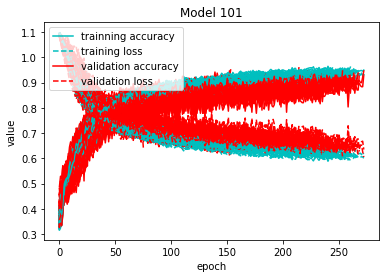

In [15]:
num_epochs = 273
patience = 50
models_list = []
optimizers = []
loss_train_list = []
loss_val_list = []
acc_train_list = []
acc_val_list = []
start = time.time()
for i in range(len(train_dataset)):
    print("--- Let's train model {} ! ---".format(i+1))
    model, loss, optimizer, device = createCNN(gpus_list)
    path = "../saved_models/covid_RAW/"+str(i+1)+".pckl"
    train_loss, val_loss, train_acc, val_acc = train(device, model, loss, optimizer, train_dataset[i], validation_dataset[i], num_epochs, patience, path, verbose=1)
    modelName = 'Model ' + str(i+1)
    visualizeTrain(modelName, train_loss, val_loss, train_acc, val_acc)
    loss_train_list.append(train_loss)
    loss_val_list.append(val_loss)
    acc_train_list.append(train_acc)
    acc_val_list.append(val_acc)
    models_list.append(model)
    optimizers.append(optimizer)
end = time.time()

In [16]:
print("Training time :", (end-start)/3600)

Training time : 11158.349967956543


In [17]:
#for i in range(len(models_list)):
    #path = "../saved_models/covid_RAW/"+str(i)+".pckl"
    #torch.save({
            #'model': models_list[i].state_dict(),
            #'optimizer': optimizers[i].state_dict()}, path)

## Test

In [18]:
def testModel(model, test_set, device, batch_size=1):
    test_acc = []
    test_generator = DataLoader(test_set, batch_size=batch_size)
    model.eval()
    for i, (ramanSpectra, label) in enumerate(test_generator):
        ramanSpectra = ramanSpectra.to(device)
        label = label.to(device)
        
        labelPredict = model(ramanSpectra)
        labelPredict = torch.argmax(labelPredict, dim=1)
        
        acc = accuracy_score(label.cpu().detach().numpy(), labelPredict.cpu().detach().numpy())
        test_acc.append(acc)
    
    return test_acc

In [19]:
test_accs = []
for i in range(len(test_dataset)):
    print("--- Let's predict with model {} ! ---".format(i+1))
    acc = testModel(models_list[i], test_dataset[i], device)
    test_accs.append(acc)

for i in range(len(test_accs)):
    print("Model {} predict with {} of accuracy".format(i+1, mean(test_accs[i])))

--- Let's predict with model 1 ! ---
--- Let's predict with model 2 ! ---
--- Let's predict with model 3 ! ---
--- Let's predict with model 4 ! ---
--- Let's predict with model 5 ! ---
--- Let's predict with model 6 ! ---
--- Let's predict with model 7 ! ---
--- Let's predict with model 8 ! ---
--- Let's predict with model 9 ! ---
--- Let's predict with model 10 ! ---
--- Let's predict with model 11 ! ---
--- Let's predict with model 12 ! ---
--- Let's predict with model 13 ! ---
--- Let's predict with model 14 ! ---
--- Let's predict with model 15 ! ---
--- Let's predict with model 16 ! ---
--- Let's predict with model 17 ! ---
--- Let's predict with model 18 ! ---
--- Let's predict with model 19 ! ---
--- Let's predict with model 20 ! ---
--- Let's predict with model 21 ! ---
--- Let's predict with model 22 ! ---
--- Let's predict with model 23 ! ---
--- Let's predict with model 24 ! ---
--- Let's predict with model 25 ! ---
--- Let's predict with model 26 ! ---
--- Let's predict wit

In [20]:
total_acc = 0
for i in range(len(test_accs)):
    total_acc += mean(test_accs[i])
print("The mean accuracy is {}".format(total_acc/len(test_accs))) 

The mean accuracy is 0.7786013550204123
